<a href="https://colab.research.google.com/github/ormorteey/Nigerian-Yellow-Fever-Data-Aanalysis/blob/main/Mido_Journal_Note_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
install.packages("pacman")
library(pacman)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [ ]:
p_load(tidyverse, foreign, haven, magrittr, rstatix)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘matrixStats’, ‘RcppArmadillo’, ‘numDeriv’, ‘SparseM’, ‘MatrixModels’, ‘conquer’, ‘sp’, ‘openxlsx’, ‘minqa’, ‘nloptr’, ‘RcppEigen’, ‘carData’, ‘abind’, ‘pbkrtest’, ‘quantreg’, ‘maptools’, ‘rio’, ‘lme4’, ‘corrplot’, ‘car’



rstatix installed



## **Data Preparation**

In [ ]:
rm(list = ls())
data_df = haven::read_sav("YELLOW FEVER.sav")

#### **Global Functions**

In [ ]:
# numerical summary

num_summary = function(df){

res = df %>% 
      select_if(is.numeric) %>% 
      gather(Variables, value)%>%
      group_by(Variables) %>%
      summarise(Count = n(), Mean = mean(value, na.rm=TRUE), Min = quantile(value, 0, na.rm=TRUE), Q1 = quantile(value, 0.25, na.rm=TRUE), 
      Q2 = quantile(value, 0.5, na.rm=TRUE),  Q3 = quantile(value, 0.75, na.rm=TRUE), Max = quantile(value, 1, na.rm=TRUE),
      Sd = sd(value, na.rm=TRUE), .groups = 'drop') 

return(res)
}


# freq function

freq = function(var, name = deparse(substitute(var))){
  tbl = table( var)
  freq_tbl = tbl %>% as.data.frame()
  prop_tbl = as.data.frame(prop.table(tbl) * 100) %>% as.data.frame() %>% select(Freq) %>% rename( "% Freq" = Freq)
  total = data.frame(var = "Total", Freq = sum(freq_tbl$Freq), "% Freq" = sum(prop_tbl$`% Freq`))
  df = cbind(freq_tbl, prop_tbl)
  colnames(total) = colnames(df)
  df = rbind(df,total)
  xname = c(name, colnames(df)[2:length(colnames(df))])
  colnames(df) = xname
  return(df)
}

# ctable function

ctable_fn = function(x, y){
  tbl = table( x, y) %>% as.data.frame.matrix()
  prop_tbl = prop.table(tbl) 
  tbl %<>% cbind(.,Total = rowSums(.)) %>% rbind(.,Total = colSums(.))
  prop_tbl %<>% cbind(.,Total = rowSums(.)) %>% rbind(.,Total = colSums(.))
  prop_tbl =  (prop_tbl * 100) %>% round(2)
  break_point = dim(tbl)[2]
  for(i in 1: dim(tbl)[2]){
    tbl[,i] = paste0(tbl[,i], " [ " , prop_tbl[,i],  "% ]" )
  }
  return(tbl)
}

# resize figure

fig_sizer_fn = function(width = 7, heigth = 7){
     options(repr.plot.width = width, repr.plot.height = heigth)
}

# plot histogram facets fro each group

hist_long_plot_fn = function(df, title_text, ncol_num = 3){

df_long =  df %>% select(names(.)) %>% pivot_longer(everything(), names_to = "Variables", values_to = "Values") 
df_long$Values = as.numeric(df_long$Values)
df_long$Variables = as.factor(df_long$Variables)

ggplot(df_long, aes(x = Values)) + 
       geom_bar() + facet_wrap(.~ Variables, scales = "free", ncol = ncol_num)  +
    theme_minimal(base_size = 18)+
    theme_bw() +
    theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank())+
    theme(legend.text=element_text(size=12 ,face="bold"), legend.title=element_text(size=12 ,face="bold"), axis.text=element_text(size=12 ,face="bold"),
          axis.title=element_text(size=14,face="bold")) +
    labs( title = title_text) +
    theme(plot.title = element_text(hjust = 0.5, size = 14, face = "bold"))

}


#### **Numerical Summary**

In [ ]:
head(num_summary(data_df))

Warning message:
“attributes are not identical across measure variables;
they will be dropped”


Variables Count Mean        Min Q1 Q2 Q3 Max Sd         
1 A1        101    1.58415842  1   1  2  2  2   0.49532468
2 A10       101    0.35643564  0   0  0  1  2   0.57591941
3 A11       101    0.05940594  0   0  0  0  1   0.23756187
4 A2        101   43.65346535 18  32 43 55 86  14.88518434
5 A3        101    2.20792079  1   2  2  2  5   1.12531624
6 A4        101    1.00990099  1   1  1  1  2   0.09950372

In [ ]:
# Dividing data set into question categories

background_df = data_df[, grepl("A",names( data_df ))]

household_knowledge_df = data_df[, grepl("B",names( data_df ))]

treatment_practice_df = data_df[, grepl("C",names( data_df ))]

perception_df = data_df[, grepl("D",names( data_df ))]


#### **Recoding of Protection Scores (D26)**

Recoding: Two recoding strategies were used. 

1. The first involves three(3) scores. 

*   Score 0 -> Response does not relate to relationship to mosquito prevention. 
*   Score 1 -> Response relates to general mosquito prevention
*   Score 2 -> Response relates to Yellow Fever prevention

2. The second involves two (2) scores

*   Score 0 -> Response does not relate to Yellow Fever prevention
*   Score 1 -> Response relates to Yellow Fever prevention

Below we present the histogram of total perception score where we add all scores for any given human observation.




###### ***Strategy 1***

In [ ]:
protect_protection_df =   perception_df[,grepl("D26",names( perception_df ))]
protection_score_vec = c(1,2,0,1,2,2,0,1,1,0,2,2,0,1) # recoding using 3 levels depending on malaria (1) or YF (2) or nothing (0)
protection_score_df = data.frame(Index = 1:nrow(protect_protection_df), Score = NA)
for(ii in 1:nrow(protect_protection_df)){
  row_vec = protect_protection_df[ii,1:14]
  indx = which(row_vec == 1)
  score = sum(protection_score_vec[indx])
  protection_score_df[ii,] = c(ii, score)
}



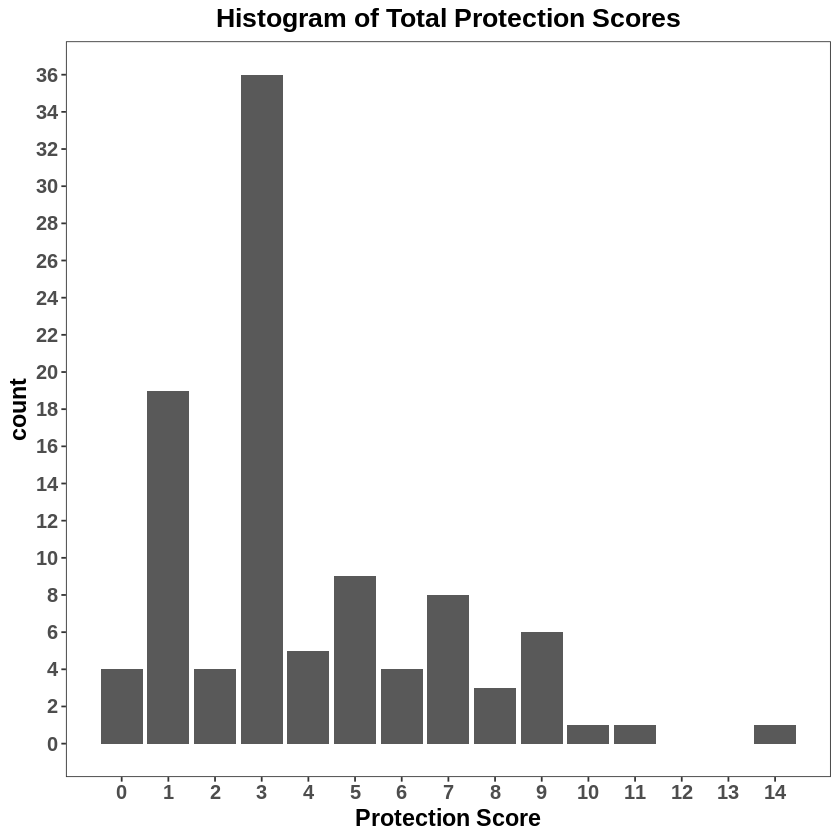

In [ ]:
fig_sizer_fn()
protection_score_df %>% ggplot(aes(x = Score)) + 
  geom_bar() +
  scale_x_continuous(breaks = 0:14) +
  scale_y_continuous(breaks = seq(0, 50, by = 2)) +
    theme_bw() +
    theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank())+
    theme(legend.text=element_text(size=12 ,face="bold"), legend.title=element_text(size=12 ,face="bold"), axis.text=element_text(size=12 ,face="bold"),
          axis.title=element_text(size=14,face="bold")) +
    labs( title = "Histogram of Total Protection Scores", x = "Protection Score") +
    theme(plot.title = element_text(hjust = 0.5, size = 16, face = "bold"))


In [ ]:
tbl_protection_YF = table(protection_score_df$Score)
tbl_perc_YF = round(prop.table(tbl_protection_YF) * 100, 1) %>% as.data.frame()
colnames(tbl_perc_YF) = c("No of Protection Approach", "Percentage")
tbl_perc_YF

No of Protection Approach Percentage
1  0                          4.0      
2  1                         18.8      
3  2                          4.0      
4  3                         35.6      
5  4                          5.0      
6  5                          8.9      
7  6                          4.0      
8  7                          7.9      
9  8                          3.0      
10 9                          5.9      
11 10                         1.0      
12 11                         1.0      
13 14                         1.0

###### ***Strategy 2***

In [ ]:
protection_score_YF_vec = c(0,1,0,0,1,1,0,0,0,0,1,1,0,0)
protection_score_YF_df = data.frame(Index = 1:nrow(protect_protection_df), Protection_Score = NA, high_Protection_Score = NA)
for(ii in 1:nrow(protect_protection_df)){
  row_vec = protect_protection_df[ii, 1:14]
  indx = which(row_vec == 1)
  score = sum(protection_score_YF_vec[indx])
  high.protection = ifelse(score > 0, 1, 0)
  protection_score_YF_df[ii,] = c(ii, score, high.protection)
}


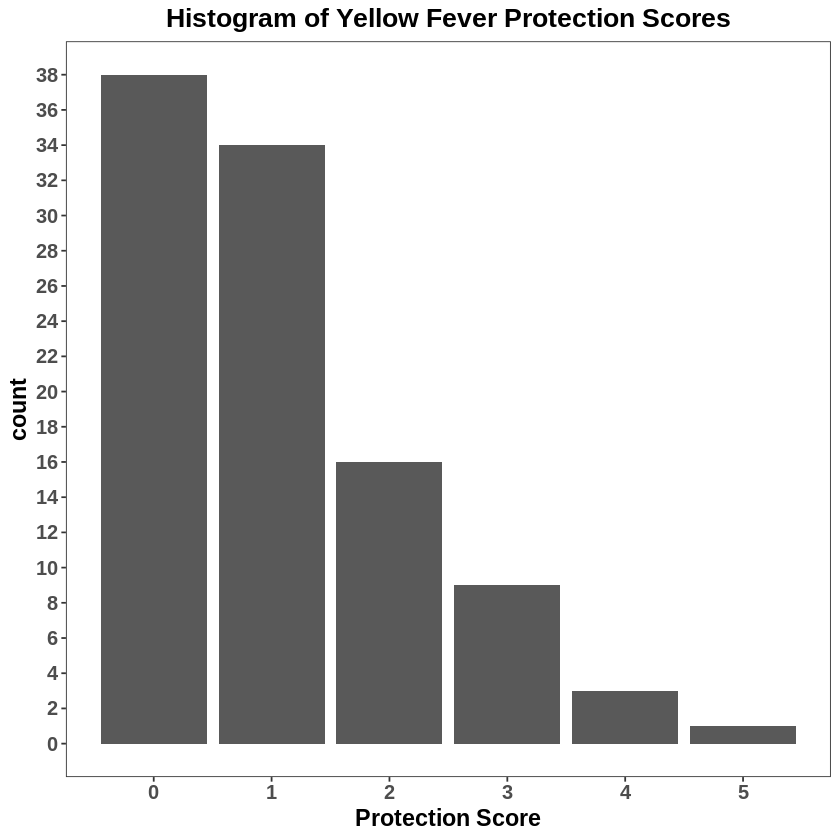

In [ ]:
fig_sizer_fn()
protection_score_YF_df %>% ggplot(aes(x = Protection_Score)) + 
  geom_bar() +
  scale_x_continuous(breaks = seq(0,5, by = 1)) +
  scale_y_continuous(breaks = seq(0,50, by = 2)) +
    theme_bw() +
    theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank())+
    theme(legend.text=element_text(size=12 ,face="bold"), legend.title=element_text(size=12 ,face="bold"), axis.text=element_text(size=12 ,face="bold"),
          axis.title=element_text(size=14,face="bold")) +
    labs( title = "Histogram of Yellow Fever Protection Scores", x = "Protection Score") +
    theme(plot.title = element_text(hjust = 0.5, size = 16, face = "bold"))


In [ ]:
tbl_protection_YF = table(protection_score_YF_df$Protection_Score)
tbl_perc_YF = round(prop.table(tbl_protection_YF) * 100, 1) %>% as.data.frame()
colnames(tbl_perc_YF) = c("No of Preventive Approach", "Percentage")
tbl_perc_YF

No of Preventive Approach Percentage
1 0                         37.6      
2 1                         33.7      
3 2                         15.8      
4 3                          8.9      
5 4                          3.0      
6 5                          1.0

#### **Recoding Knowledge and Symptoms (B16)**


We recode using:

*   Score 0 -> Response does not relate to Yellow Fever Knowledge and Symptoms
*   Score 1 -> Response relates to Yellow Fever Knowledge and Symptoms




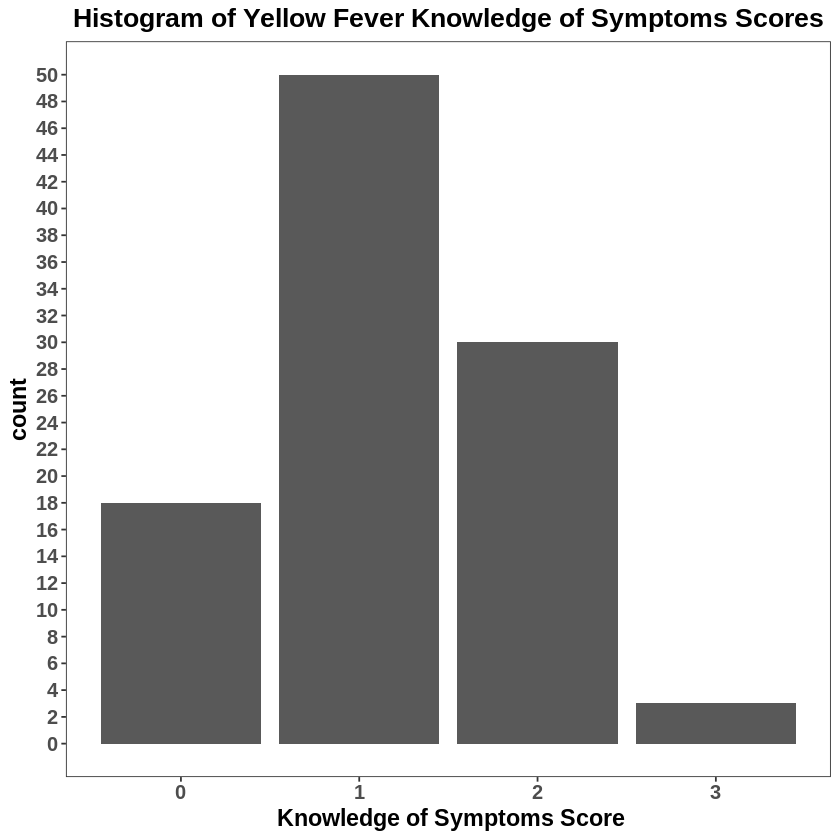

In [ ]:
protect_knowledge_df =   household_knowledge_df[,grepl("B16",names( household_knowledge_df ))]
knowledge_score_YF_vec = c(1,0,1,0,1,0,0,0,0,0,0,0,0,0)
symptoms_knowledge_score_YF_df = data.frame(Index = 1:nrow(protect_knowledge_df), Symptoms_knowledge_Score = NA, high_Symptoms_knowledge_Score = NA)
for(ii in 1:nrow(protect_knowledge_df)){
  row_vec = protect_knowledge_df[ii, 1:14]
  indx = which(row_vec == 1)
  score = sum(knowledge_score_YF_vec[indx])
  high.knowledge = ifelse(score > 0, 1, 0)
  symptoms_knowledge_score_YF_df[ii,] = c(ii, score, high.knowledge)
}

fig_sizer_fn()
symptoms_knowledge_score_YF_df %>% ggplot(aes(x = Symptoms_knowledge_Score)) + 
  geom_bar() +
  scale_x_continuous(breaks = seq(0,5, by = 1)) +
  scale_y_continuous(breaks = seq(0,50, by = 2)) +
    theme_bw() +
    theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank())+
    theme(legend.text=element_text(size=12 ,face="bold"), legend.title=element_text(size=12 ,face="bold"), axis.text=element_text(size=12 ,face="bold"),
          axis.title=element_text(size=14,face="bold")) +
    labs( title = "Histogram of Yellow Fever Knowledge of Symptoms Scores", x = " Knowledge of Symptoms Score") +
    theme(plot.title = element_text(hjust = 0.5, size = 16, face = "bold"))


In [ ]:
tbl_symptoms_knowledge_YF = table(symptoms_knowledge_score_YF_df$Symptoms_knowledge_Score)
tbl_perc_YF = round(prop.table(tbl_symptoms_knowledge_YF) * 100, 1) %>% as.data.frame()
colnames(tbl_perc_YF) = c("No of Yellow Fever Symptoms Known", "Percentage")
tbl_perc_YF

No of Yellow Fever Symptoms Known Percentage
1 0                                 17.8      
2 1                                 49.5      
3 2                                 29.7      
4 3                                  3.0

#### **Recoding of LLIN Non-Usage (D27)**

In [ ]:
protect_LLIN_non_usage_df =   perception_df[,grepl("D27",names( perception_df ))]
LLIN_non_usage_score_YF_vec = c(0,1,1,1,1,1,1,0,0,0)
LLIN_non_usage_score_YF_df = data.frame(Index = 1:nrow(protect_LLIN_non_usage_df), LLIN_non_usage_Score = NA, high_LLIN_non_usage = NA)
for(ii in 1:nrow(protect_LLIN_non_usage_df)){
  row_vec = protect_LLIN_non_usage_df[ii, 1:10]
  indx = which(row_vec == 1)
  score = sum(LLIN_non_usage_score_YF_vec[indx])
  high.LLIN_non_usage = ifelse(score > 0, 1, 0)
  LLIN_non_usage_score_YF_df[ii,] = c(ii, score, high.LLIN_non_usage)
}


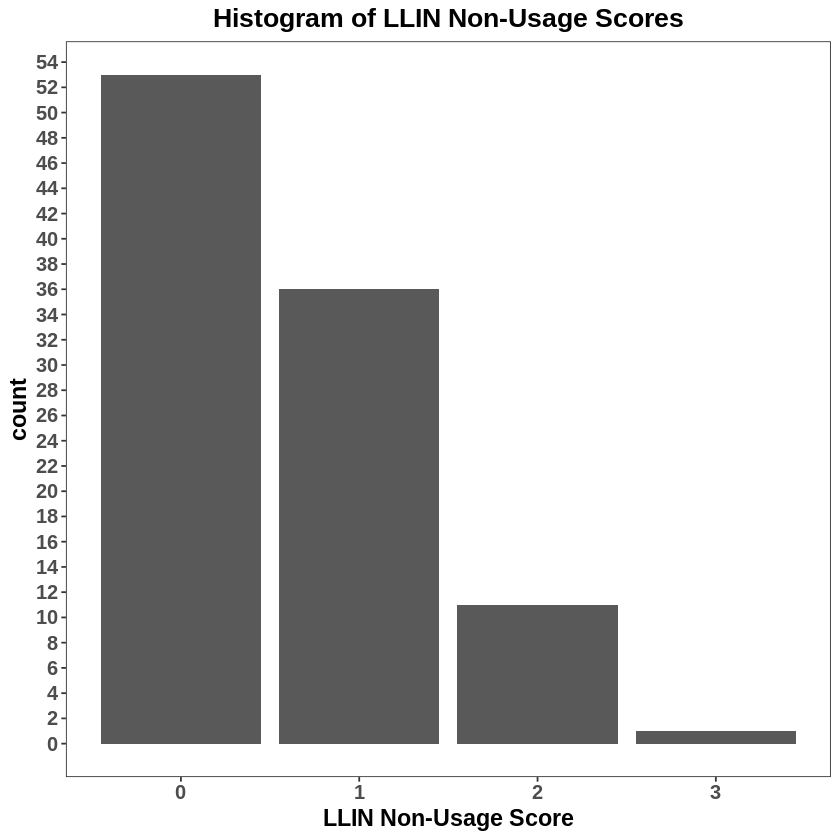

In [ ]:
fig_sizer_fn()
LLIN_non_usage_score_YF_df %>% ggplot(aes(x = LLIN_non_usage_Score)) + 
  geom_bar() +
  scale_x_continuous(breaks = seq(0,5, by = 1)) +
  scale_y_continuous(breaks = seq(0,60, by = 2)) +
    theme_bw() +
    theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank())+
    theme(legend.text=element_text(size=12 ,face="bold"), legend.title=element_text(size=12 ,face="bold"), axis.text=element_text(size=12 ,face="bold"),
          axis.title=element_text(size=14,face="bold")) +
    labs( title = "Histogram of LLIN Non-Usage Scores", x = "LLIN Non-Usage Score") +
    theme(plot.title = element_text(hjust = 0.5, size = 16, face = "bold"))


In [ ]:
tbl_LLIN_non_usage_YF = table(LLIN_non_usage_score_YF_df$LLIN_non_usage_Score)
tbl_perc_YF = round(prop.table(tbl_LLIN_non_usage_YF) * 100, 1) %>% as.data.frame()
colnames(tbl_perc_YF) = c("No of LLIN Non-Usage Reasons", "Percentage")
tbl_perc_YF

No of LLIN Non-Usage Reasons Percentage
1 0                            52.5      
2 1                            35.6      
3 2                            10.9      
4 3                             1.0

In [ ]:
YF_data = cbind(symptoms_knowledge_score_YF_df[,2:3], protection_score_YF_df[,2:3], LLIN_non_usage_score_YF_df[,2:3], data_df)


#### **Recoding of AGE**

We recode the age into three categories



*   18 - 35 (Youth)
*   35 - 60 
*   60 and above (Senior citizens)



In [ ]:
YF_data$AGECAT = cut(as.numeric(YF_data$A2), breaks = c(18, 35, 60, Inf), right = FALSE)


Age category Frequency
1 [18,35)      31       
2 [35,60)      57       
3 [60,Inf)     13

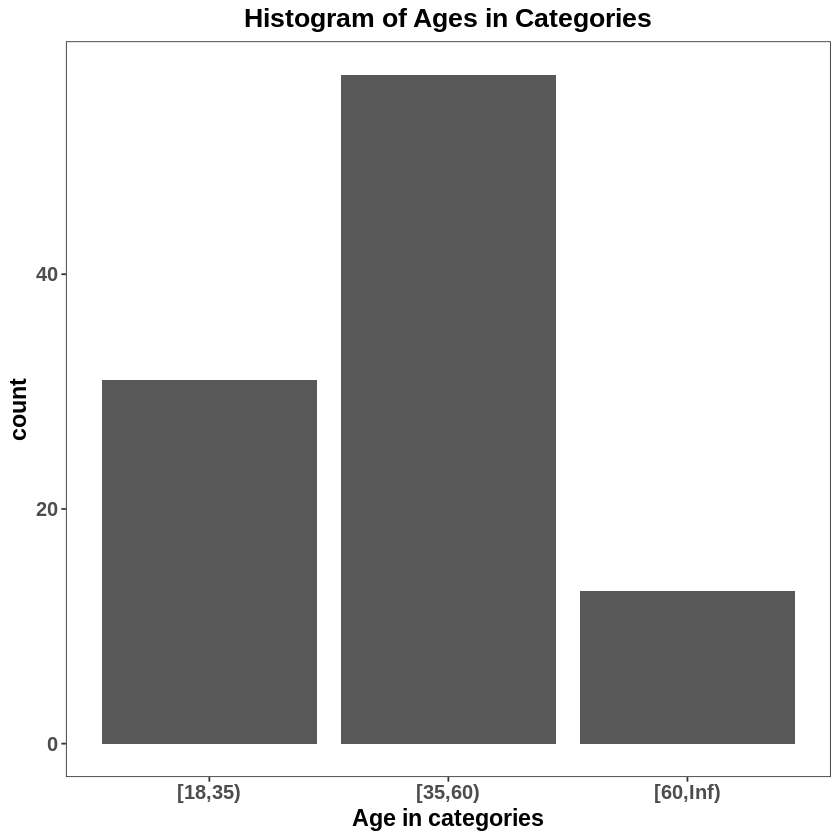

In [ ]:
tbl_AGECAT = table(YF_data$AGECAT) %>% as.data.frame()
colnames(tbl_AGECAT) = c("Age category", "Frequency")
tbl_AGECAT
YF_data %>% ggplot(aes(x = AGECAT)) +
 geom_bar() +
    theme_bw() +
    theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank())+
    theme(legend.text=element_text(size=12 ,face="bold"), legend.title=element_text(size=12 ,face="bold"), axis.text=element_text(size=12 ,face="bold"),
          axis.title=element_text(size=14,face="bold")) + labs(x = "Age in categories") +
    labs( title = "Histogram of Ages in Categories") +
    theme(plot.title = element_text(hjust = 0.5, size = 16, face = "bold"))


In [ ]:
YF_data$A1 = factor(YF_data$A1)
levels(YF_data$A1) = c("Male", "Female") 

YF_data$AGECAT = factor(YF_data$AGECAT)
levels(YF_data$AGECAT) = c("18 to 35", "35 to 60", "60 & above") 

YF_data$A5 = factor(YF_data$A5)
levels(YF_data$A5) = c("No formal education", "Primary", "Secondary", "Post Secondary") 

YF_data$A6 = factor(YF_data$A6)
levels(YF_data$A6) = c("Unemployed", "Housewife", "Farming", "Trading", "Artisan", "Public Sector", "Private Sector", "Retired", "Student") 

YF_data$B13 = factor(YF_data$B13)
levels(YF_data$B13) = c("A whole family house", "Duplex", "Two/three bedroom flat", "Mini flat/self-contain apartment", "Room and parlour", "Single room", "Wood & makeshift structure") 


In [ ]:
A5MUT_levels = c("No formal education", "Primary", "Secondary", "Post Secondary") 
A6MUT_levels = c("Unemployed", "Housewife", "Farming", "Trading", "Artisan", "Public Sector", "Private Sector", "Retired", "Student") 
B13MUT_levels = c("A whole family house", "Duplex", "Two/three bedroom flat", "Mini flat/self-contain apartment", "Room and parlour", "Single room") 


In [ ]:
YF_data = YF_data %>% 
mutate(A5MUT = case_when(A5 %in% A5MUT_levels[1:2] ~  "Pre Secondary", A5 %in% A5MUT_levels[2:4] ~ "Secondary & Above" ),
 A6MUT = case_when(A6 %in% A6MUT_levels[1:2] ~ "Unemployed & Housewife", A6 %in% A6MUT_levels[3:5] ~ "Blue Collar", A6 %in% A6MUT_levels[6:8] ~ "White Collar", A6 %in% A6MUT_levels[9] ~ "Student" ) ,
 B13MUT = case_when( B13 %in% B13MUT_levels[1:3] ~  "Spacious", B13 %in% B13MUT_levels[4:6] ~ "Not Spacious"))

In [ ]:
YF_data_backup_postprep = YF_data

In [ ]:

YF_data %<>% 
   mutate(across(everything(), as_factor ) ) 


## **Data Analysis**

#### **Mosquito Bite**



-------------------------------------------


-------------------------------------------
SEX

-------------------------------------------


A1     Freq % Freq   
1 Male    42   41.58416
2 Female  59   58.41584
3 Total  101  100.00000

Male          Female        Total        
yes   35 [ 34.65% ] 39 [ 38.61% ] 74 [ 73.27% ]
no    7 [ 6.93% ]   20 [ 19.8% ]  27 [ 26.73% ]
Total 42 [ 41.58% ] 59 [ 58.42% ] 101 [ 100% ]






-------------------------------------------


-------------------------------------------
AGE CONTINUOUS

-------------------------------------------


 Number of missing observation is: 0 out of 101




B155  Count Mean  Min Q1 Q2 Q3    Max Sd       Margin_Error
1 yes    74   23.20 1   14 24 31.75 48  12.40082 2.87        
2 no     27   25.78 2   14 26 37.00 44  12.83125 5.08        
3 Total 101   23.89 1   14 25 33.00 48  12.50512 2.47

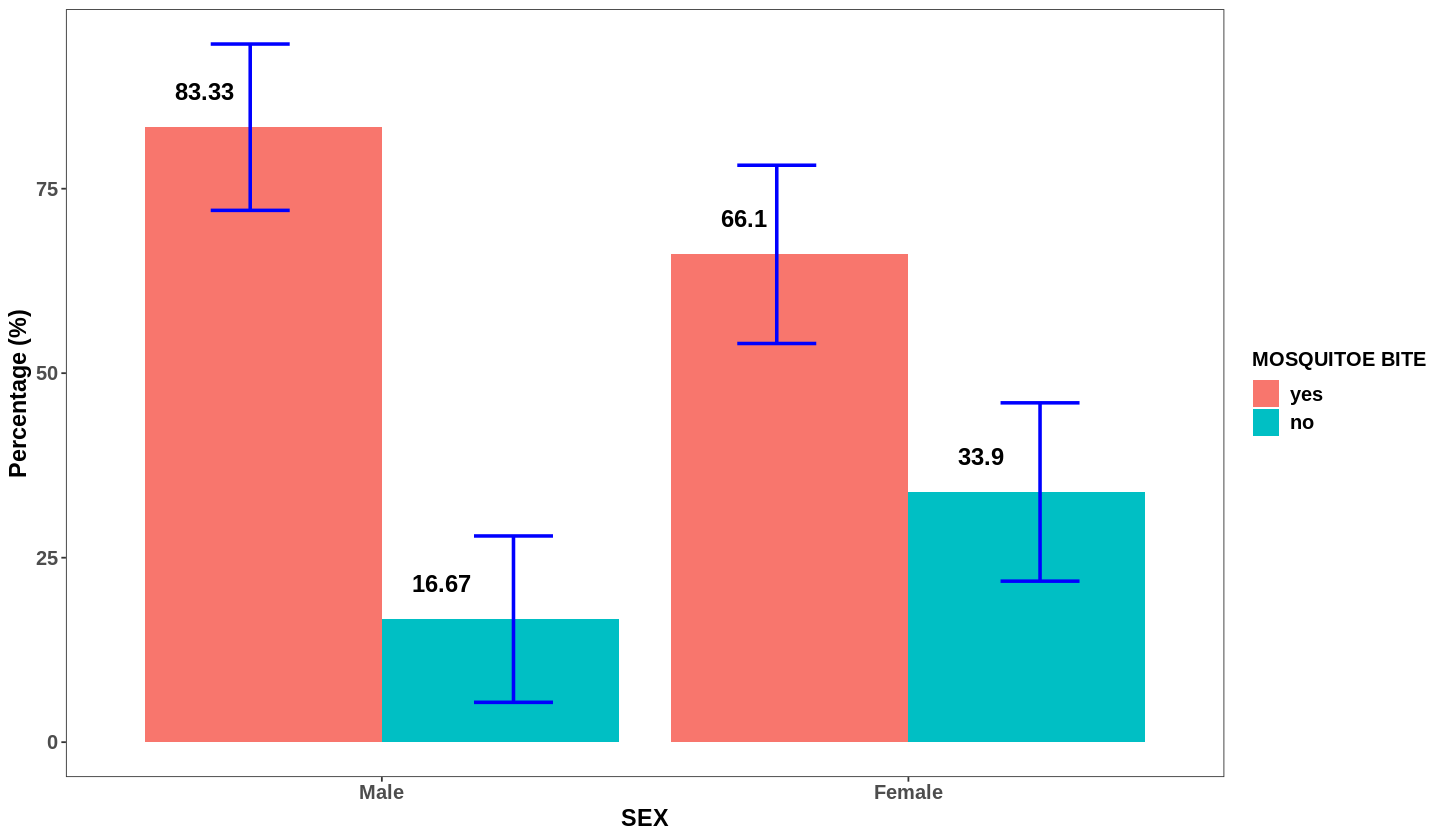



-------------------------------------------


-------------------------------------------
AGE CATEGORICAL

-------------------------------------------


AGECAT     Freq % Freq   
1 18 to 35    31   30.69307
2 35 to 60    57   56.43564
3 60 & above  13   12.87129
4 Total      101  100.00000

18 to 35      35 to 60      60 & above    Total        
yes   22 [ 21.78% ] 45 [ 44.55% ] 7 [ 6.93% ]   74 [ 73.27% ]
no    9 [ 8.91% ]   12 [ 11.88% ] 6 [ 5.94% ]   27 [ 26.73% ]
Total 31 [ 30.69% ] 57 [ 56.44% ] 13 [ 12.87% ] 101 [ 100% ]

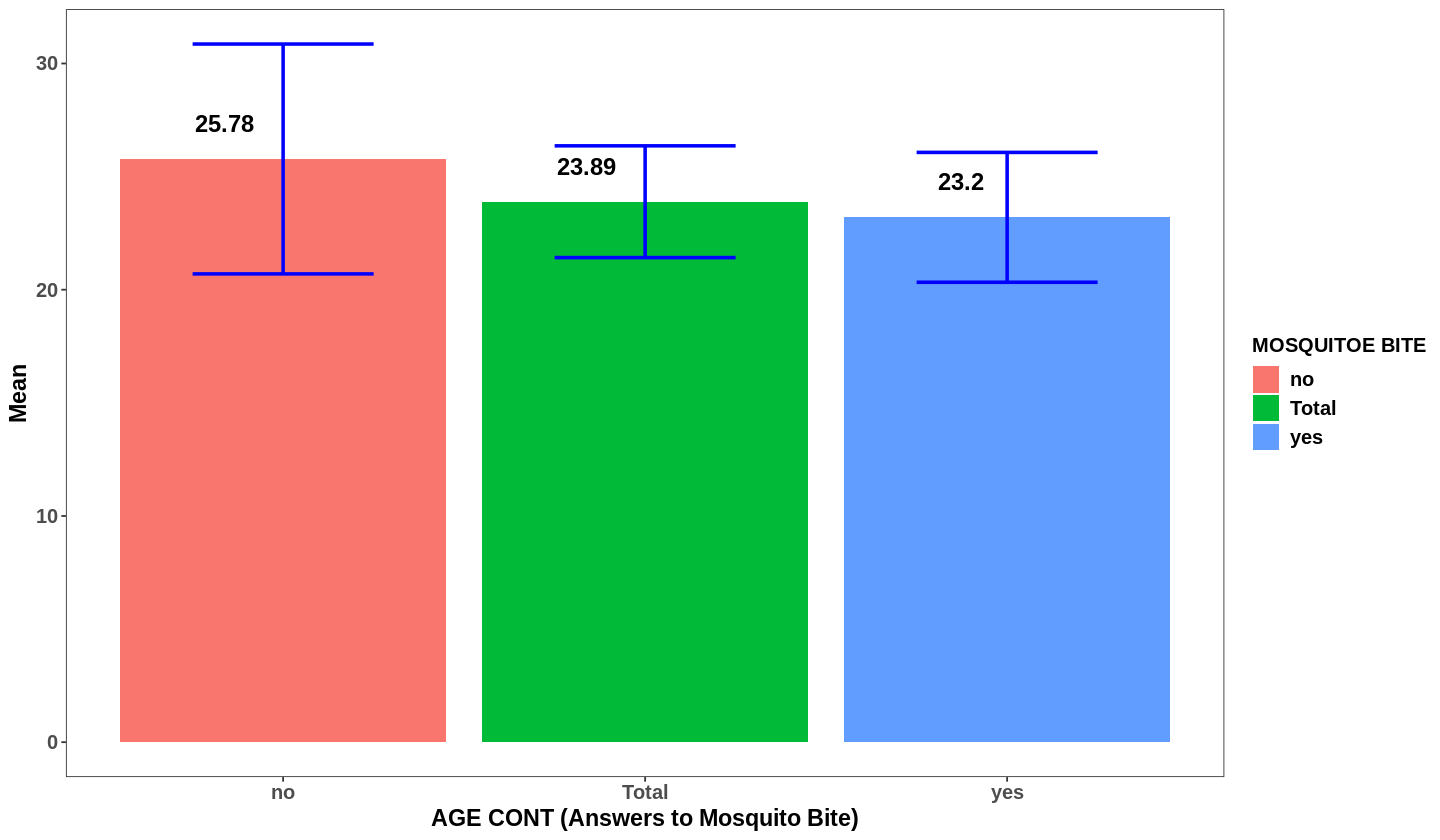



-------------------------------------------


-------------------------------------------
EDUCATION

-------------------------------------------


A5                  Freq % Freq    
1 No formal education   9    8.910891
2 Primary              15   14.851485
3 Secondary            57   56.435644
4 Post Secondary       20   19.801980
5 Total               101  100.000000

No formal education Primary       Secondary     Post Secondary
yes   6 [ 5.94% ]         5 [ 4.95% ]   45 [ 44.55% ] 18 [ 17.82% ] 
no    3 [ 2.97% ]         10 [ 9.9% ]   12 [ 11.88% ] 2 [ 1.98% ]   
Total 9 [ 8.91% ]         15 [ 14.85% ] 57 [ 56.44% ] 20 [ 19.8% ]  
      Total        
yes   74 [ 73.27% ]
no    27 [ 26.73% ]
Total 101 [ 100% ]

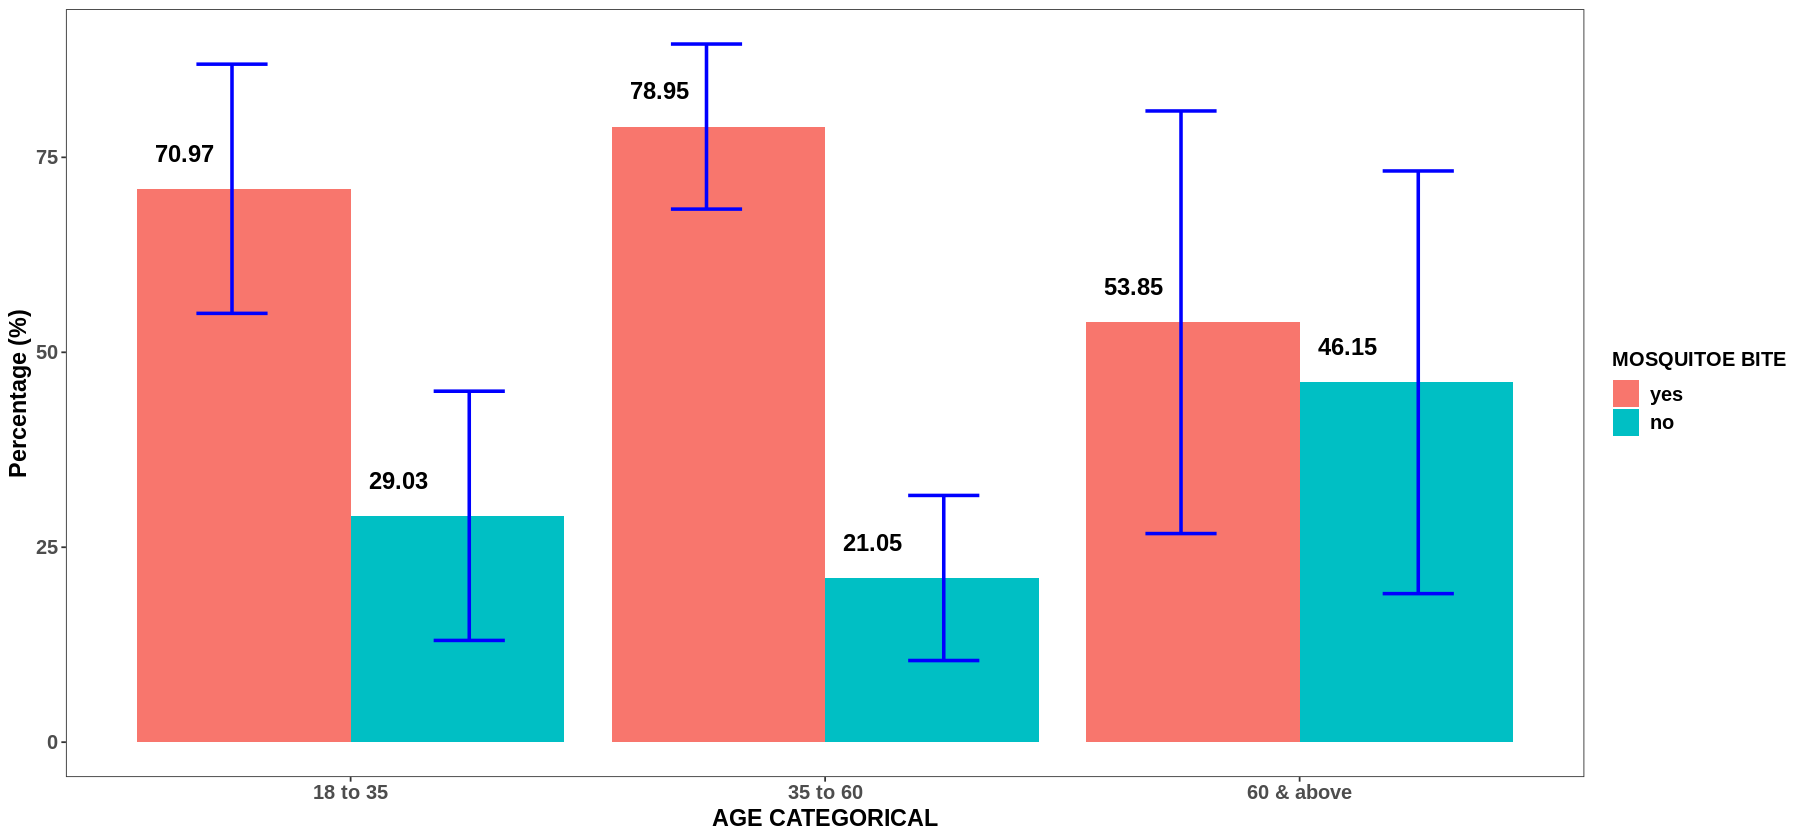



-------------------------------------------


-------------------------------------------
OCCUPATION

-------------------------------------------


A6             Freq % Freq    
1  Unemployed       4    3.960396
2  Housewife        1    0.990099
3  Farming         18   17.821782
4  Trading         36   35.643564
5  Artisan         16   15.841584
6  Public Sector   12   11.881188
7  Private Sector   2    1.980198
8  Retired          4    3.960396
9  Student          8    7.920792
10 Total          101  100.000000

Unemployed  Housewife   Farming       Trading       Artisan      
yes   2 [ 1.98% ] 0 [ 0% ]    10 [ 9.9% ]   29 [ 28.71% ] 11 [ 10.89% ]
no    2 [ 1.98% ] 1 [ 0.99% ] 8 [ 7.92% ]   7 [ 6.93% ]   5 [ 4.95% ]  
Total 4 [ 3.96% ] 1 [ 0.99% ] 18 [ 17.82% ] 36 [ 35.64% ] 16 [ 15.84% ]
      Public Sector Private Sector Retired     Student     Total        
yes   11 [ 10.89% ] 1 [ 0.99% ]    3 [ 2.97% ] 7 [ 6.93% ] 74 [ 73.27% ]
no    1 [ 0.99% ]   1 [ 0.99% ]    1 [ 0.99% ] 1 [ 0.99% ] 27 [ 26.73% ]
Total 12 [ 11.88% ] 2 [ 1.98% ]    4 [ 3.96% ] 8 [ 7.92% ] 101 [ 100% ]

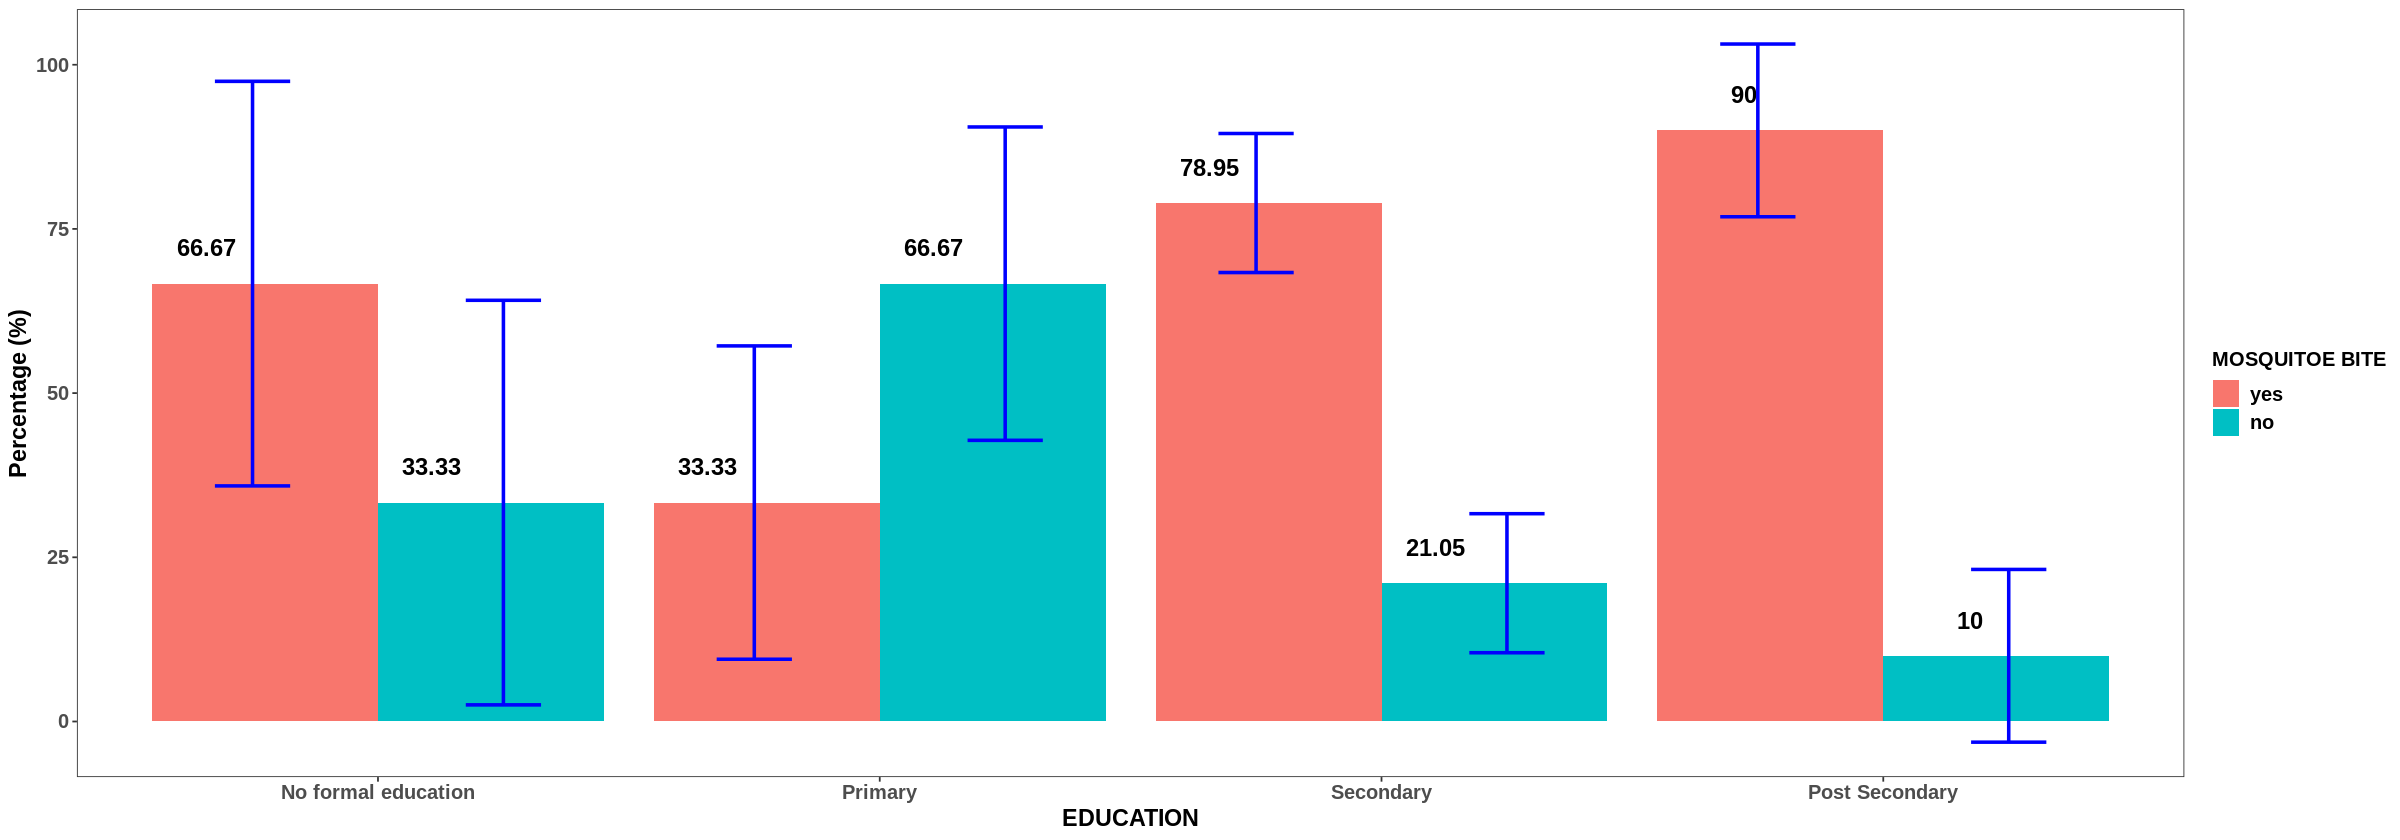



-------------------------------------------


-------------------------------------------
ACCOMODATION

-------------------------------------------


B13                              Freq % Freq    
1 A whole family house              26   25.742574
2 Duplex                             6    5.940594
3 Two/three bedroom flat            16   15.841584
4 Mini flat/self-contain apartment  32   31.683168
5 Room and parlour                  21   20.792079
6 Single room                        0    0.000000
7 Wood & makeshift structure         0    0.000000
8 Total                            101  100.000000

A whole family house Duplex      Two/three bedroom flat
yes   17 [ 16.83% ]        5 [ 4.95% ] 14 [ 13.86% ]         
no    9 [ 8.91% ]          1 [ 0.99% ] 2 [ 1.98% ]           
Total 26 [ 25.74% ]        6 [ 5.94% ] 16 [ 15.84% ]         
      Mini flat/self-contain apartment Room and parlour Single room
yes   22 [ 21.78% ]                    16 [ 15.84% ]    0 [ 0% ]   
no    10 [ 9.9% ]                      5 [ 4.95% ]      0 [ 0% ]   
Total 32 [ 31.68% ]                    21 [ 20.79% ]    0 [ 0% ]   
      Wood & makeshift structure Total        
yes   0 [ 0% ]                   74 [ 73.27% ]
no    0 [ 0% ]                   27 [ 26.73% ]
Total 0 [ 0% ]                   101 [ 100% ]

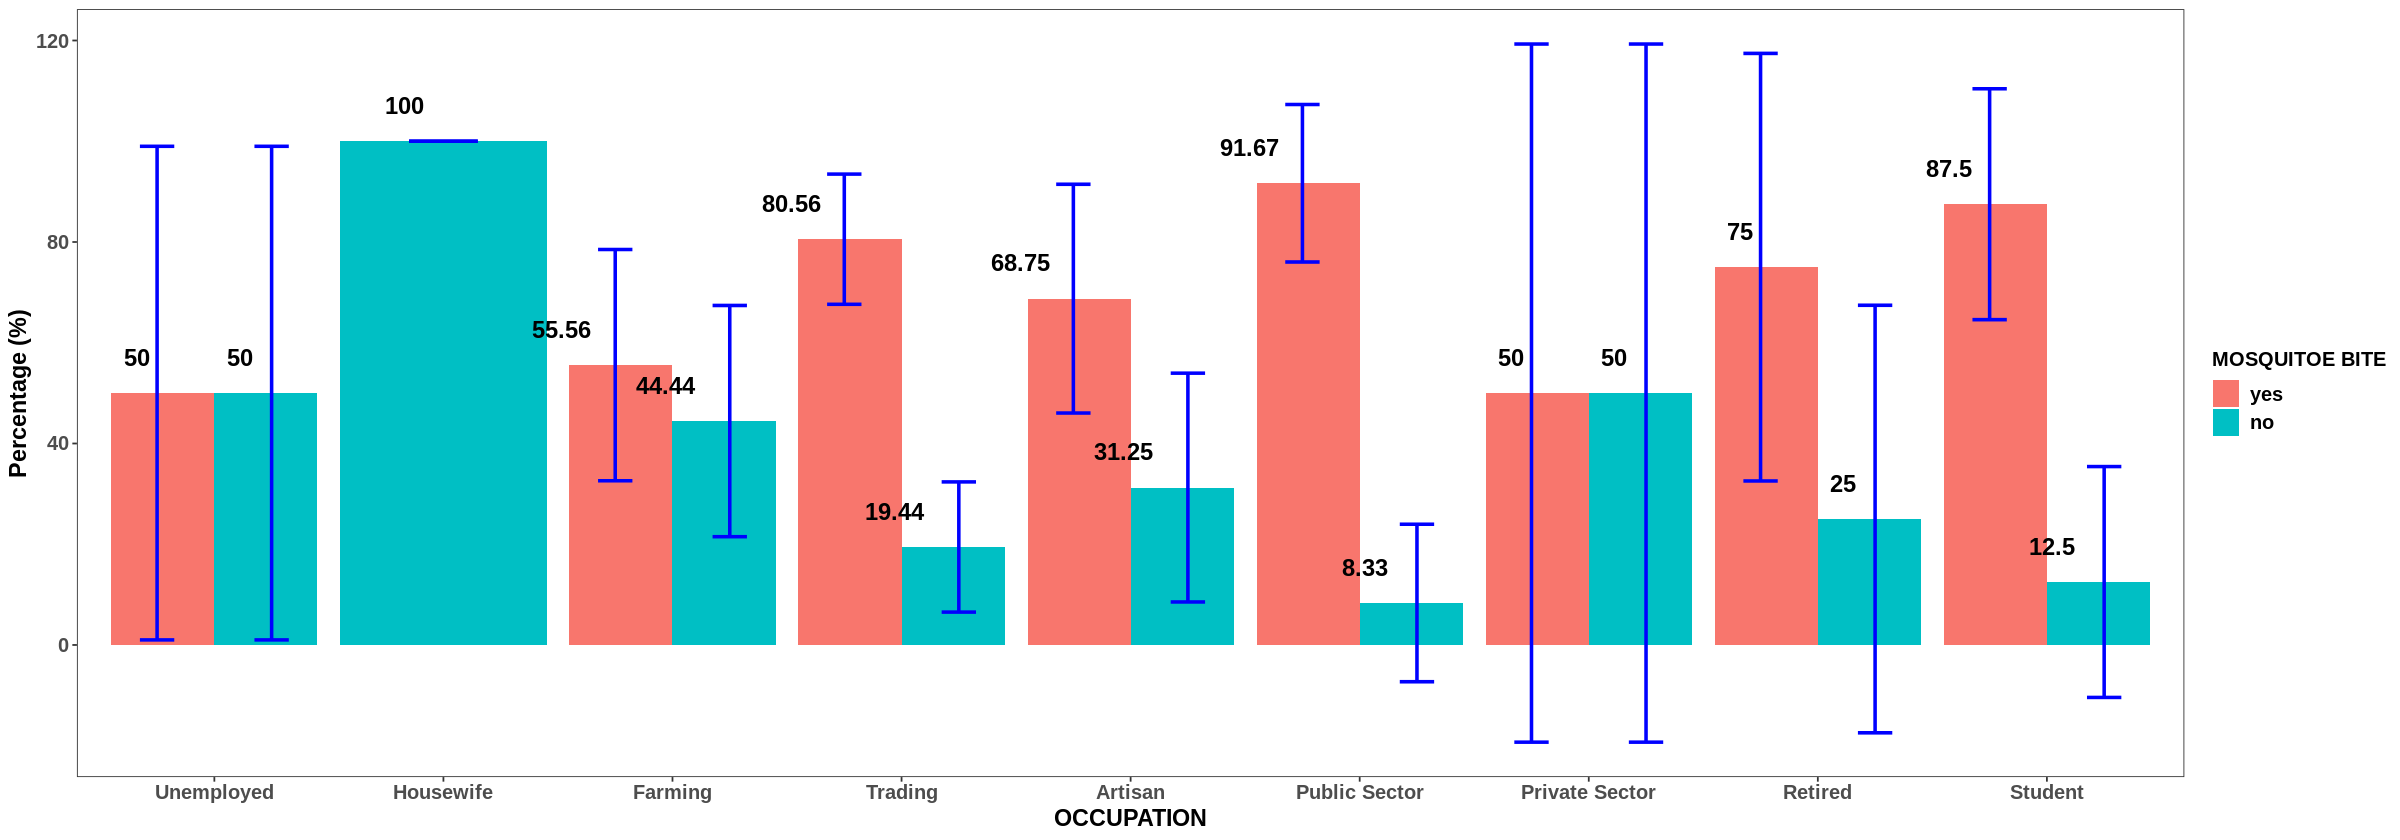



-------------------------------------------


-------------------------------------------
EDUCATION MODIFIED

-------------------------------------------


A5MUT             Freq % Freq   
1 Secondary & Above  77   76.23762
2 Pre Secondary      24   23.76238
3 Total             101  100.00000

Secondary & Above Pre Secondary Total        
yes   63 [ 62.38% ]     11 [ 10.89% ] 74 [ 73.27% ]
no    14 [ 13.86% ]     13 [ 12.87% ] 27 [ 26.73% ]
Total 77 [ 76.24% ]     24 [ 23.76% ] 101 [ 100% ]

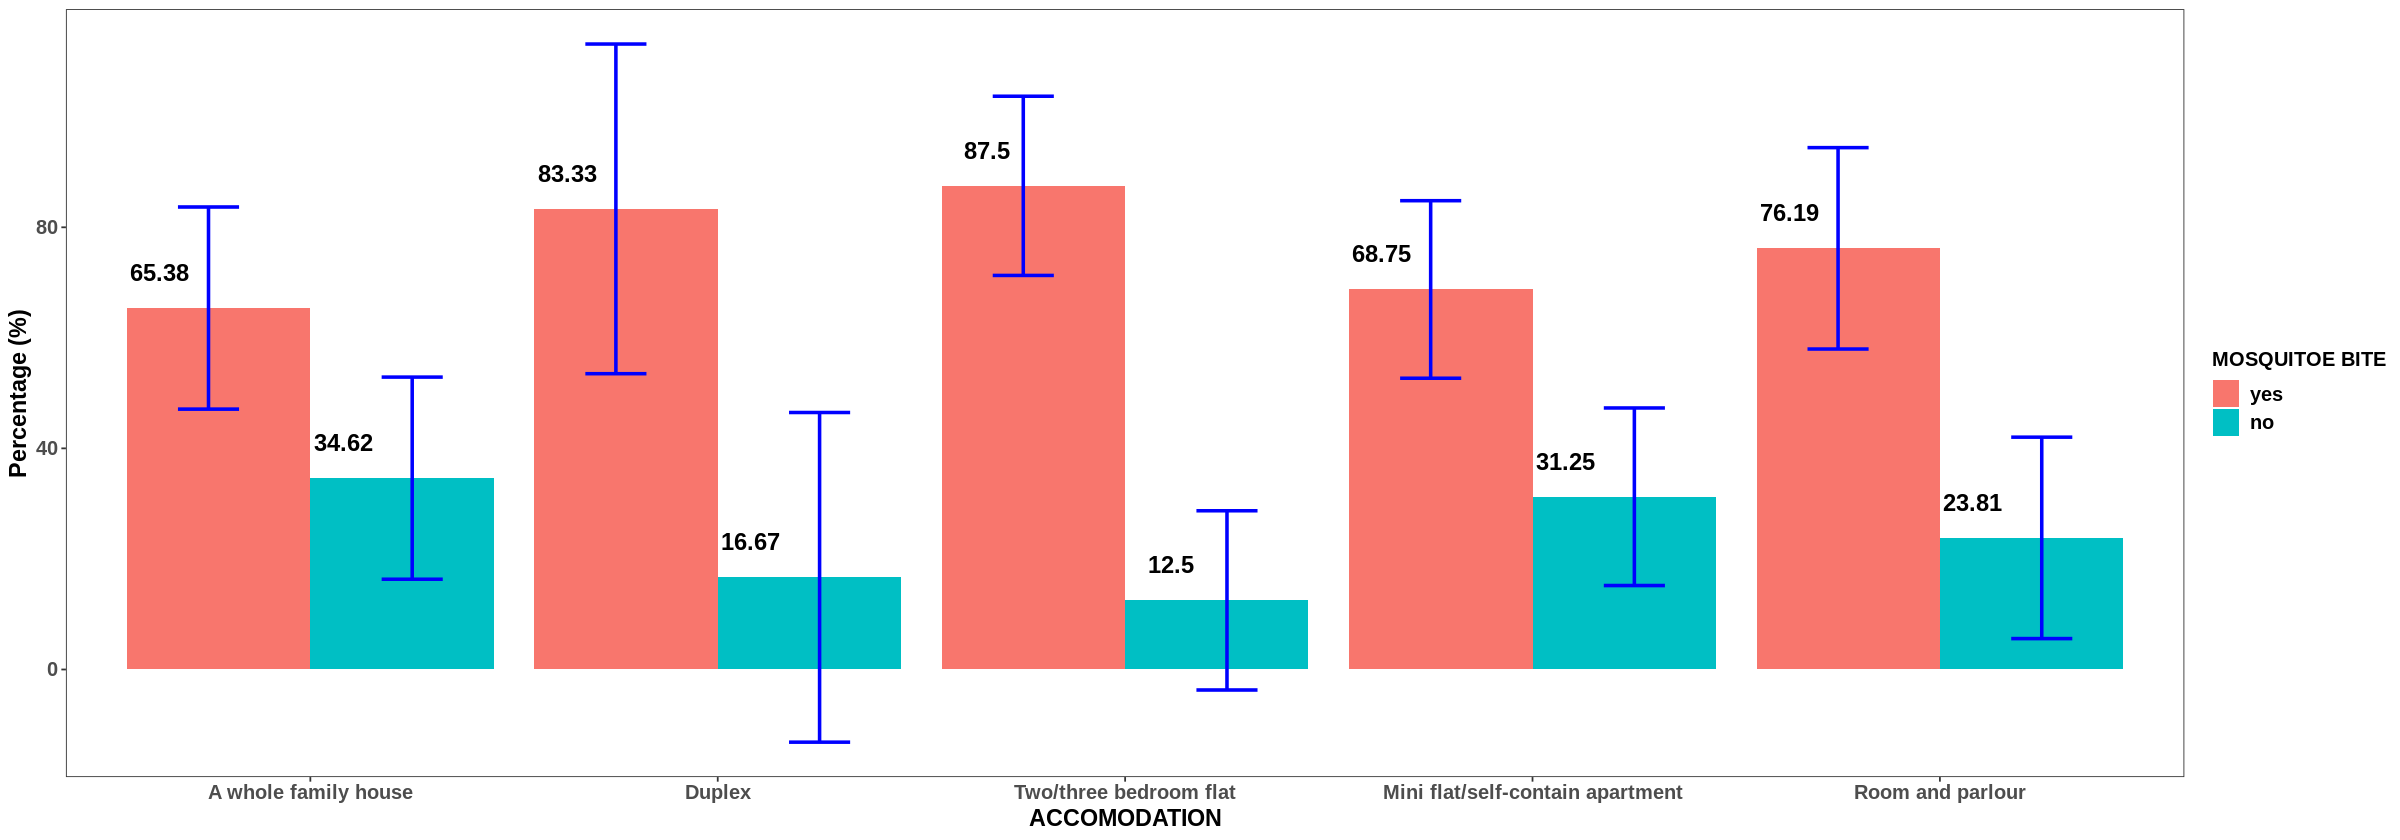



-------------------------------------------


-------------------------------------------
OCCUPATION MODIFIED

-------------------------------------------


A6MUT                  Freq % Freq    
1 Blue Collar             70   69.306931
2 White Collar            18   17.821782
3 Student                  8    7.920792
4 Unemployed & Housewife   5    4.950495
5 Total                  101  100.000000

Blue Collar   White Collar  Student     Unemployed & Housewife
yes   50 [ 49.5% ]  15 [ 14.85% ] 7 [ 6.93% ] 2 [ 1.98% ]           
no    20 [ 19.8% ]  3 [ 2.97% ]   1 [ 0.99% ] 3 [ 2.97% ]           
Total 70 [ 69.31% ] 18 [ 17.82% ] 8 [ 7.92% ] 5 [ 4.95% ]           
      Total        
yes   74 [ 73.27% ]
no    27 [ 26.73% ]
Total 101 [ 100% ]

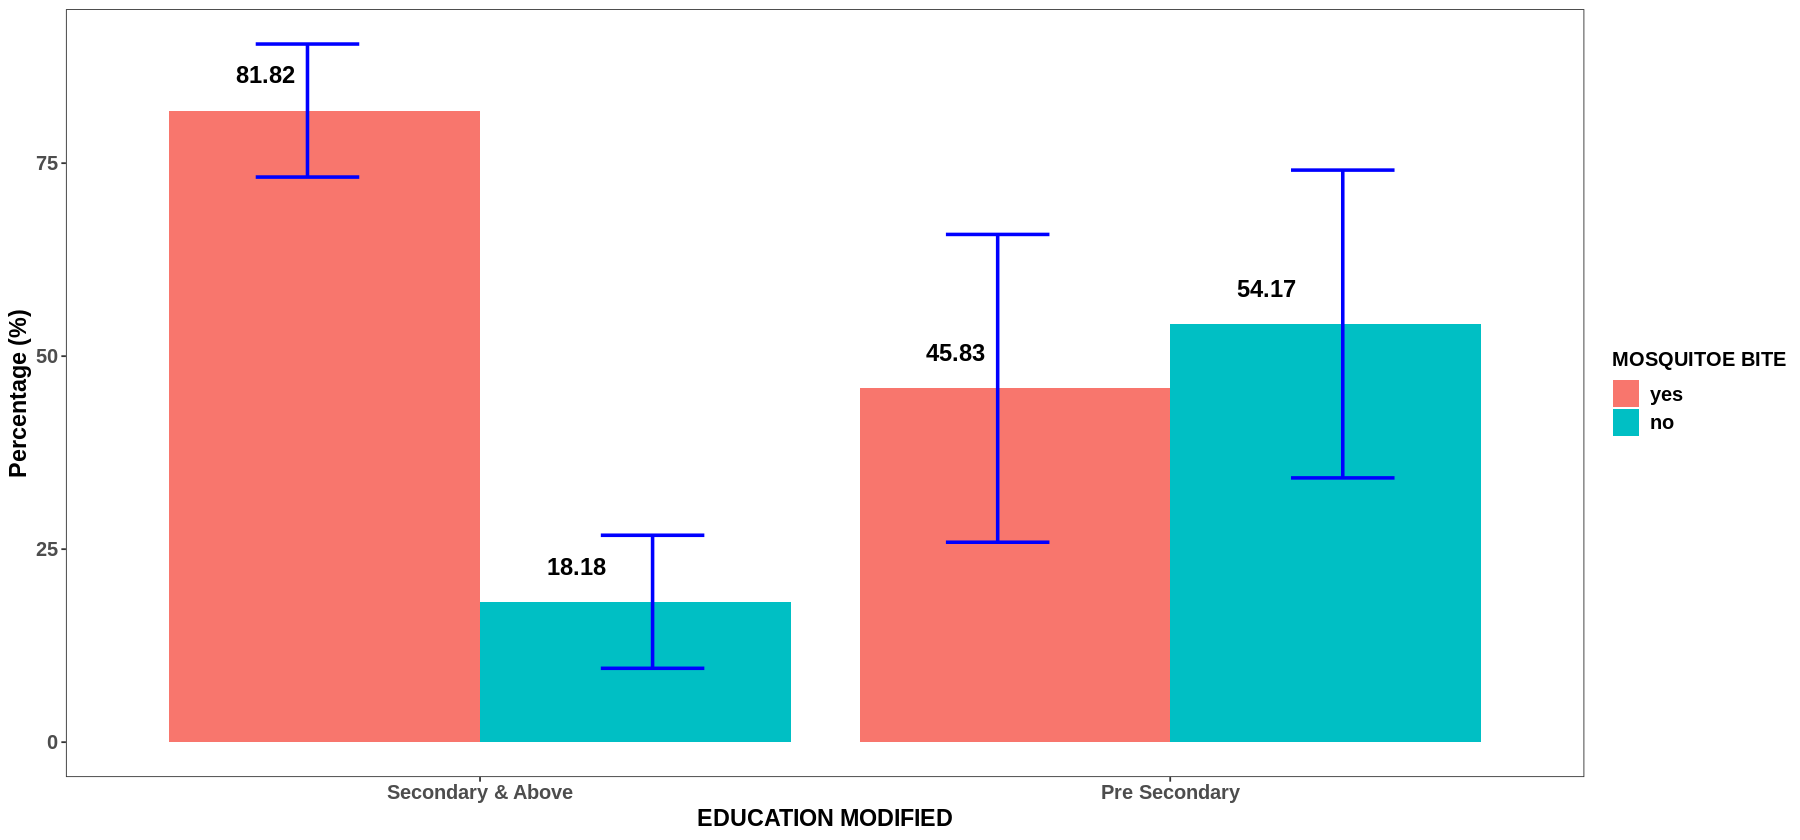



-------------------------------------------


-------------------------------------------
ACCOMODATION MODIFIED

-------------------------------------------


B13MUT       Freq % Freq   
1 Not Spacious  53   52.47525
2 Spacious      48   47.52475
3 Total        101  100.00000

Not Spacious  Spacious      Total        
yes   38 [ 37.62% ] 36 [ 35.64% ] 74 [ 73.27% ]
no    15 [ 14.85% ] 12 [ 11.88% ] 27 [ 26.73% ]
Total 53 [ 52.48% ] 48 [ 47.52% ] 101 [ 100% ]

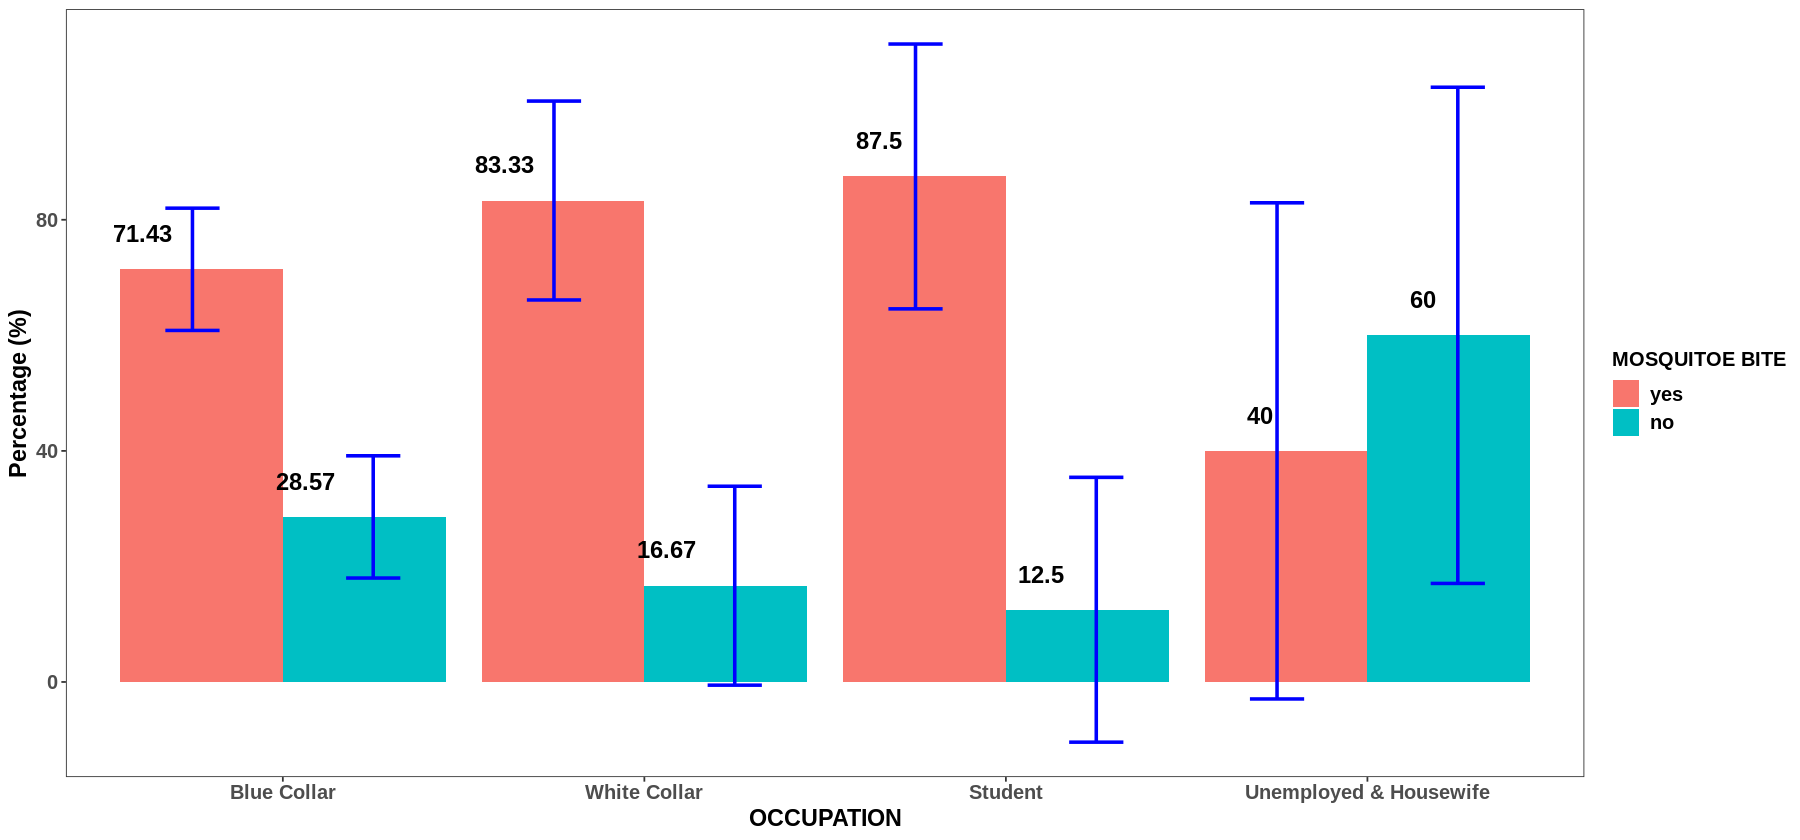

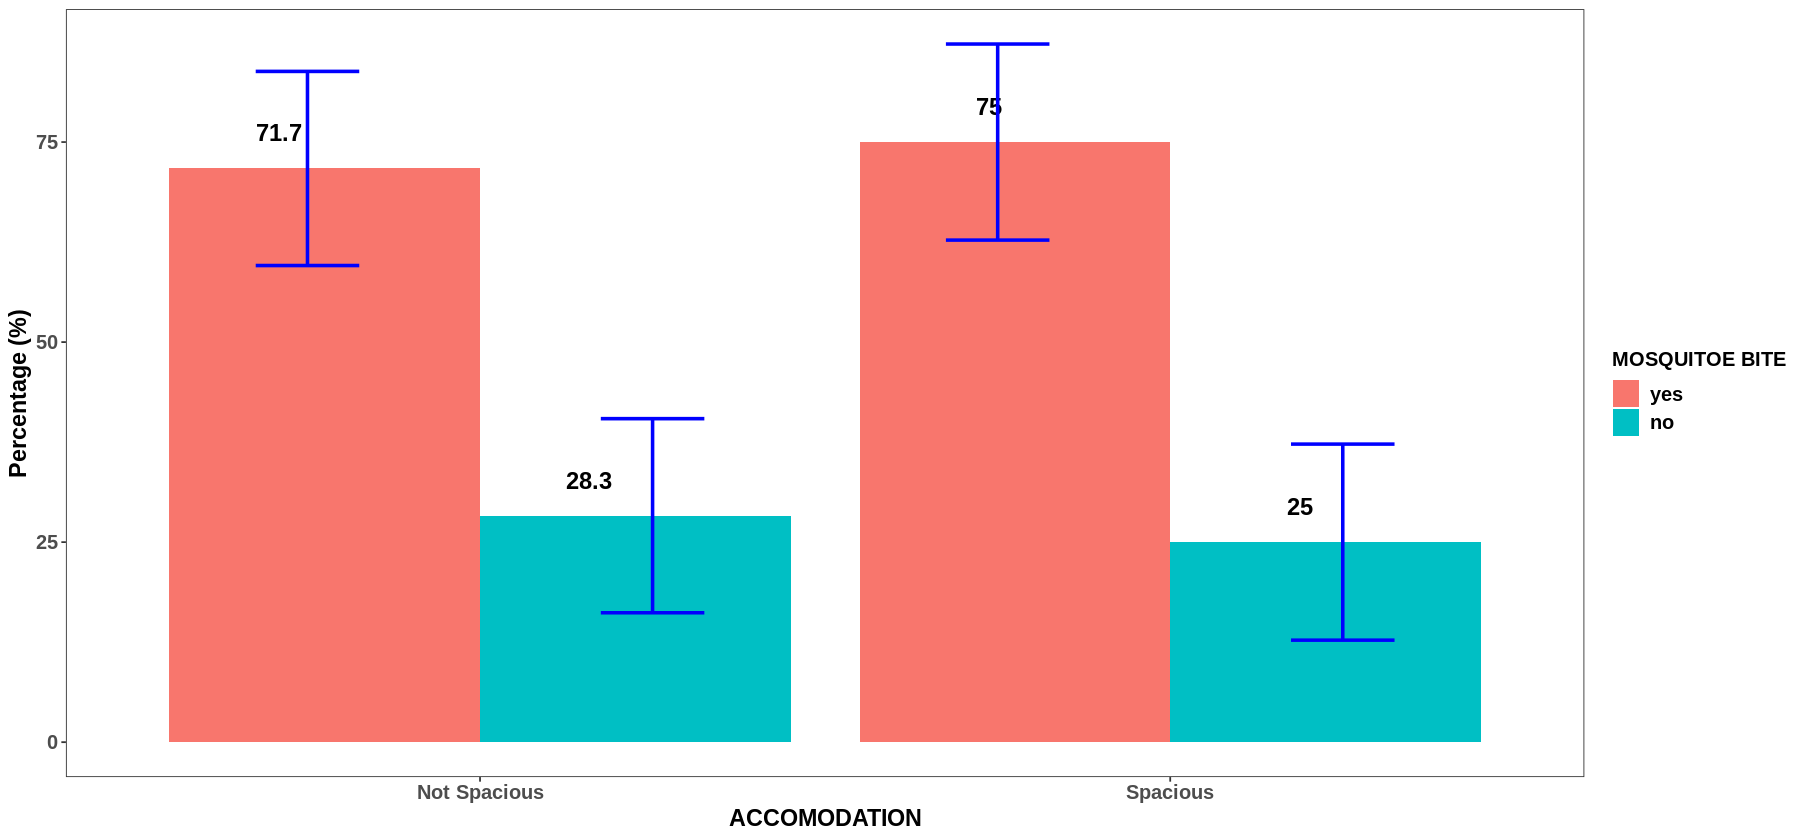

In [ ]:
fig_sizer_fn(12,7)
cat("\n\n-------------------------------------------\n")
cat("\n\n-------------------------------------------\n")

cat("SEX")
cat("\n\n-------------------------------------------\n")
analysis_df = YF_data %>% filter(is.na(B155) == FALSE) %>% filter(is.na(A1) == FALSE)

analysis_df %$% freq(A1)

cat("\n\n\n")

analysis_df %$% ctable_fn(x = B155, y = A1)

cat("\n\n\n")

#============================================================

analysis_CI_cat_df = analysis_df %>% select(B155, A1) %>% group_by(A1, B155) %>%
  summarise(Count = n(), .groups = 'drop') %>% 

  mutate(OverallPercentage = Count/sum(.$Count) ) %>%
  mutate( OverallPercentage = round(OverallPercentage,4) * 100) %>%
  
  group_by(A1) %>% mutate(WithinGroupSum = sum(Count)) %>%
  group_by(B155, .add=TRUE) %>%
  mutate(Percentage = Count/WithinGroupSum , Lower_CI = Percentage - 1.96 * sqrt( Percentage * {1 - Percentage} / WithinGroupSum), Upper_CI = Percentage + 1.96 * sqrt( Percentage * {1 - Percentage} / WithinGroupSum)) %>%
  mutate( Percentage = round(Percentage, 4) * 100, Lower_CI  = round(Lower_CI, 4) * 100, Upper_CI = round(Upper_CI,4) * 100)

ggplot(analysis_CI_cat_df, aes(x = factor(A1), y = Percentage, fill = factor(B155))) +
  geom_bar(position="dodge", stat="identity", width = 0.9) +
   geom_text(aes(label = Percentage), position = position_dodge(0.9), hjust = 1.5, vjust = -1.6, fontface = "bold", size = 5) +
  labs(x = "SEX", y = "Percentage (%)", fill = "MOSQUITOE BITE") +  
      geom_errorbar(aes(ymin = Lower_CI, ymax = Upper_CI), width = 0.3 , position = position_dodge(width = 1), color = "blue", size = 1)    +
  theme_minimal(base_size = 18)+
  theme_bw() +
  theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank()) +
  theme(legend.text=element_text(size = 12, face = "bold"), legend.title = element_text(size=12 , face = "bold"), axis.text=element_text(size=12, face="bold"),
        axis.title=element_text(size=14, face="bold"), plot.title = element_text(hjust = 0.5, size = 16, face = "bold"))



cat("\n\n-------------------------------------------\n")
cat("\n\n-------------------------------------------\n")

cat("AGE CONTINUOUS")
cat("\n\n-------------------------------------------\n")

analysis_df = YF_data %>% filter(is.na(B155) == FALSE) %>% filter(is.na(A2) == FALSE)

cat(paste0("\n\n Number of missing observation is: ", nrow(YF_data) - nrow(analysis_df), " out of ", nrow(YF_data), "\n"))
#=======================================================================

analysis_df = analysis_df %>% select(c(A2, B155 ))
analysis_df = analysis_df[complete.cases(analysis_df),]

analysis_df$A2 = as.numeric(analysis_df$A2)

cat("\n\n")

#=======================================================================

analysis_CI_cont_df1 = analysis_df %>% group_by(B155) %>%
                       summarise(Count = n(), Mean = mean(A2, na.rm=TRUE), Min = quantile(A2, 0, na.rm=TRUE), Q1 = quantile(A2, 0.25, na.rm=TRUE), 
                       Q2 = quantile(A2, 0.5, na.rm=TRUE),  Q3 = quantile(A2, 0.75, na.rm=TRUE), Max = quantile(A2, 1, na.rm=TRUE),
                       Sd = sd(A2, na.rm=TRUE), .groups = 'drop') %>%
                       mutate( Margin_Error = {Sd/sqrt(Count)} * qt(1-0.05/2, Count - 1)  ) %>% mutate(Mean = round(Mean, 2),  Margin_Error = round(Margin_Error, 2) )
analysis_CI_cont_df1$B155 = as.character(analysis_CI_cont_df1$B155)

analysis_CI_cont_df2 = analysis_df %>%
                       summarise(B155 =  "Total", Count = n(), Mean = mean(A2, na.rm=TRUE), Min = quantile(A2, 0, na.rm=TRUE), Q1 = quantile(A2, 0.25, na.rm=TRUE), 
                       Q2 = quantile(A2, 0.5, na.rm=TRUE),  Q3 = quantile(A2, 0.75, na.rm=TRUE), Max = quantile(A2, 1, na.rm=TRUE),
                       Sd = sd(A2, na.rm=TRUE), .groups = 'drop') %>%
                       mutate( Margin_Error = {Sd/sqrt(Count)} * qt(1-0.05/2, Count - 1)  ) %>% mutate(Mean = round(Mean, 2),  Margin_Error = round(Margin_Error, 2) )

analysis_CI_cont_df = rbind(analysis_CI_cont_df1, analysis_CI_cont_df2)

analysis_CI_cont_df 

#================================================================


ggplot(analysis_CI_cont_df, aes(x = factor(B155), y = Mean , fill = factor(B155))) +
  geom_bar(position="dodge", stat="identity", width = 0.9) +
  labs(x = "AGE CONT (Answers to Mosquito Bite)", y = "Mean", fill = "MOSQUITOE BITE") +  
       geom_text(aes(label = Mean), position = position_dodge(0.9), hjust = 1.5, vjust = -1.6, fontface = "bold", size = 5) +
      geom_errorbar(aes(ymin = Mean  - Margin_Error, ymax = Mean + Margin_Error), width = 0.5, position = position_dodge(width = 0.5), color="blue", size=1)    +
  theme_minimal(base_size = 18)+
  theme_bw() +
  theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank()) +
  theme(legend.text=element_text(size = 12, face = "bold"), legend.title = element_text(size=12 , face = "bold"), axis.text=element_text(size=12, face="bold"),
        axis.title=element_text(size=14, face="bold"), plot.title = element_text(hjust = 0.5, size = 16, face = "bold"))






cat("\n\n-------------------------------------------\n")
cat("\n\n-------------------------------------------\n")

cat("AGE CATEGORICAL")
cat("\n\n-------------------------------------------\n")

analysis_df = YF_data %>% filter(is.na(B155) == FALSE) %>% filter(is.na(AGECAT) == FALSE)

analysis_df %$% freq(AGECAT)

cat("\n\n\n")

analysis_df %$% ctable_fn(x = B155, y = AGECAT)


#============================================================

analysis_CI_cat_df = analysis_df %>% select(B155, AGECAT) %>% group_by(AGECAT, B155) %>%
  summarise(Count = n(), .groups = 'drop') %>% 

  mutate(OverallPercentage = Count/sum(.$Count) ) %>%
  mutate( OverallPercentage = round(OverallPercentage,4) * 100) %>%
  
  group_by(AGECAT) %>% mutate(WithinGroupSum = sum(Count)) %>%
  group_by(B155, .add=TRUE) %>%
  mutate(Percentage = Count/WithinGroupSum , Lower_CI = Percentage - 1.96 * sqrt( Percentage * {1 - Percentage} / WithinGroupSum), Upper_CI = Percentage + 1.96 * sqrt( Percentage * {1 - Percentage} / WithinGroupSum)) %>%
  mutate( Percentage = round(Percentage, 4) * 100, Lower_CI  = round(Lower_CI, 4) * 100, Upper_CI = round(Upper_CI,4) * 100)
fig_sizer_fn(15, 7)
ggplot(analysis_CI_cat_df, aes(x = factor(AGECAT), y = Percentage, fill = factor(B155))) +
  geom_bar(position="dodge", stat="identity", width = 0.9) +
   geom_text(aes(label = Percentage), position = position_dodge(0.9), hjust = 1.5, vjust = -1.6, fontface = "bold", size = 5) +
  labs(x = "AGE CATEGORICAL", y = "Percentage (%)", fill = "MOSQUITOE BITE") +  
      geom_errorbar(aes(ymin = Lower_CI, ymax = Upper_CI), width = 0.3 , position = position_dodge(width = 1), color = "blue", size = 1)    +
  theme_minimal(base_size = 18)+
  theme_bw() +
  theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank()) +
  theme(legend.text=element_text(size = 12, face = "bold"), legend.title = element_text(size=12 , face = "bold"), axis.text=element_text(size=12, face="bold"),
        axis.title=element_text(size=14, face="bold"), plot.title = element_text(hjust = 0.5, size = 16, face = "bold"))



cat("\n\n-------------------------------------------\n")
cat("\n\n-------------------------------------------\n")

cat("EDUCATION")
cat("\n\n-------------------------------------------\n")

analysis_df = YF_data %>% filter(is.na(B155) == FALSE) %>% filter(is.na(A5) == FALSE)

analysis_df %$% freq(A5)

cat("\n\n\n")

analysis_df %$% ctable_fn(x = B155, y = A5)


#============================================================

analysis_CI_cat_df = analysis_df %>% select(B155, A5) %>% group_by(A5, B155) %>%
  summarise(Count = n(), .groups = 'drop') %>% 

  mutate(OverallPercentage = Count/sum(.$Count) ) %>%
  mutate( OverallPercentage = round(OverallPercentage,4) * 100) %>%
  
  group_by(A5) %>% mutate(WithinGroupSum = sum(Count)) %>%
  group_by(B155, .add=TRUE) %>%
  mutate(Percentage = Count/WithinGroupSum , Lower_CI = Percentage - 1.96 * sqrt( Percentage * {1 - Percentage} / WithinGroupSum), Upper_CI = Percentage + 1.96 * sqrt( Percentage * {1 - Percentage} / WithinGroupSum)) %>%
  mutate( Percentage = round(Percentage, 4) * 100, Lower_CI  = round(Lower_CI, 4) * 100, Upper_CI = round(Upper_CI,4) * 100)

fig_sizer_fn(20, 7)

ggplot(analysis_CI_cat_df, aes(x = factor(A5), y = Percentage, fill = factor(B155))) +
  geom_bar(position="dodge", stat="identity", width = 0.9) +
   geom_text(aes(label = Percentage), position = position_dodge(0.9), hjust = 1.5, vjust = -1.6, fontface = "bold", size = 5) +
  labs(x = "EDUCATION", y = "Percentage (%)", fill = "MOSQUITOE BITE") +  
      geom_errorbar(aes(ymin = Lower_CI, ymax = Upper_CI), width = 0.3 , position = position_dodge(width = 1), color = "blue", size = 1)    +
  theme_minimal(base_size = 18)+
  theme_bw() +
  theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank()) +
  theme(legend.text=element_text(size = 12, face = "bold"), legend.title = element_text(size=12 , face = "bold"), axis.text=element_text(size=12, face="bold"),
        axis.title=element_text(size=14, face="bold"), plot.title = element_text(hjust = 0.5, size = 16, face = "bold"))



cat("\n\n-------------------------------------------\n")
cat("\n\n-------------------------------------------\n")

cat("OCCUPATION")
cat("\n\n-------------------------------------------\n")

analysis_df = YF_data %>% filter(is.na(B155) == FALSE) %>% filter(is.na(A6) == FALSE)

analysis_df %$% freq(A6)

cat("\n\n\n")

analysis_df %$% ctable_fn(x = B155, y = A6)


#============================================================

analysis_CI_cat_df = analysis_df %>% select(B155, A6) %>% group_by(A6, B155) %>%
  summarise(Count = n(), .groups = 'drop') %>% 

  mutate(OverallPercentage = Count/sum(.$Count) ) %>%
  mutate( OverallPercentage = round(OverallPercentage,4) * 100) %>%
  
  group_by(A6) %>% mutate(WithinGroupSum = sum(Count)) %>%
  group_by(B155, .add=TRUE) %>%
  mutate(Percentage = Count/WithinGroupSum , Lower_CI = Percentage - 1.96 * sqrt( Percentage * {1 - Percentage} / WithinGroupSum), Upper_CI = Percentage + 1.96 * sqrt( Percentage * {1 - Percentage} / WithinGroupSum)) %>%
  mutate( Percentage = round(Percentage, 4) * 100, Lower_CI  = round(Lower_CI, 4) * 100, Upper_CI = round(Upper_CI,4) * 100)

fig_sizer_fn(20, 7)

ggplot(analysis_CI_cat_df, aes(x = factor(A6), y = Percentage, fill = factor(B155))) +
  geom_bar(position="dodge", stat="identity", width = 0.9) +
   geom_text(aes(label = Percentage), position = position_dodge(0.9), hjust = 1.5, vjust = -1.6, fontface = "bold", size = 5) +
  labs(x = "OCCUPATION", y = "Percentage (%)", fill = "MOSQUITOE BITE") +  
      geom_errorbar(aes(ymin = Lower_CI, ymax = Upper_CI), width = 0.3 , position = position_dodge(width = 1), color = "blue", size = 1)    +
  theme_minimal(base_size = 18)+
  theme_bw() +
  theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank()) +
  theme(legend.text=element_text(size = 12, face = "bold"), legend.title = element_text(size=12 , face = "bold"), axis.text=element_text(size=12, face="bold"),
        axis.title=element_text(size=14, face="bold"), plot.title = element_text(hjust = 0.5, size = 16, face = "bold"))




cat("\n\n-------------------------------------------\n")
cat("\n\n-------------------------------------------\n")

cat("ACCOMODATION")
cat("\n\n-------------------------------------------\n")

analysis_df = YF_data %>% filter(is.na(B155) == FALSE) %>% filter(is.na(B13) == FALSE)

analysis_df %$% freq(B13)

cat("\n\n\n")

analysis_df %$% ctable_fn(x = B155, y = B13)


#============================================================

analysis_CI_cat_df = analysis_df %>% select(B155, B13) %>% group_by(B13, B155) %>%
  summarise(Count = n(), .groups = 'drop') %>% 

  mutate(OverallPercentage = Count/sum(.$Count) ) %>%
  mutate( OverallPercentage = round(OverallPercentage,4) * 100) %>%
  
  group_by(B13) %>% mutate(WithinGroupSum = sum(Count)) %>%
  group_by(B155, .add=TRUE) %>%
  mutate(Percentage = Count/WithinGroupSum , Lower_CI = Percentage - 1.96 * sqrt( Percentage * {1 - Percentage} / WithinGroupSum), Upper_CI = Percentage + 1.96 * sqrt( Percentage * {1 - Percentage} / WithinGroupSum)) %>%
  mutate( Percentage = round(Percentage, 4) * 100, Lower_CI  = round(Lower_CI, 4) * 100, Upper_CI = round(Upper_CI,4) * 100)

fig_sizer_fn(20, 7)

ggplot(analysis_CI_cat_df, aes(x = factor(B13), y = Percentage, fill = factor(B155))) +
  geom_bar(position="dodge", stat="identity", width = 0.9) +
   geom_text(aes(label = Percentage), position = position_dodge(0.9), hjust = 1.5, vjust = -1.6, fontface = "bold", size = 5) +
  labs(x = "ACCOMODATION", y = "Percentage (%)", fill = "MOSQUITOE BITE") +  
      geom_errorbar(aes(ymin = Lower_CI, ymax = Upper_CI), width = 0.3 , position = position_dodge(width = 1), color = "blue", size = 1)    +
  theme_minimal(base_size = 18)+
  theme_bw() +
  theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank()) +
  theme(legend.text=element_text(size = 12, face = "bold"), legend.title = element_text(size=12 , face = "bold"), axis.text=element_text(size=12, face="bold"),
        axis.title=element_text(size=14, face="bold"), plot.title = element_text(hjust = 0.5, size = 16, face = "bold"))



#====================================================================================================================
#====================================================================================================================
#====================================================================================================================
#====================================================================================================================


fig_sizer_fn()

cat("\n\n-------------------------------------------\n")
cat("\n\n-------------------------------------------\n")

cat("EDUCATION MODIFIED")
cat("\n\n-------------------------------------------\n")

analysis_df = YF_data %>% filter(is.na(B155) == FALSE) %>% filter(is.na(A5MUT) == FALSE)

analysis_df %$% freq(A5MUT)

cat("\n\n\n")

analysis_df %$% ctable_fn(x = B155, y = A5MUT)


#============================================================

analysis_CI_cat_df = analysis_df %>% select(B155, A5MUT) %>% group_by(A5MUT, B155) %>%
  summarise(Count = n(), .groups = 'drop') %>% 

  mutate(OverallPercentage = Count/sum(.$Count) ) %>%
  mutate( OverallPercentage = round(OverallPercentage,4) * 100) %>%
  
  group_by(A5MUT) %>% mutate(WithinGroupSum = sum(Count)) %>%
  group_by(B155, .add=TRUE) %>%
  mutate(Percentage = Count/WithinGroupSum , Lower_CI = Percentage - 1.96 * sqrt( Percentage * {1 - Percentage} / WithinGroupSum), Upper_CI = Percentage + 1.96 * sqrt( Percentage * {1 - Percentage} / WithinGroupSum)) %>%
  mutate( Percentage = round(Percentage, 4) * 100, Lower_CI  = round(Lower_CI, 4) * 100, Upper_CI = round(Upper_CI,4) * 100)

fig_sizer_fn(15, 7)

ggplot(analysis_CI_cat_df, aes(x = factor(A5MUT), y = Percentage, fill = factor(B155))) +
  geom_bar(position="dodge", stat="identity", width = 0.9) +
   geom_text(aes(label = Percentage), position = position_dodge(0.9), hjust = 1.5, vjust = -1.6, fontface = "bold", size = 5) +
  labs(x = "EDUCATION MODIFIED", y = "Percentage (%)", fill = "MOSQUITOE BITE") +  
      geom_errorbar(aes(ymin = Lower_CI, ymax = Upper_CI), width = 0.3 , position = position_dodge(width = 1), color = "blue", size = 1)    +
  theme_minimal(base_size = 18)+
  theme_bw() +
  theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank()) +
  theme(legend.text=element_text(size = 12, face = "bold"), legend.title = element_text(size=12 , face = "bold"), axis.text=element_text(size=12, face="bold"),
        axis.title=element_text(size=14, face="bold"), plot.title = element_text(hjust = 0.5, size = 16, face = "bold"))



cat("\n\n-------------------------------------------\n")
cat("\n\n-------------------------------------------\n")

cat("OCCUPATION MODIFIED")
cat("\n\n-------------------------------------------\n")

analysis_df = YF_data %>% filter(is.na(B155) == FALSE) %>% filter(is.na(A6MUT) == FALSE)

analysis_df %$% freq(A6MUT)

cat("\n\n\n")

analysis_df %$% ctable_fn(x = B155, y = A6MUT)


#============================================================

analysis_CI_cat_df = analysis_df %>% select(B155, A6MUT) %>% group_by(A6MUT, B155) %>%
  summarise(Count = n(), .groups = 'drop') %>% 

  mutate(OverallPercentage = Count/sum(.$Count) ) %>%
  mutate( OverallPercentage = round(OverallPercentage,4) * 100) %>%
  
  group_by(A6MUT) %>% mutate(WithinGroupSum = sum(Count)) %>%
  group_by(B155, .add=TRUE) %>%
  mutate(Percentage = Count/WithinGroupSum , Lower_CI = Percentage - 1.96 * sqrt( Percentage * {1 - Percentage} / WithinGroupSum), Upper_CI = Percentage + 1.96 * sqrt( Percentage * {1 - Percentage} / WithinGroupSum)) %>%
  mutate( Percentage = round(Percentage, 4) * 100, Lower_CI  = round(Lower_CI, 4) * 100, Upper_CI = round(Upper_CI,4) * 100)

fig_sizer_fn(15, 7)

ggplot(analysis_CI_cat_df, aes(x = factor(A6MUT), y = Percentage, fill = factor(B155))) +
  geom_bar(position="dodge", stat="identity", width = 0.9) +
   geom_text(aes(label = Percentage), position = position_dodge(0.9), hjust = 1.5, vjust = -1.6, fontface = "bold", size = 5) +
  labs(x = "OCCUPATION", y = "Percentage (%)", fill = "MOSQUITOE BITE") +  
      geom_errorbar(aes(ymin = Lower_CI, ymax = Upper_CI), width = 0.3 , position = position_dodge(width = 1), color = "blue", size = 1)    +
  theme_minimal(base_size = 18)+
  theme_bw() +
  theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank()) +
  theme(legend.text=element_text(size = 12, face = "bold"), legend.title = element_text(size=12 , face = "bold"), axis.text=element_text(size=12, face="bold"),
        axis.title=element_text(size=14, face="bold"), plot.title = element_text(hjust = 0.5, size = 16, face = "bold"))




cat("\n\n-------------------------------------------\n")
cat("\n\n-------------------------------------------\n")

cat("ACCOMODATION MODIFIED")
cat("\n\n-------------------------------------------\n")

analysis_df = YF_data %>% filter(is.na(B155) == FALSE) %>% filter(is.na(B13MUT) == FALSE)

analysis_df %$% freq(B13MUT)

cat("\n\n\n")

analysis_df %$% ctable_fn(x = B155, y = B13MUT)


#============================================================

analysis_CI_cat_df = analysis_df %>% select(B155, B13MUT) %>% group_by(B13MUT, B155) %>%
  summarise(Count = n(), .groups = 'drop') %>% 

  mutate(OverallPercentage = Count/sum(.$Count) ) %>%
  mutate( OverallPercentage = round(OverallPercentage,4) * 100) %>%
  
  group_by(B13MUT) %>% mutate(WithinGroupSum = sum(Count)) %>%
  group_by(B155, .add=TRUE) %>%
  mutate(Percentage = Count/WithinGroupSum , Lower_CI = Percentage - 1.96 * sqrt( Percentage * {1 - Percentage} / WithinGroupSum), Upper_CI = Percentage + 1.96 * sqrt( Percentage * {1 - Percentage} / WithinGroupSum)) %>%
  mutate( Percentage = round(Percentage, 4) * 100, Lower_CI  = round(Lower_CI, 4) * 100, Upper_CI = round(Upper_CI,4) * 100)

fig_sizer_fn(15, 7)

ggplot(analysis_CI_cat_df, aes(x = factor(B13MUT), y = Percentage, fill = factor(B155))) +
  geom_bar(position="dodge", stat="identity", width = 0.9) +
   geom_text(aes(label = Percentage), position = position_dodge(0.9), hjust = 1.5, vjust = -1.6, fontface = "bold", size = 5) +
  labs(x = "ACCOMODATION", y = "Percentage (%)", fill = "MOSQUITOE BITE") +  
      geom_errorbar(aes(ymin = Lower_CI, ymax = Upper_CI), width = 0.3 , position = position_dodge(width = 1), color = "blue", size = 1)    +
  theme_minimal(base_size = 18)+
  theme_bw() +
  theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank()) +
  theme(legend.text=element_text(size = 12, face = "bold"), legend.title = element_text(size=12 , face = "bold"), axis.text=element_text(size=12, face="bold"),
        axis.title=element_text(size=14, face="bold"), plot.title = element_text(hjust = 0.5, size = 16, face = "bold"))



#### **Knowlwedge of Symptoms**

In [ ]:
cat("\n\n-------------------------------------------\n")
cat("\n\n-------------------------------------------\n")

cat("Fisher Test for Categorical Variable")
cat("\n\n-------------------------------------------\n")


YF_data %>% select(c(high_Symptoms_knowledge_Score, A1, A3:A6, B13, C18, C19, C20, AGECAT, A5MUT, A6MUT, B13MUT)) %>%
    pivot_longer(!high_Symptoms_knowledge_Score, names_to = "variables", values_to = "value", values_drop_na = TRUE) %>%
    arrange(variables) %>% group_by(variables) %>% summarize(
fisher_test(table(high_Symptoms_knowledge_Score, value), hybrid = TRUE,
     conf.level = 0.95, detailed = TRUE) %>% adjust_pvalue(method = "BH") %>%
     add_significance("p.adj"))


cat("\n\n-------------------------------------------\n")
cat("\n\n-------------------------------------------\n")

cat("T-Test for Continuous Variable")
cat("\n\n-------------------------------------------\n")


YF_data %>%
    select(c(high_Symptoms_knowledge_Score, A2, A7, A8, A9, A10, A11, B12a, B12b)) %>% 
     mutate(across(everything(), as.numeric ), high_Symptoms_knowledge_Score = factor(high_Symptoms_knowledge_Score) ) %>%
    pivot_longer(!high_Symptoms_knowledge_Score, names_to = "variables", values_to = "value", values_drop_na = TRUE) %>%
    arrange(variables) %>% group_by(variables) %>%
    t_test(value ~ high_Symptoms_knowledge_Score, p.adjust.method = "none",
    conf.level = 0.95, detailed = TRUE) %>% adjust_pvalue(method = "BH") %>%
    add_significance("p.adj") %>%
    data.frame() %>%
    slice(order(factor(variables, levels = c("A7", "A8", "A9", "A10", "A11", "B12a", "B12b")))) %>% select(c(1,2,6,7,10:14,17:18))  %>%
    mutate(across(where(is.numeric), ~ signif(., 2)))

    



-------------------------------------------


-------------------------------------------
Fisher Test for Categorical Variable

-------------------------------------------


variables n   p      method              alternative p.signif p.adj 
1  A1        101 0.0682 Fisher's Exact test two.sided   ns       0.0682
2  A3        101 0.0869 Fisher's Exact test two.sided   ns       0.0869
3  A4        101 1.0000 Fisher's Exact test two.sided   ns       1.0000
4  A5        101 0.4990 Fisher's Exact test two.sided   ns       0.4990
5  A5MUT     101 0.7610 Fisher's Exact test two.sided   ns       0.7610
6  A6        101 0.4460 Fisher's Exact test two.sided   ns       0.4460
7  A6MUT     101 0.8570 Fisher's Exact test two.sided   ns       0.8570
8  AGECAT    101 0.5810 Fisher's Exact test two.sided   ns       0.5810
9  B13       101 0.1130 Fisher's Exact test two.sided   ns       0.1130
10 B13MUT    101 0.7470 Fisher's Exact test two.sided   ns       0.7470
11 C18       101 0.0665 Fisher's Exact test two.sided   ns       0.0665
12 C19       101 0.5110 Fisher's Exact test two.sided   ns       0.5110
13 C20       101 1.0000 Fisher's Exact test two.sided   ns       1.0000
   p.adj.signif
1  ns          
2  ns          
3  ns          
4  ns          
5  ns          
6  ns          
7  ns          
8  ns          
9  ns          
10 ns          
11 ns          
12 ns          
13 ns



-------------------------------------------


-------------------------------------------
T-Test for Continuous Variable

-------------------------------------------


variables estimate group1 group2 statistic p    df   conf.low conf.high p.adj
1 A7        -1.100   1      2      -0.320    0.75 27.0  -8.00    5.80     0.95 
2 A8         0.500   1      2       0.880    0.39 22.0  -0.68    1.70     0.95 
3 A9         0.260   1      2       0.460    0.65 22.0  -0.92    1.40     0.95 
4 A10       -0.096   1      2      -0.750    0.46 31.0  -0.35    0.16     0.95 
5 A11        0.063   1      2       0.790    0.44 20.0  -0.10    0.23     0.95 
6 B12a      -1.100   1      2      -0.260    0.84  1.2 -39.00   36.00     0.95 
7 B12b      -1.000   1      2      -0.290    0.82  1.2 -33.00   31.00     0.95 
8 A2        -0.140   1      2      -0.047    0.96 28.0  -6.20    5.90     0.96 
  p.adj.signif
1 ns          
2 ns          
3 ns          
4 ns          
5 ns          
6 ns          
7 ns          
8 ns



-------------------------------------------


-------------------------------------------
SEX

-------------------------------------------


A1     Freq % Freq   
1 Male    42   41.58416
2 Female  59   58.41584
3 Total  101  100.00000

Male          Female        Total        
0     4 [ 3.96% ]   14 [ 13.86% ] 18 [ 17.82% ]
1     25 [ 24.75% ] 25 [ 24.75% ] 50 [ 49.5% ] 
2     12 [ 11.88% ] 18 [ 17.82% ] 30 [ 29.7% ] 
3     1 [ 0.99% ]   2 [ 1.98% ]   3 [ 2.97% ]  
Total 42 [ 41.58% ] 59 [ 58.42% ] 101 [ 100% ]






-------------------------------------------


-------------------------------------------
AGE CONTINUOUS

-------------------------------------------


 Number of missing observation is: 0 out of 101




Symptoms_knowledge_Score Count Mean  Min Q1    Q2   Q3   Max Sd       
1 0                         18   23.78  2  15.50 23.5 34.0 40  10.978886
2 1                         50   20.90  1   8.25 20.0 32.5 48  14.099139
3 2                         30   29.17 10  24.50 28.0 34.5 47   9.101282
4 3                          3   21.67 14  17.00 20.0 25.5 31   8.621678
5 Total                    101   23.89  1  14.00 25.0 33.0 48  12.505120
  Margin_Error
1  5.46       
2  4.01       
3  3.40       
4 21.42       
5  2.47

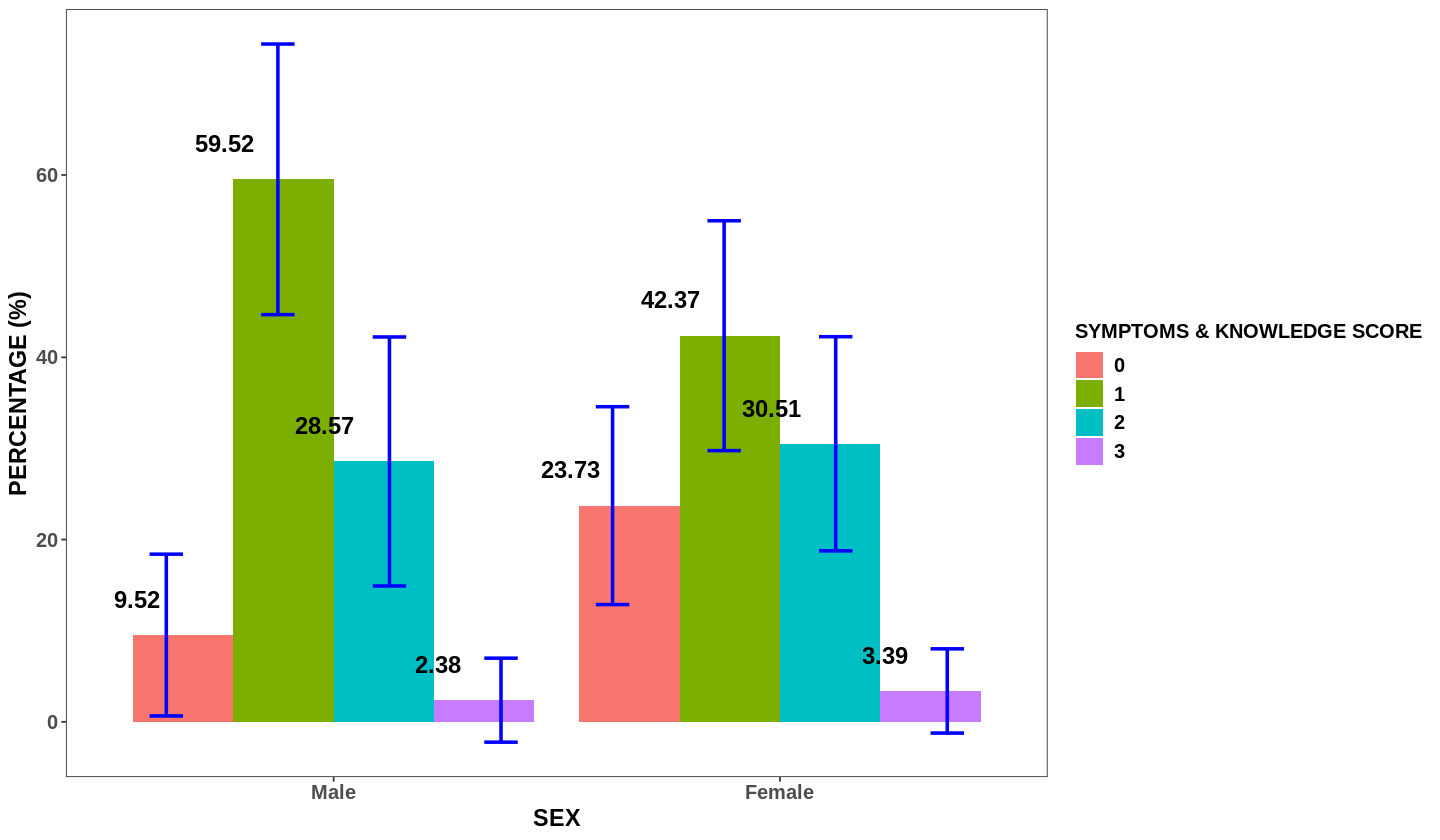



-------------------------------------------


-------------------------------------------
AGE CATEGORICAL

-------------------------------------------


AGECAT     Freq % Freq   
1 18 to 35    31   30.69307
2 35 to 60    57   56.43564
3 60 & above  13   12.87129
4 Total      101  100.00000

18 to 35      35 to 60      60 & above    Total        
0     5 [ 4.95% ]   12 [ 11.88% ] 1 [ 0.99% ]   18 [ 17.82% ]
1     22 [ 21.78% ] 21 [ 20.79% ] 7 [ 6.93% ]   50 [ 49.5% ] 
2     3 [ 2.97% ]   22 [ 21.78% ] 5 [ 4.95% ]   30 [ 29.7% ] 
3     1 [ 0.99% ]   2 [ 1.98% ]   0 [ 0% ]      3 [ 2.97% ]  
Total 31 [ 30.69% ] 57 [ 56.44% ] 13 [ 12.87% ] 101 [ 100% ]

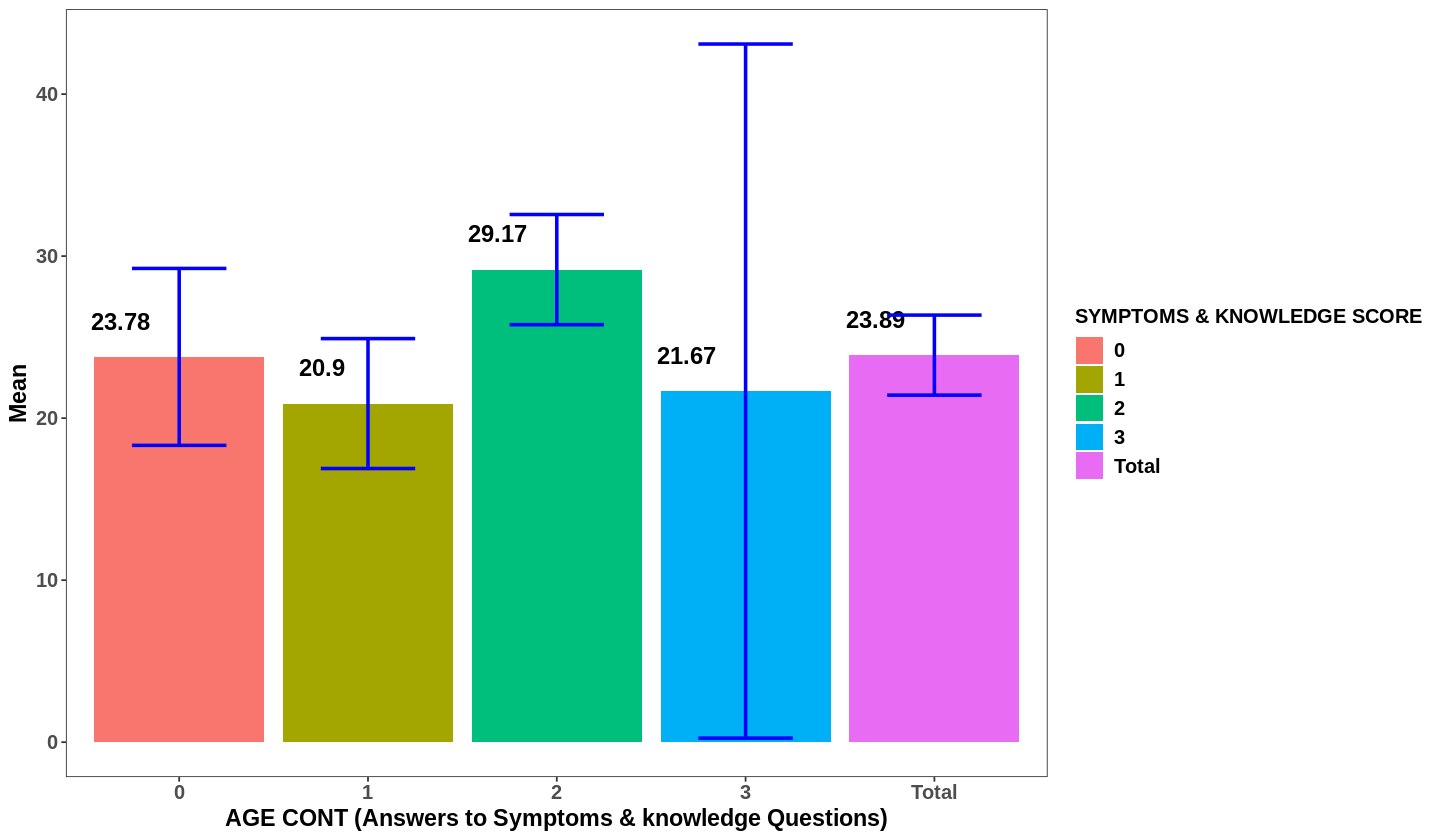



-------------------------------------------


-------------------------------------------
EDUCATION

-------------------------------------------


A5                  Freq % Freq    
1 No formal education   9    8.910891
2 Primary              15   14.851485
3 Secondary            57   56.435644
4 Post Secondary       20   19.801980
5 Total               101  100.000000

No formal education Primary       Secondary     Post Secondary
0     1 [ 0.99% ]         4 [ 3.96% ]   8 [ 7.92% ]   5 [ 4.95% ]   
1     5 [ 4.95% ]         7 [ 6.93% ]   29 [ 28.71% ] 9 [ 8.91% ]   
2     3 [ 2.97% ]         4 [ 3.96% ]   18 [ 17.82% ] 5 [ 4.95% ]   
3     0 [ 0% ]            0 [ 0% ]      2 [ 1.98% ]   1 [ 0.99% ]   
Total 9 [ 8.91% ]         15 [ 14.85% ] 57 [ 56.44% ] 20 [ 19.8% ]  
      Total        
0     18 [ 17.82% ]
1     50 [ 49.5% ] 
2     30 [ 29.7% ] 
3     3 [ 2.97% ]  
Total 101 [ 100% ]

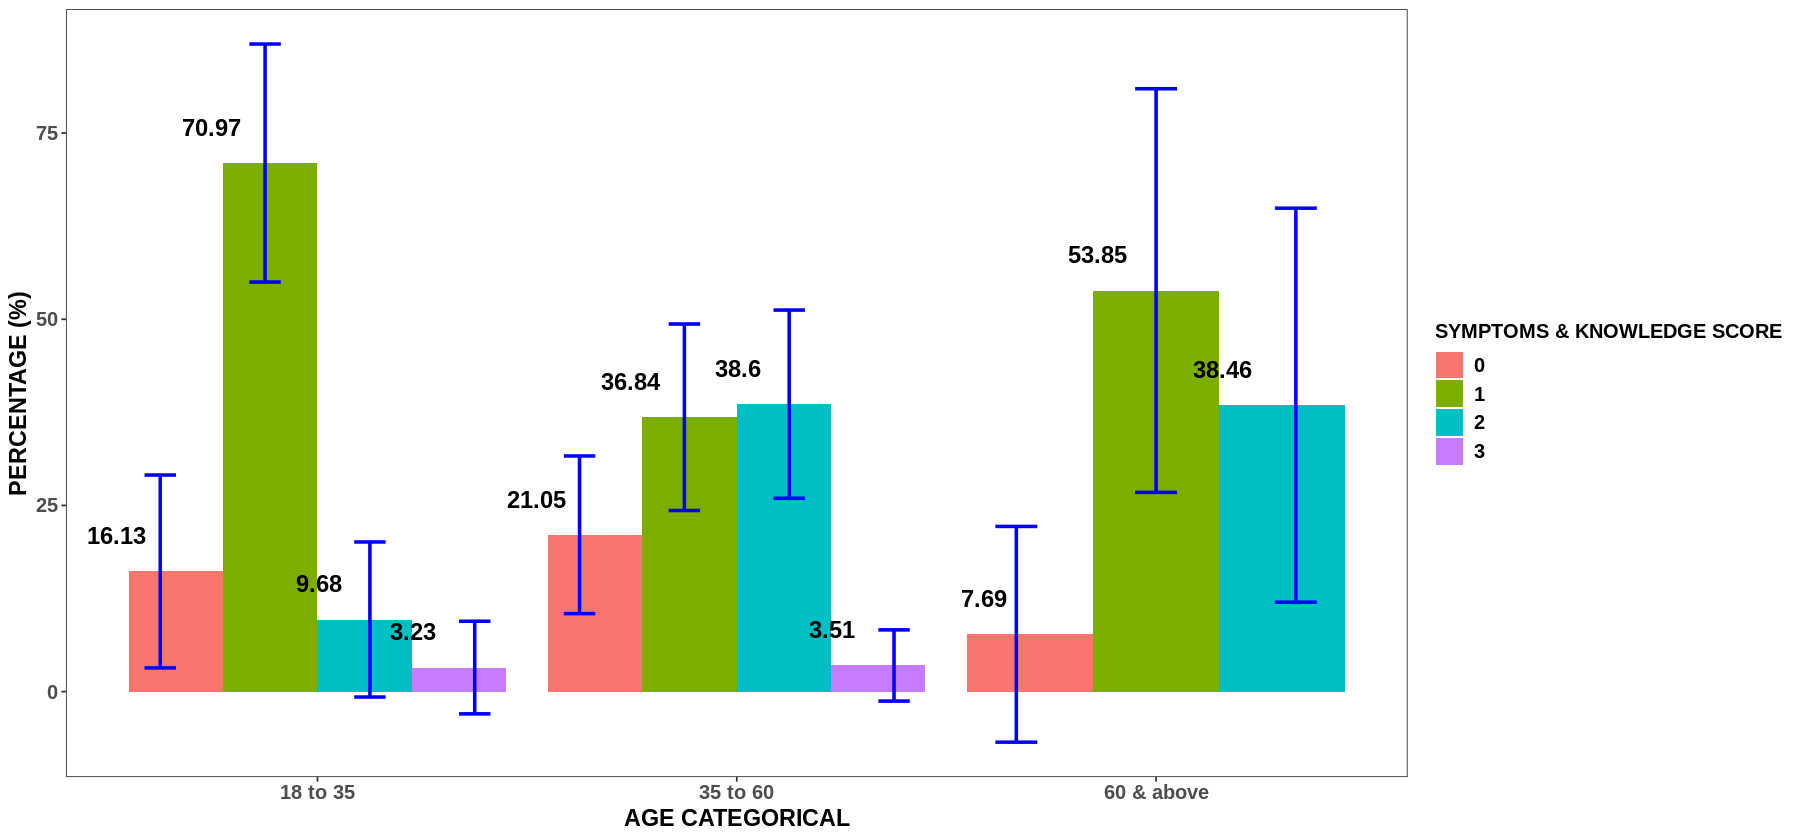



-------------------------------------------


-------------------------------------------
OCCUPATION

-------------------------------------------


A6             Freq % Freq    
1  Unemployed       4    3.960396
2  Housewife        1    0.990099
3  Farming         18   17.821782
4  Trading         36   35.643564
5  Artisan         16   15.841584
6  Public Sector   12   11.881188
7  Private Sector   2    1.980198
8  Retired          4    3.960396
9  Student          8    7.920792
10 Total          101  100.000000

Unemployed  Housewife   Farming       Trading       Artisan      
0     0 [ 0% ]    1 [ 0.99% ] 6 [ 5.94% ]   6 [ 5.94% ]   2 [ 1.98% ]  
1     3 [ 2.97% ] 0 [ 0% ]    4 [ 3.96% ]   16 [ 15.84% ] 10 [ 9.9% ]  
2     1 [ 0.99% ] 0 [ 0% ]    7 [ 6.93% ]   13 [ 12.87% ] 4 [ 3.96% ]  
3     0 [ 0% ]    0 [ 0% ]    1 [ 0.99% ]   1 [ 0.99% ]   0 [ 0% ]     
Total 4 [ 3.96% ] 1 [ 0.99% ] 18 [ 17.82% ] 36 [ 35.64% ] 16 [ 15.84% ]
      Public Sector Private Sector Retired     Student     Total        
0     2 [ 1.98% ]   0 [ 0% ]       0 [ 0% ]    1 [ 0.99% ] 18 [ 17.82% ]
1     5 [ 4.95% ]   2 [ 1.98% ]    3 [ 2.97% ] 7 [ 6.93% ] 50 [ 49.5% ] 
2     4 [ 3.96% ]   0 [ 0% ]       1 [ 0.99% ] 0 [ 0% ]    30 [ 29.7% ] 
3     1 [ 0.99% ]   0 [ 0% ]       0 [ 0% ]    0 [ 0% ]    3 [ 2.97% ]  
Total 12 [ 11.88% ] 2 [ 1.98% ]    4 [ 3.96% ] 8 [ 7.92% ] 101 [ 100% ]

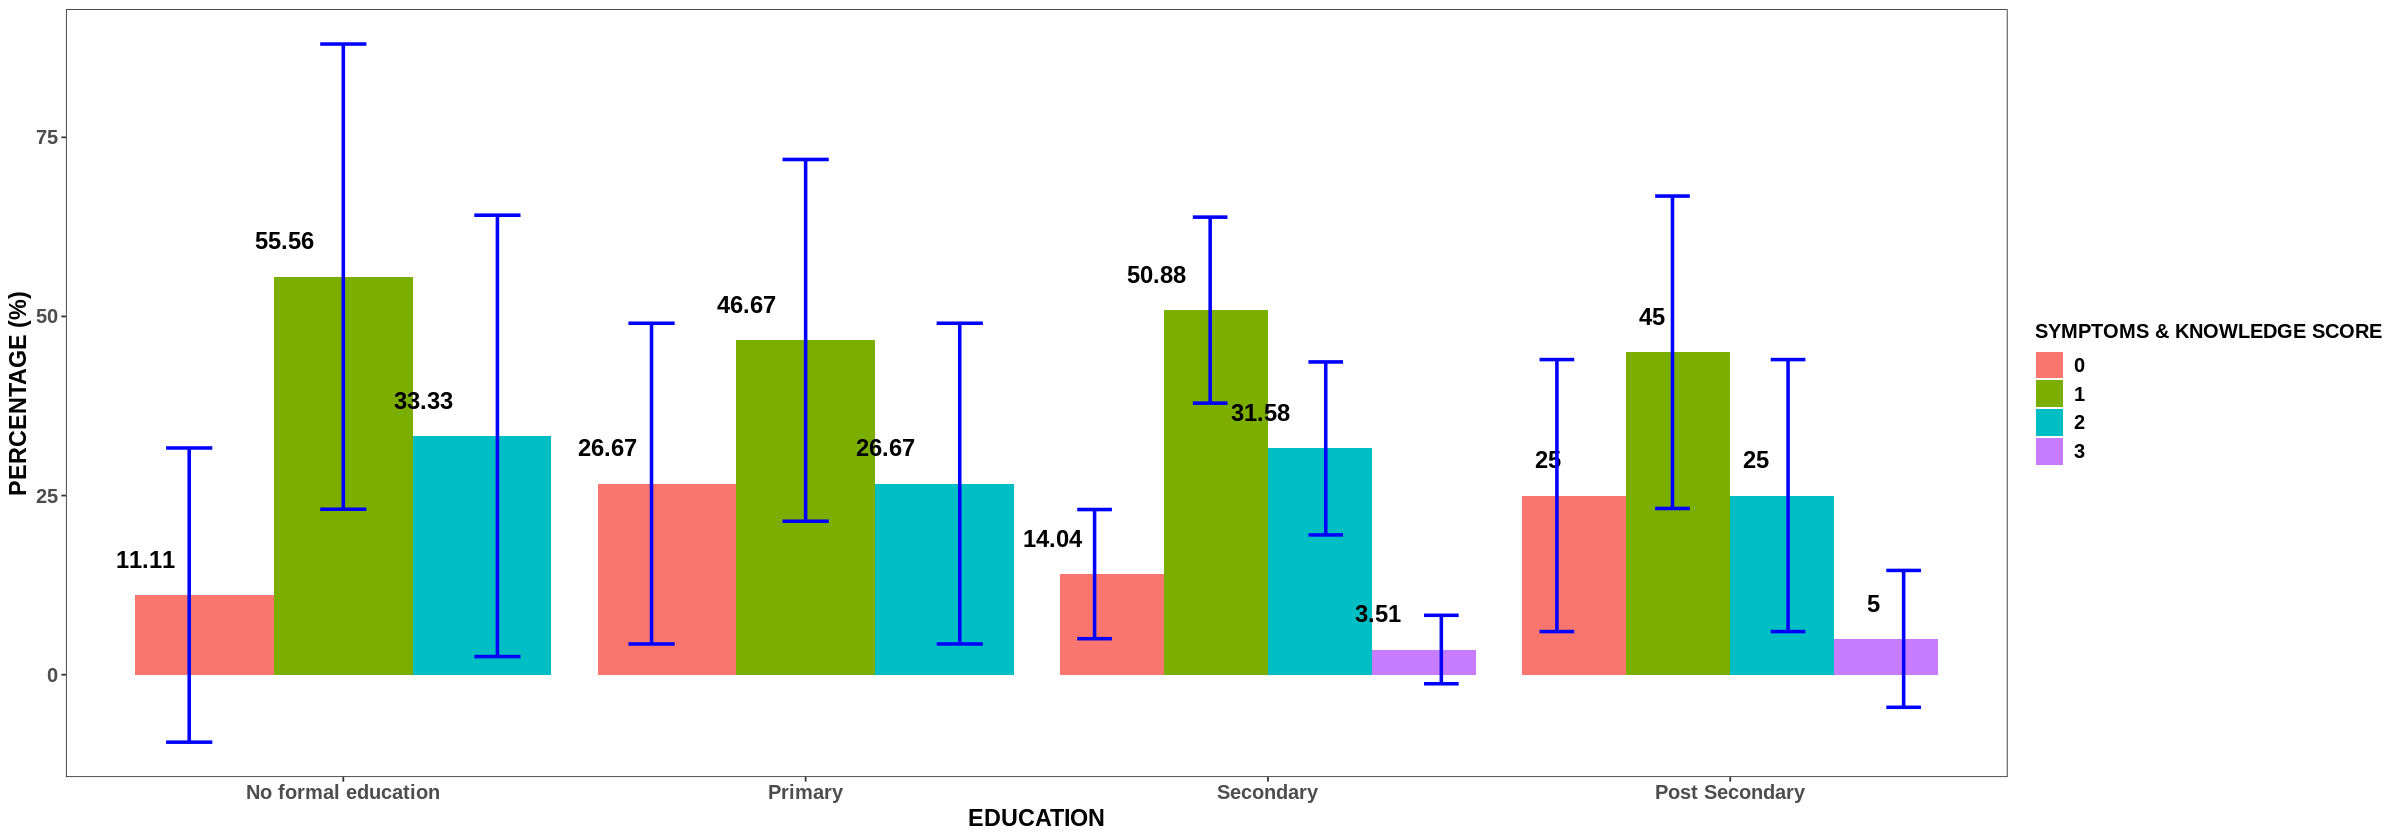



-------------------------------------------


-------------------------------------------
ACCOMODATION

-------------------------------------------


B13                              Freq % Freq    
1 A whole family house              26   25.742574
2 Duplex                             6    5.940594
3 Two/three bedroom flat            16   15.841584
4 Mini flat/self-contain apartment  32   31.683168
5 Room and parlour                  21   20.792079
6 Single room                        0    0.000000
7 Wood & makeshift structure         0    0.000000
8 Total                            101  100.000000

A whole family house Duplex      Two/three bedroom flat
0     4 [ 3.96% ]          3 [ 2.97% ] 1 [ 0.99% ]           
1     11 [ 10.89% ]        1 [ 0.99% ] 11 [ 10.89% ]         
2     10 [ 9.9% ]          2 [ 1.98% ] 4 [ 3.96% ]           
3     1 [ 0.99% ]          0 [ 0% ]    0 [ 0% ]              
Total 26 [ 25.74% ]        6 [ 5.94% ] 16 [ 15.84% ]         
      Mini flat/self-contain apartment Room and parlour Single room
0     8 [ 7.92% ]                      2 [ 1.98% ]      0 [ 0% ]   
1     16 [ 15.84% ]                    11 [ 10.89% ]    0 [ 0% ]   
2     7 [ 6.93% ]                      7 [ 6.93% ]      0 [ 0% ]   
3     1 [ 0.99% ]                      1 [ 0.99% ]      0 [ 0% ]   
Total 32 [ 31.68% ]                    21 [ 20.79% ]    0 [ 0% ]   
      Wood & makeshift structure Total        
0     0 [ 0% ]                   18 [ 17.82% ]
1     0 [ 0% ]                   50 [ 49.5% ] 
2     0 [ 0% ]                   30 [ 29.7% ] 
3     0 [ 0% ]                   3 [ 2.97% ]  
Total 0 [ 0% ]                   101 [ 100% ]

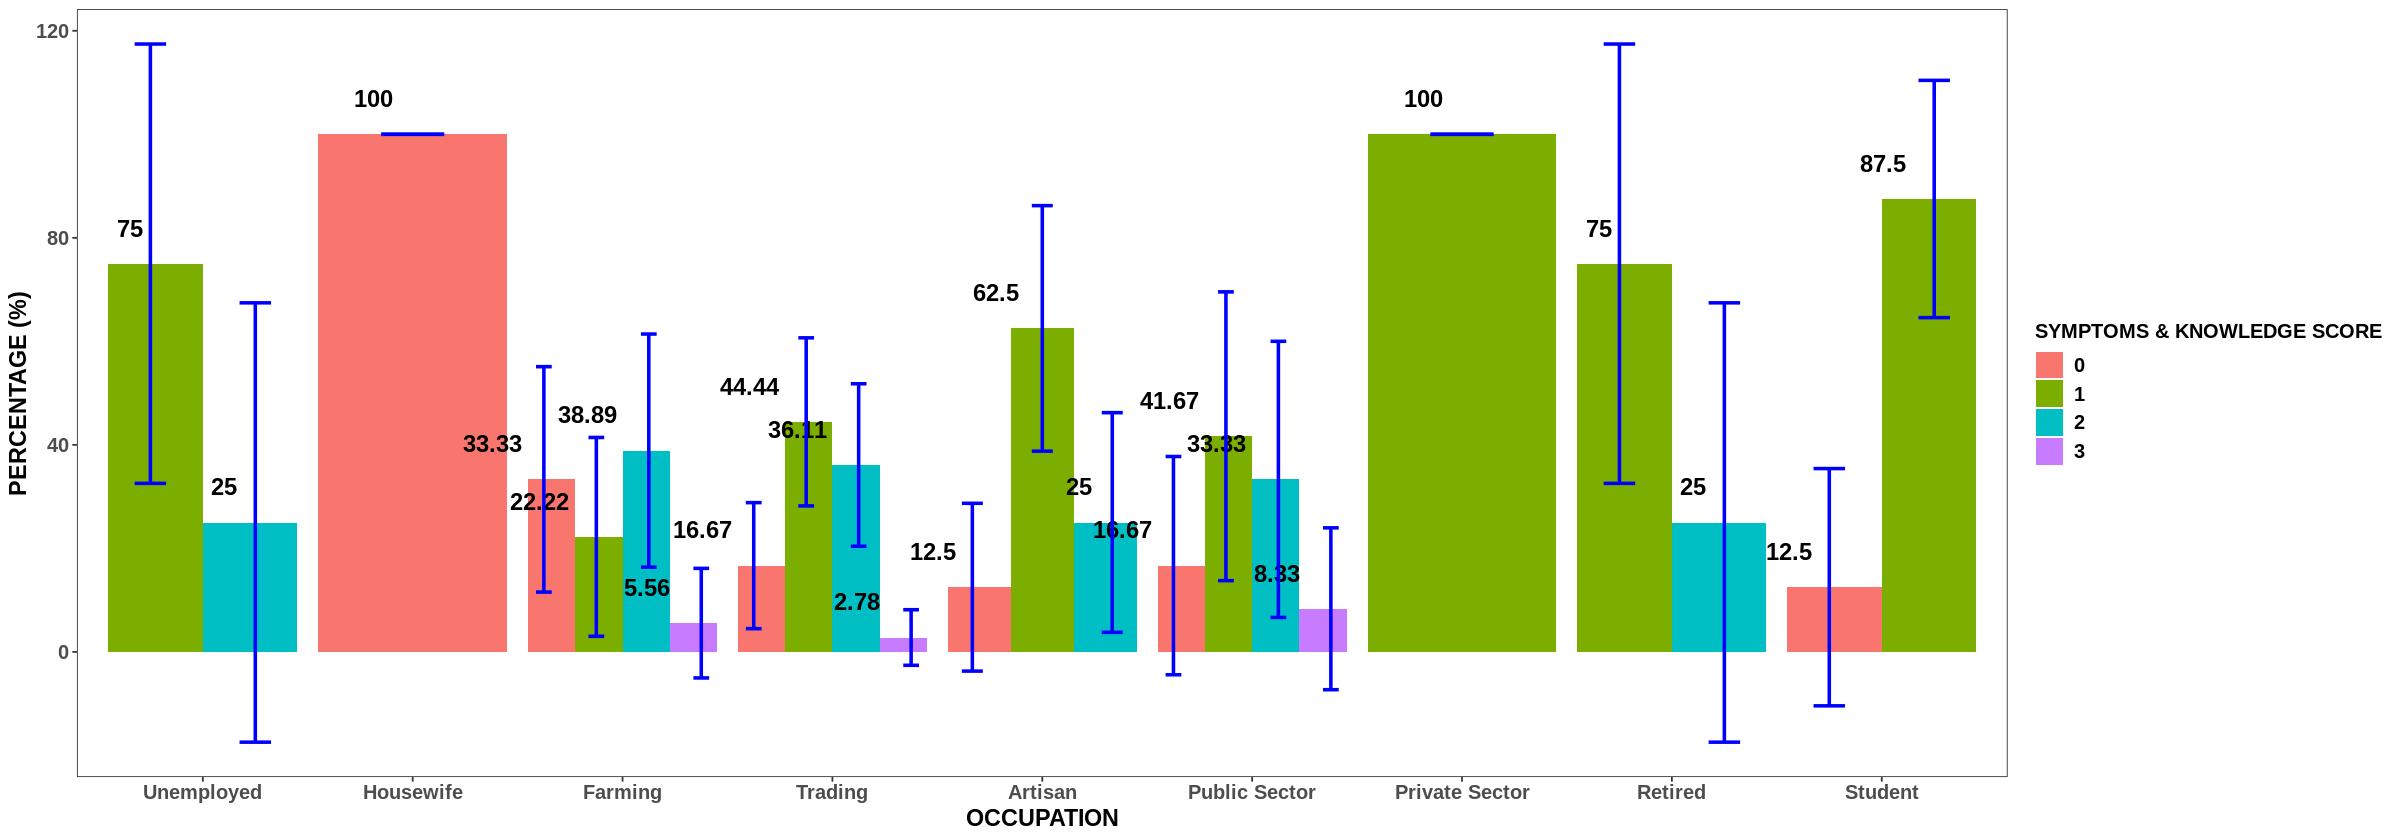



-------------------------------------------


-------------------------------------------
EDUCATION MODIFIED

-------------------------------------------


A5MUT             Freq % Freq   
1 Secondary & Above  77   76.23762
2 Pre Secondary      24   23.76238
3 Total             101  100.00000

Secondary & Above Pre Secondary Total        
0     13 [ 12.87% ]     5 [ 4.95% ]   18 [ 17.82% ]
1     38 [ 37.62% ]     12 [ 11.88% ] 50 [ 49.5% ] 
2     23 [ 22.77% ]     7 [ 6.93% ]   30 [ 29.7% ] 
3     3 [ 2.97% ]       0 [ 0% ]      3 [ 2.97% ]  
Total 77 [ 76.24% ]     24 [ 23.76% ] 101 [ 100% ]

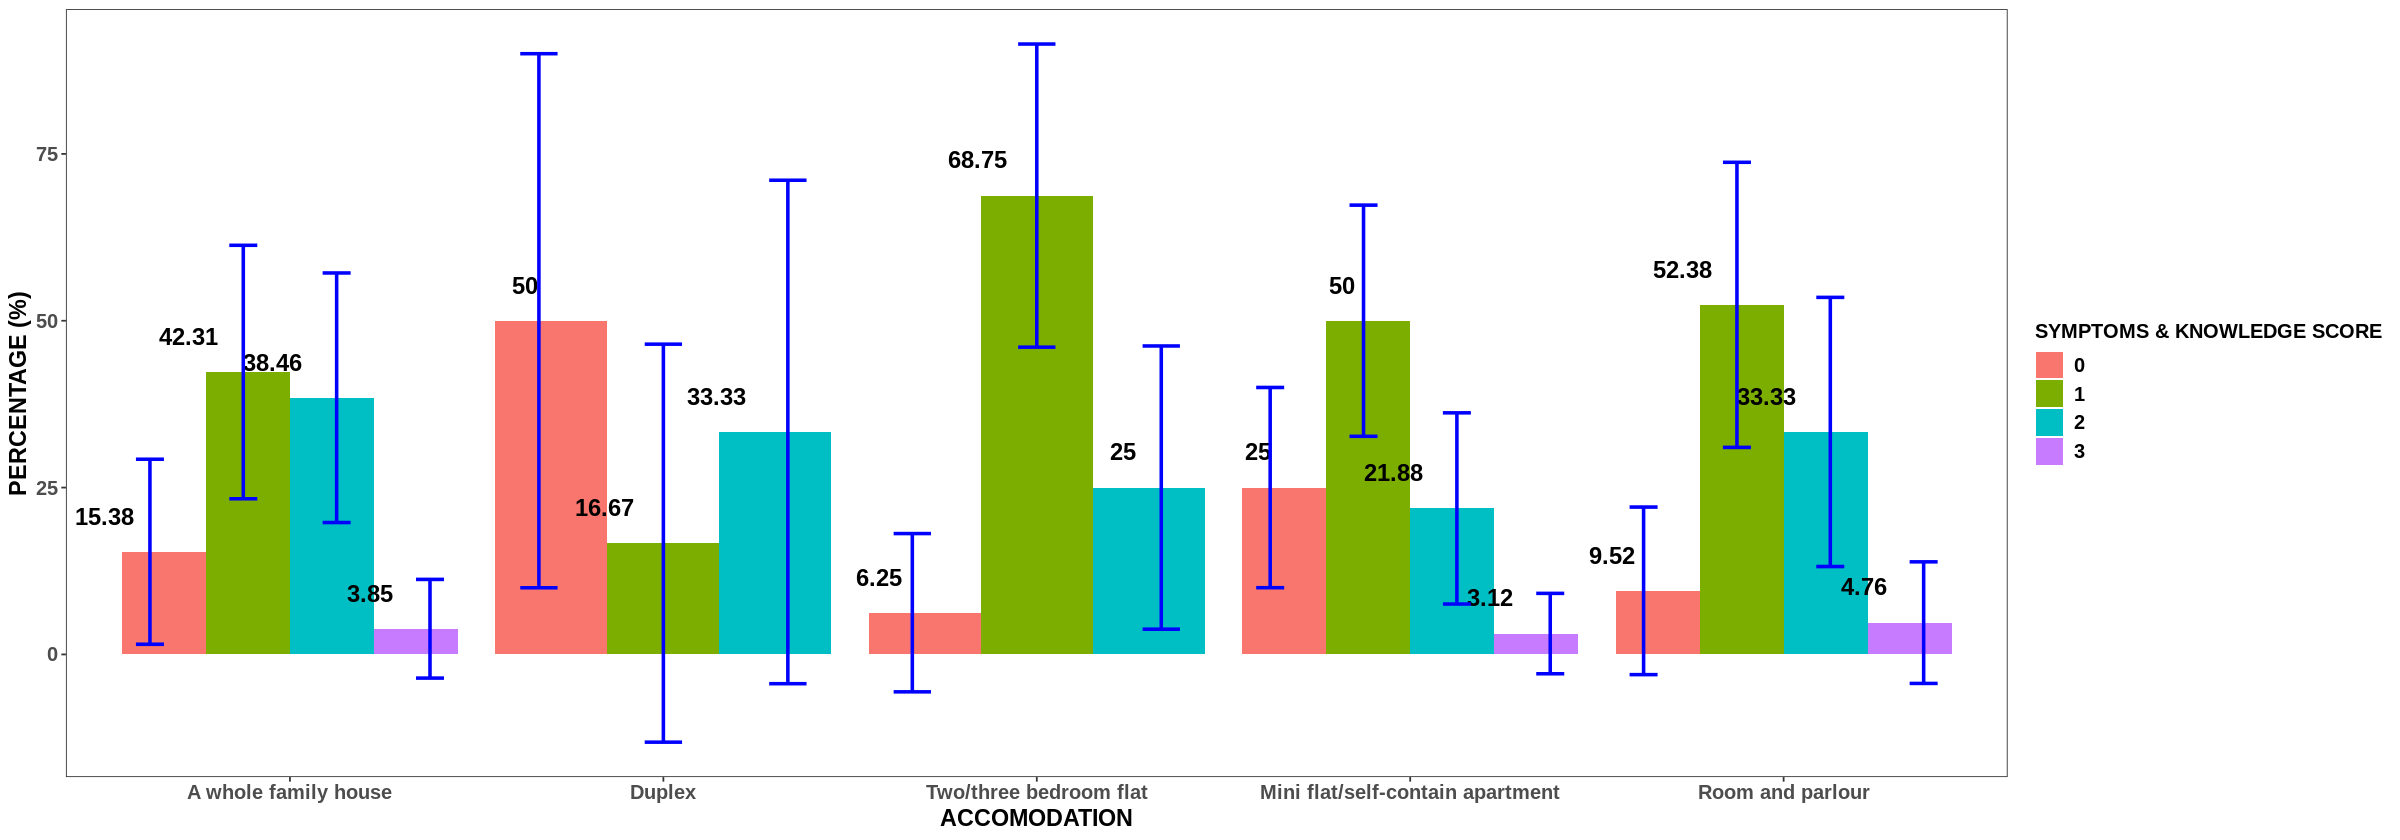



-------------------------------------------


-------------------------------------------
OCCUPATION MODIFIED

-------------------------------------------


A6MUT                  Freq % Freq    
1 Blue Collar             70   69.306931
2 White Collar            18   17.821782
3 Student                  8    7.920792
4 Unemployed & Housewife   5    4.950495
5 Total                  101  100.000000

Blue Collar   White Collar  Student     Unemployed & Housewife
0     14 [ 13.86% ] 2 [ 1.98% ]   1 [ 0.99% ] 1 [ 0.99% ]           
1     30 [ 29.7% ]  10 [ 9.9% ]   7 [ 6.93% ] 3 [ 2.97% ]           
2     24 [ 23.76% ] 5 [ 4.95% ]   0 [ 0% ]    1 [ 0.99% ]           
3     2 [ 1.98% ]   1 [ 0.99% ]   0 [ 0% ]    0 [ 0% ]              
Total 70 [ 69.31% ] 18 [ 17.82% ] 8 [ 7.92% ] 5 [ 4.95% ]           
      Total        
0     18 [ 17.82% ]
1     50 [ 49.5% ] 
2     30 [ 29.7% ] 
3     3 [ 2.97% ]  
Total 101 [ 100% ]

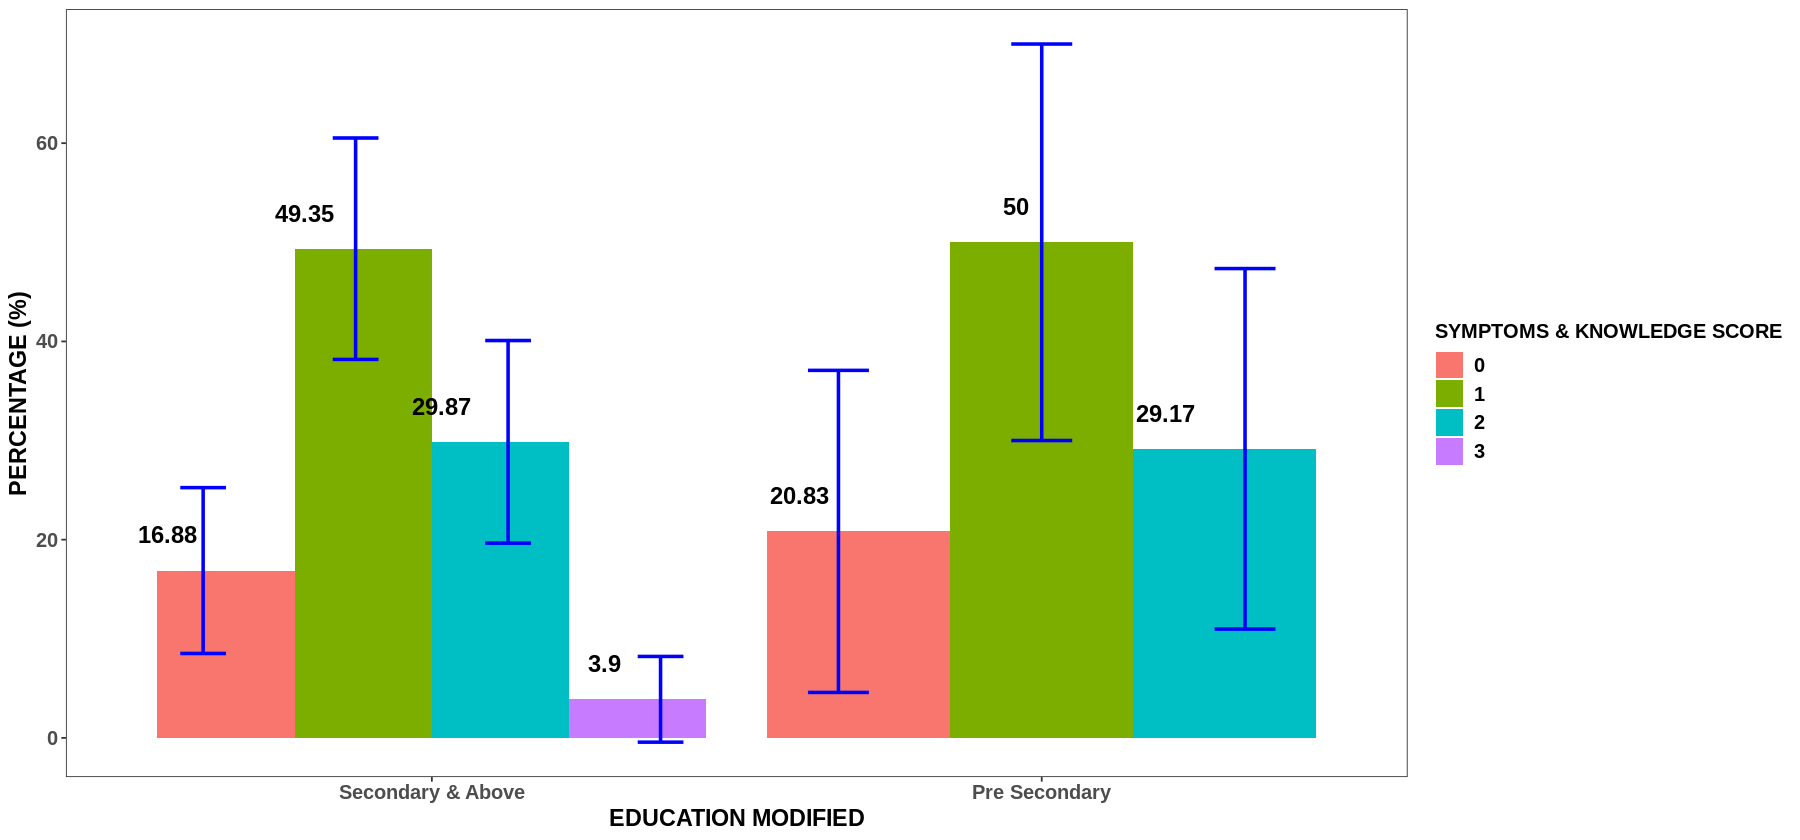



-------------------------------------------


-------------------------------------------
ACCOMODATION MODIFIED

-------------------------------------------


B13MUT       Freq % Freq   
1 Not Spacious  53   52.47525
2 Spacious      48   47.52475
3 Total        101  100.00000

Not Spacious  Spacious      Total        
0     10 [ 9.9% ]   8 [ 7.92% ]   18 [ 17.82% ]
1     27 [ 26.73% ] 23 [ 22.77% ] 50 [ 49.5% ] 
2     14 [ 13.86% ] 16 [ 15.84% ] 30 [ 29.7% ] 
3     2 [ 1.98% ]   1 [ 0.99% ]   3 [ 2.97% ]  
Total 53 [ 52.48% ] 48 [ 47.52% ] 101 [ 100% ]

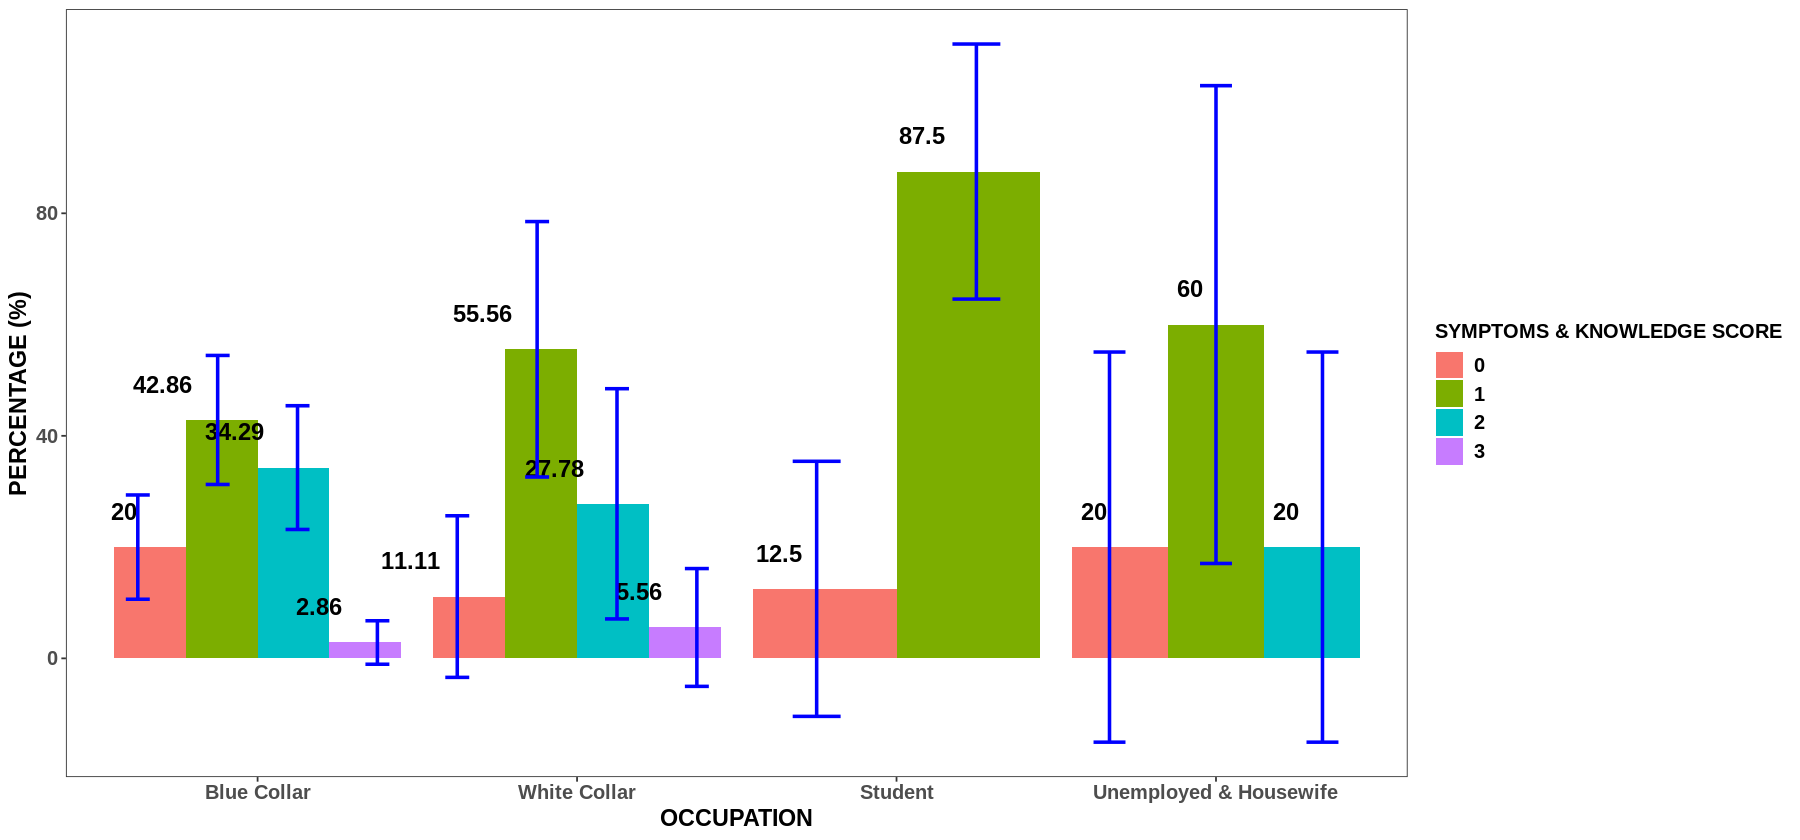

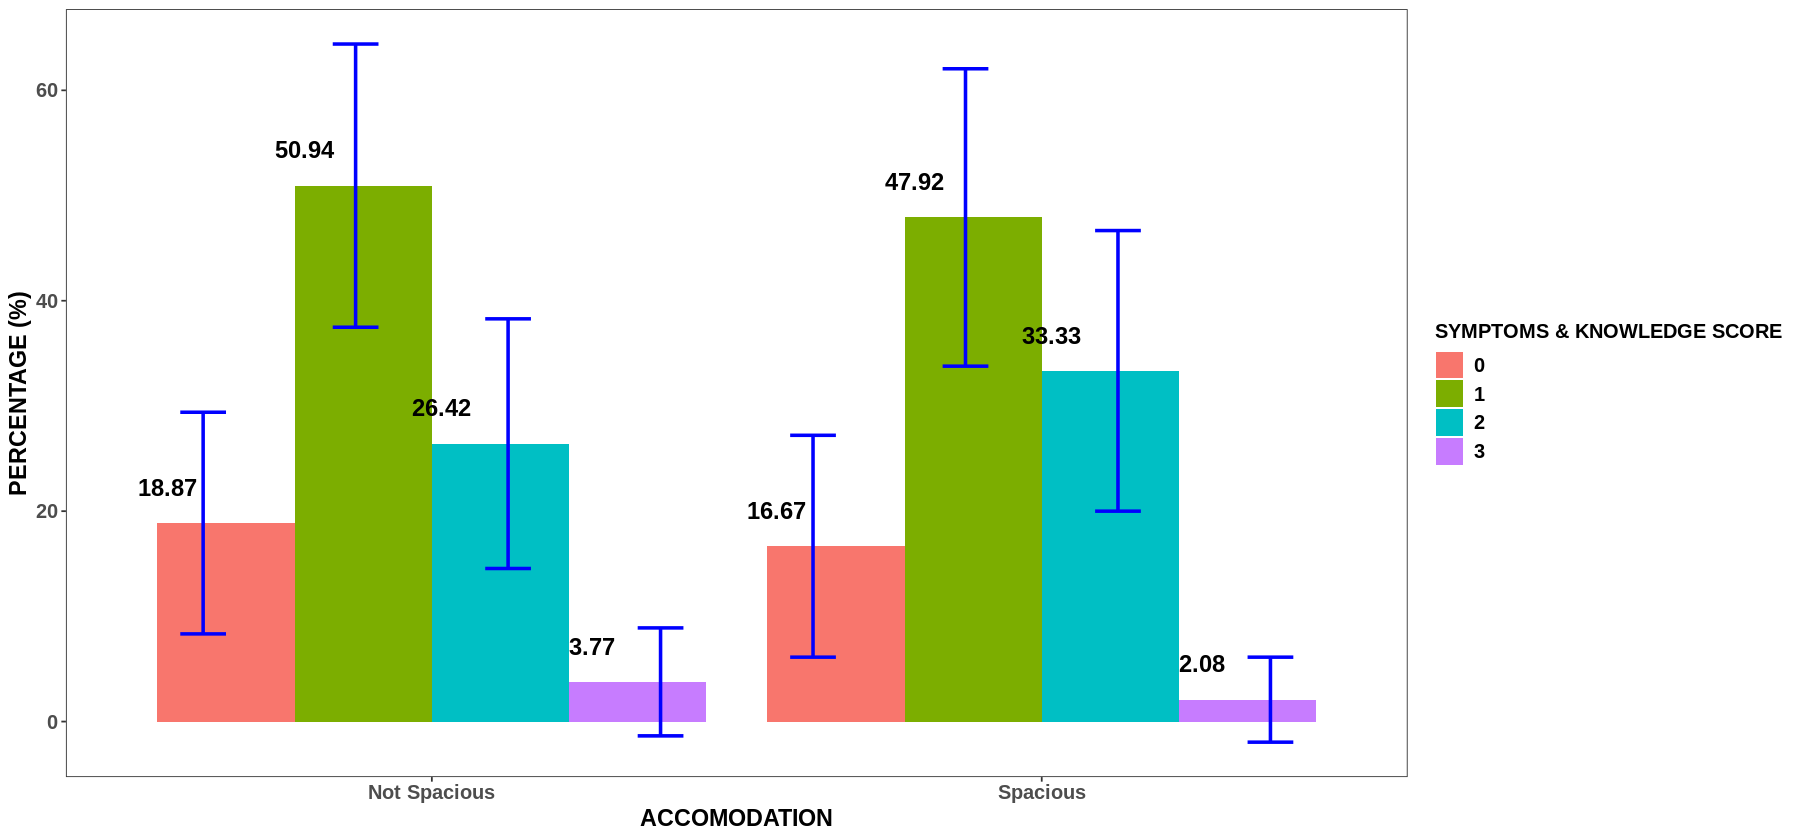

In [ ]:
fig_sizer_fn(12,7)
cat("\n\n-------------------------------------------\n")
cat("\n\n-------------------------------------------\n")

cat("SEX")
cat("\n\n-------------------------------------------\n")
analysis_df = YF_data %>% filter(is.na(Symptoms_knowledge_Score) == FALSE) %>% filter(is.na(A1) == FALSE)

analysis_df %$% freq(A1)

cat("\n\n\n")

analysis_df %$% ctable_fn(x = Symptoms_knowledge_Score, y = A1)

cat("\n\n\n")

#============================================================

analysis_CI_cat_df = analysis_df %>% select(Symptoms_knowledge_Score, A1) %>% group_by(A1, Symptoms_knowledge_Score) %>%
  summarise(Count = n(), .groups = 'drop') %>% 

  mutate(OverallPercentage = Count/sum(.$Count) ) %>%
  mutate( OverallPercentage = round(OverallPercentage,4) * 100) %>%
  
  group_by(A1) %>% mutate(WithinGroupSum = sum(Count)) %>%
  group_by(Symptoms_knowledge_Score, .add=TRUE) %>%
  mutate(Percentage = Count/WithinGroupSum , Lower_CI = Percentage - 1.96 * sqrt( Percentage * {1 - Percentage} / WithinGroupSum), Upper_CI = Percentage + 1.96 * sqrt( Percentage * {1 - Percentage} / WithinGroupSum)) %>%
  mutate( Percentage = round(Percentage, 4) * 100, Lower_CI  = round(Lower_CI, 4) * 100, Upper_CI = round(Upper_CI,4) * 100)

ggplot(analysis_CI_cat_df, aes(x = factor(A1), y = Percentage, fill = factor(Symptoms_knowledge_Score))) +
  geom_bar(position="dodge", stat="identity", width = 0.9) +
   geom_text(aes(label = Percentage), position = position_dodge(0.9), hjust = 1.5, vjust = -1.6, fontface = "bold", size = 5) +
  labs(x = "SEX", y = "PERCENTAGE (%)", fill = "SYMPTOMS & KNOWLEDGE SCORE") +  
      geom_errorbar(aes(ymin = Lower_CI, ymax = Upper_CI), width = 0.3 , position = position_dodge(width = 1), color = "blue", size = 1)    +
  theme_minimal(base_size = 18)+
  theme_bw() +
  theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank()) +
  theme(legend.text=element_text(size = 12, face = "bold"), legend.title = element_text(size=12 , face = "bold"), axis.text=element_text(size=12, face="bold"),
        axis.title=element_text(size=14, face="bold"), plot.title = element_text(hjust = 0.5, size = 16, face = "bold"))



cat("\n\n-------------------------------------------\n")
cat("\n\n-------------------------------------------\n")

cat("AGE CONTINUOUS")
cat("\n\n-------------------------------------------\n")

analysis_df = YF_data %>% filter(is.na(Symptoms_knowledge_Score) == FALSE) %>% filter(is.na(A2) == FALSE)

cat(paste0("\n\n Number of missing observation is: ", nrow(YF_data) - nrow(analysis_df), " out of ", nrow(YF_data), "\n"))
#=======================================================================

analysis_df = analysis_df %>% select(c(A2, Symptoms_knowledge_Score ))
analysis_df = analysis_df[complete.cases(analysis_df),]

analysis_df$A2 = as.numeric(analysis_df$A2)

cat("\n\n")

#=======================================================================

analysis_CI_cont_df1 = analysis_df %>% group_by(Symptoms_knowledge_Score) %>%
                       summarise(Count = n(), Mean = mean(A2, na.rm=TRUE), Min = quantile(A2, 0, na.rm=TRUE), Q1 = quantile(A2, 0.25, na.rm=TRUE), 
                       Q2 = quantile(A2, 0.5, na.rm=TRUE),  Q3 = quantile(A2, 0.75, na.rm=TRUE), Max = quantile(A2, 1, na.rm=TRUE),
                       Sd = sd(A2, na.rm=TRUE), .groups = 'drop') %>%
                       mutate( Margin_Error = {Sd/sqrt(Count)} * qt(1-0.05/2, Count - 1)  ) %>% mutate(Mean = round(Mean, 2),  Margin_Error = round(Margin_Error, 2) )
analysis_CI_cont_df1$Symptoms_knowledge_Score = as.character(analysis_CI_cont_df1$Symptoms_knowledge_Score)

analysis_CI_cont_df2 = analysis_df %>%
                       summarise(Symptoms_knowledge_Score =  "Total", Count = n(), Mean = mean(A2, na.rm=TRUE), Min = quantile(A2, 0, na.rm=TRUE), Q1 = quantile(A2, 0.25, na.rm=TRUE), 
                       Q2 = quantile(A2, 0.5, na.rm=TRUE),  Q3 = quantile(A2, 0.75, na.rm=TRUE), Max = quantile(A2, 1, na.rm=TRUE),
                       Sd = sd(A2, na.rm=TRUE), .groups = 'drop') %>%
                       mutate( Margin_Error = {Sd/sqrt(Count)} * qt(1-0.05/2, Count - 1)  ) %>% mutate(Mean = round(Mean, 2),  Margin_Error = round(Margin_Error, 2) )

analysis_CI_cont_df = rbind(analysis_CI_cont_df1, analysis_CI_cont_df2)

analysis_CI_cont_df 

#================================================================


ggplot(analysis_CI_cont_df, aes(x = factor(Symptoms_knowledge_Score), y = Mean , fill = factor(Symptoms_knowledge_Score))) +
  geom_bar(position="dodge", stat="identity", width = 0.9) +
  labs(x = "AGE CONT (Answers to Symptoms & knowledge Questions)", y = "Mean", fill = "SYMPTOMS & KNOWLEDGE SCORE") +  
       geom_text(aes(label = Mean), position = position_dodge(0.9), hjust = 1.5, vjust = -1.6, fontface = "bold", size = 5) +
      geom_errorbar(aes(ymin = Mean  - Margin_Error, ymax = Mean + Margin_Error), width = 0.5, position = position_dodge(width = 0.5), color="blue", size=1)    +
  theme_minimal(base_size = 18)+
  theme_bw() +
  theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank()) +
  theme(legend.text=element_text(size = 12, face = "bold"), legend.title = element_text(size=12 , face = "bold"), axis.text=element_text(size=12, face="bold"),
        axis.title=element_text(size=14, face="bold"), plot.title = element_text(hjust = 0.5, size = 16, face = "bold"))






cat("\n\n-------------------------------------------\n")
cat("\n\n-------------------------------------------\n")

cat("AGE CATEGORICAL")
cat("\n\n-------------------------------------------\n")

analysis_df = YF_data %>% filter(is.na(Symptoms_knowledge_Score) == FALSE) %>% filter(is.na(AGECAT) == FALSE)

analysis_df %$% freq(AGECAT)

cat("\n\n\n")

analysis_df %$% ctable_fn(x = Symptoms_knowledge_Score, y = AGECAT)


#============================================================

analysis_CI_cat_df = analysis_df %>% select(Symptoms_knowledge_Score, AGECAT) %>% group_by(AGECAT, Symptoms_knowledge_Score) %>%
  summarise(Count = n(), .groups = 'drop') %>% 

  mutate(OverallPercentage = Count/sum(.$Count) ) %>%
  mutate( OverallPercentage = round(OverallPercentage,4) * 100) %>%
  
  group_by(AGECAT) %>% mutate(WithinGroupSum = sum(Count)) %>%
  group_by(Symptoms_knowledge_Score, .add=TRUE) %>%
  mutate(Percentage = Count/WithinGroupSum , Lower_CI = Percentage - 1.96 * sqrt( Percentage * {1 - Percentage} / WithinGroupSum), Upper_CI = Percentage + 1.96 * sqrt( Percentage * {1 - Percentage} / WithinGroupSum)) %>%
  mutate( Percentage = round(Percentage, 4) * 100, Lower_CI  = round(Lower_CI, 4) * 100, Upper_CI = round(Upper_CI,4) * 100)
fig_sizer_fn(15, 7)
ggplot(analysis_CI_cat_df, aes(x = factor(AGECAT), y = Percentage, fill = factor(Symptoms_knowledge_Score))) +
  geom_bar(position="dodge", stat="identity", width = 0.9) +
   geom_text(aes(label = Percentage), position = position_dodge(0.9), hjust = 1.5, vjust = -1.6, fontface = "bold", size = 5) +
  labs(x = "AGE CATEGORICAL", y = "PERCENTAGE (%)", fill = "SYMPTOMS & KNOWLEDGE SCORE") +  
      geom_errorbar(aes(ymin = Lower_CI, ymax = Upper_CI), width = 0.3 , position = position_dodge(width = 1), color = "blue", size = 1)    +
  theme_minimal(base_size = 18)+
  theme_bw() +
  theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank()) +
  theme(legend.text=element_text(size = 12, face = "bold"), legend.title = element_text(size=12 , face = "bold"), axis.text=element_text(size=12, face="bold"),
        axis.title=element_text(size=14, face="bold"), plot.title = element_text(hjust = 0.5, size = 16, face = "bold"))



cat("\n\n-------------------------------------------\n")
cat("\n\n-------------------------------------------\n")

cat("EDUCATION")
cat("\n\n-------------------------------------------\n")

analysis_df = YF_data %>% filter(is.na(Symptoms_knowledge_Score) == FALSE) %>% filter(is.na(A5) == FALSE)

analysis_df %$% freq(A5)

cat("\n\n\n")

analysis_df %$% ctable_fn(x = Symptoms_knowledge_Score, y = A5)


#============================================================

analysis_CI_cat_df = analysis_df %>% select(Symptoms_knowledge_Score, A5) %>% group_by(A5, Symptoms_knowledge_Score) %>%
  summarise(Count = n(), .groups = 'drop') %>% 

  mutate(OverallPercentage = Count/sum(.$Count) ) %>%
  mutate( OverallPercentage = round(OverallPercentage,4) * 100) %>%
  
  group_by(A5) %>% mutate(WithinGroupSum = sum(Count)) %>%
  group_by(Symptoms_knowledge_Score, .add=TRUE) %>%
  mutate(Percentage = Count/WithinGroupSum , Lower_CI = Percentage - 1.96 * sqrt( Percentage * {1 - Percentage} / WithinGroupSum), Upper_CI = Percentage + 1.96 * sqrt( Percentage * {1 - Percentage} / WithinGroupSum)) %>%
  mutate( Percentage = round(Percentage, 4) * 100, Lower_CI  = round(Lower_CI, 4) * 100, Upper_CI = round(Upper_CI,4) * 100)

fig_sizer_fn(20, 7)

ggplot(analysis_CI_cat_df, aes(x = factor(A5), y = Percentage, fill = factor(Symptoms_knowledge_Score))) +
  geom_bar(position="dodge", stat="identity", width = 0.9) +
   geom_text(aes(label = Percentage), position = position_dodge(0.9), hjust = 1.5, vjust = -1.6, fontface = "bold", size = 5) +
  labs(x = "EDUCATION", y = "PERCENTAGE (%)", fill = "SYMPTOMS & KNOWLEDGE SCORE") +  
      geom_errorbar(aes(ymin = Lower_CI, ymax = Upper_CI), width = 0.3 , position = position_dodge(width = 1), color = "blue", size = 1)    +
  theme_minimal(base_size = 18)+
  theme_bw() +
  theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank()) +
  theme(legend.text=element_text(size = 12, face = "bold"), legend.title = element_text(size=12 , face = "bold"), axis.text=element_text(size=12, face="bold"),
        axis.title=element_text(size=14, face="bold"), plot.title = element_text(hjust = 0.5, size = 16, face = "bold"))



cat("\n\n-------------------------------------------\n")
cat("\n\n-------------------------------------------\n")

cat("OCCUPATION")
cat("\n\n-------------------------------------------\n")

analysis_df = YF_data %>% filter(is.na(Symptoms_knowledge_Score) == FALSE) %>% filter(is.na(A6) == FALSE)

analysis_df %$% freq(A6)

cat("\n\n\n")

analysis_df %$% ctable_fn(x = Symptoms_knowledge_Score, y = A6)


#============================================================

analysis_CI_cat_df = analysis_df %>% select(Symptoms_knowledge_Score, A6) %>% group_by(A6, Symptoms_knowledge_Score) %>%
  summarise(Count = n(), .groups = 'drop') %>% 

  mutate(OverallPercentage = Count/sum(.$Count) ) %>%
  mutate( OverallPercentage = round(OverallPercentage,4) * 100) %>%
  
  group_by(A6) %>% mutate(WithinGroupSum = sum(Count)) %>%
  group_by(Symptoms_knowledge_Score, .add=TRUE) %>%
  mutate(Percentage = Count/WithinGroupSum , Lower_CI = Percentage - 1.96 * sqrt( Percentage * {1 - Percentage} / WithinGroupSum), Upper_CI = Percentage + 1.96 * sqrt( Percentage * {1 - Percentage} / WithinGroupSum)) %>%
  mutate( Percentage = round(Percentage, 4) * 100, Lower_CI  = round(Lower_CI, 4) * 100, Upper_CI = round(Upper_CI,4) * 100)

fig_sizer_fn(20, 7)

ggplot(analysis_CI_cat_df, aes(x = factor(A6), y = Percentage, fill = factor(Symptoms_knowledge_Score))) +
  geom_bar(position="dodge", stat="identity", width = 0.9) +
   geom_text(aes(label = Percentage), position = position_dodge(0.9), hjust = 1.5, vjust = -1.6, fontface = "bold", size = 5) +
  labs(x = "OCCUPATION", y = "PERCENTAGE (%)", fill = "SYMPTOMS & KNOWLEDGE SCORE") +  
      geom_errorbar(aes(ymin = Lower_CI, ymax = Upper_CI), width = 0.3 , position = position_dodge(width = 1), color = "blue", size = 1)    +
  theme_minimal(base_size = 18)+
  theme_bw() +
  theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank()) +
  theme(legend.text=element_text(size = 12, face = "bold"), legend.title = element_text(size=12 , face = "bold"), axis.text=element_text(size=12, face="bold"),
        axis.title=element_text(size=14, face="bold"), plot.title = element_text(hjust = 0.5, size = 16, face = "bold"))




cat("\n\n-------------------------------------------\n")
cat("\n\n-------------------------------------------\n")

cat("ACCOMODATION")
cat("\n\n-------------------------------------------\n")

analysis_df = YF_data %>% filter(is.na(Symptoms_knowledge_Score) == FALSE) %>% filter(is.na(B13) == FALSE)

analysis_df %$% freq(B13)

cat("\n\n\n")

analysis_df %$% ctable_fn(x = Symptoms_knowledge_Score, y = B13)


#============================================================

analysis_CI_cat_df = analysis_df %>% select(Symptoms_knowledge_Score, B13) %>% group_by(B13, Symptoms_knowledge_Score) %>%
  summarise(Count = n(), .groups = 'drop') %>% 

  mutate(OverallPercentage = Count/sum(.$Count) ) %>%
  mutate( OverallPercentage = round(OverallPercentage,4) * 100) %>%
  
  group_by(B13) %>% mutate(WithinGroupSum = sum(Count)) %>%
  group_by(Symptoms_knowledge_Score, .add=TRUE) %>%
  mutate(Percentage = Count/WithinGroupSum , Lower_CI = Percentage - 1.96 * sqrt( Percentage * {1 - Percentage} / WithinGroupSum), Upper_CI = Percentage + 1.96 * sqrt( Percentage * {1 - Percentage} / WithinGroupSum)) %>%
  mutate( Percentage = round(Percentage, 4) * 100, Lower_CI  = round(Lower_CI, 4) * 100, Upper_CI = round(Upper_CI,4) * 100)

fig_sizer_fn(20, 7)

ggplot(analysis_CI_cat_df, aes(x = factor(B13), y = Percentage, fill = factor(Symptoms_knowledge_Score))) +
  geom_bar(position="dodge", stat="identity", width = 0.9) +
   geom_text(aes(label = Percentage), position = position_dodge(0.9), hjust = 1.5, vjust = -1.6, fontface = "bold", size = 5) +
  labs(x = "ACCOMODATION", y = "PERCENTAGE (%)", fill = "SYMPTOMS & KNOWLEDGE SCORE") +  
      geom_errorbar(aes(ymin = Lower_CI, ymax = Upper_CI), width = 0.3 , position = position_dodge(width = 1), color = "blue", size = 1)    +
  theme_minimal(base_size = 18)+
  theme_bw() +
  theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank()) +
  theme(legend.text=element_text(size = 12, face = "bold"), legend.title = element_text(size=12 , face = "bold"), axis.text=element_text(size=12, face="bold"),
        axis.title=element_text(size=14, face="bold"), plot.title = element_text(hjust = 0.5, size = 16, face = "bold"))



#====================================================================================================================
#====================================================================================================================
#====================================================================================================================
#====================================================================================================================


fig_sizer_fn()

cat("\n\n-------------------------------------------\n")
cat("\n\n-------------------------------------------\n")

cat("EDUCATION MODIFIED")
cat("\n\n-------------------------------------------\n")

analysis_df = YF_data %>% filter(is.na(Symptoms_knowledge_Score) == FALSE) %>% filter(is.na(A5MUT) == FALSE)

analysis_df %$% freq(A5MUT)

cat("\n\n\n")

analysis_df %$% ctable_fn(x = Symptoms_knowledge_Score, y = A5MUT)


#============================================================

analysis_CI_cat_df = analysis_df %>% select(Symptoms_knowledge_Score, A5MUT) %>% group_by(A5MUT, Symptoms_knowledge_Score) %>%
  summarise(Count = n(), .groups = 'drop') %>% 

  mutate(OverallPercentage = Count/sum(.$Count) ) %>%
  mutate( OverallPercentage = round(OverallPercentage,4) * 100) %>%
  
  group_by(A5MUT) %>% mutate(WithinGroupSum = sum(Count)) %>%
  group_by(Symptoms_knowledge_Score, .add=TRUE) %>%
  mutate(Percentage = Count/WithinGroupSum , Lower_CI = Percentage - 1.96 * sqrt( Percentage * {1 - Percentage} / WithinGroupSum), Upper_CI = Percentage + 1.96 * sqrt( Percentage * {1 - Percentage} / WithinGroupSum)) %>%
  mutate( Percentage = round(Percentage, 4) * 100, Lower_CI  = round(Lower_CI, 4) * 100, Upper_CI = round(Upper_CI,4) * 100)

fig_sizer_fn(15, 7)

ggplot(analysis_CI_cat_df, aes(x = factor(A5MUT), y = Percentage, fill = factor(Symptoms_knowledge_Score))) +
  geom_bar(position="dodge", stat="identity", width = 0.9) +
   geom_text(aes(label = Percentage), position = position_dodge(0.9), hjust = 1.5, vjust = -1.6, fontface = "bold", size = 5) +
  labs(x = "EDUCATION MODIFIED", y = "PERCENTAGE (%)", fill = "SYMPTOMS & KNOWLEDGE SCORE") +  
      geom_errorbar(aes(ymin = Lower_CI, ymax = Upper_CI), width = 0.3 , position = position_dodge(width = 1), color = "blue", size = 1)    +
  theme_minimal(base_size = 18)+
  theme_bw() +
  theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank()) +
  theme(legend.text=element_text(size = 12, face = "bold"), legend.title = element_text(size=12 , face = "bold"), axis.text=element_text(size=12, face="bold"),
        axis.title=element_text(size=14, face="bold"), plot.title = element_text(hjust = 0.5, size = 16, face = "bold"))



cat("\n\n-------------------------------------------\n")
cat("\n\n-------------------------------------------\n")

cat("OCCUPATION MODIFIED")
cat("\n\n-------------------------------------------\n")

analysis_df = YF_data %>% filter(is.na(Symptoms_knowledge_Score) == FALSE) %>% filter(is.na(A6MUT) == FALSE)

analysis_df %$% freq(A6MUT)

cat("\n\n\n")

analysis_df %$% ctable_fn(x = Symptoms_knowledge_Score, y = A6MUT)


#============================================================

analysis_CI_cat_df = analysis_df %>% select(Symptoms_knowledge_Score, A6MUT) %>% group_by(A6MUT, Symptoms_knowledge_Score) %>%
  summarise(Count = n(), .groups = 'drop') %>% 

  mutate(OverallPercentage = Count/sum(.$Count) ) %>%
  mutate( OverallPercentage = round(OverallPercentage,4) * 100) %>%
  
  group_by(A6MUT) %>% mutate(WithinGroupSum = sum(Count)) %>%
  group_by(Symptoms_knowledge_Score, .add=TRUE) %>%
  mutate(Percentage = Count/WithinGroupSum , Lower_CI = Percentage - 1.96 * sqrt( Percentage * {1 - Percentage} / WithinGroupSum), Upper_CI = Percentage + 1.96 * sqrt( Percentage * {1 - Percentage} / WithinGroupSum)) %>%
  mutate( Percentage = round(Percentage, 4) * 100, Lower_CI  = round(Lower_CI, 4) * 100, Upper_CI = round(Upper_CI,4) * 100)

fig_sizer_fn(15, 7)

ggplot(analysis_CI_cat_df, aes(x = factor(A6MUT), y = Percentage, fill = factor(Symptoms_knowledge_Score))) +
  geom_bar(position="dodge", stat="identity", width = 0.9) +
   geom_text(aes(label = Percentage), position = position_dodge(0.9), hjust = 1.5, vjust = -1.6, fontface = "bold", size = 5) +
  labs(x = "OCCUPATION", y = "PERCENTAGE (%)", fill = "SYMPTOMS & KNOWLEDGE SCORE") +  
      geom_errorbar(aes(ymin = Lower_CI, ymax = Upper_CI), width = 0.3 , position = position_dodge(width = 1), color = "blue", size = 1)    +
  theme_minimal(base_size = 18)+
  theme_bw() +
  theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank()) +
  theme(legend.text=element_text(size = 12, face = "bold"), legend.title = element_text(size=12 , face = "bold"), axis.text=element_text(size=12, face="bold"),
        axis.title=element_text(size=14, face="bold"), plot.title = element_text(hjust = 0.5, size = 16, face = "bold"))




cat("\n\n-------------------------------------------\n")
cat("\n\n-------------------------------------------\n")

cat("ACCOMODATION MODIFIED")
cat("\n\n-------------------------------------------\n")

analysis_df = YF_data %>% filter(is.na(Symptoms_knowledge_Score) == FALSE) %>% filter(is.na(B13MUT) == FALSE)

analysis_df %$% freq(B13MUT)

cat("\n\n\n")

analysis_df %$% ctable_fn(x = Symptoms_knowledge_Score, y = B13MUT)


#============================================================

analysis_CI_cat_df = analysis_df %>% select(Symptoms_knowledge_Score, B13MUT) %>% group_by(B13MUT, Symptoms_knowledge_Score) %>%
  summarise(Count = n(), .groups = 'drop') %>% 

  mutate(OverallPercentage = Count/sum(.$Count) ) %>%
  mutate( OverallPercentage = round(OverallPercentage,4) * 100) %>%
  
  group_by(B13MUT) %>% mutate(WithinGroupSum = sum(Count)) %>%
  group_by(Symptoms_knowledge_Score, .add=TRUE) %>%
  mutate(Percentage = Count/WithinGroupSum , Lower_CI = Percentage - 1.96 * sqrt( Percentage * {1 - Percentage} / WithinGroupSum), Upper_CI = Percentage + 1.96 * sqrt( Percentage * {1 - Percentage} / WithinGroupSum)) %>%
  mutate( Percentage = round(Percentage, 4) * 100, Lower_CI  = round(Lower_CI, 4) * 100, Upper_CI = round(Upper_CI,4) * 100)

fig_sizer_fn(15, 7)

ggplot(analysis_CI_cat_df, aes(x = factor(B13MUT), y = Percentage, fill = factor(Symptoms_knowledge_Score))) +
  geom_bar(position="dodge", stat="identity", width = 0.9) +
   geom_text(aes(label = Percentage), position = position_dodge(0.9), hjust = 1.5, vjust = -1.6, fontface = "bold", size = 5) +
  labs(x = "ACCOMODATION", y = "PERCENTAGE (%)", fill = "SYMPTOMS & KNOWLEDGE SCORE") +  
      geom_errorbar(aes(ymin = Lower_CI, ymax = Upper_CI), width = 0.3 , position = position_dodge(width = 1), color = "blue", size = 1)    +
  theme_minimal(base_size = 18)+
  theme_bw() +
  theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank()) +
  theme(legend.text=element_text(size = 12, face = "bold"), legend.title = element_text(size=12 , face = "bold"), axis.text=element_text(size=12, face="bold"),
        axis.title=element_text(size=14, face="bold"), plot.title = element_text(hjust = 0.5, size = 16, face = "bold"))



###### ***Using high vs no score***



-------------------------------------------


-------------------------------------------
SEX

-------------------------------------------


A1     Freq % Freq   
1 Male    42   41.58416
2 Female  59   58.41584
3 Total  101  100.00000

Male          Female        Total        
0     4 [ 3.96% ]   14 [ 13.86% ] 18 [ 17.82% ]
1     38 [ 37.62% ] 45 [ 44.55% ] 83 [ 82.18% ]
Total 42 [ 41.58% ] 59 [ 58.42% ] 101 [ 100% ]






-------------------------------------------


-------------------------------------------
AGE CONTINUOUS

-------------------------------------------


 Number of missing observation is: 0 out of 101




high_Symptoms_knowledge_Score Count Mean  Min Q1   Q2   Q3 Max Sd      
1 0                              18   23.78 2   15.5 23.5 34 40  10.97889
2 1                              83   23.92 1   14.0 26.0 33 48  12.87293
3 Total                         101   23.89 1   14.0 25.0 33 48  12.50512
  Margin_Error
1 5.46        
2 2.81        
3 2.47

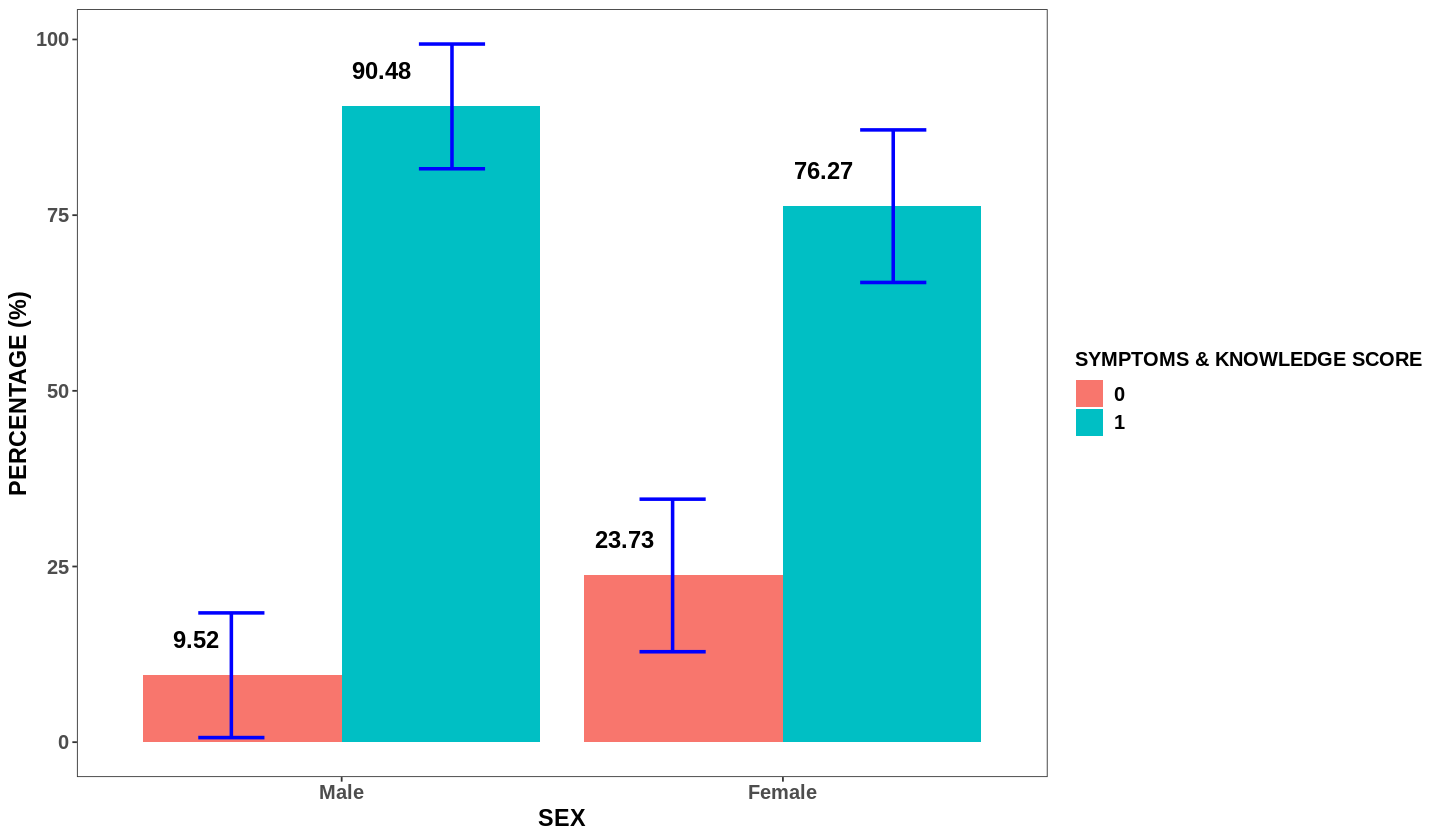



-------------------------------------------


-------------------------------------------
AGE CATEGORICAL

-------------------------------------------


AGECAT     Freq % Freq   
1 18 to 35    31   30.69307
2 35 to 60    57   56.43564
3 60 & above  13   12.87129
4 Total      101  100.00000

18 to 35      35 to 60      60 & above    Total        
0     5 [ 4.95% ]   12 [ 11.88% ] 1 [ 0.99% ]   18 [ 17.82% ]
1     26 [ 25.74% ] 45 [ 44.55% ] 12 [ 11.88% ] 83 [ 82.18% ]
Total 31 [ 30.69% ] 57 [ 56.44% ] 13 [ 12.87% ] 101 [ 100% ]

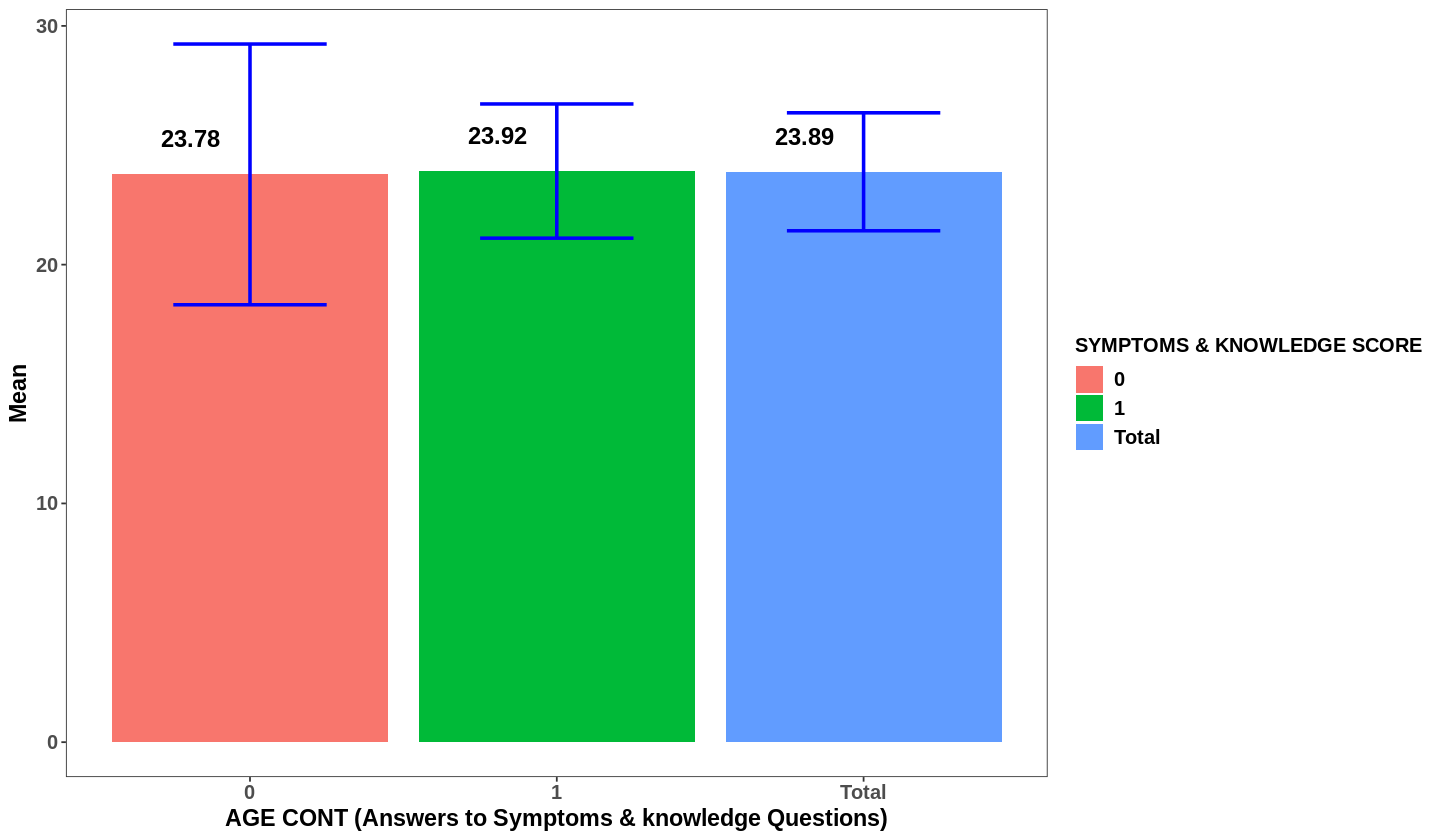



-------------------------------------------


-------------------------------------------
EDUCATION

-------------------------------------------


A5                  Freq % Freq    
1 No formal education   9    8.910891
2 Primary              15   14.851485
3 Secondary            57   56.435644
4 Post Secondary       20   19.801980
5 Total               101  100.000000

No formal education Primary       Secondary     Post Secondary
0     1 [ 0.99% ]         4 [ 3.96% ]   8 [ 7.92% ]   5 [ 4.95% ]   
1     8 [ 7.92% ]         11 [ 10.89% ] 49 [ 48.51% ] 15 [ 14.85% ] 
Total 9 [ 8.91% ]         15 [ 14.85% ] 57 [ 56.44% ] 20 [ 19.8% ]  
      Total        
0     18 [ 17.82% ]
1     83 [ 82.18% ]
Total 101 [ 100% ]

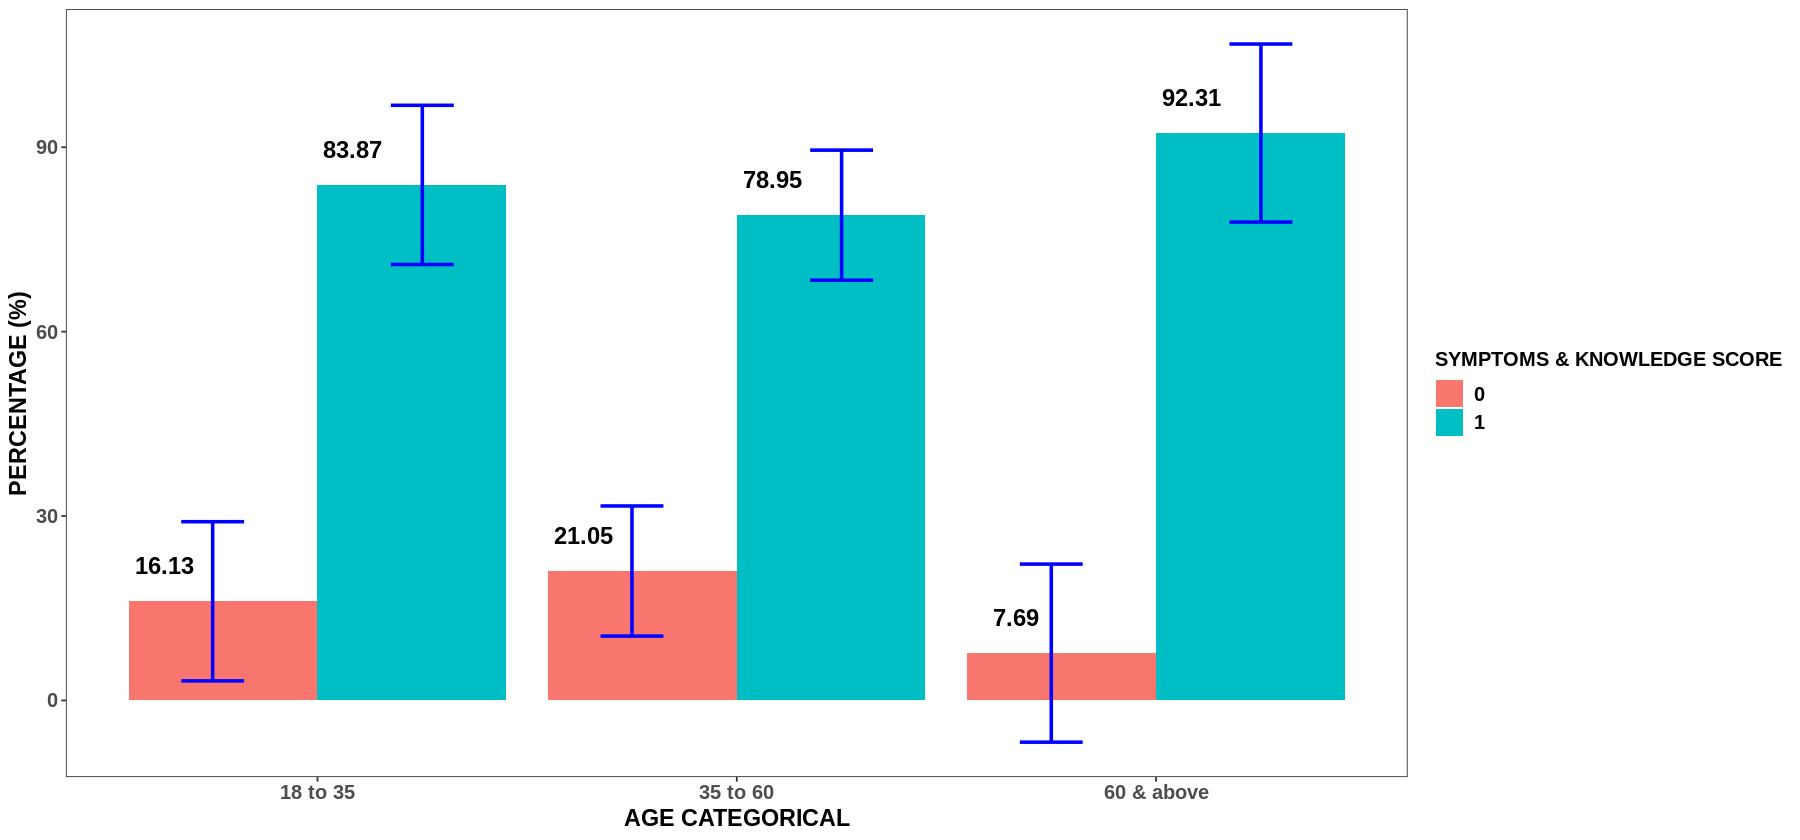



-------------------------------------------


-------------------------------------------
OCCUPATION

-------------------------------------------


A6             Freq % Freq    
1  Unemployed       4    3.960396
2  Housewife        1    0.990099
3  Farming         18   17.821782
4  Trading         36   35.643564
5  Artisan         16   15.841584
6  Public Sector   12   11.881188
7  Private Sector   2    1.980198
8  Retired          4    3.960396
9  Student          8    7.920792
10 Total          101  100.000000

Unemployed  Housewife   Farming       Trading       Artisan      
0     0 [ 0% ]    1 [ 0.99% ] 6 [ 5.94% ]   6 [ 5.94% ]   2 [ 1.98% ]  
1     4 [ 3.96% ] 0 [ 0% ]    12 [ 11.88% ] 30 [ 29.7% ]  14 [ 13.86% ]
Total 4 [ 3.96% ] 1 [ 0.99% ] 18 [ 17.82% ] 36 [ 35.64% ] 16 [ 15.84% ]
      Public Sector Private Sector Retired     Student     Total        
0     2 [ 1.98% ]   0 [ 0% ]       0 [ 0% ]    1 [ 0.99% ] 18 [ 17.82% ]
1     10 [ 9.9% ]   2 [ 1.98% ]    4 [ 3.96% ] 7 [ 6.93% ] 83 [ 82.18% ]
Total 12 [ 11.88% ] 2 [ 1.98% ]    4 [ 3.96% ] 8 [ 7.92% ] 101 [ 100% ]

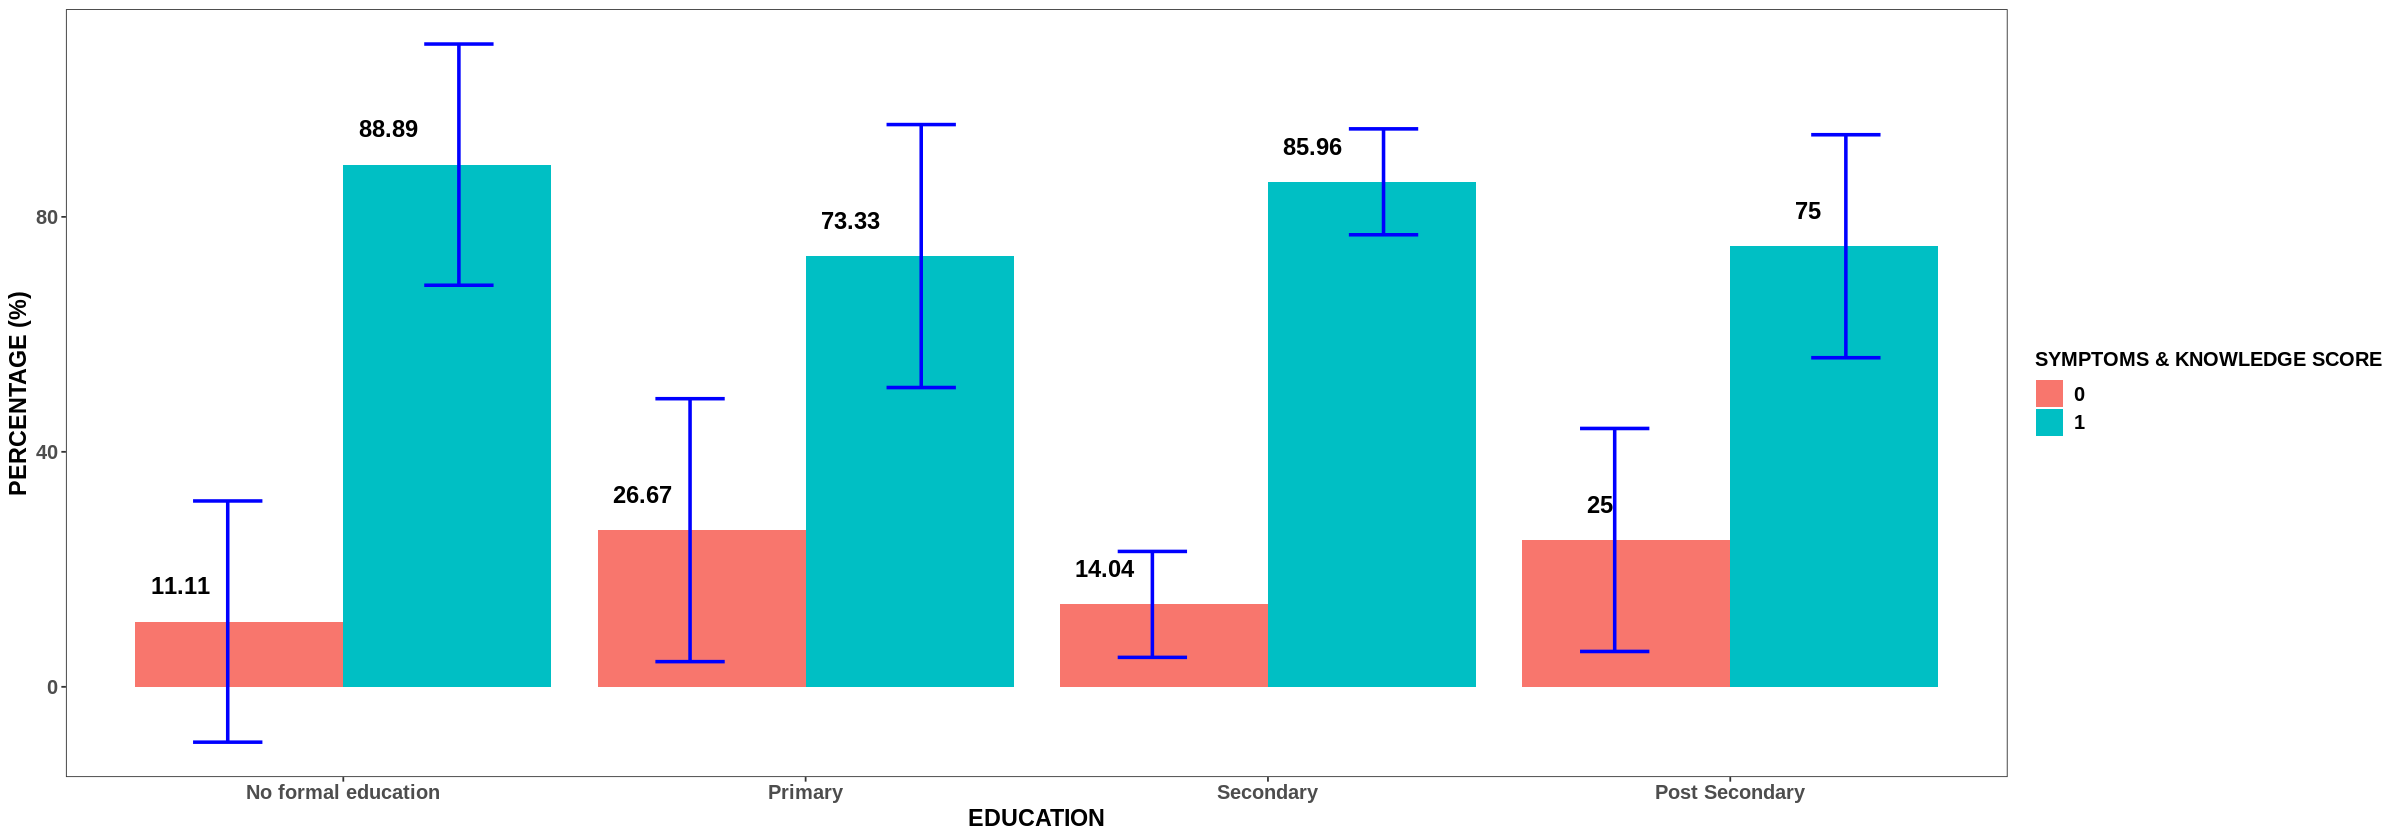



-------------------------------------------


-------------------------------------------
ACCOMODATION

-------------------------------------------


B13                              Freq % Freq    
1 A whole family house              26   25.742574
2 Duplex                             6    5.940594
3 Two/three bedroom flat            16   15.841584
4 Mini flat/self-contain apartment  32   31.683168
5 Room and parlour                  21   20.792079
6 Single room                        0    0.000000
7 Wood & makeshift structure         0    0.000000
8 Total                            101  100.000000

A whole family house Duplex      Two/three bedroom flat
0     4 [ 3.96% ]          3 [ 2.97% ] 1 [ 0.99% ]           
1     22 [ 21.78% ]        3 [ 2.97% ] 15 [ 14.85% ]         
Total 26 [ 25.74% ]        6 [ 5.94% ] 16 [ 15.84% ]         
      Mini flat/self-contain apartment Room and parlour Single room
0     8 [ 7.92% ]                      2 [ 1.98% ]      0 [ 0% ]   
1     24 [ 23.76% ]                    19 [ 18.81% ]    0 [ 0% ]   
Total 32 [ 31.68% ]                    21 [ 20.79% ]    0 [ 0% ]   
      Wood & makeshift structure Total        
0     0 [ 0% ]                   18 [ 17.82% ]
1     0 [ 0% ]                   83 [ 82.18% ]
Total 0 [ 0% ]                   101 [ 100% ]

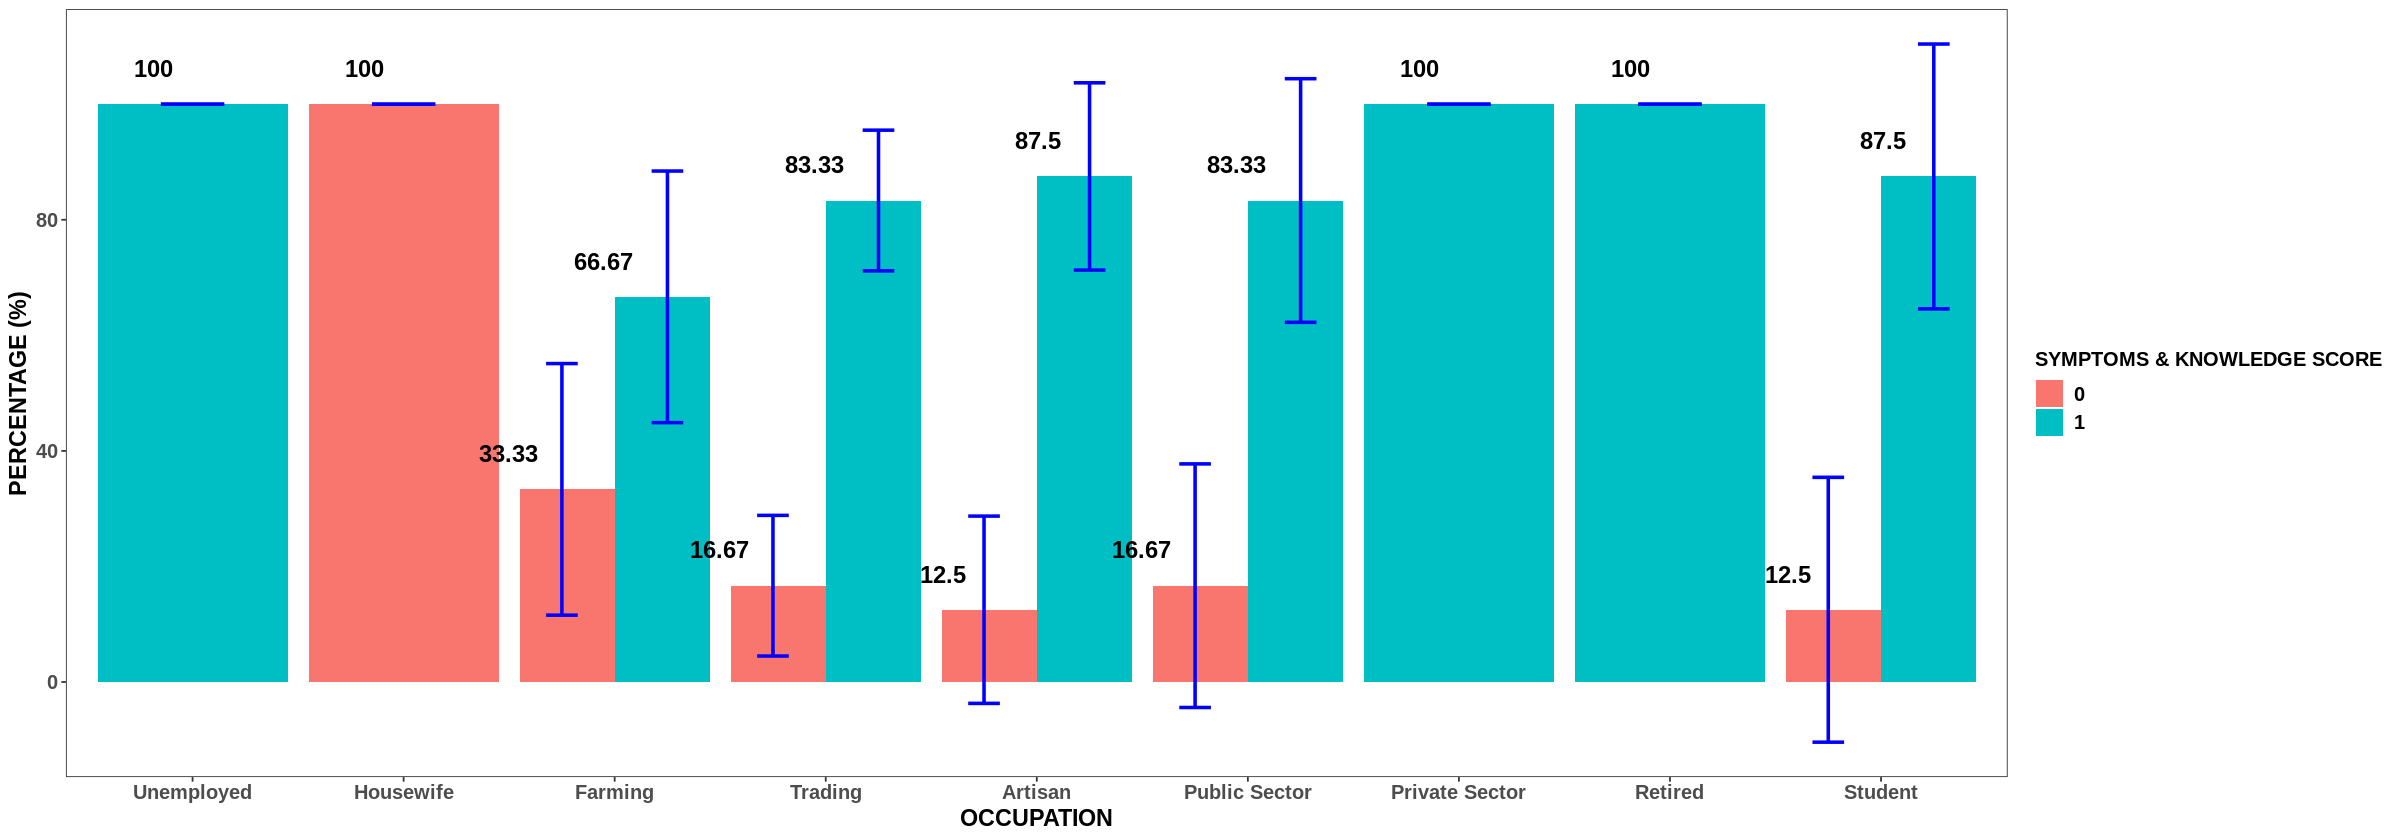



-------------------------------------------


-------------------------------------------
EDUCATION MODIFIED

-------------------------------------------


A5MUT             Freq % Freq   
1 Secondary & Above  77   76.23762
2 Pre Secondary      24   23.76238
3 Total             101  100.00000

Secondary & Above Pre Secondary Total        
0     13 [ 12.87% ]     5 [ 4.95% ]   18 [ 17.82% ]
1     64 [ 63.37% ]     19 [ 18.81% ] 83 [ 82.18% ]
Total 77 [ 76.24% ]     24 [ 23.76% ] 101 [ 100% ]

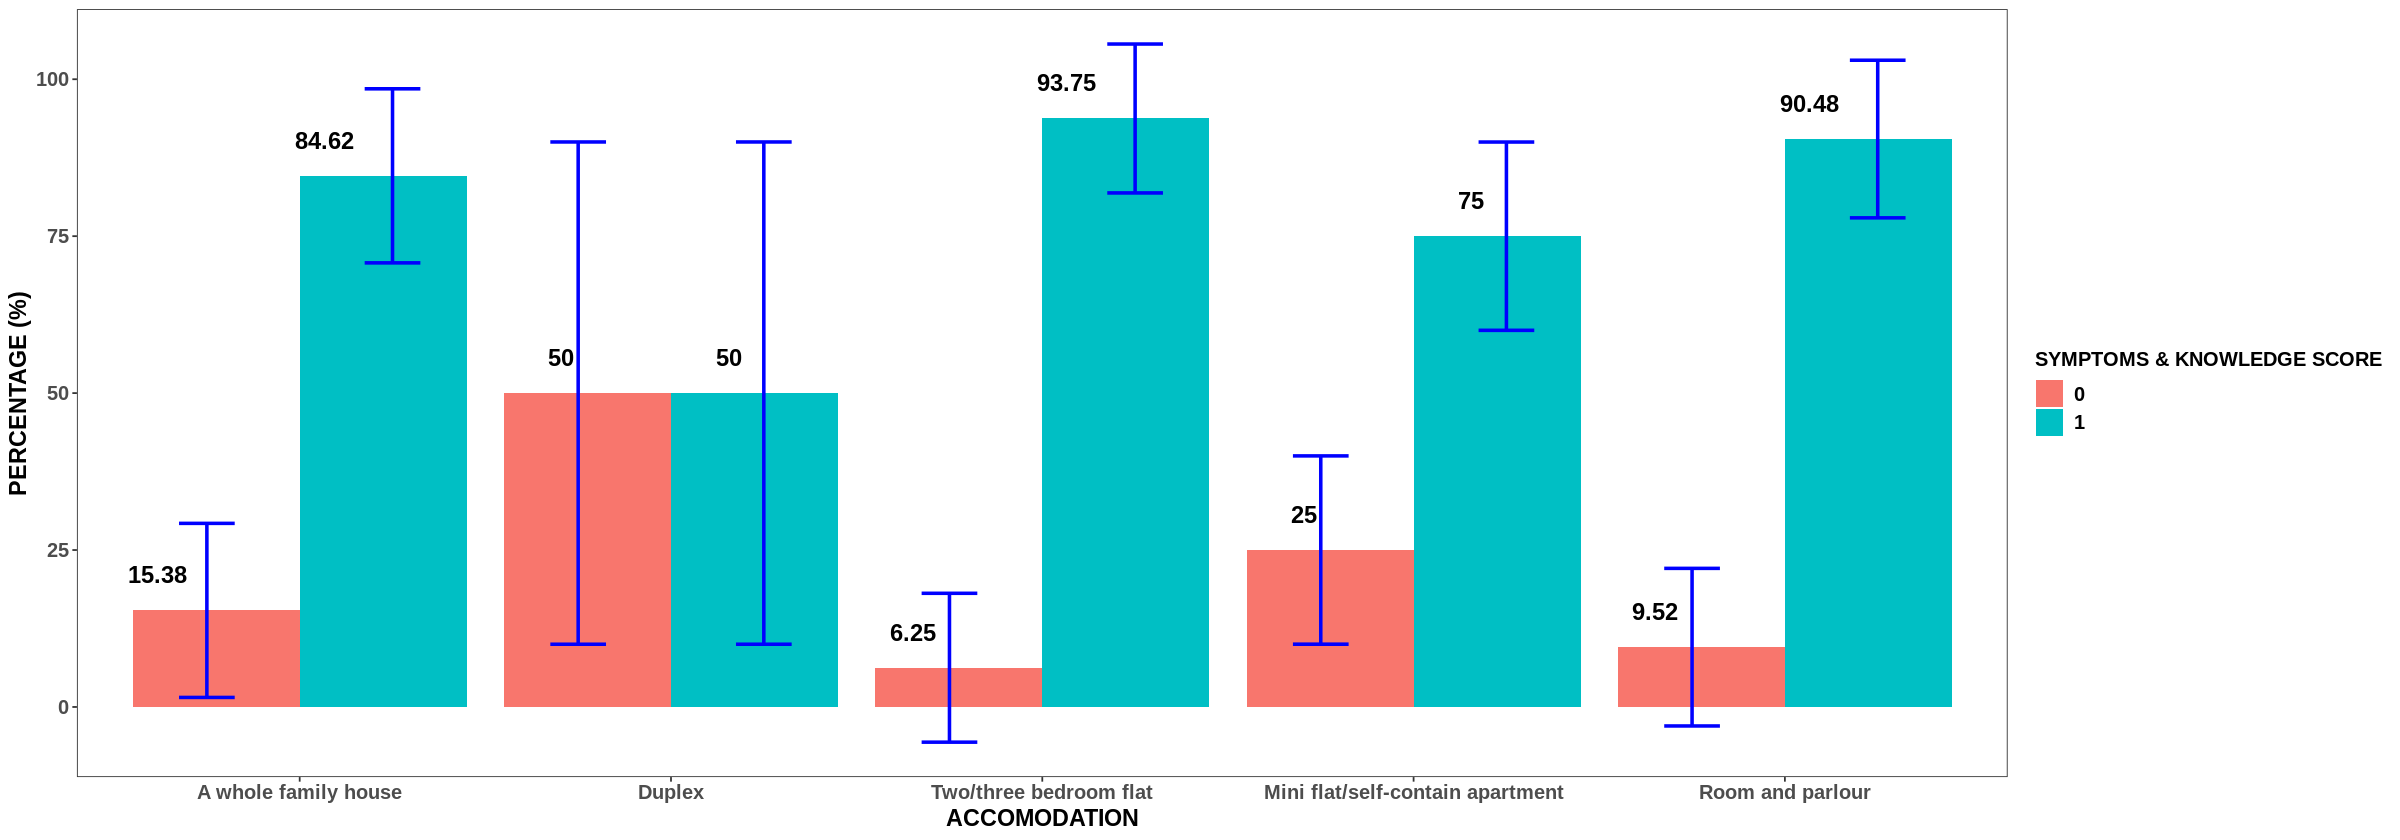



-------------------------------------------


-------------------------------------------
OCCUPATION MODIFIED

-------------------------------------------


A6MUT                  Freq % Freq    
1 Blue Collar             70   69.306931
2 White Collar            18   17.821782
3 Student                  8    7.920792
4 Unemployed & Housewife   5    4.950495
5 Total                  101  100.000000

Blue Collar   White Collar  Student     Unemployed & Housewife
0     14 [ 13.86% ] 2 [ 1.98% ]   1 [ 0.99% ] 1 [ 0.99% ]           
1     56 [ 55.45% ] 16 [ 15.84% ] 7 [ 6.93% ] 4 [ 3.96% ]           
Total 70 [ 69.31% ] 18 [ 17.82% ] 8 [ 7.92% ] 5 [ 4.95% ]           
      Total        
0     18 [ 17.82% ]
1     83 [ 82.18% ]
Total 101 [ 100% ]

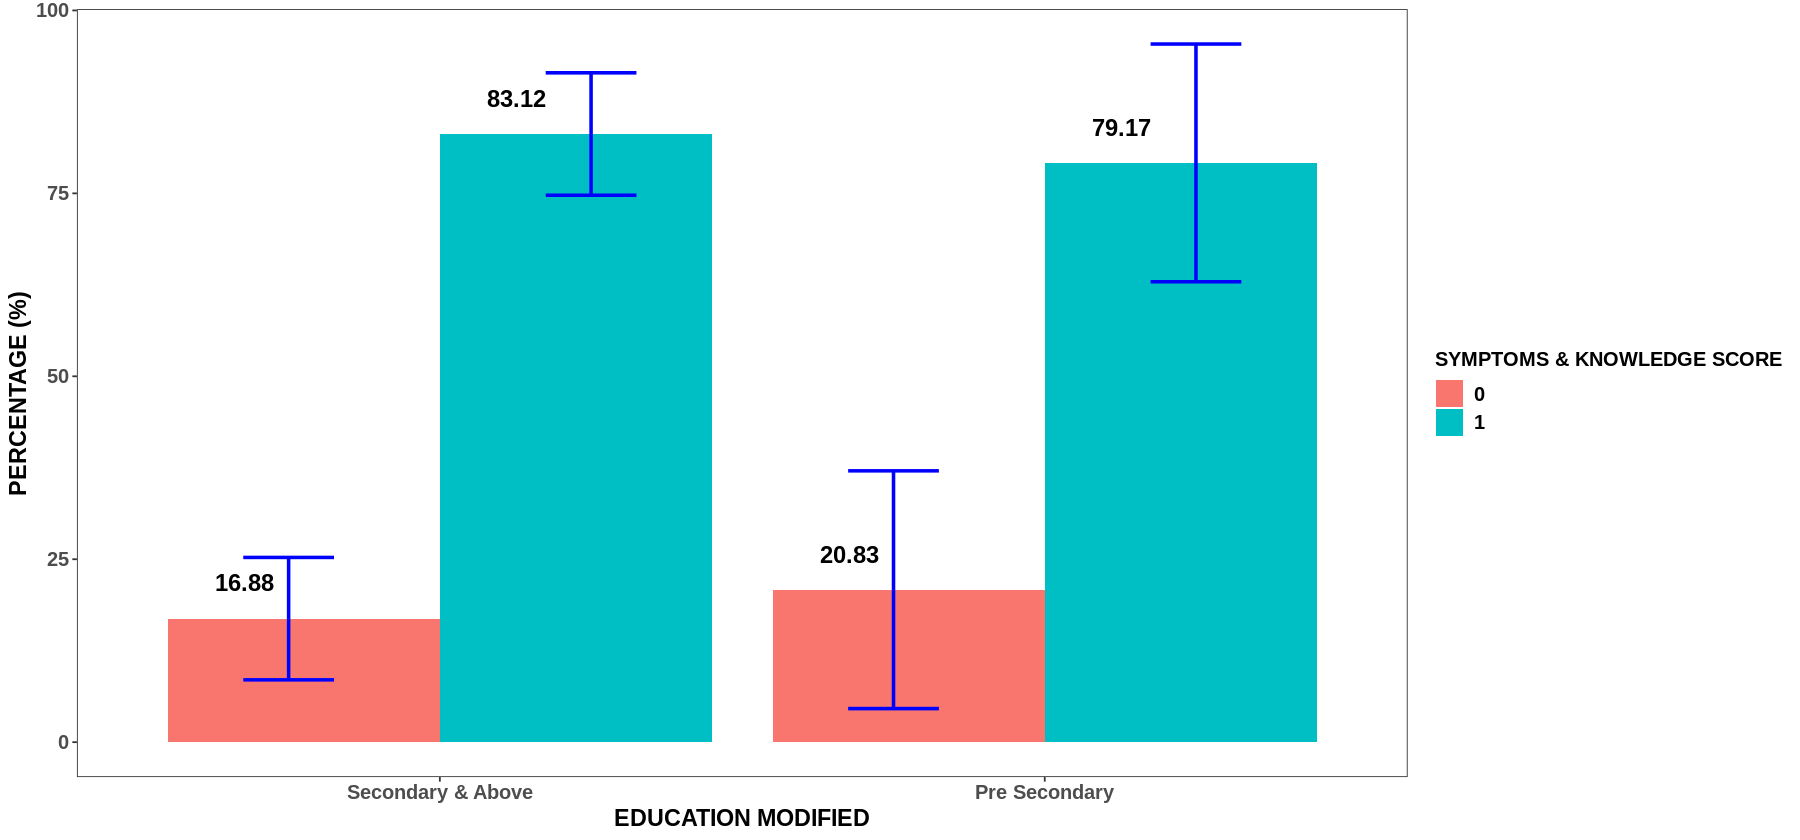



-------------------------------------------


-------------------------------------------
ACCOMODATION MODIFIED

-------------------------------------------


B13MUT       Freq % Freq   
1 Not Spacious  53   52.47525
2 Spacious      48   47.52475
3 Total        101  100.00000

Not Spacious  Spacious      Total        
0     10 [ 9.9% ]   8 [ 7.92% ]   18 [ 17.82% ]
1     43 [ 42.57% ] 40 [ 39.6% ]  83 [ 82.18% ]
Total 53 [ 52.48% ] 48 [ 47.52% ] 101 [ 100% ]

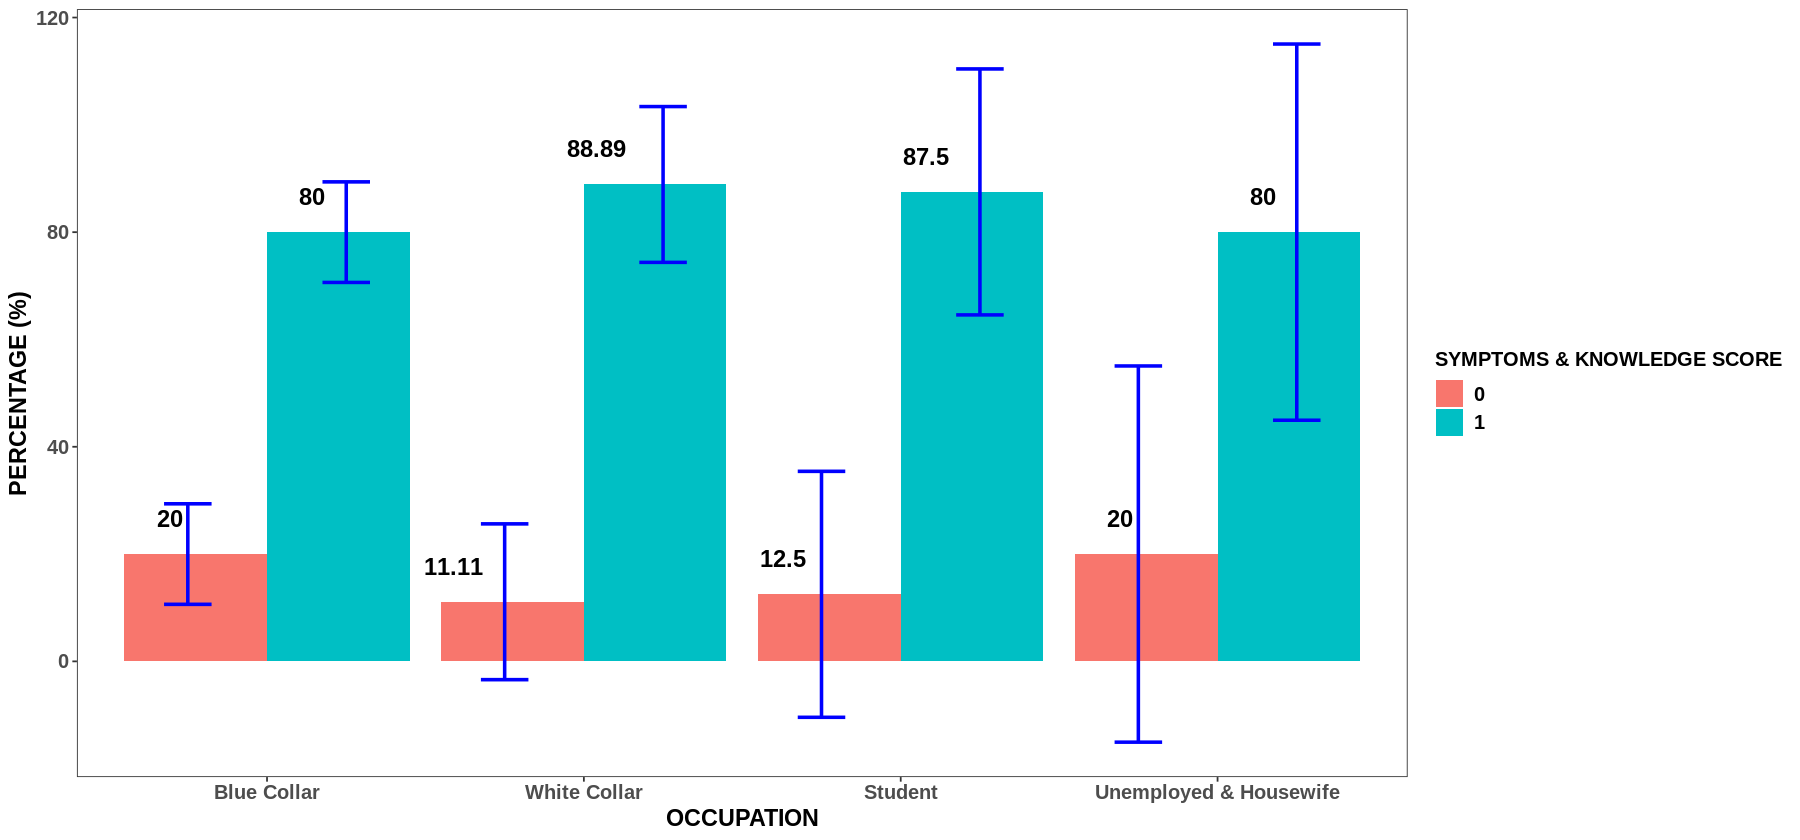

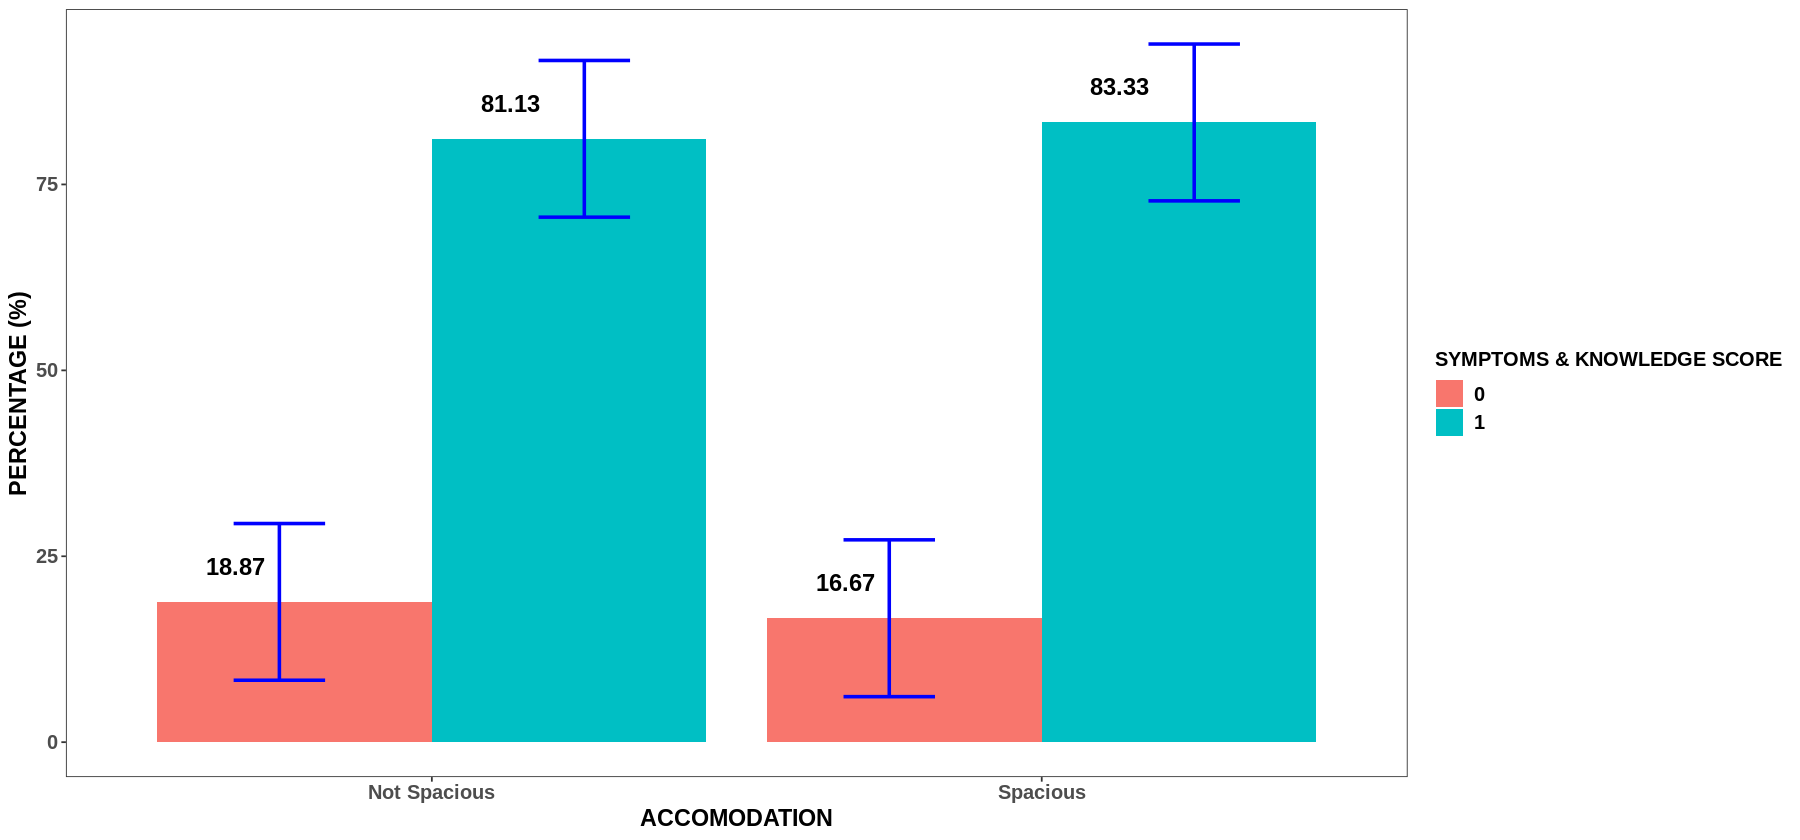

In [ ]:
fig_sizer_fn(12,7)
cat("\n\n-------------------------------------------\n")
cat("\n\n-------------------------------------------\n")

cat("SEX")
cat("\n\n-------------------------------------------\n")
analysis_df = YF_data %>% filter(is.na(high_Symptoms_knowledge_Score) == FALSE) %>% filter(is.na(A1) == FALSE)

analysis_df %$% freq(A1)

cat("\n\n\n")

analysis_df %$% ctable_fn(x = high_Symptoms_knowledge_Score, y = A1)

cat("\n\n\n")

#============================================================

analysis_CI_cat_df = analysis_df %>% select(high_Symptoms_knowledge_Score, A1) %>% group_by(A1, high_Symptoms_knowledge_Score) %>%
  summarise(Count = n(), .groups = 'drop') %>% 

  mutate(OverallPercentage = Count/sum(.$Count) ) %>%
  mutate( OverallPercentage = round(OverallPercentage,4) * 100) %>%
  
  group_by(A1) %>% mutate(WithinGroupSum = sum(Count)) %>%
  group_by(high_Symptoms_knowledge_Score, .add=TRUE) %>%
  mutate(Percentage = Count/WithinGroupSum , Lower_CI = Percentage - 1.96 * sqrt( Percentage * {1 - Percentage} / WithinGroupSum), Upper_CI = Percentage + 1.96 * sqrt( Percentage * {1 - Percentage} / WithinGroupSum)) %>%
  mutate( Percentage = round(Percentage, 4) * 100, Lower_CI  = round(Lower_CI, 4) * 100, Upper_CI = round(Upper_CI,4) * 100)

ggplot(analysis_CI_cat_df, aes(x = factor(A1), y = Percentage, fill = factor(high_Symptoms_knowledge_Score))) +
  geom_bar(position="dodge", stat="identity", width = 0.9) +
   geom_text(aes(label = Percentage), position = position_dodge(0.9), hjust = 1.5, vjust = -1.6, fontface = "bold", size = 5) +
  labs(x = "SEX", y = "PERCENTAGE (%)", fill = "SYMPTOMS & KNOWLEDGE SCORE") +  
      geom_errorbar(aes(ymin = Lower_CI, ymax = Upper_CI), width = 0.3 , position = position_dodge(width = 1), color = "blue", size = 1)    +
  theme_minimal(base_size = 18)+
  theme_bw() +
  theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank()) +
  theme(legend.text=element_text(size = 12, face = "bold"), legend.title = element_text(size=12 , face = "bold"), axis.text=element_text(size=12, face="bold"),
        axis.title=element_text(size=14, face="bold"), plot.title = element_text(hjust = 0.5, size = 16, face = "bold"))



cat("\n\n-------------------------------------------\n")
cat("\n\n-------------------------------------------\n")

cat("AGE CONTINUOUS")
cat("\n\n-------------------------------------------\n")

analysis_df = YF_data %>% filter(is.na(high_Symptoms_knowledge_Score) == FALSE) %>% filter(is.na(A2) == FALSE)

cat(paste0("\n\n Number of missing observation is: ", nrow(YF_data) - nrow(analysis_df), " out of ", nrow(YF_data), "\n"))
#=======================================================================

analysis_df = analysis_df %>% select(c(A2, high_Symptoms_knowledge_Score ))
analysis_df = analysis_df[complete.cases(analysis_df),]

analysis_df$A2 = as.numeric(analysis_df$A2)

cat("\n\n")

#=======================================================================

analysis_CI_cont_df1 = analysis_df %>% group_by(high_Symptoms_knowledge_Score) %>%
                       summarise(Count = n(), Mean = mean(A2, na.rm=TRUE), Min = quantile(A2, 0, na.rm=TRUE), Q1 = quantile(A2, 0.25, na.rm=TRUE), 
                       Q2 = quantile(A2, 0.5, na.rm=TRUE),  Q3 = quantile(A2, 0.75, na.rm=TRUE), Max = quantile(A2, 1, na.rm=TRUE),
                       Sd = sd(A2, na.rm=TRUE), .groups = 'drop') %>%
                       mutate( Margin_Error = {Sd/sqrt(Count)} * qt(1-0.05/2, Count - 1)  ) %>% mutate(Mean = round(Mean, 2),  Margin_Error = round(Margin_Error, 2) )
analysis_CI_cont_df1$high_Symptoms_knowledge_Score = as.character(analysis_CI_cont_df1$high_Symptoms_knowledge_Score)

analysis_CI_cont_df2 = analysis_df %>%
                       summarise(high_Symptoms_knowledge_Score =  "Total", Count = n(), Mean = mean(A2, na.rm=TRUE), Min = quantile(A2, 0, na.rm=TRUE), Q1 = quantile(A2, 0.25, na.rm=TRUE), 
                       Q2 = quantile(A2, 0.5, na.rm=TRUE),  Q3 = quantile(A2, 0.75, na.rm=TRUE), Max = quantile(A2, 1, na.rm=TRUE),
                       Sd = sd(A2, na.rm=TRUE), .groups = 'drop') %>%
                       mutate( Margin_Error = {Sd/sqrt(Count)} * qt(1-0.05/2, Count - 1)  ) %>% mutate(Mean = round(Mean, 2),  Margin_Error = round(Margin_Error, 2) )

analysis_CI_cont_df = rbind(analysis_CI_cont_df1, analysis_CI_cont_df2)

analysis_CI_cont_df 

#================================================================


ggplot(analysis_CI_cont_df, aes(x = factor(high_Symptoms_knowledge_Score), y = Mean , fill = factor(high_Symptoms_knowledge_Score))) +
  geom_bar(position="dodge", stat="identity", width = 0.9) +
  labs(x = "AGE CONT (Answers to Symptoms & knowledge Questions)", y = "Mean", fill = "SYMPTOMS & KNOWLEDGE SCORE") +  
       geom_text(aes(label = Mean), position = position_dodge(0.9), hjust = 1.5, vjust = -1.6, fontface = "bold", size = 5) +
      geom_errorbar(aes(ymin = Mean  - Margin_Error, ymax = Mean + Margin_Error), width = 0.5, position = position_dodge(width = 0.5), color="blue", size=1)    +
  theme_minimal(base_size = 18)+
  theme_bw() +
  theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank()) +
  theme(legend.text=element_text(size = 12, face = "bold"), legend.title = element_text(size=12 , face = "bold"), axis.text=element_text(size=12, face="bold"),
        axis.title=element_text(size=14, face="bold"), plot.title = element_text(hjust = 0.5, size = 16, face = "bold"))






cat("\n\n-------------------------------------------\n")
cat("\n\n-------------------------------------------\n")

cat("AGE CATEGORICAL")
cat("\n\n-------------------------------------------\n")

analysis_df = YF_data %>% filter(is.na(high_Symptoms_knowledge_Score) == FALSE) %>% filter(is.na(AGECAT) == FALSE)

analysis_df %$% freq(AGECAT)

cat("\n\n\n")

analysis_df %$% ctable_fn(x = high_Symptoms_knowledge_Score, y = AGECAT)


#============================================================

analysis_CI_cat_df = analysis_df %>% select(high_Symptoms_knowledge_Score, AGECAT) %>% group_by(AGECAT, high_Symptoms_knowledge_Score) %>%
  summarise(Count = n(), .groups = 'drop') %>% 

  mutate(OverallPercentage = Count/sum(.$Count) ) %>%
  mutate( OverallPercentage = round(OverallPercentage,4) * 100) %>%
  
  group_by(AGECAT) %>% mutate(WithinGroupSum = sum(Count)) %>%
  group_by(high_Symptoms_knowledge_Score, .add=TRUE) %>%
  mutate(Percentage = Count/WithinGroupSum , Lower_CI = Percentage - 1.96 * sqrt( Percentage * {1 - Percentage} / WithinGroupSum), Upper_CI = Percentage + 1.96 * sqrt( Percentage * {1 - Percentage} / WithinGroupSum)) %>%
  mutate( Percentage = round(Percentage, 4) * 100, Lower_CI  = round(Lower_CI, 4) * 100, Upper_CI = round(Upper_CI,4) * 100)
fig_sizer_fn(15, 7)
ggplot(analysis_CI_cat_df, aes(x = factor(AGECAT), y = Percentage, fill = factor(high_Symptoms_knowledge_Score))) +
  geom_bar(position="dodge", stat="identity", width = 0.9) +
   geom_text(aes(label = Percentage), position = position_dodge(0.9), hjust = 1.5, vjust = -1.6, fontface = "bold", size = 5) +
  labs(x = "AGE CATEGORICAL", y = "PERCENTAGE (%)", fill = "SYMPTOMS & KNOWLEDGE SCORE") +  
      geom_errorbar(aes(ymin = Lower_CI, ymax = Upper_CI), width = 0.3 , position = position_dodge(width = 1), color = "blue", size = 1)    +
  theme_minimal(base_size = 18)+
  theme_bw() +
  theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank()) +
  theme(legend.text=element_text(size = 12, face = "bold"), legend.title = element_text(size=12 , face = "bold"), axis.text=element_text(size=12, face="bold"),
        axis.title=element_text(size=14, face="bold"), plot.title = element_text(hjust = 0.5, size = 16, face = "bold"))



cat("\n\n-------------------------------------------\n")
cat("\n\n-------------------------------------------\n")

cat("EDUCATION")
cat("\n\n-------------------------------------------\n")

analysis_df = YF_data %>% filter(is.na(high_Symptoms_knowledge_Score) == FALSE) %>% filter(is.na(A5) == FALSE)

analysis_df %$% freq(A5)

cat("\n\n\n")

analysis_df %$% ctable_fn(x = high_Symptoms_knowledge_Score, y = A5)


#============================================================

analysis_CI_cat_df = analysis_df %>% select(high_Symptoms_knowledge_Score, A5) %>% group_by(A5, high_Symptoms_knowledge_Score) %>%
  summarise(Count = n(), .groups = 'drop') %>% 

  mutate(OverallPercentage = Count/sum(.$Count) ) %>%
  mutate( OverallPercentage = round(OverallPercentage,4) * 100) %>%
  
  group_by(A5) %>% mutate(WithinGroupSum = sum(Count)) %>%
  group_by(high_Symptoms_knowledge_Score, .add=TRUE) %>%
  mutate(Percentage = Count/WithinGroupSum , Lower_CI = Percentage - 1.96 * sqrt( Percentage * {1 - Percentage} / WithinGroupSum), Upper_CI = Percentage + 1.96 * sqrt( Percentage * {1 - Percentage} / WithinGroupSum)) %>%
  mutate( Percentage = round(Percentage, 4) * 100, Lower_CI  = round(Lower_CI, 4) * 100, Upper_CI = round(Upper_CI,4) * 100)

fig_sizer_fn(20, 7)

ggplot(analysis_CI_cat_df, aes(x = factor(A5), y = Percentage, fill = factor(high_Symptoms_knowledge_Score))) +
  geom_bar(position="dodge", stat="identity", width = 0.9) +
   geom_text(aes(label = Percentage), position = position_dodge(0.9), hjust = 1.5, vjust = -1.6, fontface = "bold", size = 5) +
  labs(x = "EDUCATION", y = "PERCENTAGE (%)", fill = "SYMPTOMS & KNOWLEDGE SCORE") +  
      geom_errorbar(aes(ymin = Lower_CI, ymax = Upper_CI), width = 0.3 , position = position_dodge(width = 1), color = "blue", size = 1)    +
  theme_minimal(base_size = 18)+
  theme_bw() +
  theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank()) +
  theme(legend.text=element_text(size = 12, face = "bold"), legend.title = element_text(size=12 , face = "bold"), axis.text=element_text(size=12, face="bold"),
        axis.title=element_text(size=14, face="bold"), plot.title = element_text(hjust = 0.5, size = 16, face = "bold"))



cat("\n\n-------------------------------------------\n")
cat("\n\n-------------------------------------------\n")

cat("OCCUPATION")
cat("\n\n-------------------------------------------\n")

analysis_df = YF_data %>% filter(is.na(high_Symptoms_knowledge_Score) == FALSE) %>% filter(is.na(A6) == FALSE)

analysis_df %$% freq(A6)

cat("\n\n\n")

analysis_df %$% ctable_fn(x = high_Symptoms_knowledge_Score, y = A6)


#============================================================

analysis_CI_cat_df = analysis_df %>% select(high_Symptoms_knowledge_Score, A6) %>% group_by(A6, high_Symptoms_knowledge_Score) %>%
  summarise(Count = n(), .groups = 'drop') %>% 

  mutate(OverallPercentage = Count/sum(.$Count) ) %>%
  mutate( OverallPercentage = round(OverallPercentage,4) * 100) %>%
  
  group_by(A6) %>% mutate(WithinGroupSum = sum(Count)) %>%
  group_by(high_Symptoms_knowledge_Score, .add=TRUE) %>%
  mutate(Percentage = Count/WithinGroupSum , Lower_CI = Percentage - 1.96 * sqrt( Percentage * {1 - Percentage} / WithinGroupSum), Upper_CI = Percentage + 1.96 * sqrt( Percentage * {1 - Percentage} / WithinGroupSum)) %>%
  mutate( Percentage = round(Percentage, 4) * 100, Lower_CI  = round(Lower_CI, 4) * 100, Upper_CI = round(Upper_CI,4) * 100)

fig_sizer_fn(20, 7)

ggplot(analysis_CI_cat_df, aes(x = factor(A6), y = Percentage, fill = factor(high_Symptoms_knowledge_Score))) +
  geom_bar(position="dodge", stat="identity", width = 0.9) +
   geom_text(aes(label = Percentage), position = position_dodge(0.9), hjust = 1.5, vjust = -1.6, fontface = "bold", size = 5) +
  labs(x = "OCCUPATION", y = "PERCENTAGE (%)", fill = "SYMPTOMS & KNOWLEDGE SCORE") +  
      geom_errorbar(aes(ymin = Lower_CI, ymax = Upper_CI), width = 0.3 , position = position_dodge(width = 1), color = "blue", size = 1)    +
  theme_minimal(base_size = 18)+
  theme_bw() +
  theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank()) +
  theme(legend.text=element_text(size = 12, face = "bold"), legend.title = element_text(size=12 , face = "bold"), axis.text=element_text(size=12, face="bold"),
        axis.title=element_text(size=14, face="bold"), plot.title = element_text(hjust = 0.5, size = 16, face = "bold"))




cat("\n\n-------------------------------------------\n")
cat("\n\n-------------------------------------------\n")

cat("ACCOMODATION")
cat("\n\n-------------------------------------------\n")

analysis_df = YF_data %>% filter(is.na(high_Symptoms_knowledge_Score) == FALSE) %>% filter(is.na(B13) == FALSE)

analysis_df %$% freq(B13)

cat("\n\n\n")

analysis_df %$% ctable_fn(x = high_Symptoms_knowledge_Score, y = B13)


#============================================================

analysis_CI_cat_df = analysis_df %>% select(high_Symptoms_knowledge_Score, B13) %>% group_by(B13, high_Symptoms_knowledge_Score) %>%
  summarise(Count = n(), .groups = 'drop') %>% 

  mutate(OverallPercentage = Count/sum(.$Count) ) %>%
  mutate( OverallPercentage = round(OverallPercentage,4) * 100) %>%
  
  group_by(B13) %>% mutate(WithinGroupSum = sum(Count)) %>%
  group_by(high_Symptoms_knowledge_Score, .add=TRUE) %>%
  mutate(Percentage = Count/WithinGroupSum , Lower_CI = Percentage - 1.96 * sqrt( Percentage * {1 - Percentage} / WithinGroupSum), Upper_CI = Percentage + 1.96 * sqrt( Percentage * {1 - Percentage} / WithinGroupSum)) %>%
  mutate( Percentage = round(Percentage, 4) * 100, Lower_CI  = round(Lower_CI, 4) * 100, Upper_CI = round(Upper_CI,4) * 100)

fig_sizer_fn(20, 7)

ggplot(analysis_CI_cat_df, aes(x = factor(B13), y = Percentage, fill = factor(high_Symptoms_knowledge_Score))) +
  geom_bar(position="dodge", stat="identity", width = 0.9) +
   geom_text(aes(label = Percentage), position = position_dodge(0.9), hjust = 1.5, vjust = -1.6, fontface = "bold", size = 5) +
  labs(x = "ACCOMODATION", y = "PERCENTAGE (%)", fill = "SYMPTOMS & KNOWLEDGE SCORE") +  
      geom_errorbar(aes(ymin = Lower_CI, ymax = Upper_CI), width = 0.3 , position = position_dodge(width = 1), color = "blue", size = 1)    +
  theme_minimal(base_size = 18)+
  theme_bw() +
  theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank()) +
  theme(legend.text=element_text(size = 12, face = "bold"), legend.title = element_text(size=12 , face = "bold"), axis.text=element_text(size=12, face="bold"),
        axis.title=element_text(size=14, face="bold"), plot.title = element_text(hjust = 0.5, size = 16, face = "bold"))



#====================================================================================================================
#====================================================================================================================
#====================================================================================================================
#====================================================================================================================


fig_sizer_fn()

cat("\n\n-------------------------------------------\n")
cat("\n\n-------------------------------------------\n")

cat("EDUCATION MODIFIED")
cat("\n\n-------------------------------------------\n")

analysis_df = YF_data %>% filter(is.na(high_Symptoms_knowledge_Score) == FALSE) %>% filter(is.na(A5MUT) == FALSE)

analysis_df %$% freq(A5MUT)

cat("\n\n\n")

analysis_df %$% ctable_fn(x = high_Symptoms_knowledge_Score, y = A5MUT)


#============================================================

analysis_CI_cat_df = analysis_df %>% select(high_Symptoms_knowledge_Score, A5MUT) %>% group_by(A5MUT, high_Symptoms_knowledge_Score) %>%
  summarise(Count = n(), .groups = 'drop') %>% 

  mutate(OverallPercentage = Count/sum(.$Count) ) %>%
  mutate( OverallPercentage = round(OverallPercentage,4) * 100) %>%
  
  group_by(A5MUT) %>% mutate(WithinGroupSum = sum(Count)) %>%
  group_by(high_Symptoms_knowledge_Score, .add=TRUE) %>%
  mutate(Percentage = Count/WithinGroupSum , Lower_CI = Percentage - 1.96 * sqrt( Percentage * {1 - Percentage} / WithinGroupSum), Upper_CI = Percentage + 1.96 * sqrt( Percentage * {1 - Percentage} / WithinGroupSum)) %>%
  mutate( Percentage = round(Percentage, 4) * 100, Lower_CI  = round(Lower_CI, 4) * 100, Upper_CI = round(Upper_CI,4) * 100)

fig_sizer_fn(15, 7)

ggplot(analysis_CI_cat_df, aes(x = factor(A5MUT), y = Percentage, fill = factor(high_Symptoms_knowledge_Score))) +
  geom_bar(position="dodge", stat="identity", width = 0.9) +
   geom_text(aes(label = Percentage), position = position_dodge(0.9), hjust = 1.5, vjust = -1.6, fontface = "bold", size = 5) +
  labs(x = "EDUCATION MODIFIED", y = "PERCENTAGE (%)", fill = "SYMPTOMS & KNOWLEDGE SCORE") +  
      geom_errorbar(aes(ymin = Lower_CI, ymax = Upper_CI), width = 0.3 , position = position_dodge(width = 1), color = "blue", size = 1)    +
  theme_minimal(base_size = 18)+
  theme_bw() +
  theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank()) +
  theme(legend.text=element_text(size = 12, face = "bold"), legend.title = element_text(size=12 , face = "bold"), axis.text=element_text(size=12, face="bold"),
        axis.title=element_text(size=14, face="bold"), plot.title = element_text(hjust = 0.5, size = 16, face = "bold"))



cat("\n\n-------------------------------------------\n")
cat("\n\n-------------------------------------------\n")

cat("OCCUPATION MODIFIED")
cat("\n\n-------------------------------------------\n")

analysis_df = YF_data %>% filter(is.na(high_Symptoms_knowledge_Score) == FALSE) %>% filter(is.na(A6MUT) == FALSE)

analysis_df %$% freq(A6MUT)

cat("\n\n\n")

analysis_df %$% ctable_fn(x = high_Symptoms_knowledge_Score, y = A6MUT)


#============================================================

analysis_CI_cat_df = analysis_df %>% select(high_Symptoms_knowledge_Score, A6MUT) %>% group_by(A6MUT, high_Symptoms_knowledge_Score) %>%
  summarise(Count = n(), .groups = 'drop') %>% 

  mutate(OverallPercentage = Count/sum(.$Count) ) %>%
  mutate( OverallPercentage = round(OverallPercentage,4) * 100) %>%
  
  group_by(A6MUT) %>% mutate(WithinGroupSum = sum(Count)) %>%
  group_by(high_Symptoms_knowledge_Score, .add=TRUE) %>%
  mutate(Percentage = Count/WithinGroupSum , Lower_CI = Percentage - 1.96 * sqrt( Percentage * {1 - Percentage} / WithinGroupSum), Upper_CI = Percentage + 1.96 * sqrt( Percentage * {1 - Percentage} / WithinGroupSum)) %>%
  mutate( Percentage = round(Percentage, 4) * 100, Lower_CI  = round(Lower_CI, 4) * 100, Upper_CI = round(Upper_CI,4) * 100)

fig_sizer_fn(15, 7)

ggplot(analysis_CI_cat_df, aes(x = factor(A6MUT), y = Percentage, fill = factor(high_Symptoms_knowledge_Score))) +
  geom_bar(position="dodge", stat="identity", width = 0.9) +
   geom_text(aes(label = Percentage), position = position_dodge(0.9), hjust = 1.5, vjust = -1.6, fontface = "bold", size = 5) +
  labs(x = "OCCUPATION", y = "PERCENTAGE (%)", fill = "SYMPTOMS & KNOWLEDGE SCORE") +  
      geom_errorbar(aes(ymin = Lower_CI, ymax = Upper_CI), width = 0.3 , position = position_dodge(width = 1), color = "blue", size = 1)    +
  theme_minimal(base_size = 18)+
  theme_bw() +
  theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank()) +
  theme(legend.text=element_text(size = 12, face = "bold"), legend.title = element_text(size=12 , face = "bold"), axis.text=element_text(size=12, face="bold"),
        axis.title=element_text(size=14, face="bold"), plot.title = element_text(hjust = 0.5, size = 16, face = "bold"))




cat("\n\n-------------------------------------------\n")
cat("\n\n-------------------------------------------\n")

cat("ACCOMODATION MODIFIED")
cat("\n\n-------------------------------------------\n")

analysis_df = YF_data %>% filter(is.na(high_Symptoms_knowledge_Score) == FALSE) %>% filter(is.na(B13MUT) == FALSE)

analysis_df %$% freq(B13MUT)

cat("\n\n\n")

analysis_df %$% ctable_fn(x = high_Symptoms_knowledge_Score, y = B13MUT)


#============================================================

analysis_CI_cat_df = analysis_df %>% select(high_Symptoms_knowledge_Score, B13MUT) %>% group_by(B13MUT, high_Symptoms_knowledge_Score) %>%
  summarise(Count = n(), .groups = 'drop') %>% 

  mutate(OverallPercentage = Count/sum(.$Count) ) %>%
  mutate( OverallPercentage = round(OverallPercentage,4) * 100) %>%
  
  group_by(B13MUT) %>% mutate(WithinGroupSum = sum(Count)) %>%
  group_by(high_Symptoms_knowledge_Score, .add=TRUE) %>%
  mutate(Percentage = Count/WithinGroupSum , Lower_CI = Percentage - 1.96 * sqrt( Percentage * {1 - Percentage} / WithinGroupSum), Upper_CI = Percentage + 1.96 * sqrt( Percentage * {1 - Percentage} / WithinGroupSum)) %>%
  mutate( Percentage = round(Percentage, 4) * 100, Lower_CI  = round(Lower_CI, 4) * 100, Upper_CI = round(Upper_CI,4) * 100)

fig_sizer_fn(15, 7)

ggplot(analysis_CI_cat_df, aes(x = factor(B13MUT), y = Percentage, fill = factor(high_Symptoms_knowledge_Score))) +
  geom_bar(position="dodge", stat="identity", width = 0.9) +
   geom_text(aes(label = Percentage), position = position_dodge(0.9), hjust = 1.5, vjust = -1.6, fontface = "bold", size = 5) +
  labs(x = "ACCOMODATION", y = "PERCENTAGE (%)", fill = "SYMPTOMS & KNOWLEDGE SCORE") +  
      geom_errorbar(aes(ymin = Lower_CI, ymax = Upper_CI), width = 0.3 , position = position_dodge(width = 1), color = "blue", size = 1)    +
  theme_minimal(base_size = 18)+
  theme_bw() +
  theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank()) +
  theme(legend.text=element_text(size = 12, face = "bold"), legend.title = element_text(size=12 , face = "bold"), axis.text=element_text(size=12, face="bold"),
        axis.title=element_text(size=14, face="bold"), plot.title = element_text(hjust = 0.5, size = 16, face = "bold"))



#### **Protection Approach Against Yellow Fever**



-------------------------------------------


-------------------------------------------
SEX

-------------------------------------------


A1     Freq % Freq   
1 Male    42   41.58416
2 Female  59   58.41584
3 Total  101  100.00000

Male          Female        Total        
0     18 [ 17.82% ] 20 [ 19.8% ]  38 [ 37.62% ]
1     24 [ 23.76% ] 39 [ 38.61% ] 63 [ 62.38% ]
Total 42 [ 41.58% ] 59 [ 58.42% ] 101 [ 100% ]






-------------------------------------------


-------------------------------------------
AGE CONTINUOUS

-------------------------------------------


 Number of missing observation is: 0 out of 101




high_Protection_Score Count Mean  Min Q1    Q2   Q3 Max Sd       Margin_Error
1 0                      38   23.87 1   12.25 26.5 35 45  13.24238 4.35        
2 1                      63   23.90 2   14.00 24.0 32 48  12.14790 3.06        
3 Total                 101   23.89 1   14.00 25.0 33 48  12.50512 2.47

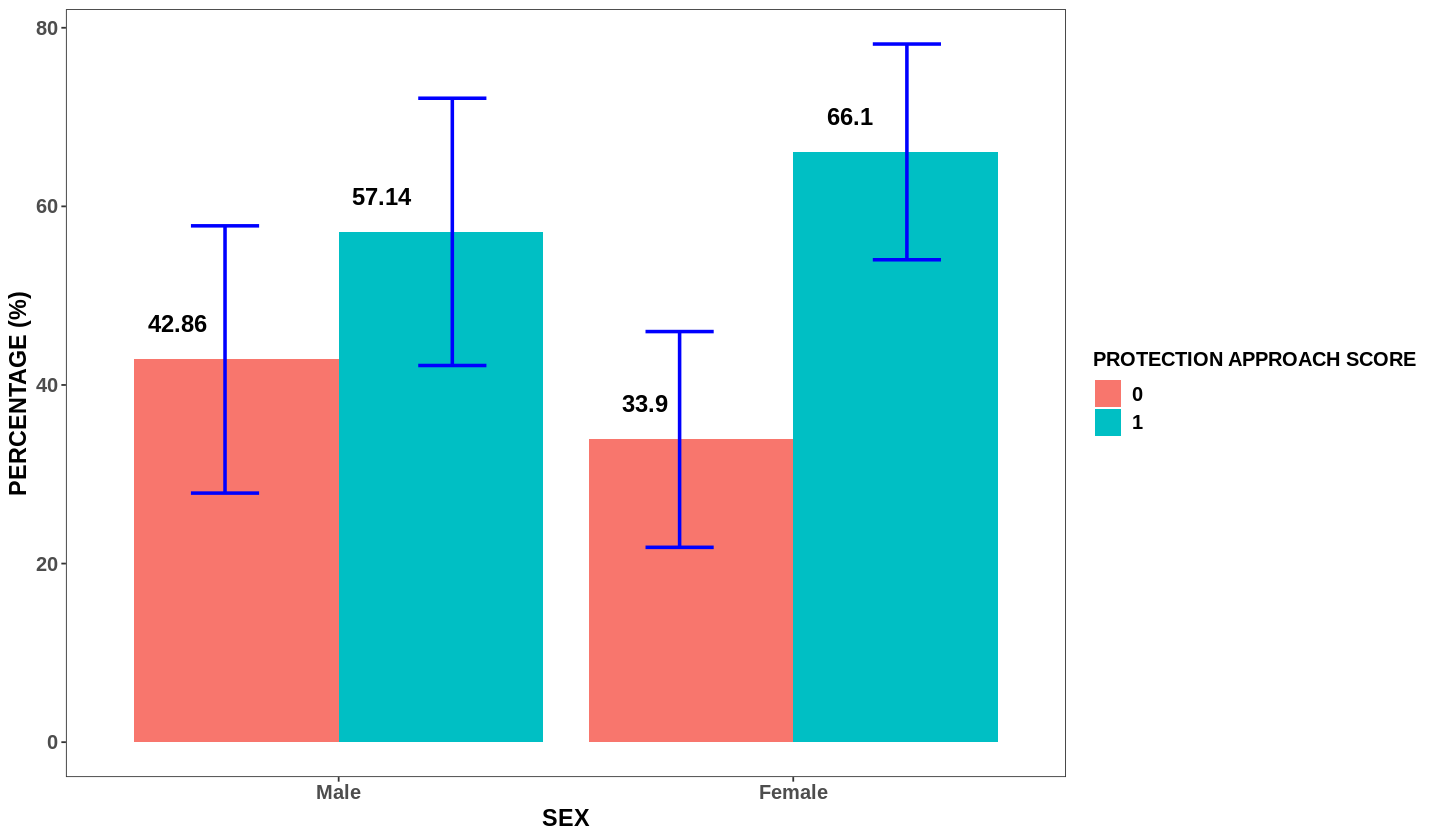



-------------------------------------------


-------------------------------------------
AGE CATEGORICAL

-------------------------------------------


AGECAT     Freq % Freq   
1 18 to 35    31   30.69307
2 35 to 60    57   56.43564
3 60 & above  13   12.87129
4 Total      101  100.00000

18 to 35      35 to 60      60 & above    Total        
0     12 [ 11.88% ] 21 [ 20.79% ] 5 [ 4.95% ]   38 [ 37.62% ]
1     19 [ 18.81% ] 36 [ 35.64% ] 8 [ 7.92% ]   63 [ 62.38% ]
Total 31 [ 30.69% ] 57 [ 56.44% ] 13 [ 12.87% ] 101 [ 100% ]

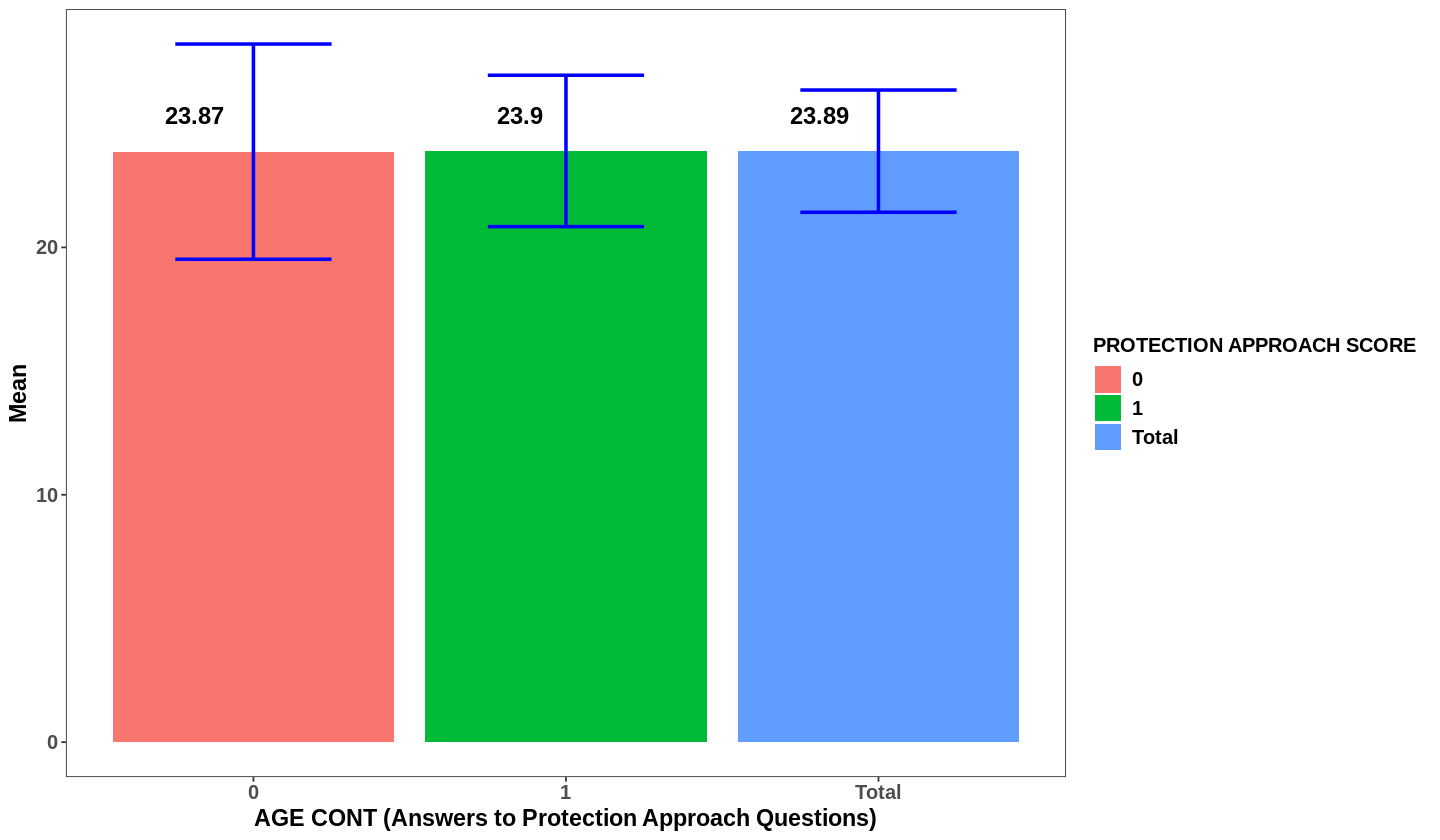



-------------------------------------------


-------------------------------------------
EDUCATION

-------------------------------------------


A5                  Freq % Freq    
1 No formal education   9    8.910891
2 Primary              15   14.851485
3 Secondary            57   56.435644
4 Post Secondary       20   19.801980
5 Total               101  100.000000

No formal education Primary       Secondary     Post Secondary
0     2 [ 1.98% ]         6 [ 5.94% ]   24 [ 23.76% ] 6 [ 5.94% ]   
1     7 [ 6.93% ]         9 [ 8.91% ]   33 [ 32.67% ] 14 [ 13.86% ] 
Total 9 [ 8.91% ]         15 [ 14.85% ] 57 [ 56.44% ] 20 [ 19.8% ]  
      Total        
0     38 [ 37.62% ]
1     63 [ 62.38% ]
Total 101 [ 100% ]

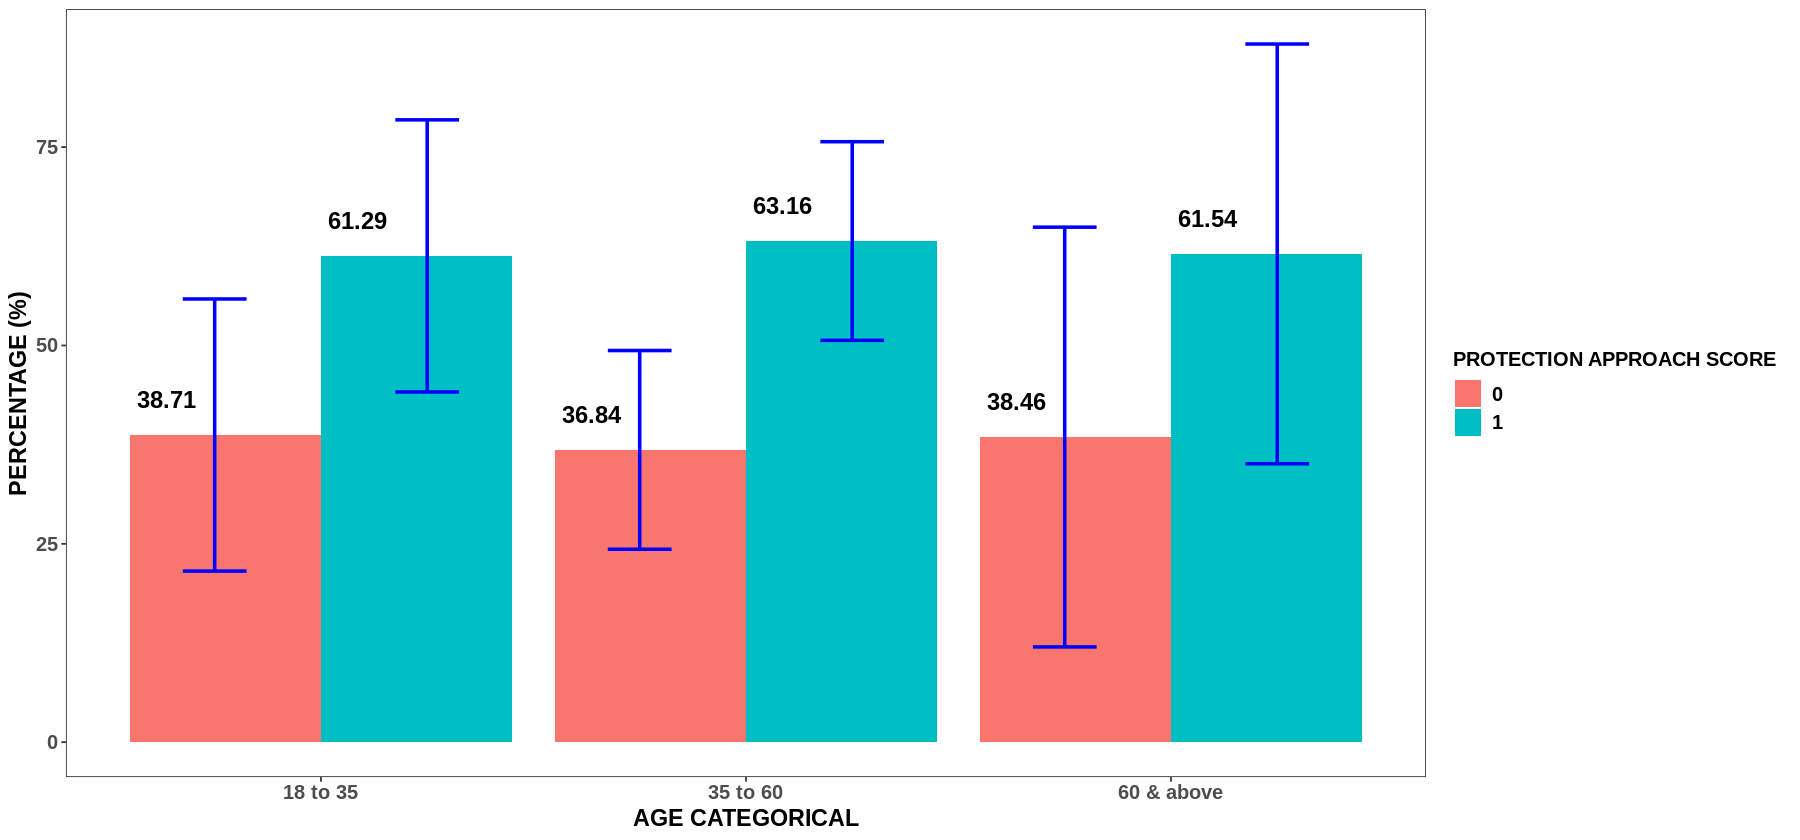



-------------------------------------------


-------------------------------------------
OCCUPATION

-------------------------------------------


A6             Freq % Freq    
1  Unemployed       4    3.960396
2  Housewife        1    0.990099
3  Farming         18   17.821782
4  Trading         36   35.643564
5  Artisan         16   15.841584
6  Public Sector   12   11.881188
7  Private Sector   2    1.980198
8  Retired          4    3.960396
9  Student          8    7.920792
10 Total          101  100.000000

Unemployed  Housewife   Farming       Trading       Artisan      
0     1 [ 0.99% ] 0 [ 0% ]    6 [ 5.94% ]   12 [ 11.88% ] 8 [ 7.92% ]  
1     3 [ 2.97% ] 1 [ 0.99% ] 12 [ 11.88% ] 24 [ 23.76% ] 8 [ 7.92% ]  
Total 4 [ 3.96% ] 1 [ 0.99% ] 18 [ 17.82% ] 36 [ 35.64% ] 16 [ 15.84% ]
      Public Sector Private Sector Retired     Student     Total        
0     4 [ 3.96% ]   1 [ 0.99% ]    1 [ 0.99% ] 5 [ 4.95% ] 38 [ 37.62% ]
1     8 [ 7.92% ]   1 [ 0.99% ]    3 [ 2.97% ] 3 [ 2.97% ] 63 [ 62.38% ]
Total 12 [ 11.88% ] 2 [ 1.98% ]    4 [ 3.96% ] 8 [ 7.92% ] 101 [ 100% ]

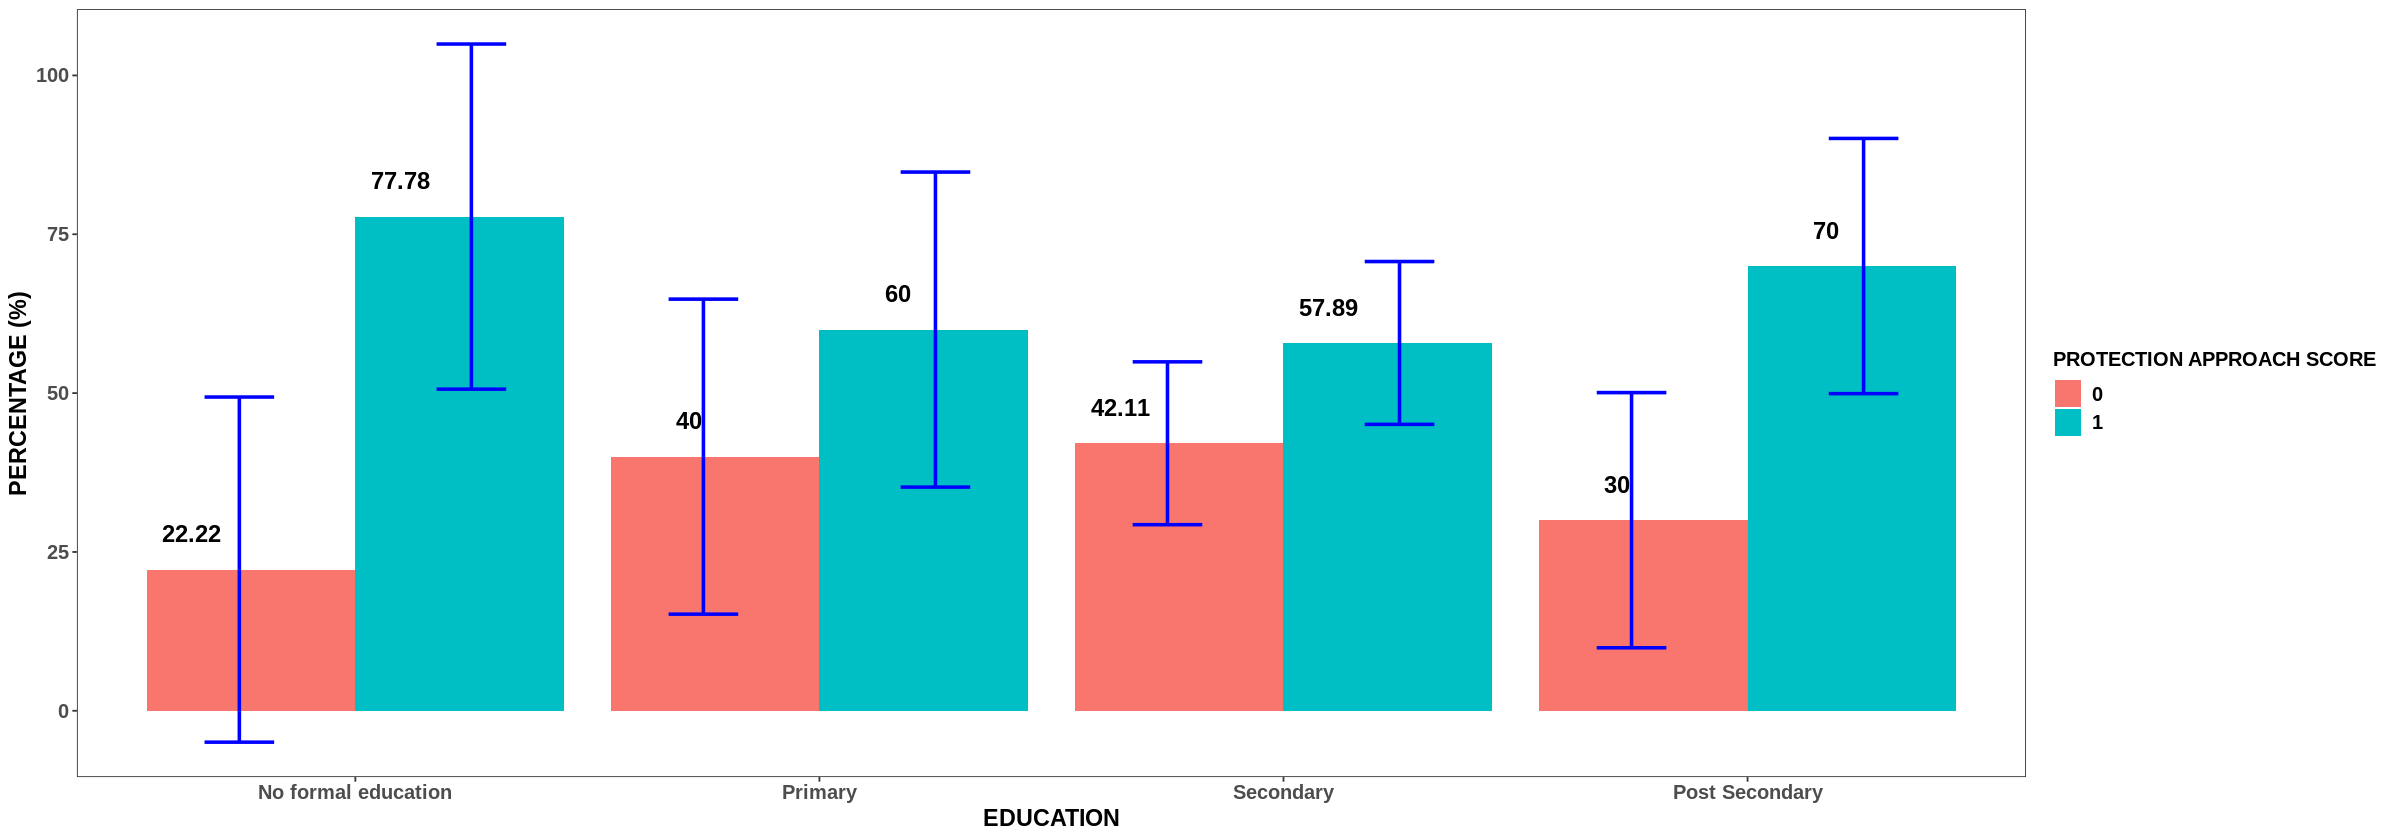



-------------------------------------------


-------------------------------------------
ACCOMODATION

-------------------------------------------


B13                              Freq % Freq    
1 A whole family house              26   25.742574
2 Duplex                             6    5.940594
3 Two/three bedroom flat            16   15.841584
4 Mini flat/self-contain apartment  32   31.683168
5 Room and parlour                  21   20.792079
6 Single room                        0    0.000000
7 Wood & makeshift structure         0    0.000000
8 Total                            101  100.000000

A whole family house Duplex      Two/three bedroom flat
0     8 [ 7.92% ]          2 [ 1.98% ] 9 [ 8.91% ]           
1     18 [ 17.82% ]        4 [ 3.96% ] 7 [ 6.93% ]           
Total 26 [ 25.74% ]        6 [ 5.94% ] 16 [ 15.84% ]         
      Mini flat/self-contain apartment Room and parlour Single room
0     11 [ 10.89% ]                    8 [ 7.92% ]      0 [ 0% ]   
1     21 [ 20.79% ]                    13 [ 12.87% ]    0 [ 0% ]   
Total 32 [ 31.68% ]                    21 [ 20.79% ]    0 [ 0% ]   
      Wood & makeshift structure Total        
0     0 [ 0% ]                   38 [ 37.62% ]
1     0 [ 0% ]                   63 [ 62.38% ]
Total 0 [ 0% ]                   101 [ 100% ]

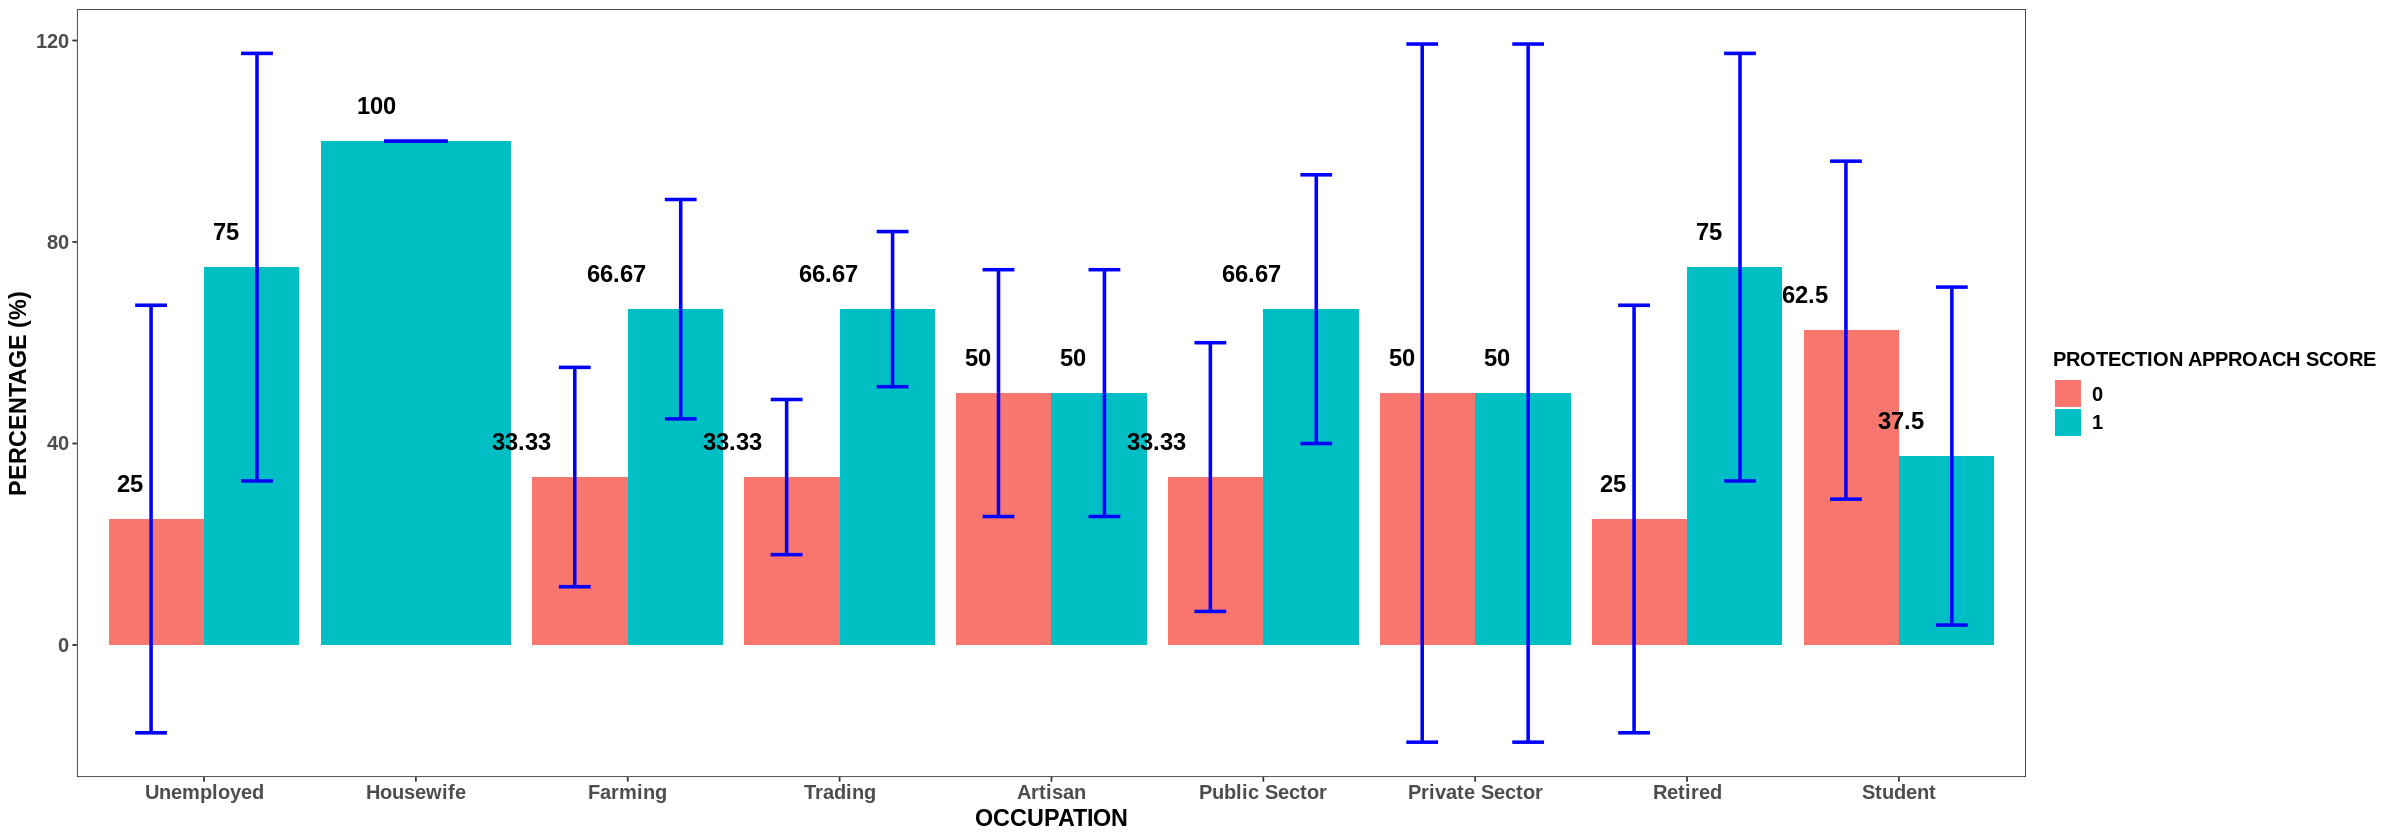



-------------------------------------------


-------------------------------------------
EDUCATION MODIFIED

-------------------------------------------


A5MUT             Freq % Freq   
1 Secondary & Above  77   76.23762
2 Pre Secondary      24   23.76238
3 Total             101  100.00000

Secondary & Above Pre Secondary Total        
0     30 [ 29.7% ]      8 [ 7.92% ]   38 [ 37.62% ]
1     47 [ 46.53% ]     16 [ 15.84% ] 63 [ 62.38% ]
Total 77 [ 76.24% ]     24 [ 23.76% ] 101 [ 100% ]

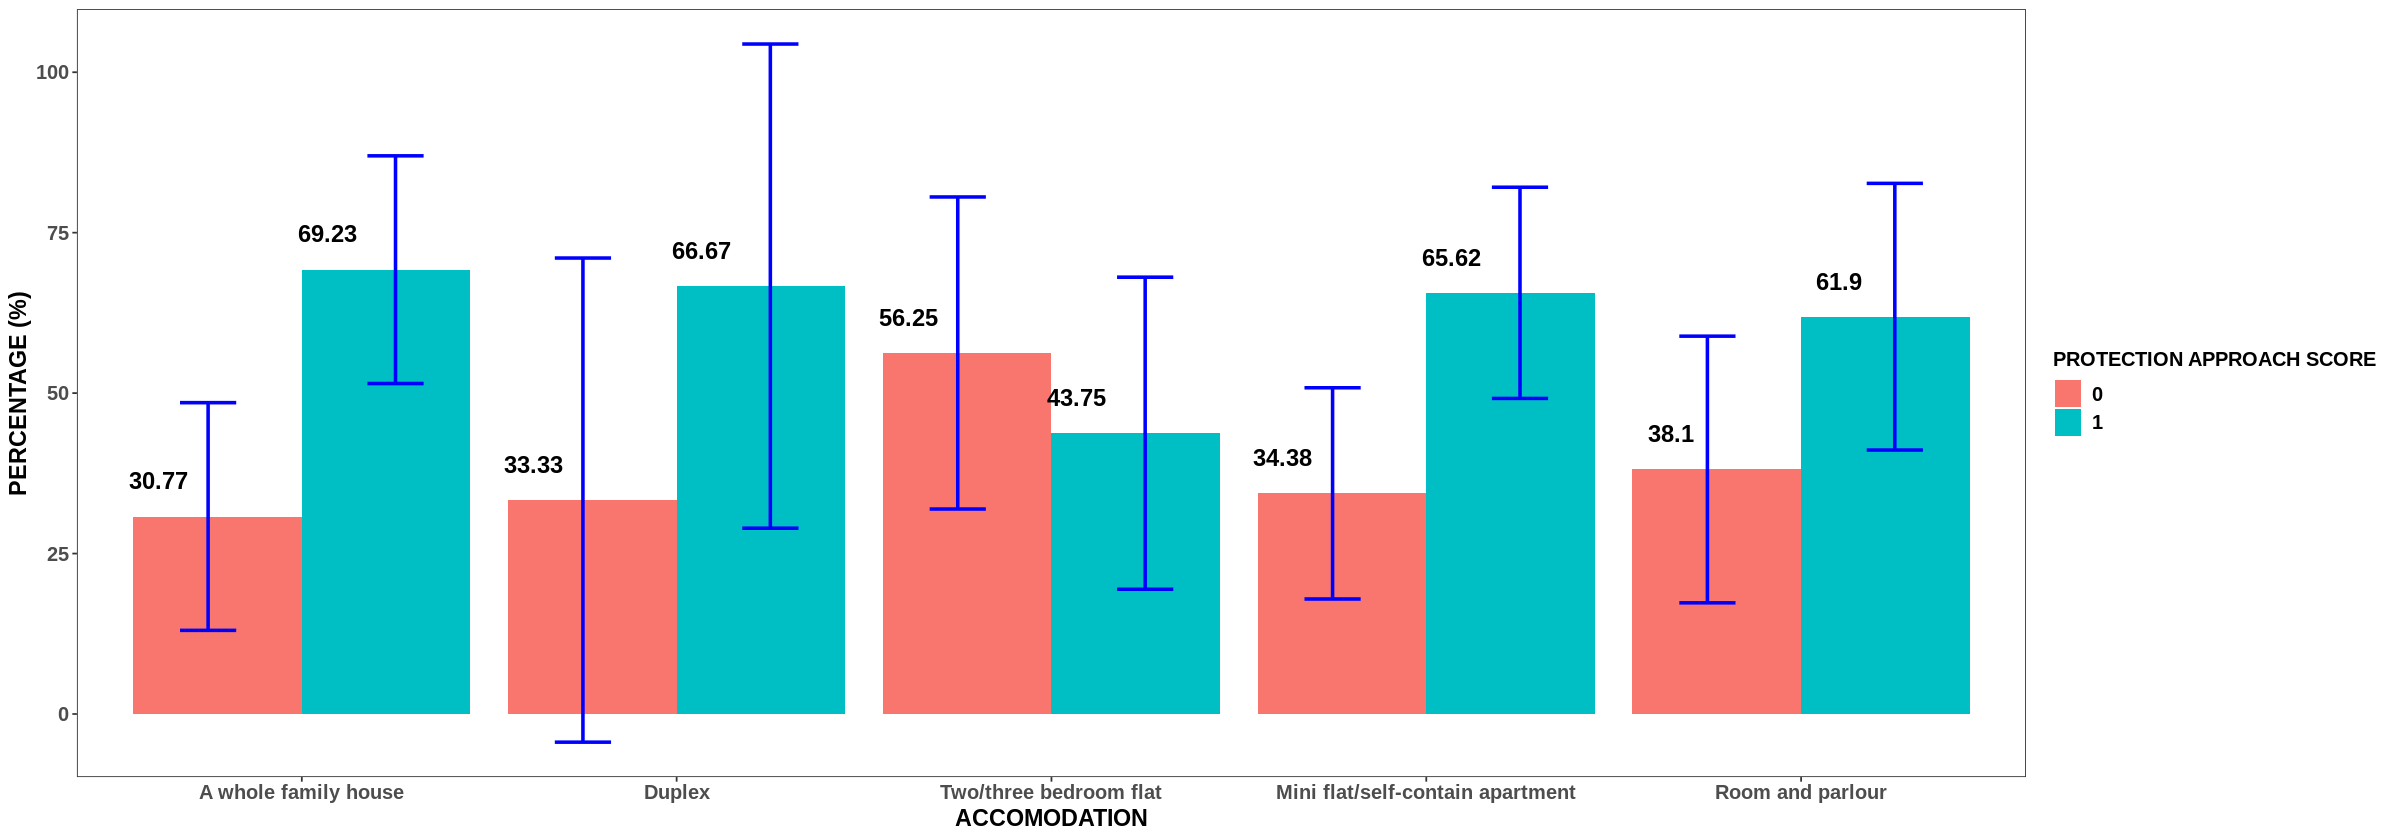



-------------------------------------------


-------------------------------------------
OCCUPATION MODIFIED

-------------------------------------------


A6MUT                  Freq % Freq    
1 Blue Collar             70   69.306931
2 White Collar            18   17.821782
3 Student                  8    7.920792
4 Unemployed & Housewife   5    4.950495
5 Total                  101  100.000000

Blue Collar   White Collar  Student     Unemployed & Housewife
0     26 [ 25.74% ] 6 [ 5.94% ]   5 [ 4.95% ] 1 [ 0.99% ]           
1     44 [ 43.56% ] 12 [ 11.88% ] 3 [ 2.97% ] 4 [ 3.96% ]           
Total 70 [ 69.31% ] 18 [ 17.82% ] 8 [ 7.92% ] 5 [ 4.95% ]           
      Total        
0     38 [ 37.62% ]
1     63 [ 62.38% ]
Total 101 [ 100% ]

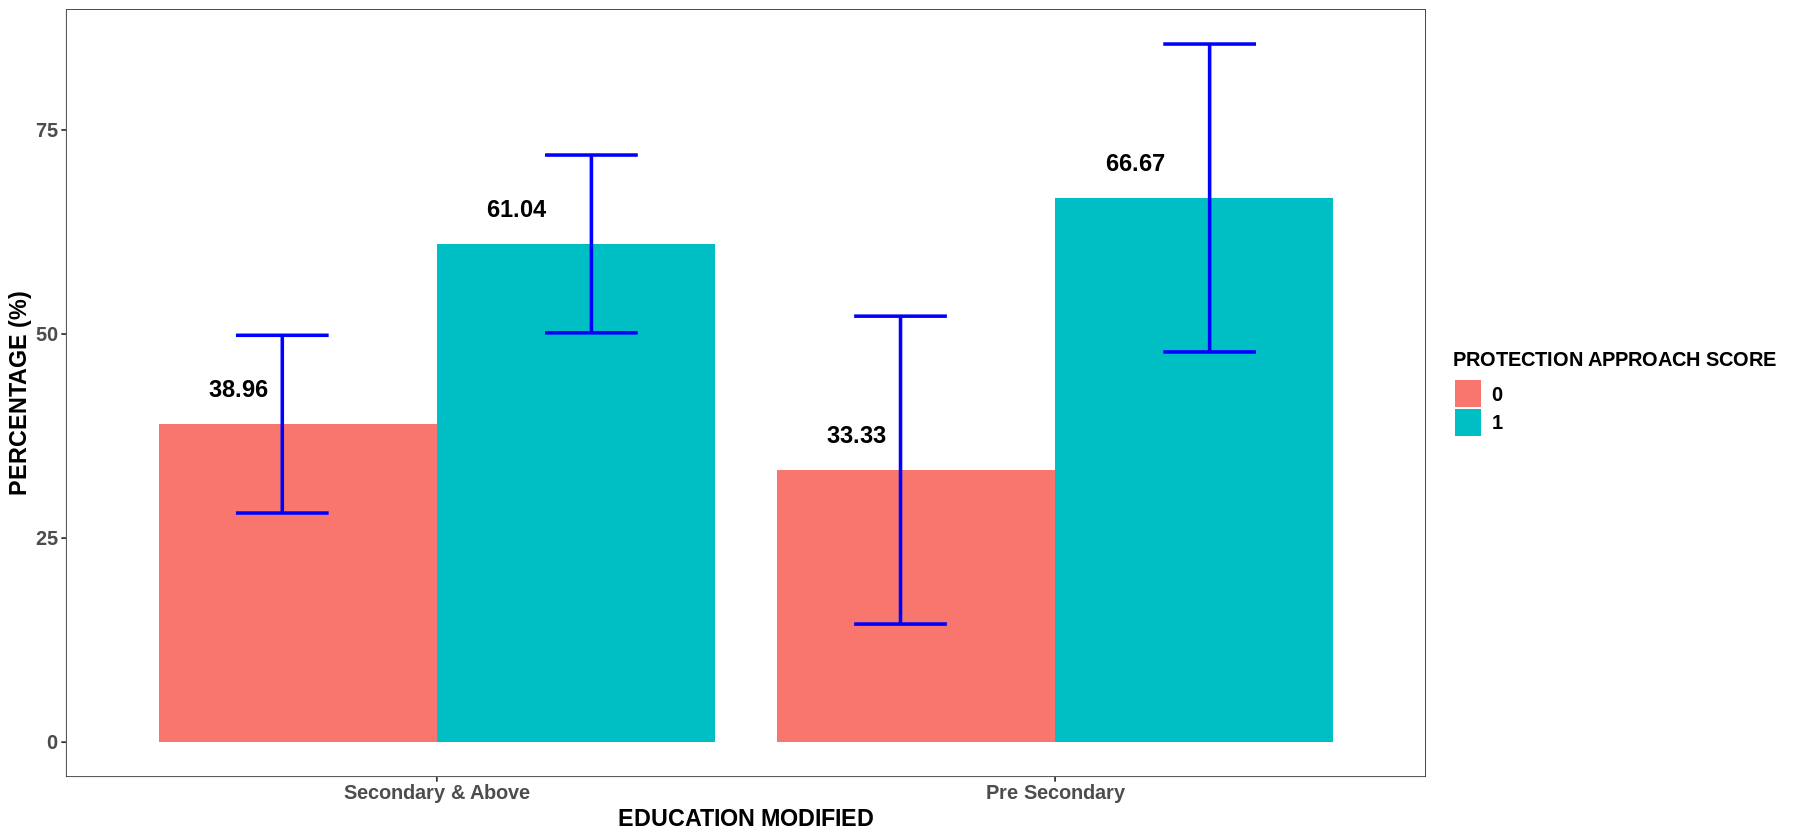



-------------------------------------------


-------------------------------------------
ACCOMODATION MODIFIED

-------------------------------------------


B13MUT       Freq % Freq   
1 Not Spacious  53   52.47525
2 Spacious      48   47.52475
3 Total        101  100.00000

Not Spacious  Spacious      Total        
0     19 [ 18.81% ] 19 [ 18.81% ] 38 [ 37.62% ]
1     34 [ 33.66% ] 29 [ 28.71% ] 63 [ 62.38% ]
Total 53 [ 52.48% ] 48 [ 47.52% ] 101 [ 100% ]

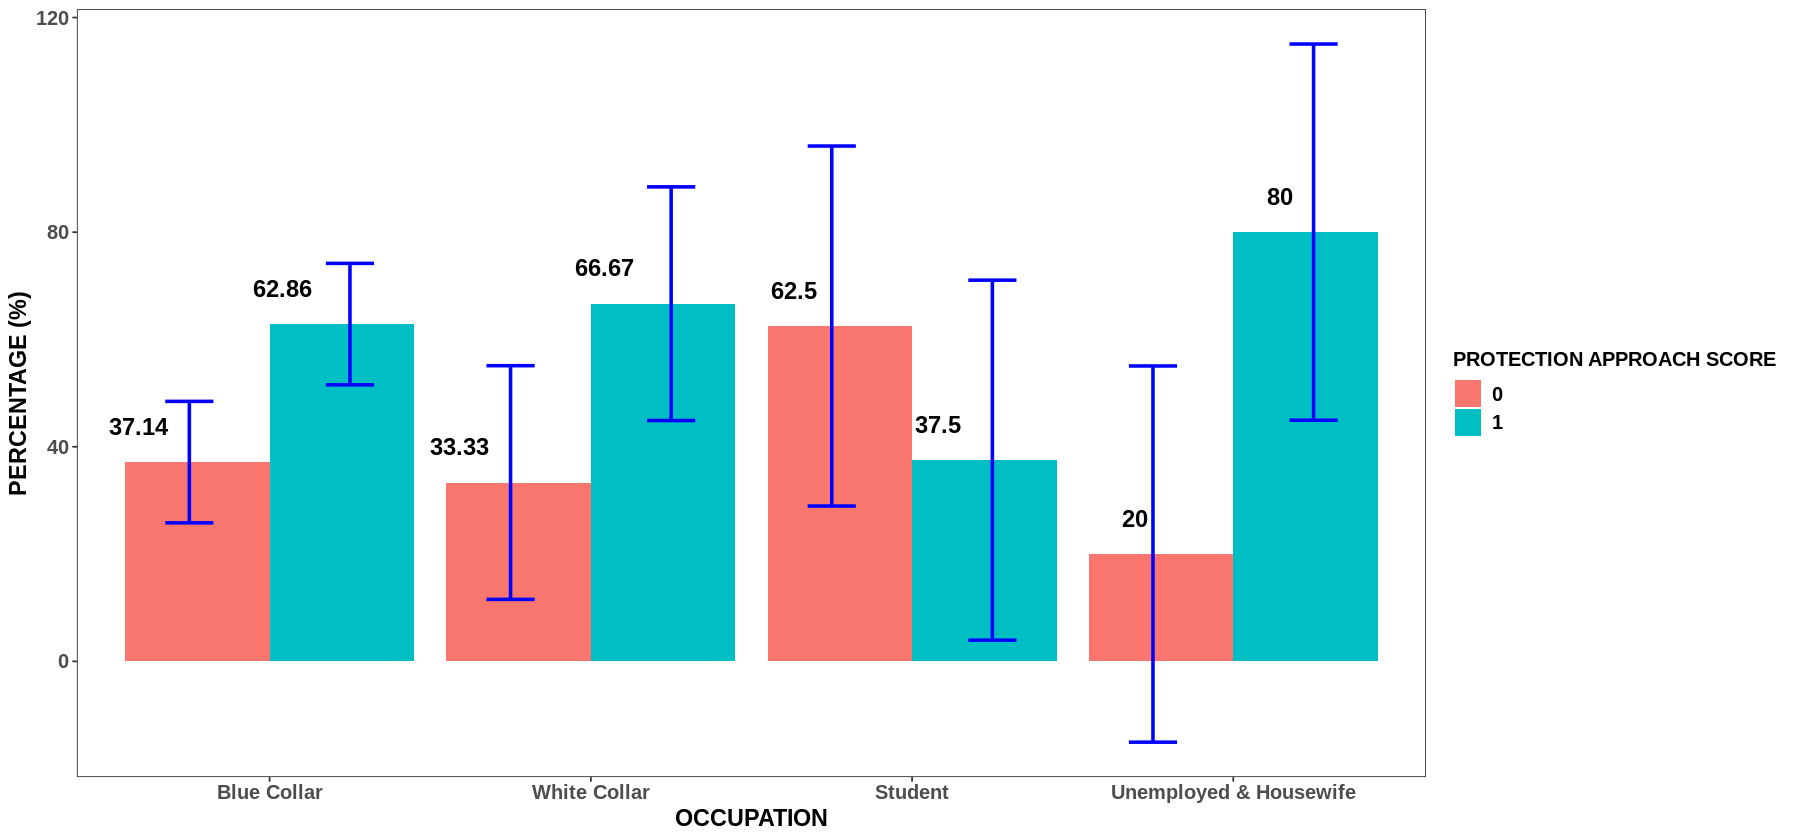

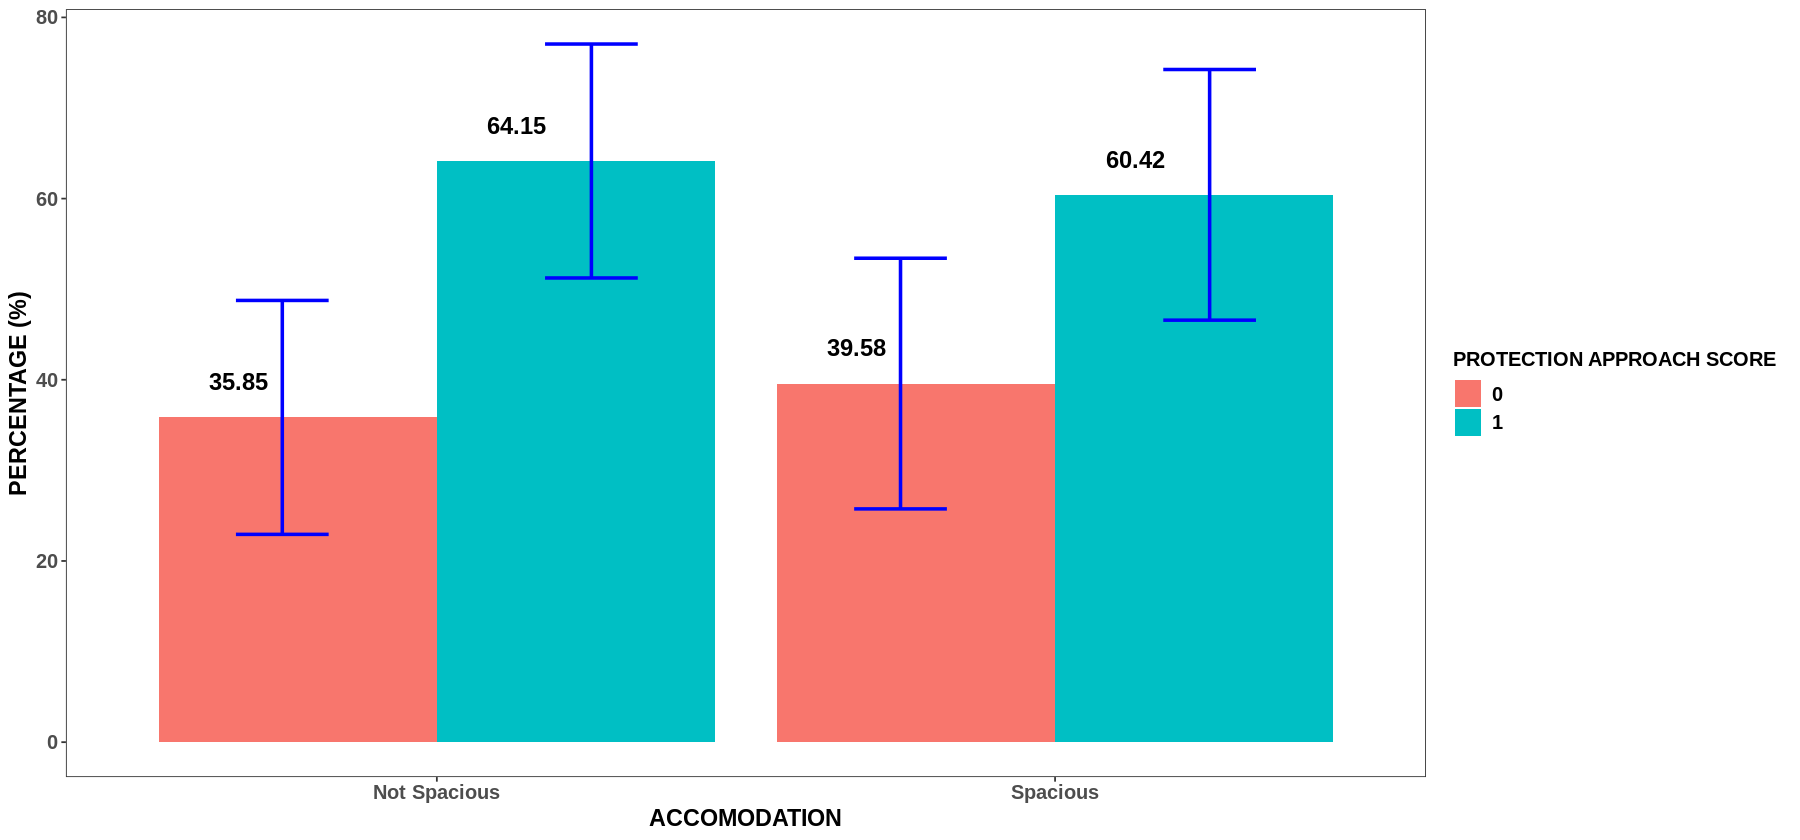

In [ ]:
fig_sizer_fn(12,7)
cat("\n\n-------------------------------------------\n")
cat("\n\n-------------------------------------------\n")

cat("SEX")
cat("\n\n-------------------------------------------\n")
analysis_df = YF_data %>% filter(is.na(high_Protection_Score) == FALSE) %>% filter(is.na(A1) == FALSE)

analysis_df %$% freq(A1)

cat("\n\n\n")

analysis_df %$% ctable_fn(x = high_Protection_Score, y = A1)

cat("\n\n\n")

#============================================================

analysis_CI_cat_df = analysis_df %>% select(high_Protection_Score, A1) %>% group_by(A1, high_Protection_Score) %>%
  summarise(Count = n(), .groups = 'drop') %>% 

  mutate(OverallPercentage = Count/sum(.$Count) ) %>%
  mutate( OverallPercentage = round(OverallPercentage,4) * 100) %>%
  
  group_by(A1) %>% mutate(WithinGroupSum = sum(Count)) %>%
  group_by(high_Protection_Score, .add=TRUE) %>%
  mutate(Percentage = Count/WithinGroupSum , Lower_CI = Percentage - 1.96 * sqrt( Percentage * {1 - Percentage} / WithinGroupSum), Upper_CI = Percentage + 1.96 * sqrt( Percentage * {1 - Percentage} / WithinGroupSum)) %>%
  mutate( Percentage = round(Percentage, 4) * 100, Lower_CI  = round(Lower_CI, 4) * 100, Upper_CI = round(Upper_CI,4) * 100)

ggplot(analysis_CI_cat_df, aes(x = factor(A1), y = Percentage, fill = factor(high_Protection_Score))) +
  geom_bar(position="dodge", stat="identity", width = 0.9) +
   geom_text(aes(label = Percentage), position = position_dodge(0.9), hjust = 1.5, vjust = -1.6, fontface = "bold", size = 5) +
  labs(x = "SEX", y = "PERCENTAGE (%)", fill = "PROTECTION APPROACH SCORE") +  
      geom_errorbar(aes(ymin = Lower_CI, ymax = Upper_CI), width = 0.3 , position = position_dodge(width = 1), color = "blue", size = 1)    +
  theme_minimal(base_size = 18)+
  theme_bw() +
  theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank()) +
  theme(legend.text=element_text(size = 12, face = "bold"), legend.title = element_text(size=12 , face = "bold"), axis.text=element_text(size=12, face="bold"),
        axis.title=element_text(size=14, face="bold"), plot.title = element_text(hjust = 0.5, size = 16, face = "bold"))



cat("\n\n-------------------------------------------\n")
cat("\n\n-------------------------------------------\n")

cat("AGE CONTINUOUS")
cat("\n\n-------------------------------------------\n")

analysis_df = YF_data %>% filter(is.na(high_Protection_Score) == FALSE) %>% filter(is.na(A2) == FALSE)

cat(paste0("\n\n Number of missing observation is: ", nrow(YF_data) - nrow(analysis_df), " out of ", nrow(YF_data), "\n"))
#=======================================================================

analysis_df = analysis_df %>% select(c(A2, high_Protection_Score ))
analysis_df = analysis_df[complete.cases(analysis_df),]

analysis_df$A2 = as.numeric(analysis_df$A2)

cat("\n\n")

#=======================================================================

analysis_CI_cont_df1 = analysis_df %>% group_by(high_Protection_Score) %>%
                       summarise(Count = n(), Mean = mean(A2, na.rm=TRUE), Min = quantile(A2, 0, na.rm=TRUE), Q1 = quantile(A2, 0.25, na.rm=TRUE), 
                       Q2 = quantile(A2, 0.5, na.rm=TRUE),  Q3 = quantile(A2, 0.75, na.rm=TRUE), Max = quantile(A2, 1, na.rm=TRUE),
                       Sd = sd(A2, na.rm=TRUE), .groups = 'drop') %>%
                       mutate( Margin_Error = {Sd/sqrt(Count)} * qt(1-0.05/2, Count - 1)  ) %>% mutate(Mean = round(Mean, 2),  Margin_Error = round(Margin_Error, 2) )
analysis_CI_cont_df1$high_Protection_Score = as.character(analysis_CI_cont_df1$high_Protection_Score)

analysis_CI_cont_df2 = analysis_df %>%
                       summarise(high_Protection_Score =  "Total", Count = n(), Mean = mean(A2, na.rm=TRUE), Min = quantile(A2, 0, na.rm=TRUE), Q1 = quantile(A2, 0.25, na.rm=TRUE), 
                       Q2 = quantile(A2, 0.5, na.rm=TRUE),  Q3 = quantile(A2, 0.75, na.rm=TRUE), Max = quantile(A2, 1, na.rm=TRUE),
                       Sd = sd(A2, na.rm=TRUE), .groups = 'drop') %>%
                       mutate( Margin_Error = {Sd/sqrt(Count)} * qt(1-0.05/2, Count - 1)  ) %>% mutate(Mean = round(Mean, 2),  Margin_Error = round(Margin_Error, 2) )

analysis_CI_cont_df = rbind(analysis_CI_cont_df1, analysis_CI_cont_df2)

analysis_CI_cont_df 

#================================================================


ggplot(analysis_CI_cont_df, aes(x = factor(high_Protection_Score), y = Mean , fill = factor(high_Protection_Score))) +
  geom_bar(position="dodge", stat="identity", width = 0.9) +
  labs(x = "AGE CONT (Answers to Protection Approach Questions)", y = "Mean", fill = "PROTECTION APPROACH SCORE") +  
       geom_text(aes(label = Mean), position = position_dodge(0.9), hjust = 1.5, vjust = -1.6, fontface = "bold", size = 5) +
      geom_errorbar(aes(ymin = Mean  - Margin_Error, ymax = Mean + Margin_Error), width = 0.5, position = position_dodge(width = 0.5), color="blue", size=1)    +
  theme_minimal(base_size = 18)+
  theme_bw() +
  theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank()) +
  theme(legend.text=element_text(size = 12, face = "bold"), legend.title = element_text(size=12 , face = "bold"), axis.text=element_text(size=12, face="bold"),
        axis.title=element_text(size=14, face="bold"), plot.title = element_text(hjust = 0.5, size = 16, face = "bold"))






cat("\n\n-------------------------------------------\n")
cat("\n\n-------------------------------------------\n")

cat("AGE CATEGORICAL")
cat("\n\n-------------------------------------------\n")

analysis_df = YF_data %>% filter(is.na(high_Protection_Score) == FALSE) %>% filter(is.na(AGECAT) == FALSE)

analysis_df %$% freq(AGECAT)

cat("\n\n\n")

analysis_df %$% ctable_fn(x = high_Protection_Score, y = AGECAT)


#============================================================

analysis_CI_cat_df = analysis_df %>% select(high_Protection_Score, AGECAT) %>% group_by(AGECAT, high_Protection_Score) %>%
  summarise(Count = n(), .groups = 'drop') %>% 

  mutate(OverallPercentage = Count/sum(.$Count) ) %>%
  mutate( OverallPercentage = round(OverallPercentage,4) * 100) %>%
  
  group_by(AGECAT) %>% mutate(WithinGroupSum = sum(Count)) %>%
  group_by(high_Protection_Score, .add=TRUE) %>%
  mutate(Percentage = Count/WithinGroupSum , Lower_CI = Percentage - 1.96 * sqrt( Percentage * {1 - Percentage} / WithinGroupSum), Upper_CI = Percentage + 1.96 * sqrt( Percentage * {1 - Percentage} / WithinGroupSum)) %>%
  mutate( Percentage = round(Percentage, 4) * 100, Lower_CI  = round(Lower_CI, 4) * 100, Upper_CI = round(Upper_CI,4) * 100)
fig_sizer_fn(15, 7)
ggplot(analysis_CI_cat_df, aes(x = factor(AGECAT), y = Percentage, fill = factor(high_Protection_Score))) +
  geom_bar(position="dodge", stat="identity", width = 0.9) +
   geom_text(aes(label = Percentage), position = position_dodge(0.9), hjust = 1.5, vjust = -1.6, fontface = "bold", size = 5) +
  labs(x = "AGE CATEGORICAL", y = "PERCENTAGE (%)", fill = "PROTECTION APPROACH SCORE") +  
      geom_errorbar(aes(ymin = Lower_CI, ymax = Upper_CI), width = 0.3 , position = position_dodge(width = 1), color = "blue", size = 1)    +
  theme_minimal(base_size = 18)+
  theme_bw() +
  theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank()) +
  theme(legend.text=element_text(size = 12, face = "bold"), legend.title = element_text(size=12 , face = "bold"), axis.text=element_text(size=12, face="bold"),
        axis.title=element_text(size=14, face="bold"), plot.title = element_text(hjust = 0.5, size = 16, face = "bold"))



cat("\n\n-------------------------------------------\n")
cat("\n\n-------------------------------------------\n")

cat("EDUCATION")
cat("\n\n-------------------------------------------\n")

analysis_df = YF_data %>% filter(is.na(high_Protection_Score) == FALSE) %>% filter(is.na(A5) == FALSE)

analysis_df %$% freq(A5)

cat("\n\n\n")

analysis_df %$% ctable_fn(x = high_Protection_Score, y = A5)


#============================================================

analysis_CI_cat_df = analysis_df %>% select(high_Protection_Score, A5) %>% group_by(A5, high_Protection_Score) %>%
  summarise(Count = n(), .groups = 'drop') %>% 

  mutate(OverallPercentage = Count/sum(.$Count) ) %>%
  mutate( OverallPercentage = round(OverallPercentage,4) * 100) %>%
  
  group_by(A5) %>% mutate(WithinGroupSum = sum(Count)) %>%
  group_by(high_Protection_Score, .add=TRUE) %>%
  mutate(Percentage = Count/WithinGroupSum , Lower_CI = Percentage - 1.96 * sqrt( Percentage * {1 - Percentage} / WithinGroupSum), Upper_CI = Percentage + 1.96 * sqrt( Percentage * {1 - Percentage} / WithinGroupSum)) %>%
  mutate( Percentage = round(Percentage, 4) * 100, Lower_CI  = round(Lower_CI, 4) * 100, Upper_CI = round(Upper_CI,4) * 100)

fig_sizer_fn(20, 7)

ggplot(analysis_CI_cat_df, aes(x = factor(A5), y = Percentage, fill = factor(high_Protection_Score))) +
  geom_bar(position="dodge", stat="identity", width = 0.9) +
   geom_text(aes(label = Percentage), position = position_dodge(0.9), hjust = 1.5, vjust = -1.6, fontface = "bold", size = 5) +
  labs(x = "EDUCATION", y = "PERCENTAGE (%)", fill = "PROTECTION APPROACH SCORE") +  
      geom_errorbar(aes(ymin = Lower_CI, ymax = Upper_CI), width = 0.3 , position = position_dodge(width = 1), color = "blue", size = 1)    +
  theme_minimal(base_size = 18)+
  theme_bw() +
  theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank()) +
  theme(legend.text=element_text(size = 12, face = "bold"), legend.title = element_text(size=12 , face = "bold"), axis.text=element_text(size=12, face="bold"),
        axis.title=element_text(size=14, face="bold"), plot.title = element_text(hjust = 0.5, size = 16, face = "bold"))



cat("\n\n-------------------------------------------\n")
cat("\n\n-------------------------------------------\n")

cat("OCCUPATION")
cat("\n\n-------------------------------------------\n")

analysis_df = YF_data %>% filter(is.na(high_Protection_Score) == FALSE) %>% filter(is.na(A6) == FALSE)

analysis_df %$% freq(A6)

cat("\n\n\n")

analysis_df %$% ctable_fn(x = high_Protection_Score, y = A6)


#============================================================

analysis_CI_cat_df = analysis_df %>% select(high_Protection_Score, A6) %>% group_by(A6, high_Protection_Score) %>%
  summarise(Count = n(), .groups = 'drop') %>% 

  mutate(OverallPercentage = Count/sum(.$Count) ) %>%
  mutate( OverallPercentage = round(OverallPercentage,4) * 100) %>%
  
  group_by(A6) %>% mutate(WithinGroupSum = sum(Count)) %>%
  group_by(high_Protection_Score, .add=TRUE) %>%
  mutate(Percentage = Count/WithinGroupSum , Lower_CI = Percentage - 1.96 * sqrt( Percentage * {1 - Percentage} / WithinGroupSum), Upper_CI = Percentage + 1.96 * sqrt( Percentage * {1 - Percentage} / WithinGroupSum)) %>%
  mutate( Percentage = round(Percentage, 4) * 100, Lower_CI  = round(Lower_CI, 4) * 100, Upper_CI = round(Upper_CI,4) * 100)

fig_sizer_fn(20, 7)

ggplot(analysis_CI_cat_df, aes(x = factor(A6), y = Percentage, fill = factor(high_Protection_Score))) +
  geom_bar(position="dodge", stat="identity", width = 0.9) +
   geom_text(aes(label = Percentage), position = position_dodge(0.9), hjust = 1.5, vjust = -1.6, fontface = "bold", size = 5) +
  labs(x = "OCCUPATION", y = "PERCENTAGE (%)", fill = "PROTECTION APPROACH SCORE") +  
      geom_errorbar(aes(ymin = Lower_CI, ymax = Upper_CI), width = 0.3 , position = position_dodge(width = 1), color = "blue", size = 1)    +
  theme_minimal(base_size = 18)+
  theme_bw() +
  theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank()) +
  theme(legend.text=element_text(size = 12, face = "bold"), legend.title = element_text(size=12 , face = "bold"), axis.text=element_text(size=12, face="bold"),
        axis.title=element_text(size=14, face="bold"), plot.title = element_text(hjust = 0.5, size = 16, face = "bold"))




cat("\n\n-------------------------------------------\n")
cat("\n\n-------------------------------------------\n")

cat("ACCOMODATION")
cat("\n\n-------------------------------------------\n")

analysis_df = YF_data %>% filter(is.na(high_Protection_Score) == FALSE) %>% filter(is.na(B13) == FALSE)

analysis_df %$% freq(B13)

cat("\n\n\n")

analysis_df %$% ctable_fn(x = high_Protection_Score, y = B13)


#============================================================

analysis_CI_cat_df = analysis_df %>% select(high_Protection_Score, B13) %>% group_by(B13, high_Protection_Score) %>%
  summarise(Count = n(), .groups = 'drop') %>% 

  mutate(OverallPercentage = Count/sum(.$Count) ) %>%
  mutate( OverallPercentage = round(OverallPercentage,4) * 100) %>%
  
  group_by(B13) %>% mutate(WithinGroupSum = sum(Count)) %>%
  group_by(high_Protection_Score, .add=TRUE) %>%
  mutate(Percentage = Count/WithinGroupSum , Lower_CI = Percentage - 1.96 * sqrt( Percentage * {1 - Percentage} / WithinGroupSum), Upper_CI = Percentage + 1.96 * sqrt( Percentage * {1 - Percentage} / WithinGroupSum)) %>%
  mutate( Percentage = round(Percentage, 4) * 100, Lower_CI  = round(Lower_CI, 4) * 100, Upper_CI = round(Upper_CI,4) * 100)

fig_sizer_fn(20, 7)

ggplot(analysis_CI_cat_df, aes(x = factor(B13), y = Percentage, fill = factor(high_Protection_Score))) +
  geom_bar(position="dodge", stat="identity", width = 0.9) +
   geom_text(aes(label = Percentage), position = position_dodge(0.9), hjust = 1.5, vjust = -1.6, fontface = "bold", size = 5) +
  labs(x = "ACCOMODATION", y = "PERCENTAGE (%)", fill = "PROTECTION APPROACH SCORE") +  
      geom_errorbar(aes(ymin = Lower_CI, ymax = Upper_CI), width = 0.3 , position = position_dodge(width = 1), color = "blue", size = 1)    +
  theme_minimal(base_size = 18)+
  theme_bw() +
  theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank()) +
  theme(legend.text=element_text(size = 12, face = "bold"), legend.title = element_text(size=12 , face = "bold"), axis.text=element_text(size=12, face="bold"),
        axis.title=element_text(size=14, face="bold"), plot.title = element_text(hjust = 0.5, size = 16, face = "bold"))



#====================================================================================================================
#====================================================================================================================
#====================================================================================================================
#====================================================================================================================


fig_sizer_fn()

cat("\n\n-------------------------------------------\n")
cat("\n\n-------------------------------------------\n")

cat("EDUCATION MODIFIED")
cat("\n\n-------------------------------------------\n")

analysis_df = YF_data %>% filter(is.na(high_Protection_Score) == FALSE) %>% filter(is.na(A5MUT) == FALSE)

analysis_df %$% freq(A5MUT)

cat("\n\n\n")

analysis_df %$% ctable_fn(x = high_Protection_Score, y = A5MUT)


#============================================================

analysis_CI_cat_df = analysis_df %>% select(high_Protection_Score, A5MUT) %>% group_by(A5MUT, high_Protection_Score) %>%
  summarise(Count = n(), .groups = 'drop') %>% 

  mutate(OverallPercentage = Count/sum(.$Count) ) %>%
  mutate( OverallPercentage = round(OverallPercentage,4) * 100) %>%
  
  group_by(A5MUT) %>% mutate(WithinGroupSum = sum(Count)) %>%
  group_by(high_Protection_Score, .add=TRUE) %>%
  mutate(Percentage = Count/WithinGroupSum , Lower_CI = Percentage - 1.96 * sqrt( Percentage * {1 - Percentage} / WithinGroupSum), Upper_CI = Percentage + 1.96 * sqrt( Percentage * {1 - Percentage} / WithinGroupSum)) %>%
  mutate( Percentage = round(Percentage, 4) * 100, Lower_CI  = round(Lower_CI, 4) * 100, Upper_CI = round(Upper_CI,4) * 100)

fig_sizer_fn(15, 7)

ggplot(analysis_CI_cat_df, aes(x = factor(A5MUT), y = Percentage, fill = factor(high_Protection_Score))) +
  geom_bar(position="dodge", stat="identity", width = 0.9) +
   geom_text(aes(label = Percentage), position = position_dodge(0.9), hjust = 1.5, vjust = -1.6, fontface = "bold", size = 5) +
  labs(x = "EDUCATION MODIFIED", y = "PERCENTAGE (%)", fill = "PROTECTION APPROACH SCORE") +  
      geom_errorbar(aes(ymin = Lower_CI, ymax = Upper_CI), width = 0.3 , position = position_dodge(width = 1), color = "blue", size = 1)    +
  theme_minimal(base_size = 18)+
  theme_bw() +
  theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank()) +
  theme(legend.text=element_text(size = 12, face = "bold"), legend.title = element_text(size=12 , face = "bold"), axis.text=element_text(size=12, face="bold"),
        axis.title=element_text(size=14, face="bold"), plot.title = element_text(hjust = 0.5, size = 16, face = "bold"))



cat("\n\n-------------------------------------------\n")
cat("\n\n-------------------------------------------\n")

cat("OCCUPATION MODIFIED")
cat("\n\n-------------------------------------------\n")

analysis_df = YF_data %>% filter(is.na(high_Protection_Score) == FALSE) %>% filter(is.na(A6MUT) == FALSE)

analysis_df %$% freq(A6MUT)

cat("\n\n\n")

analysis_df %$% ctable_fn(x = high_Protection_Score, y = A6MUT)


#============================================================

analysis_CI_cat_df = analysis_df %>% select(high_Protection_Score, A6MUT) %>% group_by(A6MUT, high_Protection_Score) %>%
  summarise(Count = n(), .groups = 'drop') %>% 

  mutate(OverallPercentage = Count/sum(.$Count) ) %>%
  mutate( OverallPercentage = round(OverallPercentage,4) * 100) %>%
  
  group_by(A6MUT) %>% mutate(WithinGroupSum = sum(Count)) %>%
  group_by(high_Protection_Score, .add=TRUE) %>%
  mutate(Percentage = Count/WithinGroupSum , Lower_CI = Percentage - 1.96 * sqrt( Percentage * {1 - Percentage} / WithinGroupSum), Upper_CI = Percentage + 1.96 * sqrt( Percentage * {1 - Percentage} / WithinGroupSum)) %>%
  mutate( Percentage = round(Percentage, 4) * 100, Lower_CI  = round(Lower_CI, 4) * 100, Upper_CI = round(Upper_CI,4) * 100)

fig_sizer_fn(15, 7)

ggplot(analysis_CI_cat_df, aes(x = factor(A6MUT), y = Percentage, fill = factor(high_Protection_Score))) +
  geom_bar(position="dodge", stat="identity", width = 0.9) +
   geom_text(aes(label = Percentage), position = position_dodge(0.9), hjust = 1.5, vjust = -1.6, fontface = "bold", size = 5) +
  labs(x = "OCCUPATION", y = "PERCENTAGE (%)", fill = "PROTECTION APPROACH SCORE") +  
      geom_errorbar(aes(ymin = Lower_CI, ymax = Upper_CI), width = 0.3 , position = position_dodge(width = 1), color = "blue", size = 1)    +
  theme_minimal(base_size = 18)+
  theme_bw() +
  theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank()) +
  theme(legend.text=element_text(size = 12, face = "bold"), legend.title = element_text(size=12 , face = "bold"), axis.text=element_text(size=12, face="bold"),
        axis.title=element_text(size=14, face="bold"), plot.title = element_text(hjust = 0.5, size = 16, face = "bold"))




cat("\n\n-------------------------------------------\n")
cat("\n\n-------------------------------------------\n")

cat("ACCOMODATION MODIFIED")
cat("\n\n-------------------------------------------\n")

analysis_df = YF_data %>% filter(is.na(high_Protection_Score) == FALSE) %>% filter(is.na(B13MUT) == FALSE)

analysis_df %$% freq(B13MUT)

cat("\n\n\n")

analysis_df %$% ctable_fn(x = high_Protection_Score, y = B13MUT)


#============================================================

analysis_CI_cat_df = analysis_df %>% select(high_Protection_Score, B13MUT) %>% group_by(B13MUT, high_Protection_Score) %>%
  summarise(Count = n(), .groups = 'drop') %>% 

  mutate(OverallPercentage = Count/sum(.$Count) ) %>%
  mutate( OverallPercentage = round(OverallPercentage,4) * 100) %>%
  
  group_by(B13MUT) %>% mutate(WithinGroupSum = sum(Count)) %>%
  group_by(high_Protection_Score, .add=TRUE) %>%
  mutate(Percentage = Count/WithinGroupSum , Lower_CI = Percentage - 1.96 * sqrt( Percentage * {1 - Percentage} / WithinGroupSum), Upper_CI = Percentage + 1.96 * sqrt( Percentage * {1 - Percentage} / WithinGroupSum)) %>%
  mutate( Percentage = round(Percentage, 4) * 100, Lower_CI  = round(Lower_CI, 4) * 100, Upper_CI = round(Upper_CI,4) * 100)

fig_sizer_fn(15, 7)

ggplot(analysis_CI_cat_df, aes(x = factor(B13MUT), y = Percentage, fill = factor(high_Protection_Score))) +
  geom_bar(position="dodge", stat="identity", width = 0.9) +
   geom_text(aes(label = Percentage), position = position_dodge(0.9), hjust = 1.5, vjust = -1.6, fontface = "bold", size = 5) +
  labs(x = "ACCOMODATION", y = "PERCENTAGE (%)", fill = "PROTECTION APPROACH SCORE") +  
      geom_errorbar(aes(ymin = Lower_CI, ymax = Upper_CI), width = 0.3 , position = position_dodge(width = 1), color = "blue", size = 1)    +
  theme_minimal(base_size = 18)+
  theme_bw() +
  theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank()) +
  theme(legend.text=element_text(size = 12, face = "bold"), legend.title = element_text(size=12 , face = "bold"), axis.text=element_text(size=12, face="bold"),
        axis.title=element_text(size=14, face="bold"), plot.title = element_text(hjust = 0.5, size = 16, face = "bold"))



#### **LLIN Non-Usage Reasons**



-------------------------------------------


-------------------------------------------
SEX

-------------------------------------------


A1     Freq % Freq   
1 Male    42   41.58416
2 Female  59   58.41584
3 Total  101  100.00000

Male          Female        Total        
0     21 [ 20.79% ] 32 [ 31.68% ] 53 [ 52.48% ]
1     21 [ 20.79% ] 27 [ 26.73% ] 48 [ 47.52% ]
Total 42 [ 41.58% ] 59 [ 58.42% ] 101 [ 100% ]






-------------------------------------------


-------------------------------------------
AGE CONTINUOUS

-------------------------------------------


 Number of missing observation is: 0 out of 101




high_LLIN_non_usage Count Mean  Min Q1    Q2 Q3 Max Sd       Margin_Error
1 0                    53   25.43 5   17.00 25 32 48  11.04451 3.04        
2 1                    48   22.19 1    8.75 26 35 45  13.86048 4.02        
3 Total               101   23.89 1   14.00 25 33 48  12.50512 2.47

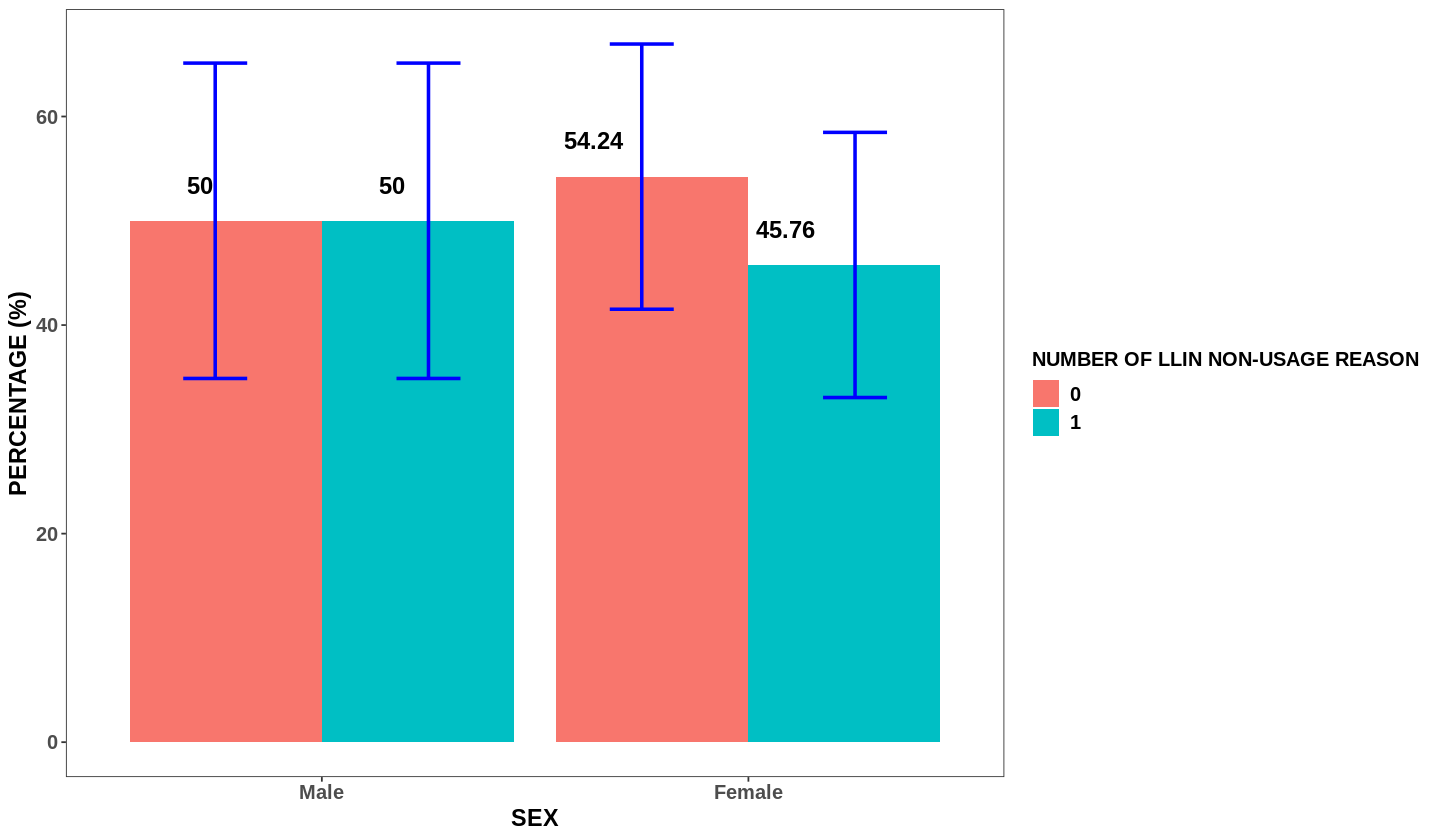



-------------------------------------------


-------------------------------------------
AGE CATEGORICAL

-------------------------------------------


AGECAT     Freq % Freq   
1 18 to 35    31   30.69307
2 35 to 60    57   56.43564
3 60 & above  13   12.87129
4 Total      101  100.00000

18 to 35      35 to 60      60 & above    Total        
0     13 [ 12.87% ] 33 [ 32.67% ] 7 [ 6.93% ]   53 [ 52.48% ]
1     18 [ 17.82% ] 24 [ 23.76% ] 6 [ 5.94% ]   48 [ 47.52% ]
Total 31 [ 30.69% ] 57 [ 56.44% ] 13 [ 12.87% ] 101 [ 100% ]

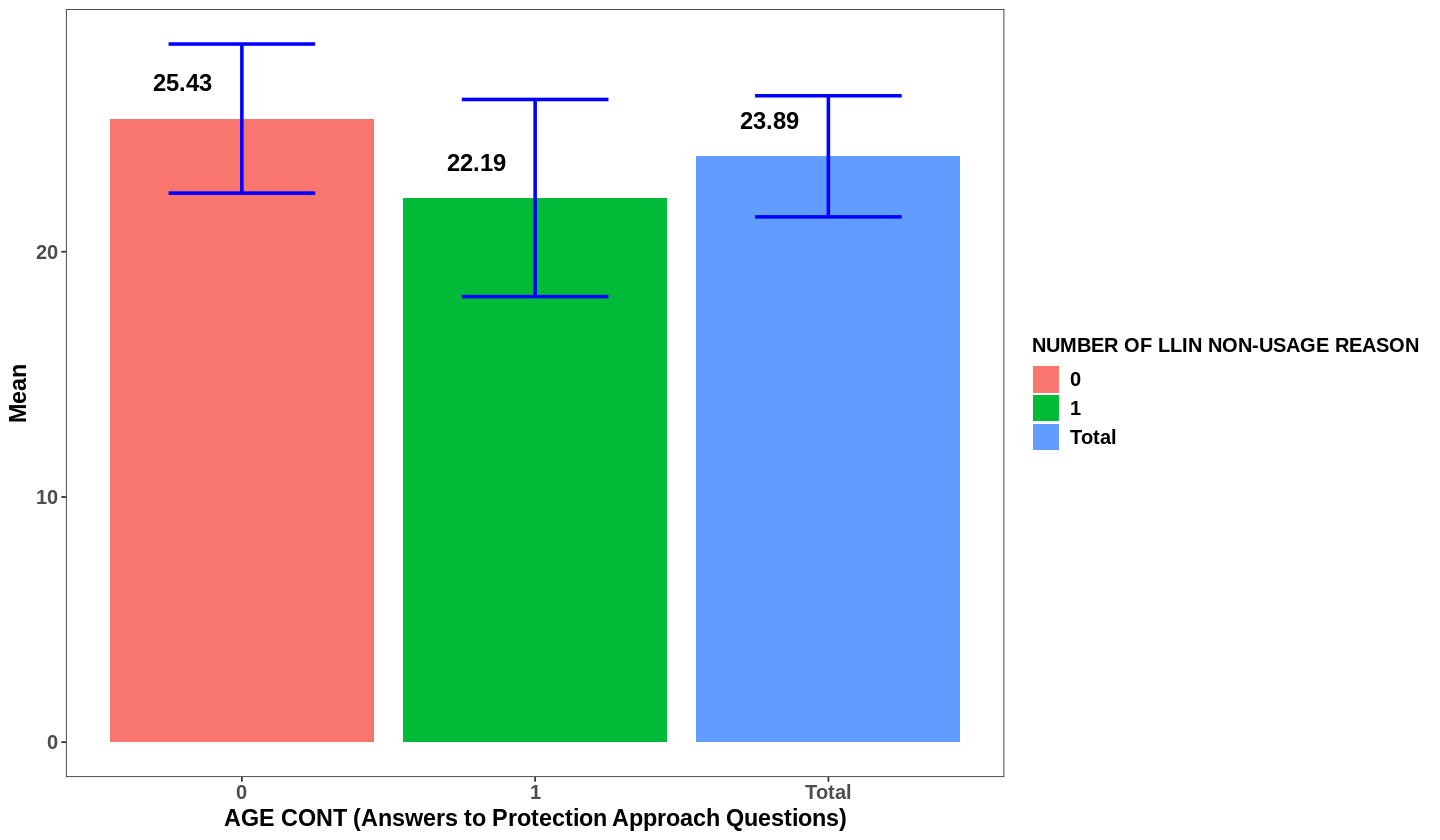



-------------------------------------------


-------------------------------------------
EDUCATION

-------------------------------------------


A5                  Freq % Freq    
1 No formal education   9    8.910891
2 Primary              15   14.851485
3 Secondary            57   56.435644
4 Post Secondary       20   19.801980
5 Total               101  100.000000

No formal education Primary       Secondary     Post Secondary
0     6 [ 5.94% ]         8 [ 7.92% ]   28 [ 27.72% ] 11 [ 10.89% ] 
1     3 [ 2.97% ]         7 [ 6.93% ]   29 [ 28.71% ] 9 [ 8.91% ]   
Total 9 [ 8.91% ]         15 [ 14.85% ] 57 [ 56.44% ] 20 [ 19.8% ]  
      Total        
0     53 [ 52.48% ]
1     48 [ 47.52% ]
Total 101 [ 100% ]

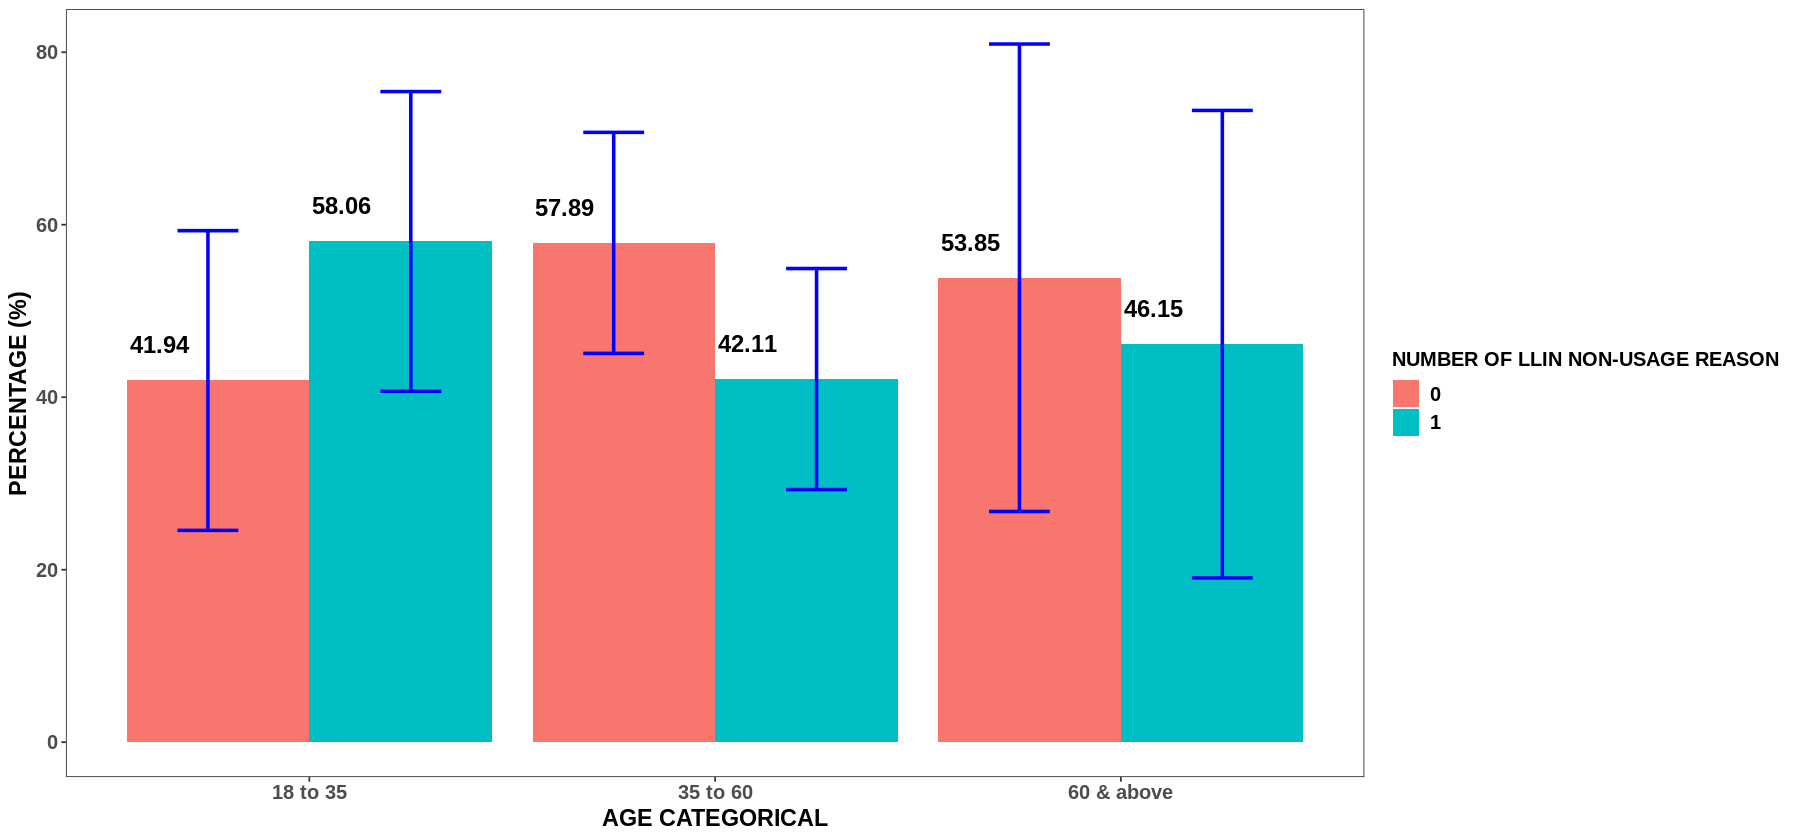



-------------------------------------------


-------------------------------------------
OCCUPATION

-------------------------------------------


A6             Freq % Freq    
1  Unemployed       4    3.960396
2  Housewife        1    0.990099
3  Farming         18   17.821782
4  Trading         36   35.643564
5  Artisan         16   15.841584
6  Public Sector   12   11.881188
7  Private Sector   2    1.980198
8  Retired          4    3.960396
9  Student          8    7.920792
10 Total          101  100.000000

Unemployed  Housewife   Farming       Trading       Artisan      
0     1 [ 0.99% ] 1 [ 0.99% ] 12 [ 11.88% ] 20 [ 19.8% ]  7 [ 6.93% ]  
1     3 [ 2.97% ] 0 [ 0% ]    6 [ 5.94% ]   16 [ 15.84% ] 9 [ 8.91% ]  
Total 4 [ 3.96% ] 1 [ 0.99% ] 18 [ 17.82% ] 36 [ 35.64% ] 16 [ 15.84% ]
      Public Sector Private Sector Retired     Student     Total        
0     8 [ 7.92% ]   1 [ 0.99% ]    3 [ 2.97% ] 0 [ 0% ]    53 [ 52.48% ]
1     4 [ 3.96% ]   1 [ 0.99% ]    1 [ 0.99% ] 8 [ 7.92% ] 48 [ 47.52% ]
Total 12 [ 11.88% ] 2 [ 1.98% ]    4 [ 3.96% ] 8 [ 7.92% ] 101 [ 100% ]

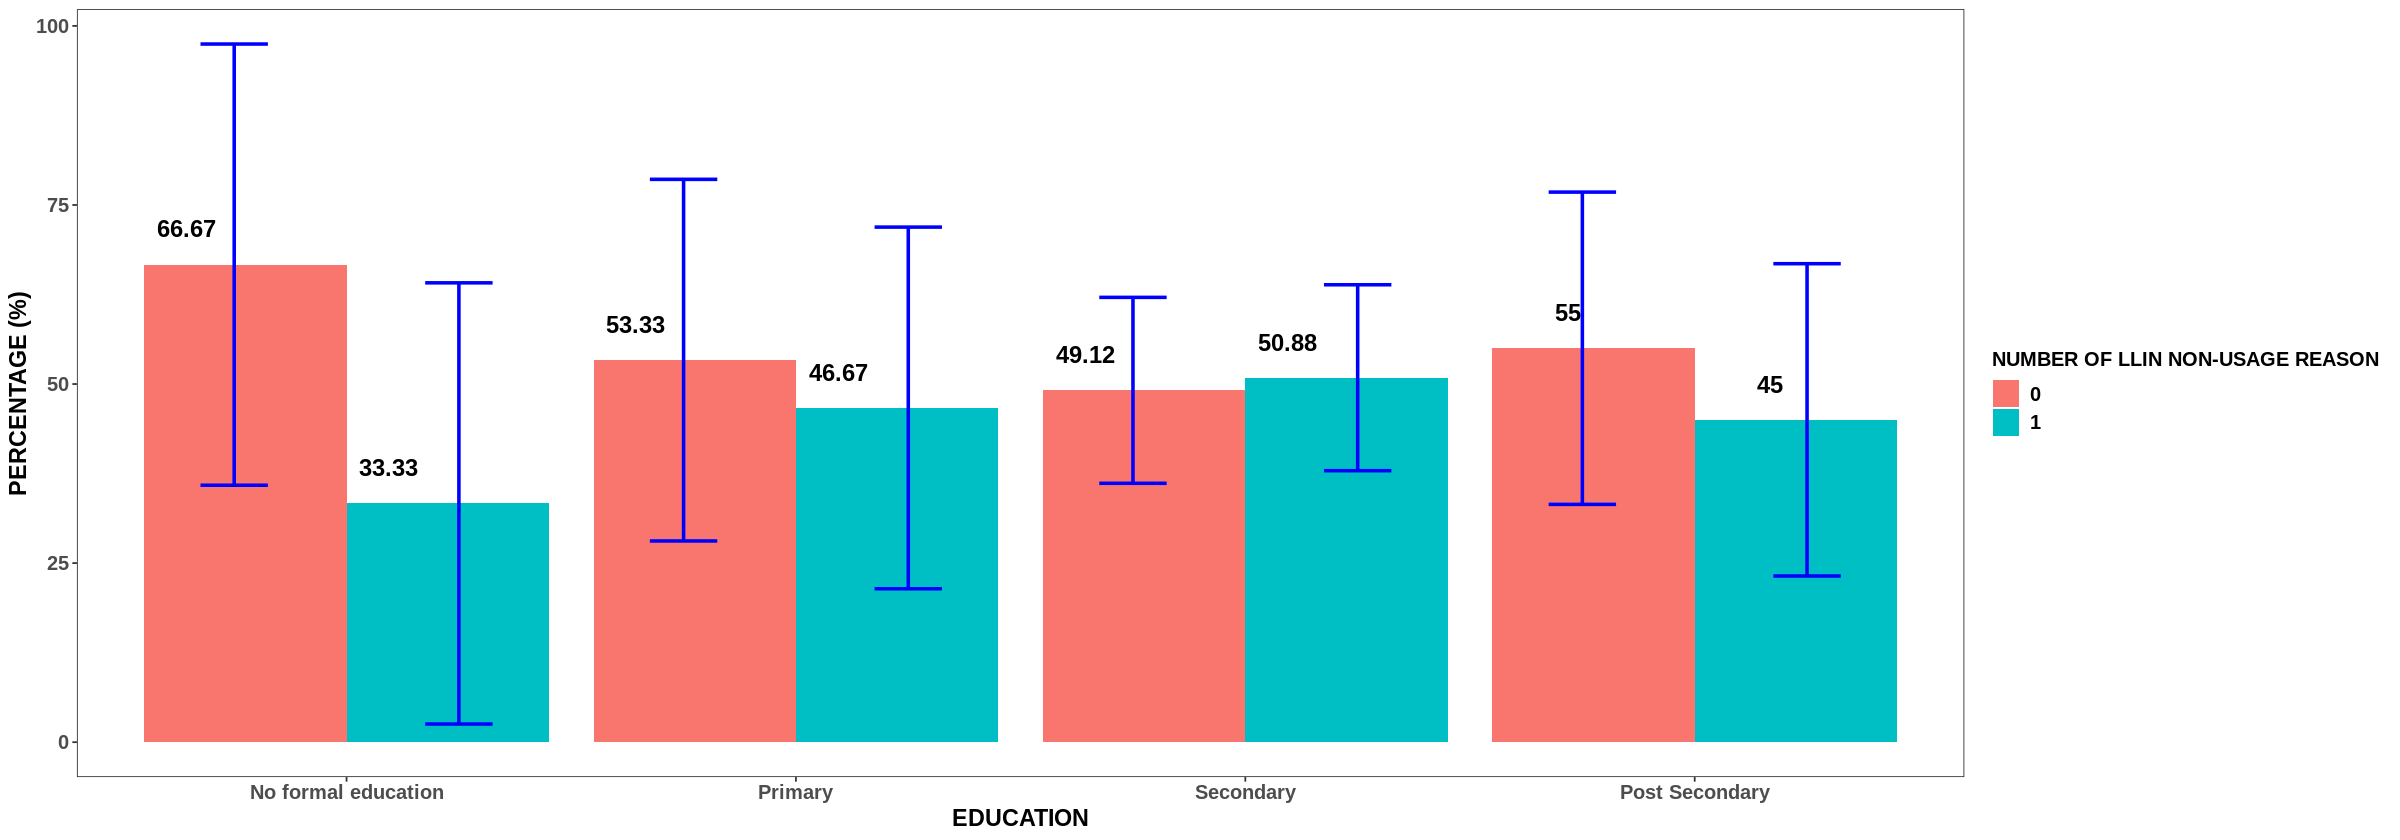



-------------------------------------------


-------------------------------------------
ACCOMODATION

-------------------------------------------


B13                              Freq % Freq    
1 A whole family house              26   25.742574
2 Duplex                             6    5.940594
3 Two/three bedroom flat            16   15.841584
4 Mini flat/self-contain apartment  32   31.683168
5 Room and parlour                  21   20.792079
6 Single room                        0    0.000000
7 Wood & makeshift structure         0    0.000000
8 Total                            101  100.000000

A whole family house Duplex      Two/three bedroom flat
0     14 [ 13.86% ]        2 [ 1.98% ] 7 [ 6.93% ]           
1     12 [ 11.88% ]        4 [ 3.96% ] 9 [ 8.91% ]           
Total 26 [ 25.74% ]        6 [ 5.94% ] 16 [ 15.84% ]         
      Mini flat/self-contain apartment Room and parlour Single room
0     19 [ 18.81% ]                    11 [ 10.89% ]    0 [ 0% ]   
1     13 [ 12.87% ]                    10 [ 9.9% ]      0 [ 0% ]   
Total 32 [ 31.68% ]                    21 [ 20.79% ]    0 [ 0% ]   
      Wood & makeshift structure Total        
0     0 [ 0% ]                   53 [ 52.48% ]
1     0 [ 0% ]                   48 [ 47.52% ]
Total 0 [ 0% ]                   101 [ 100% ]

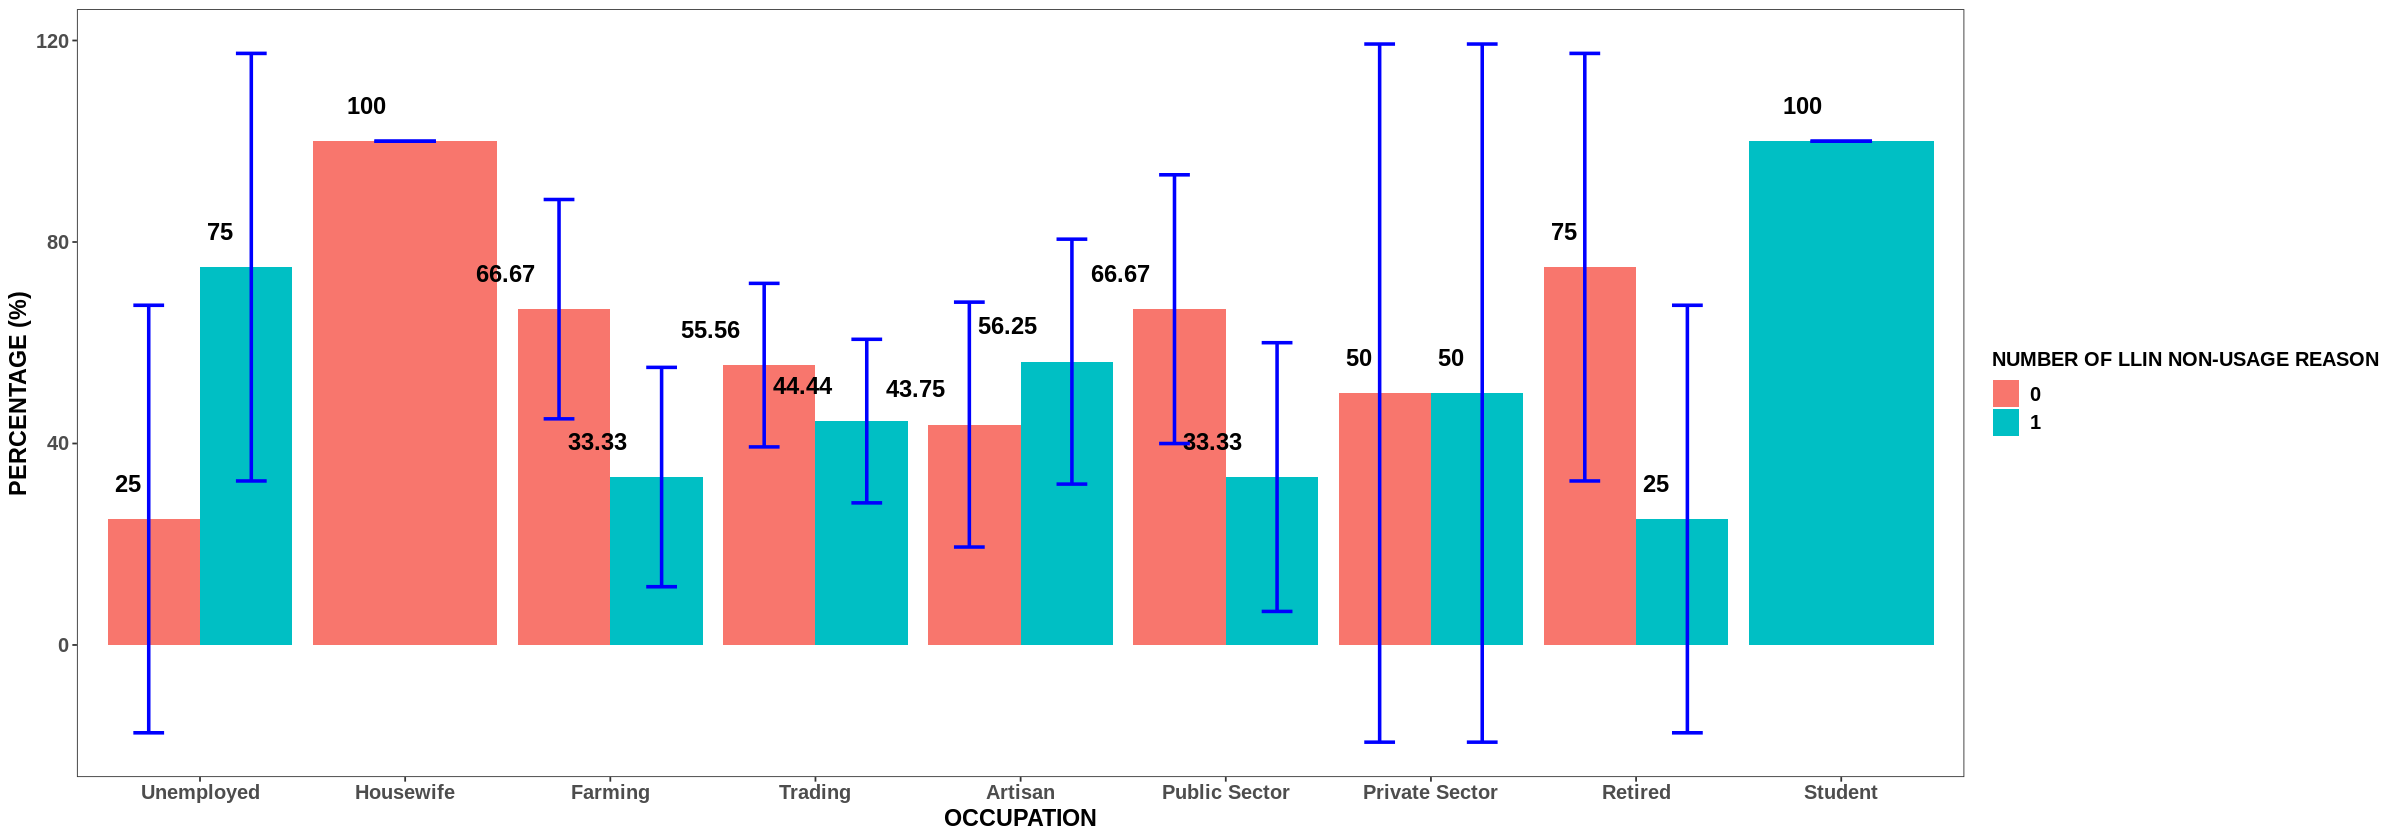



-------------------------------------------


-------------------------------------------
EDUCATION MODIFIED

-------------------------------------------


A5MUT             Freq % Freq   
1 Secondary & Above  77   76.23762
2 Pre Secondary      24   23.76238
3 Total             101  100.00000

Secondary & Above Pre Secondary Total        
0     39 [ 38.61% ]     14 [ 13.86% ] 53 [ 52.48% ]
1     38 [ 37.62% ]     10 [ 9.9% ]   48 [ 47.52% ]
Total 77 [ 76.24% ]     24 [ 23.76% ] 101 [ 100% ]

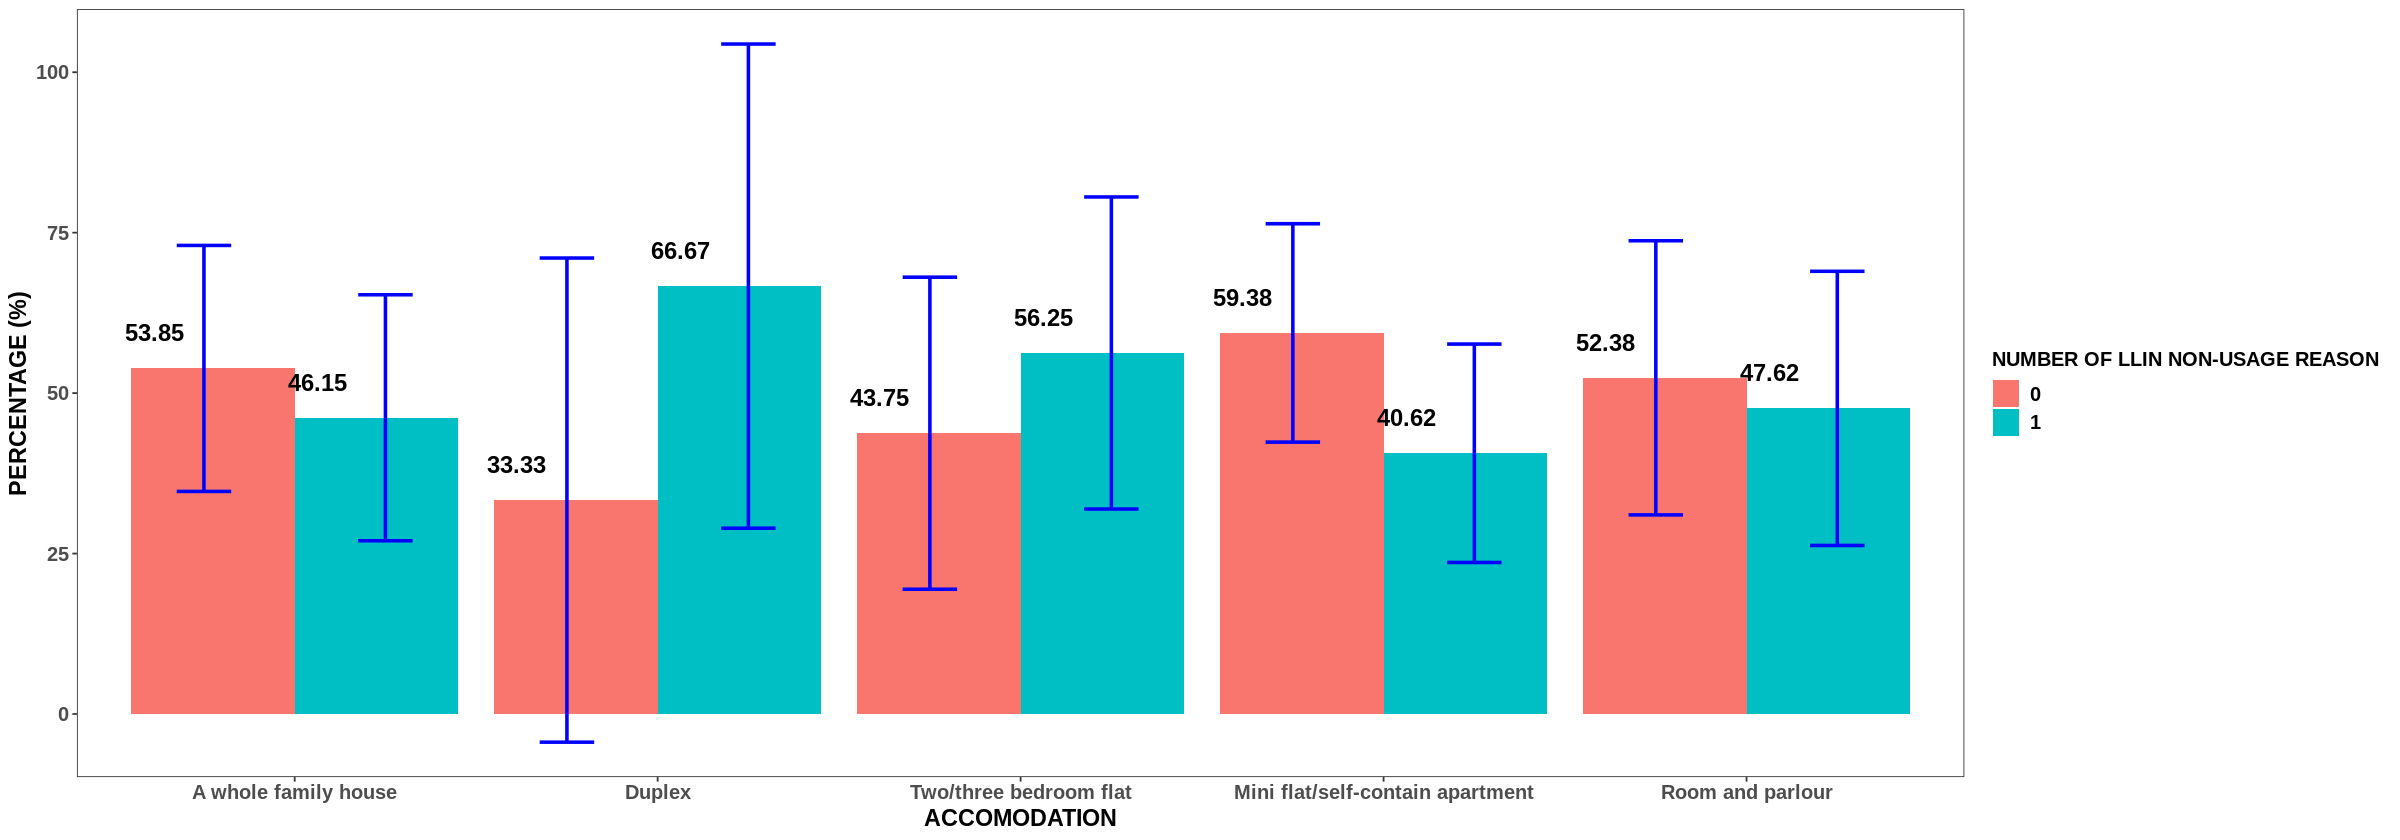



-------------------------------------------


-------------------------------------------
OCCUPATION MODIFIED

-------------------------------------------


A6MUT                  Freq % Freq    
1 Blue Collar             70   69.306931
2 White Collar            18   17.821782
3 Student                  8    7.920792
4 Unemployed & Housewife   5    4.950495
5 Total                  101  100.000000

Blue Collar   White Collar  Student     Unemployed & Housewife
0     39 [ 38.61% ] 12 [ 11.88% ] 0 [ 0% ]    2 [ 1.98% ]           
1     31 [ 30.69% ] 6 [ 5.94% ]   8 [ 7.92% ] 3 [ 2.97% ]           
Total 70 [ 69.31% ] 18 [ 17.82% ] 8 [ 7.92% ] 5 [ 4.95% ]           
      Total        
0     53 [ 52.48% ]
1     48 [ 47.52% ]
Total 101 [ 100% ]

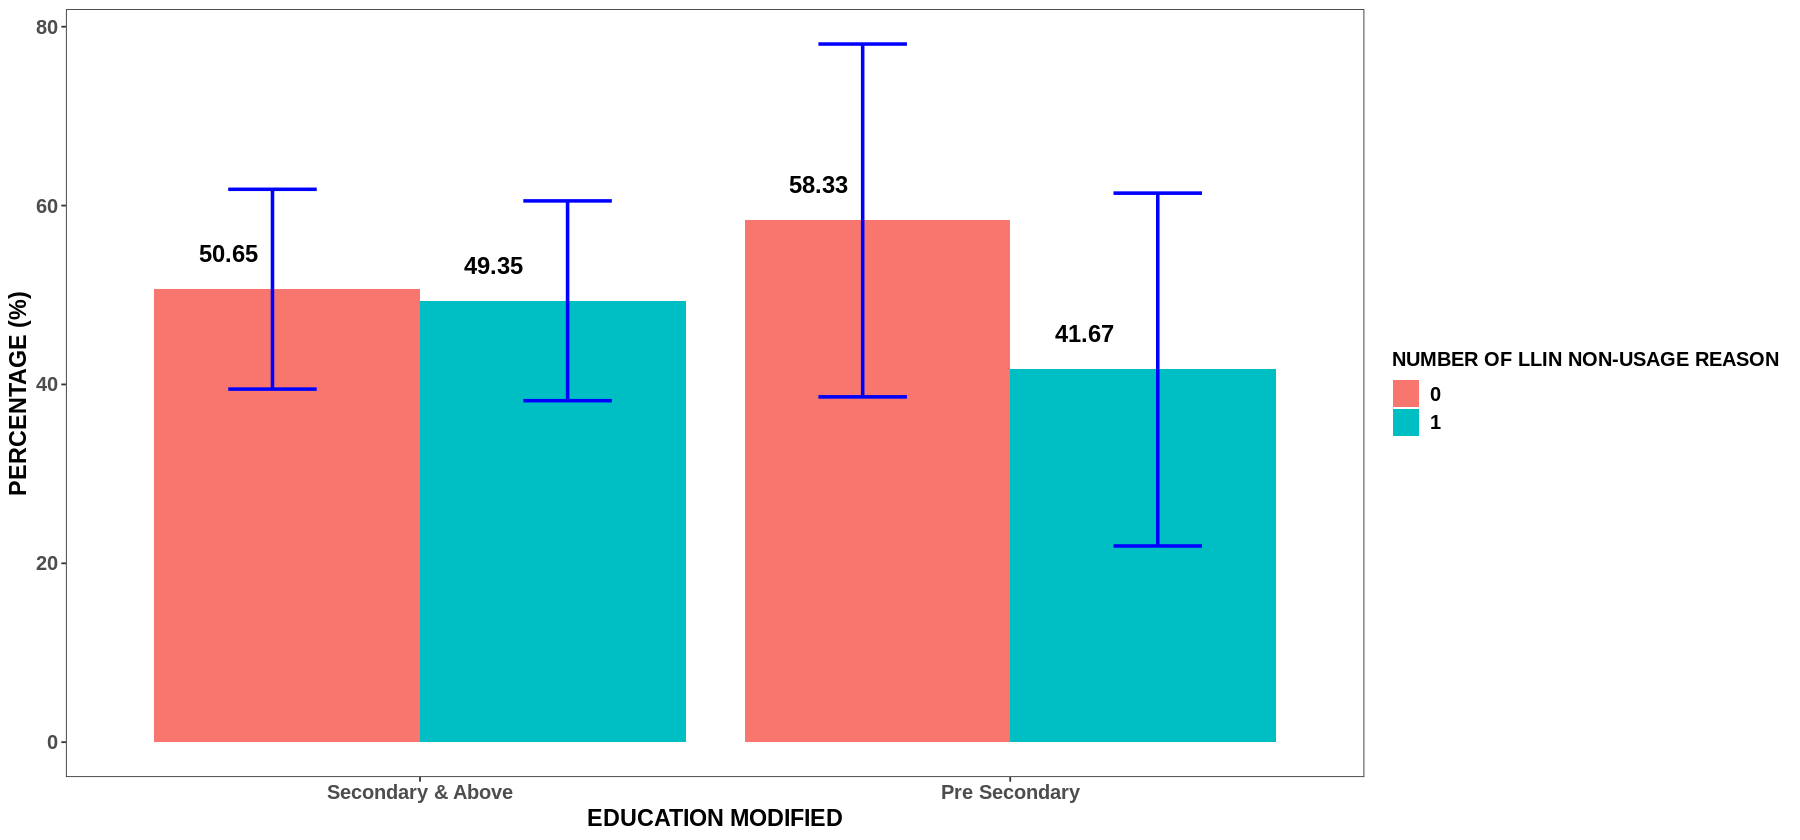



-------------------------------------------


-------------------------------------------
ACCOMODATION MODIFIED

-------------------------------------------


B13MUT       Freq % Freq   
1 Not Spacious  53   52.47525
2 Spacious      48   47.52475
3 Total        101  100.00000

Not Spacious  Spacious      Total        
0     30 [ 29.7% ]  23 [ 22.77% ] 53 [ 52.48% ]
1     23 [ 22.77% ] 25 [ 24.75% ] 48 [ 47.52% ]
Total 53 [ 52.48% ] 48 [ 47.52% ] 101 [ 100% ]

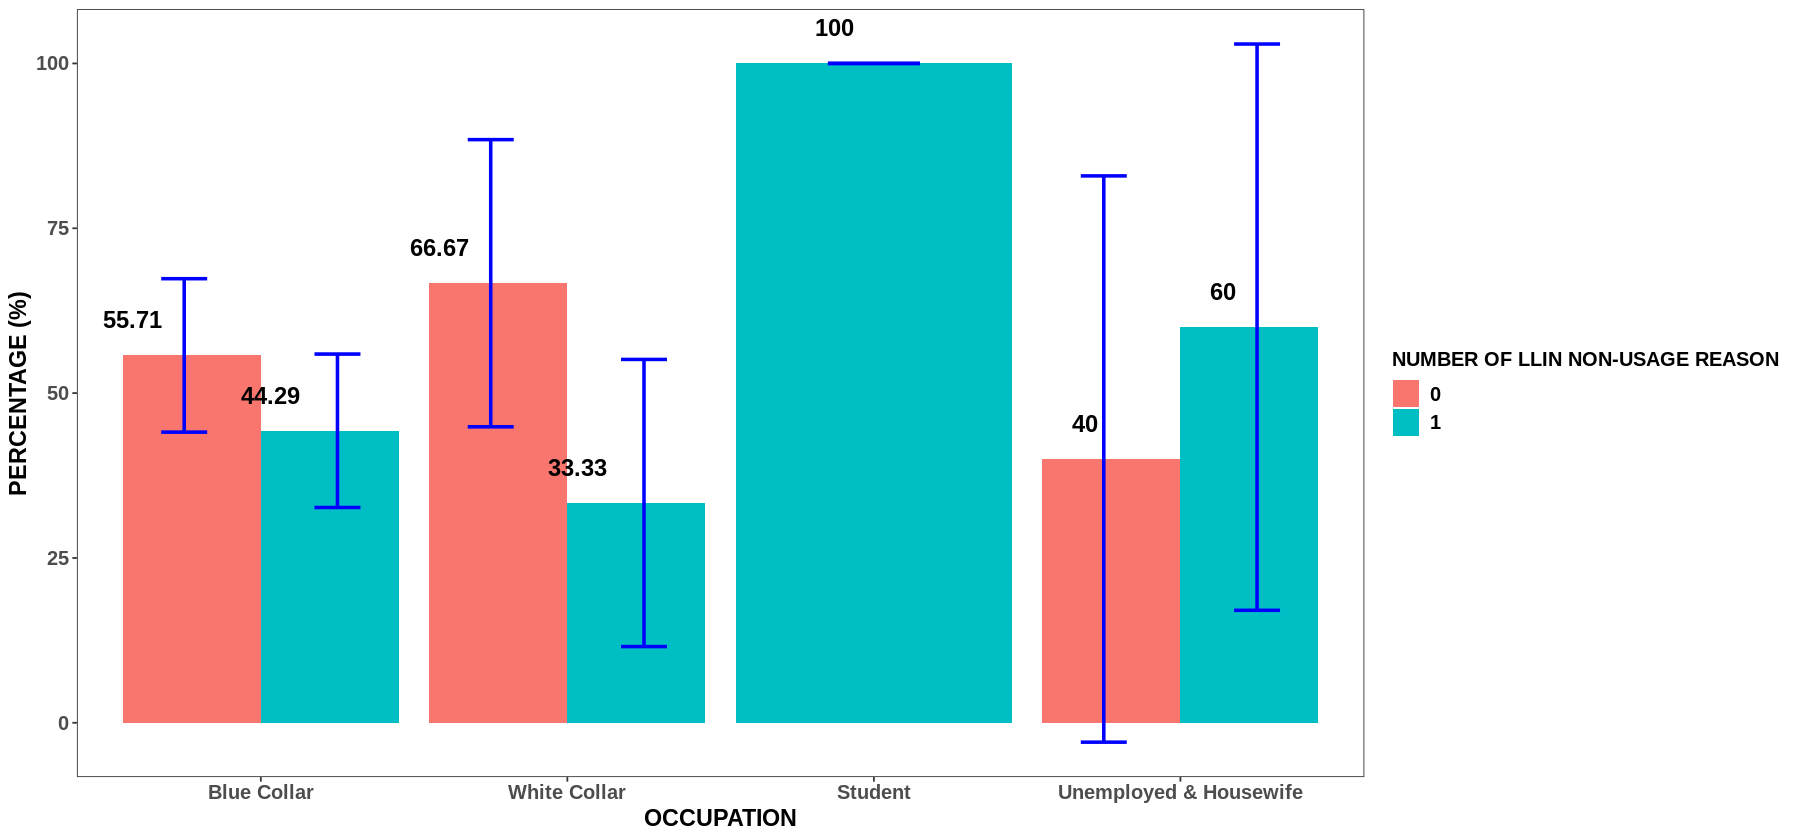

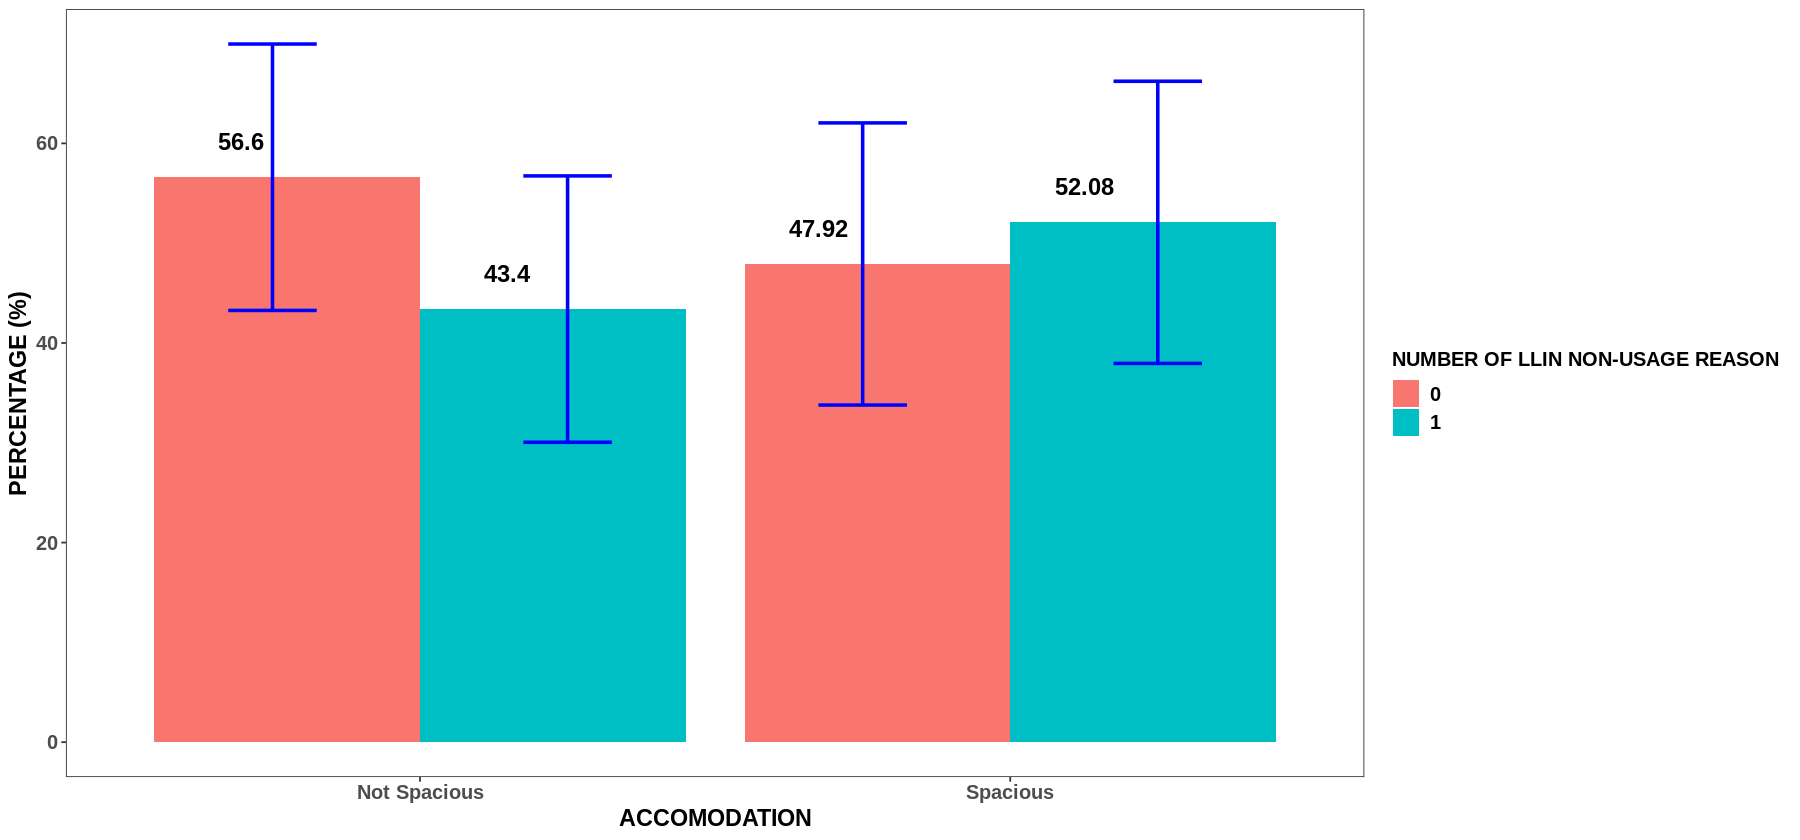

In [ ]:
fig_sizer_fn(12,7)
cat("\n\n-------------------------------------------\n")
cat("\n\n-------------------------------------------\n")

cat("SEX")
cat("\n\n-------------------------------------------\n")
analysis_df = YF_data %>% filter(is.na(high_LLIN_non_usage) == FALSE) %>% filter(is.na(A1) == FALSE)

analysis_df %$% freq(A1)

cat("\n\n\n")

analysis_df %$% ctable_fn(x = high_LLIN_non_usage, y = A1)

cat("\n\n\n")

#============================================================

analysis_CI_cat_df = analysis_df %>% select(high_LLIN_non_usage, A1) %>% group_by(A1, high_LLIN_non_usage) %>%
  summarise(Count = n(), .groups = 'drop') %>% 

  mutate(OverallPercentage = Count/sum(.$Count) ) %>%
  mutate( OverallPercentage = round(OverallPercentage,4) * 100) %>%
  
  group_by(A1) %>% mutate(WithinGroupSum = sum(Count)) %>%
  group_by(high_LLIN_non_usage, .add=TRUE) %>%
  mutate(Percentage = Count/WithinGroupSum , Lower_CI = Percentage - 1.96 * sqrt( Percentage * {1 - Percentage} / WithinGroupSum), Upper_CI = Percentage + 1.96 * sqrt( Percentage * {1 - Percentage} / WithinGroupSum)) %>%
  mutate( Percentage = round(Percentage, 4) * 100, Lower_CI  = round(Lower_CI, 4) * 100, Upper_CI = round(Upper_CI,4) * 100)

ggplot(analysis_CI_cat_df, aes(x = factor(A1), y = Percentage, fill = factor(high_LLIN_non_usage))) +
  geom_bar(position="dodge", stat="identity", width = 0.9) +
   geom_text(aes(label = Percentage), position = position_dodge(0.9), hjust = 1.5, vjust = -1.6, fontface = "bold", size = 5) +
  labs(x = "SEX", y = "PERCENTAGE (%)", fill = "NUMBER OF LLIN NON-USAGE REASON") +  
      geom_errorbar(aes(ymin = Lower_CI, ymax = Upper_CI), width = 0.3 , position = position_dodge(width = 1), color = "blue", size = 1)    +
  theme_minimal(base_size = 18)+
  theme_bw() +
  theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank()) +
  theme(legend.text=element_text(size = 12, face = "bold"), legend.title = element_text(size=12 , face = "bold"), axis.text=element_text(size=12, face="bold"),
        axis.title=element_text(size=14, face="bold"), plot.title = element_text(hjust = 0.5, size = 16, face = "bold"))



cat("\n\n-------------------------------------------\n")
cat("\n\n-------------------------------------------\n")

cat("AGE CONTINUOUS")
cat("\n\n-------------------------------------------\n")

analysis_df = YF_data %>% filter(is.na(high_LLIN_non_usage) == FALSE) %>% filter(is.na(A2) == FALSE)

cat(paste0("\n\n Number of missing observation is: ", nrow(YF_data) - nrow(analysis_df), " out of ", nrow(YF_data), "\n"))
#=======================================================================

analysis_df = analysis_df %>% select(c(A2, high_LLIN_non_usage ))
analysis_df = analysis_df[complete.cases(analysis_df),]

analysis_df$A2 = as.numeric(analysis_df$A2)

cat("\n\n")

#=======================================================================

analysis_CI_cont_df1 = analysis_df %>% group_by(high_LLIN_non_usage) %>%
                       summarise(Count = n(), Mean = mean(A2, na.rm=TRUE), Min = quantile(A2, 0, na.rm=TRUE), Q1 = quantile(A2, 0.25, na.rm=TRUE), 
                       Q2 = quantile(A2, 0.5, na.rm=TRUE),  Q3 = quantile(A2, 0.75, na.rm=TRUE), Max = quantile(A2, 1, na.rm=TRUE),
                       Sd = sd(A2, na.rm=TRUE), .groups = 'drop') %>%
                       mutate( Margin_Error = {Sd/sqrt(Count)} * qt(1-0.05/2, Count - 1)  ) %>% mutate(Mean = round(Mean, 2),  Margin_Error = round(Margin_Error, 2) )
analysis_CI_cont_df1$high_LLIN_non_usage = as.character(analysis_CI_cont_df1$high_LLIN_non_usage)

analysis_CI_cont_df2 = analysis_df %>%
                       summarise(high_LLIN_non_usage =  "Total", Count = n(), Mean = mean(A2, na.rm=TRUE), Min = quantile(A2, 0, na.rm=TRUE), Q1 = quantile(A2, 0.25, na.rm=TRUE), 
                       Q2 = quantile(A2, 0.5, na.rm=TRUE),  Q3 = quantile(A2, 0.75, na.rm=TRUE), Max = quantile(A2, 1, na.rm=TRUE),
                       Sd = sd(A2, na.rm=TRUE), .groups = 'drop') %>%
                       mutate( Margin_Error = {Sd/sqrt(Count)} * qt(1-0.05/2, Count - 1)  ) %>% mutate(Mean = round(Mean, 2),  Margin_Error = round(Margin_Error, 2) )

analysis_CI_cont_df = rbind(analysis_CI_cont_df1, analysis_CI_cont_df2)

analysis_CI_cont_df 

#================================================================


ggplot(analysis_CI_cont_df, aes(x = factor(high_LLIN_non_usage), y = Mean , fill = factor(high_LLIN_non_usage))) +
  geom_bar(position="dodge", stat="identity", width = 0.9) +
  labs(x = "AGE CONT (Answers to Protection Approach Questions)", y = "Mean", fill = "NUMBER OF LLIN NON-USAGE REASON") +  
       geom_text(aes(label = Mean), position = position_dodge(0.9), hjust = 1.5, vjust = -1.6, fontface = "bold", size = 5) +
      geom_errorbar(aes(ymin = Mean  - Margin_Error, ymax = Mean + Margin_Error), width = 0.5, position = position_dodge(width = 0.5), color="blue", size=1)    +
  theme_minimal(base_size = 18)+
  theme_bw() +
  theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank()) +
  theme(legend.text=element_text(size = 12, face = "bold"), legend.title = element_text(size=12 , face = "bold"), axis.text=element_text(size=12, face="bold"),
        axis.title=element_text(size=14, face="bold"), plot.title = element_text(hjust = 0.5, size = 16, face = "bold"))






cat("\n\n-------------------------------------------\n")
cat("\n\n-------------------------------------------\n")

cat("AGE CATEGORICAL")
cat("\n\n-------------------------------------------\n")

analysis_df = YF_data %>% filter(is.na(high_LLIN_non_usage) == FALSE) %>% filter(is.na(AGECAT) == FALSE)

analysis_df %$% freq(AGECAT)

cat("\n\n\n")

analysis_df %$% ctable_fn(x = high_LLIN_non_usage, y = AGECAT)


#============================================================

analysis_CI_cat_df = analysis_df %>% select(high_LLIN_non_usage, AGECAT) %>% group_by(AGECAT, high_LLIN_non_usage) %>%
  summarise(Count = n(), .groups = 'drop') %>% 

  mutate(OverallPercentage = Count/sum(.$Count) ) %>%
  mutate( OverallPercentage = round(OverallPercentage,4) * 100) %>%
  
  group_by(AGECAT) %>% mutate(WithinGroupSum = sum(Count)) %>%
  group_by(high_LLIN_non_usage, .add=TRUE) %>%
  mutate(Percentage = Count/WithinGroupSum , Lower_CI = Percentage - 1.96 * sqrt( Percentage * {1 - Percentage} / WithinGroupSum), Upper_CI = Percentage + 1.96 * sqrt( Percentage * {1 - Percentage} / WithinGroupSum)) %>%
  mutate( Percentage = round(Percentage, 4) * 100, Lower_CI  = round(Lower_CI, 4) * 100, Upper_CI = round(Upper_CI,4) * 100)
fig_sizer_fn(15, 7)
ggplot(analysis_CI_cat_df, aes(x = factor(AGECAT), y = Percentage, fill = factor(high_LLIN_non_usage))) +
  geom_bar(position="dodge", stat="identity", width = 0.9) +
   geom_text(aes(label = Percentage), position = position_dodge(0.9), hjust = 1.5, vjust = -1.6, fontface = "bold", size = 5) +
  labs(x = "AGE CATEGORICAL", y = "PERCENTAGE (%)", fill = "NUMBER OF LLIN NON-USAGE REASON") +  
      geom_errorbar(aes(ymin = Lower_CI, ymax = Upper_CI), width = 0.3 , position = position_dodge(width = 1), color = "blue", size = 1)    +
  theme_minimal(base_size = 18)+
  theme_bw() +
  theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank()) +
  theme(legend.text=element_text(size = 12, face = "bold"), legend.title = element_text(size=12 , face = "bold"), axis.text=element_text(size=12, face="bold"),
        axis.title=element_text(size=14, face="bold"), plot.title = element_text(hjust = 0.5, size = 16, face = "bold"))



cat("\n\n-------------------------------------------\n")
cat("\n\n-------------------------------------------\n")

cat("EDUCATION")
cat("\n\n-------------------------------------------\n")

analysis_df = YF_data %>% filter(is.na(high_LLIN_non_usage) == FALSE) %>% filter(is.na(A5) == FALSE)

analysis_df %$% freq(A5)

cat("\n\n\n")

analysis_df %$% ctable_fn(x = high_LLIN_non_usage, y = A5)


#============================================================

analysis_CI_cat_df = analysis_df %>% select(high_LLIN_non_usage, A5) %>% group_by(A5, high_LLIN_non_usage) %>%
  summarise(Count = n(), .groups = 'drop') %>% 

  mutate(OverallPercentage = Count/sum(.$Count) ) %>%
  mutate( OverallPercentage = round(OverallPercentage,4) * 100) %>%
  
  group_by(A5) %>% mutate(WithinGroupSum = sum(Count)) %>%
  group_by(high_LLIN_non_usage, .add=TRUE) %>%
  mutate(Percentage = Count/WithinGroupSum , Lower_CI = Percentage - 1.96 * sqrt( Percentage * {1 - Percentage} / WithinGroupSum), Upper_CI = Percentage + 1.96 * sqrt( Percentage * {1 - Percentage} / WithinGroupSum)) %>%
  mutate( Percentage = round(Percentage, 4) * 100, Lower_CI  = round(Lower_CI, 4) * 100, Upper_CI = round(Upper_CI,4) * 100)

fig_sizer_fn(20, 7)

ggplot(analysis_CI_cat_df, aes(x = factor(A5), y = Percentage, fill = factor(high_LLIN_non_usage))) +
  geom_bar(position="dodge", stat="identity", width = 0.9) +
   geom_text(aes(label = Percentage), position = position_dodge(0.9), hjust = 1.5, vjust = -1.6, fontface = "bold", size = 5) +
  labs(x = "EDUCATION", y = "PERCENTAGE (%)", fill = "NUMBER OF LLIN NON-USAGE REASON") +  
      geom_errorbar(aes(ymin = Lower_CI, ymax = Upper_CI), width = 0.3 , position = position_dodge(width = 1), color = "blue", size = 1)    +
  theme_minimal(base_size = 18)+
  theme_bw() +
  theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank()) +
  theme(legend.text=element_text(size = 12, face = "bold"), legend.title = element_text(size=12 , face = "bold"), axis.text=element_text(size=12, face="bold"),
        axis.title=element_text(size=14, face="bold"), plot.title = element_text(hjust = 0.5, size = 16, face = "bold"))



cat("\n\n-------------------------------------------\n")
cat("\n\n-------------------------------------------\n")

cat("OCCUPATION")
cat("\n\n-------------------------------------------\n")

analysis_df = YF_data %>% filter(is.na(high_LLIN_non_usage) == FALSE) %>% filter(is.na(A6) == FALSE)

analysis_df %$% freq(A6)

cat("\n\n\n")

analysis_df %$% ctable_fn(x = high_LLIN_non_usage, y = A6)


#============================================================

analysis_CI_cat_df = analysis_df %>% select(high_LLIN_non_usage, A6) %>% group_by(A6, high_LLIN_non_usage) %>%
  summarise(Count = n(), .groups = 'drop') %>% 

  mutate(OverallPercentage = Count/sum(.$Count) ) %>%
  mutate( OverallPercentage = round(OverallPercentage,4) * 100) %>%
  
  group_by(A6) %>% mutate(WithinGroupSum = sum(Count)) %>%
  group_by(high_LLIN_non_usage, .add=TRUE) %>%
  mutate(Percentage = Count/WithinGroupSum , Lower_CI = Percentage - 1.96 * sqrt( Percentage * {1 - Percentage} / WithinGroupSum), Upper_CI = Percentage + 1.96 * sqrt( Percentage * {1 - Percentage} / WithinGroupSum)) %>%
  mutate( Percentage = round(Percentage, 4) * 100, Lower_CI  = round(Lower_CI, 4) * 100, Upper_CI = round(Upper_CI,4) * 100)

fig_sizer_fn(20, 7)

ggplot(analysis_CI_cat_df, aes(x = factor(A6), y = Percentage, fill = factor(high_LLIN_non_usage))) +
  geom_bar(position="dodge", stat="identity", width = 0.9) +
   geom_text(aes(label = Percentage), position = position_dodge(0.9), hjust = 1.5, vjust = -1.6, fontface = "bold", size = 5) +
  labs(x = "OCCUPATION", y = "PERCENTAGE (%)", fill = "NUMBER OF LLIN NON-USAGE REASON") +  
      geom_errorbar(aes(ymin = Lower_CI, ymax = Upper_CI), width = 0.3 , position = position_dodge(width = 1), color = "blue", size = 1)    +
  theme_minimal(base_size = 18)+
  theme_bw() +
  theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank()) +
  theme(legend.text=element_text(size = 12, face = "bold"), legend.title = element_text(size=12 , face = "bold"), axis.text=element_text(size=12, face="bold"),
        axis.title=element_text(size=14, face="bold"), plot.title = element_text(hjust = 0.5, size = 16, face = "bold"))




cat("\n\n-------------------------------------------\n")
cat("\n\n-------------------------------------------\n")

cat("ACCOMODATION")
cat("\n\n-------------------------------------------\n")

analysis_df = YF_data %>% filter(is.na(high_LLIN_non_usage) == FALSE) %>% filter(is.na(B13) == FALSE)

analysis_df %$% freq(B13)

cat("\n\n\n")

analysis_df %$% ctable_fn(x = high_LLIN_non_usage, y = B13)


#============================================================

analysis_CI_cat_df = analysis_df %>% select(high_LLIN_non_usage, B13) %>% group_by(B13, high_LLIN_non_usage) %>%
  summarise(Count = n(), .groups = 'drop') %>% 

  mutate(OverallPercentage = Count/sum(.$Count) ) %>%
  mutate( OverallPercentage = round(OverallPercentage,4) * 100) %>%
  
  group_by(B13) %>% mutate(WithinGroupSum = sum(Count)) %>%
  group_by(high_LLIN_non_usage, .add=TRUE) %>%
  mutate(Percentage = Count/WithinGroupSum , Lower_CI = Percentage - 1.96 * sqrt( Percentage * {1 - Percentage} / WithinGroupSum), Upper_CI = Percentage + 1.96 * sqrt( Percentage * {1 - Percentage} / WithinGroupSum)) %>%
  mutate( Percentage = round(Percentage, 4) * 100, Lower_CI  = round(Lower_CI, 4) * 100, Upper_CI = round(Upper_CI,4) * 100)

fig_sizer_fn(20, 7)

ggplot(analysis_CI_cat_df, aes(x = factor(B13), y = Percentage, fill = factor(high_LLIN_non_usage))) +
  geom_bar(position="dodge", stat="identity", width = 0.9) +
   geom_text(aes(label = Percentage), position = position_dodge(0.9), hjust = 1.5, vjust = -1.6, fontface = "bold", size = 5) +
  labs(x = "ACCOMODATION", y = "PERCENTAGE (%)", fill = "NUMBER OF LLIN NON-USAGE REASON") +  
      geom_errorbar(aes(ymin = Lower_CI, ymax = Upper_CI), width = 0.3 , position = position_dodge(width = 1), color = "blue", size = 1)    +
  theme_minimal(base_size = 18)+
  theme_bw() +
  theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank()) +
  theme(legend.text=element_text(size = 12, face = "bold"), legend.title = element_text(size=12 , face = "bold"), axis.text=element_text(size=12, face="bold"),
        axis.title=element_text(size=14, face="bold"), plot.title = element_text(hjust = 0.5, size = 16, face = "bold"))



#====================================================================================================================
#====================================================================================================================
#====================================================================================================================
#====================================================================================================================


fig_sizer_fn()

cat("\n\n-------------------------------------------\n")
cat("\n\n-------------------------------------------\n")

cat("EDUCATION MODIFIED")
cat("\n\n-------------------------------------------\n")

analysis_df = YF_data %>% filter(is.na(high_LLIN_non_usage) == FALSE) %>% filter(is.na(A5MUT) == FALSE)

analysis_df %$% freq(A5MUT)

cat("\n\n\n")

analysis_df %$% ctable_fn(x = high_LLIN_non_usage, y = A5MUT)


#============================================================

analysis_CI_cat_df = analysis_df %>% select(high_LLIN_non_usage, A5MUT) %>% group_by(A5MUT, high_LLIN_non_usage) %>%
  summarise(Count = n(), .groups = 'drop') %>% 

  mutate(OverallPercentage = Count/sum(.$Count) ) %>%
  mutate( OverallPercentage = round(OverallPercentage,4) * 100) %>%
  
  group_by(A5MUT) %>% mutate(WithinGroupSum = sum(Count)) %>%
  group_by(high_LLIN_non_usage, .add=TRUE) %>%
  mutate(Percentage = Count/WithinGroupSum , Lower_CI = Percentage - 1.96 * sqrt( Percentage * {1 - Percentage} / WithinGroupSum), Upper_CI = Percentage + 1.96 * sqrt( Percentage * {1 - Percentage} / WithinGroupSum)) %>%
  mutate( Percentage = round(Percentage, 4) * 100, Lower_CI  = round(Lower_CI, 4) * 100, Upper_CI = round(Upper_CI,4) * 100)

fig_sizer_fn(15, 7)

ggplot(analysis_CI_cat_df, aes(x = factor(A5MUT), y = Percentage, fill = factor(high_LLIN_non_usage))) +
  geom_bar(position="dodge", stat="identity", width = 0.9) +
   geom_text(aes(label = Percentage), position = position_dodge(0.9), hjust = 1.5, vjust = -1.6, fontface = "bold", size = 5) +
  labs(x = "EDUCATION MODIFIED", y = "PERCENTAGE (%)", fill = "NUMBER OF LLIN NON-USAGE REASON") +  
      geom_errorbar(aes(ymin = Lower_CI, ymax = Upper_CI), width = 0.3 , position = position_dodge(width = 1), color = "blue", size = 1)    +
  theme_minimal(base_size = 18)+
  theme_bw() +
  theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank()) +
  theme(legend.text=element_text(size = 12, face = "bold"), legend.title = element_text(size=12 , face = "bold"), axis.text=element_text(size=12, face="bold"),
        axis.title=element_text(size=14, face="bold"), plot.title = element_text(hjust = 0.5, size = 16, face = "bold"))



cat("\n\n-------------------------------------------\n")
cat("\n\n-------------------------------------------\n")

cat("OCCUPATION MODIFIED")
cat("\n\n-------------------------------------------\n")

analysis_df = YF_data %>% filter(is.na(high_LLIN_non_usage) == FALSE) %>% filter(is.na(A6MUT) == FALSE)

analysis_df %$% freq(A6MUT)

cat("\n\n\n")

analysis_df %$% ctable_fn(x = high_LLIN_non_usage, y = A6MUT)


#============================================================

analysis_CI_cat_df = analysis_df %>% select(high_LLIN_non_usage, A6MUT) %>% group_by(A6MUT, high_LLIN_non_usage) %>%
  summarise(Count = n(), .groups = 'drop') %>% 

  mutate(OverallPercentage = Count/sum(.$Count) ) %>%
  mutate( OverallPercentage = round(OverallPercentage,4) * 100) %>%
  
  group_by(A6MUT) %>% mutate(WithinGroupSum = sum(Count)) %>%
  group_by(high_LLIN_non_usage, .add=TRUE) %>%
  mutate(Percentage = Count/WithinGroupSum , Lower_CI = Percentage - 1.96 * sqrt( Percentage * {1 - Percentage} / WithinGroupSum), Upper_CI = Percentage + 1.96 * sqrt( Percentage * {1 - Percentage} / WithinGroupSum)) %>%
  mutate( Percentage = round(Percentage, 4) * 100, Lower_CI  = round(Lower_CI, 4) * 100, Upper_CI = round(Upper_CI,4) * 100)

fig_sizer_fn(15, 7)

ggplot(analysis_CI_cat_df, aes(x = factor(A6MUT), y = Percentage, fill = factor(high_LLIN_non_usage))) +
  geom_bar(position="dodge", stat="identity", width = 0.9) +
   geom_text(aes(label = Percentage), position = position_dodge(0.9), hjust = 1.5, vjust = -1.6, fontface = "bold", size = 5) +
  labs(x = "OCCUPATION", y = "PERCENTAGE (%)", fill = "NUMBER OF LLIN NON-USAGE REASON") +  
      geom_errorbar(aes(ymin = Lower_CI, ymax = Upper_CI), width = 0.3 , position = position_dodge(width = 1), color = "blue", size = 1)    +
  theme_minimal(base_size = 18)+
  theme_bw() +
  theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank()) +
  theme(legend.text=element_text(size = 12, face = "bold"), legend.title = element_text(size=12 , face = "bold"), axis.text=element_text(size=12, face="bold"),
        axis.title=element_text(size=14, face="bold"), plot.title = element_text(hjust = 0.5, size = 16, face = "bold"))




cat("\n\n-------------------------------------------\n")
cat("\n\n-------------------------------------------\n")

cat("ACCOMODATION MODIFIED")
cat("\n\n-------------------------------------------\n")

analysis_df = YF_data %>% filter(is.na(high_LLIN_non_usage) == FALSE) %>% filter(is.na(B13MUT) == FALSE)

analysis_df %$% freq(B13MUT)

cat("\n\n\n")

analysis_df %$% ctable_fn(x = high_LLIN_non_usage, y = B13MUT)


#============================================================

analysis_CI_cat_df = analysis_df %>% select(high_LLIN_non_usage, B13MUT) %>% group_by(B13MUT, high_LLIN_non_usage) %>%
  summarise(Count = n(), .groups = 'drop') %>% 

  mutate(OverallPercentage = Count/sum(.$Count) ) %>%
  mutate( OverallPercentage = round(OverallPercentage,4) * 100) %>%
  
  group_by(B13MUT) %>% mutate(WithinGroupSum = sum(Count)) %>%
  group_by(high_LLIN_non_usage, .add=TRUE) %>%
  mutate(Percentage = Count/WithinGroupSum , Lower_CI = Percentage - 1.96 * sqrt( Percentage * {1 - Percentage} / WithinGroupSum), Upper_CI = Percentage + 1.96 * sqrt( Percentage * {1 - Percentage} / WithinGroupSum)) %>%
  mutate( Percentage = round(Percentage, 4) * 100, Lower_CI  = round(Lower_CI, 4) * 100, Upper_CI = round(Upper_CI,4) * 100)

fig_sizer_fn(15, 7)

ggplot(analysis_CI_cat_df, aes(x = factor(B13MUT), y = Percentage, fill = factor(high_LLIN_non_usage))) +
  geom_bar(position="dodge", stat="identity", width = 0.9) +
   geom_text(aes(label = Percentage), position = position_dodge(0.9), hjust = 1.5, vjust = -1.6, fontface = "bold", size = 5) +
  labs(x = "ACCOMODATION", y = "PERCENTAGE (%)", fill = "NUMBER OF LLIN NON-USAGE REASON") +  
      geom_errorbar(aes(ymin = Lower_CI, ymax = Upper_CI), width = 0.3 , position = position_dodge(width = 1), color = "blue", size = 1)    +
  theme_minimal(base_size = 18)+
  theme_bw() +
  theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank()) +
  theme(legend.text=element_text(size = 12, face = "bold"), legend.title = element_text(size=12 , face = "bold"), axis.text=element_text(size=12, face="bold"),
        axis.title=element_text(size=14, face="bold"), plot.title = element_text(hjust = 0.5, size = 16, face = "bold"))



##### ***Using absolute number of reasons in LLIN***



-------------------------------------------


-------------------------------------------
SEX

-------------------------------------------


A1     Freq % Freq   
1 Male    42   41.58416
2 Female  59   58.41584
3 Total  101  100.00000

Male          Female        Total        
0     21 [ 20.79% ] 32 [ 31.68% ] 53 [ 52.48% ]
1     16 [ 15.84% ] 20 [ 19.8% ]  36 [ 35.64% ]
2     4 [ 3.96% ]   7 [ 6.93% ]   11 [ 10.89% ]
3     1 [ 0.99% ]   0 [ 0% ]      1 [ 0.99% ]  
Total 42 [ 41.58% ] 59 [ 58.42% ] 101 [ 100% ]






-------------------------------------------


-------------------------------------------
AGE CONTINUOUS

-------------------------------------------


 Number of missing observation is: 0 out of 101




Warning message in qt(1 - 0.05/2, Count - 1):
“NaNs produced”


LLIN_non_usage_Score Count Mean  Min Q1   Q2 Q3 Max Sd       Margin_Error
1 0                     53   25.43  5  17.0 25 32 48  11.04451  3.04       
2 1                     36   23.50  1  12.0 26 35 45  13.20714  4.47       
3 2                     11   16.73  2   3.5 13 32 40  15.39539 10.34       
4 3                      1   35.00 35  35.0 35 35 35        NA    NA       
5 Total                101   23.89  1  14.0 25 33 48  12.50512  2.47

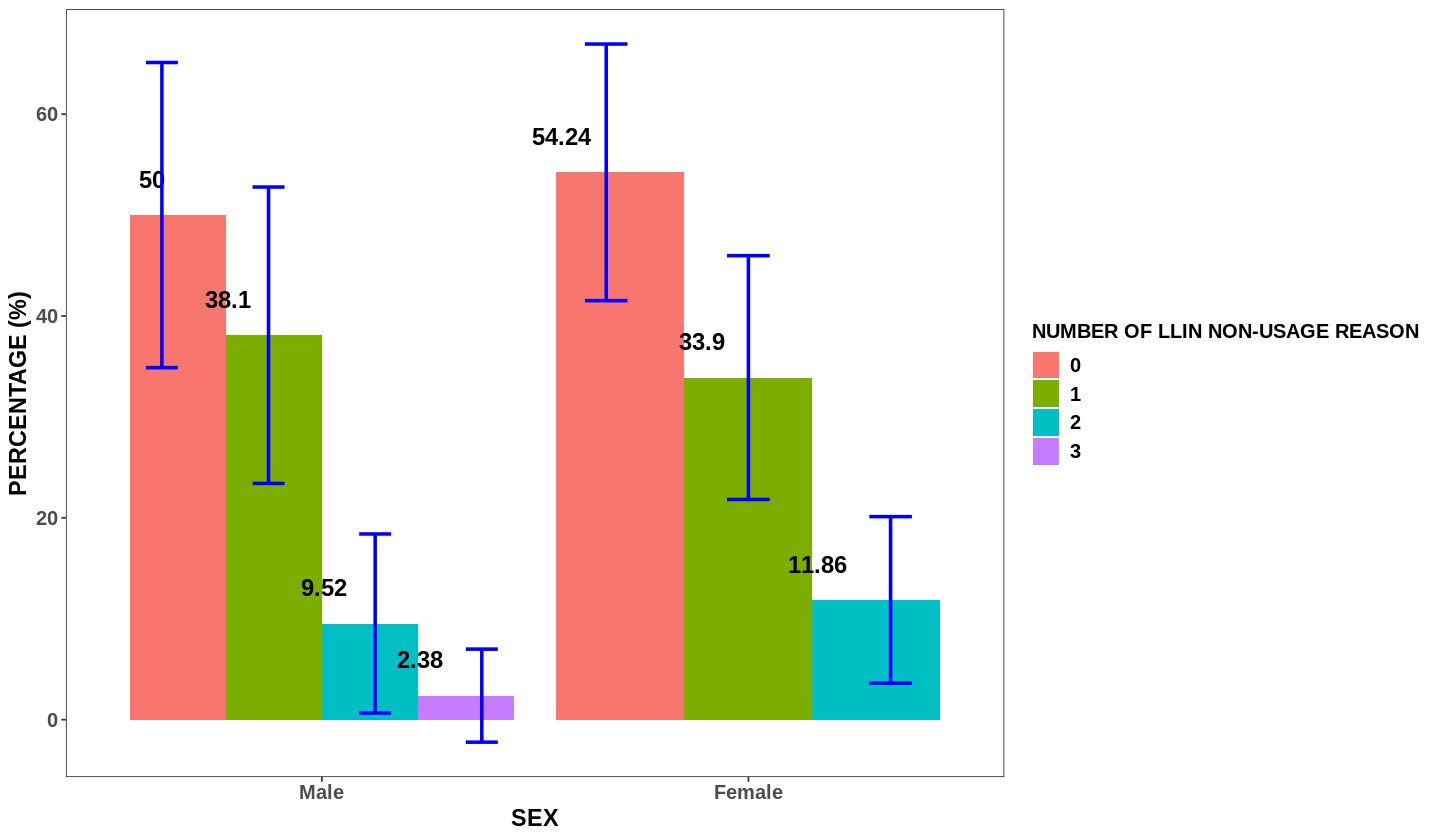



-------------------------------------------


-------------------------------------------
AGE CATEGORICAL

-------------------------------------------


AGECAT     Freq % Freq   
1 18 to 35    31   30.69307
2 35 to 60    57   56.43564
3 60 & above  13   12.87129
4 Total      101  100.00000

18 to 35      35 to 60      60 & above    Total        
0     13 [ 12.87% ] 33 [ 32.67% ] 7 [ 6.93% ]   53 [ 52.48% ]
1     11 [ 10.89% ] 20 [ 19.8% ]  5 [ 4.95% ]   36 [ 35.64% ]
2     7 [ 6.93% ]   3 [ 2.97% ]   1 [ 0.99% ]   11 [ 10.89% ]
3     0 [ 0% ]      1 [ 0.99% ]   0 [ 0% ]      1 [ 0.99% ]  
Total 31 [ 30.69% ] 57 [ 56.44% ] 13 [ 12.87% ] 101 [ 100% ]

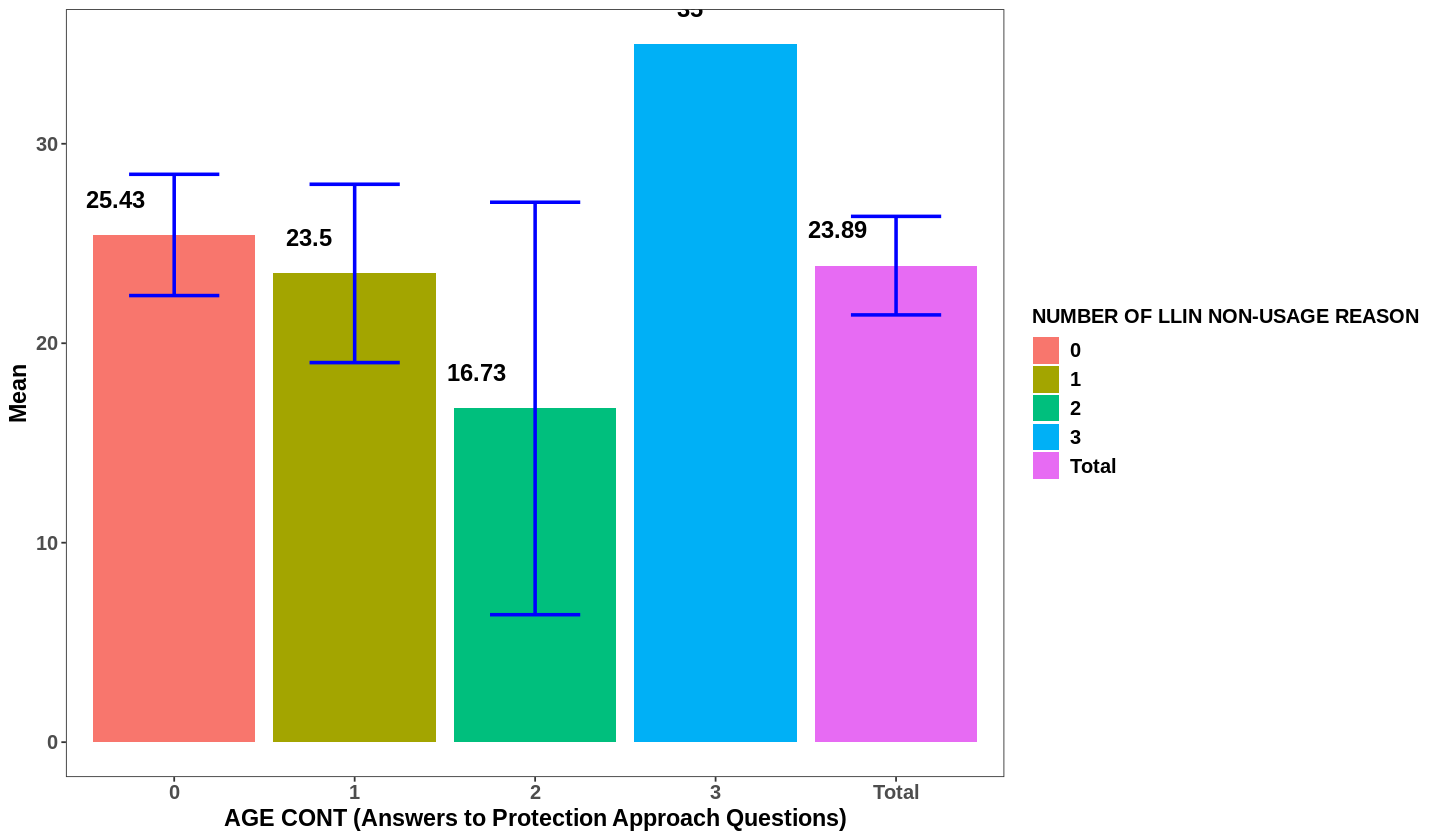



-------------------------------------------


-------------------------------------------
EDUCATION

-------------------------------------------


A5                  Freq % Freq    
1 No formal education   9    8.910891
2 Primary              15   14.851485
3 Secondary            57   56.435644
4 Post Secondary       20   19.801980
5 Total               101  100.000000

No formal education Primary       Secondary     Post Secondary
0     6 [ 5.94% ]         8 [ 7.92% ]   28 [ 27.72% ] 11 [ 10.89% ] 
1     3 [ 2.97% ]         4 [ 3.96% ]   23 [ 22.77% ] 6 [ 5.94% ]   
2     0 [ 0% ]            3 [ 2.97% ]   6 [ 5.94% ]   2 [ 1.98% ]   
3     0 [ 0% ]            0 [ 0% ]      0 [ 0% ]      1 [ 0.99% ]   
Total 9 [ 8.91% ]         15 [ 14.85% ] 57 [ 56.44% ] 20 [ 19.8% ]  
      Total        
0     53 [ 52.48% ]
1     36 [ 35.64% ]
2     11 [ 10.89% ]
3     1 [ 0.99% ]  
Total 101 [ 100% ]

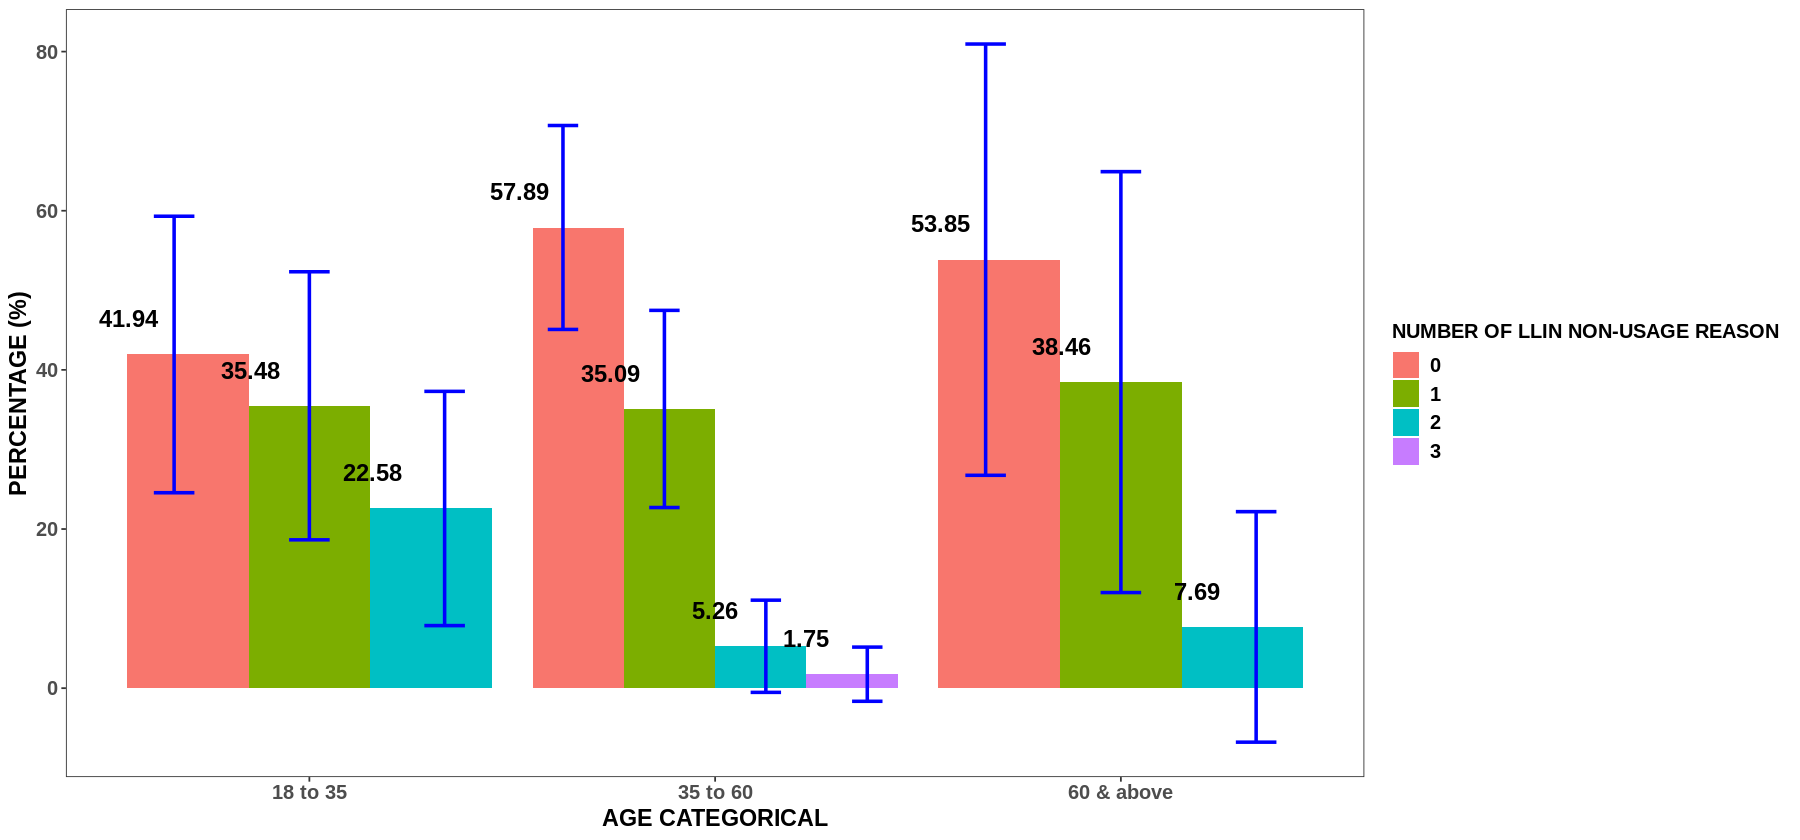



-------------------------------------------


-------------------------------------------
OCCUPATION

-------------------------------------------


A6             Freq % Freq    
1  Unemployed       4    3.960396
2  Housewife        1    0.990099
3  Farming         18   17.821782
4  Trading         36   35.643564
5  Artisan         16   15.841584
6  Public Sector   12   11.881188
7  Private Sector   2    1.980198
8  Retired          4    3.960396
9  Student          8    7.920792
10 Total          101  100.000000

Unemployed  Housewife   Farming       Trading       Artisan      
0     1 [ 0.99% ] 1 [ 0.99% ] 12 [ 11.88% ] 20 [ 19.8% ]  7 [ 6.93% ]  
1     3 [ 2.97% ] 0 [ 0% ]    4 [ 3.96% ]   14 [ 13.86% ] 6 [ 5.94% ]  
2     0 [ 0% ]    0 [ 0% ]    2 [ 1.98% ]   1 [ 0.99% ]   3 [ 2.97% ]  
3     0 [ 0% ]    0 [ 0% ]    0 [ 0% ]      1 [ 0.99% ]   0 [ 0% ]     
Total 4 [ 3.96% ] 1 [ 0.99% ] 18 [ 17.82% ] 36 [ 35.64% ] 16 [ 15.84% ]
      Public Sector Private Sector Retired     Student     Total        
0     8 [ 7.92% ]   1 [ 0.99% ]    3 [ 2.97% ] 0 [ 0% ]    53 [ 52.48% ]
1     4 [ 3.96% ]   0 [ 0% ]       1 [ 0.99% ] 4 [ 3.96% ] 36 [ 35.64% ]
2     0 [ 0% ]      1 [ 0.99% ]    0 [ 0% ]    4 [ 3.96% ] 11 [ 10.89% ]
3     0 [ 0% ]      0 [ 0% ]       0 [ 0% ]    0 [ 0% ]    1 [ 0.99% ]  
Total 12 [ 11.88% ] 2 [ 1.98% ]    4 [ 3.96% ] 8 [ 7.92% ] 101 [ 100% ]

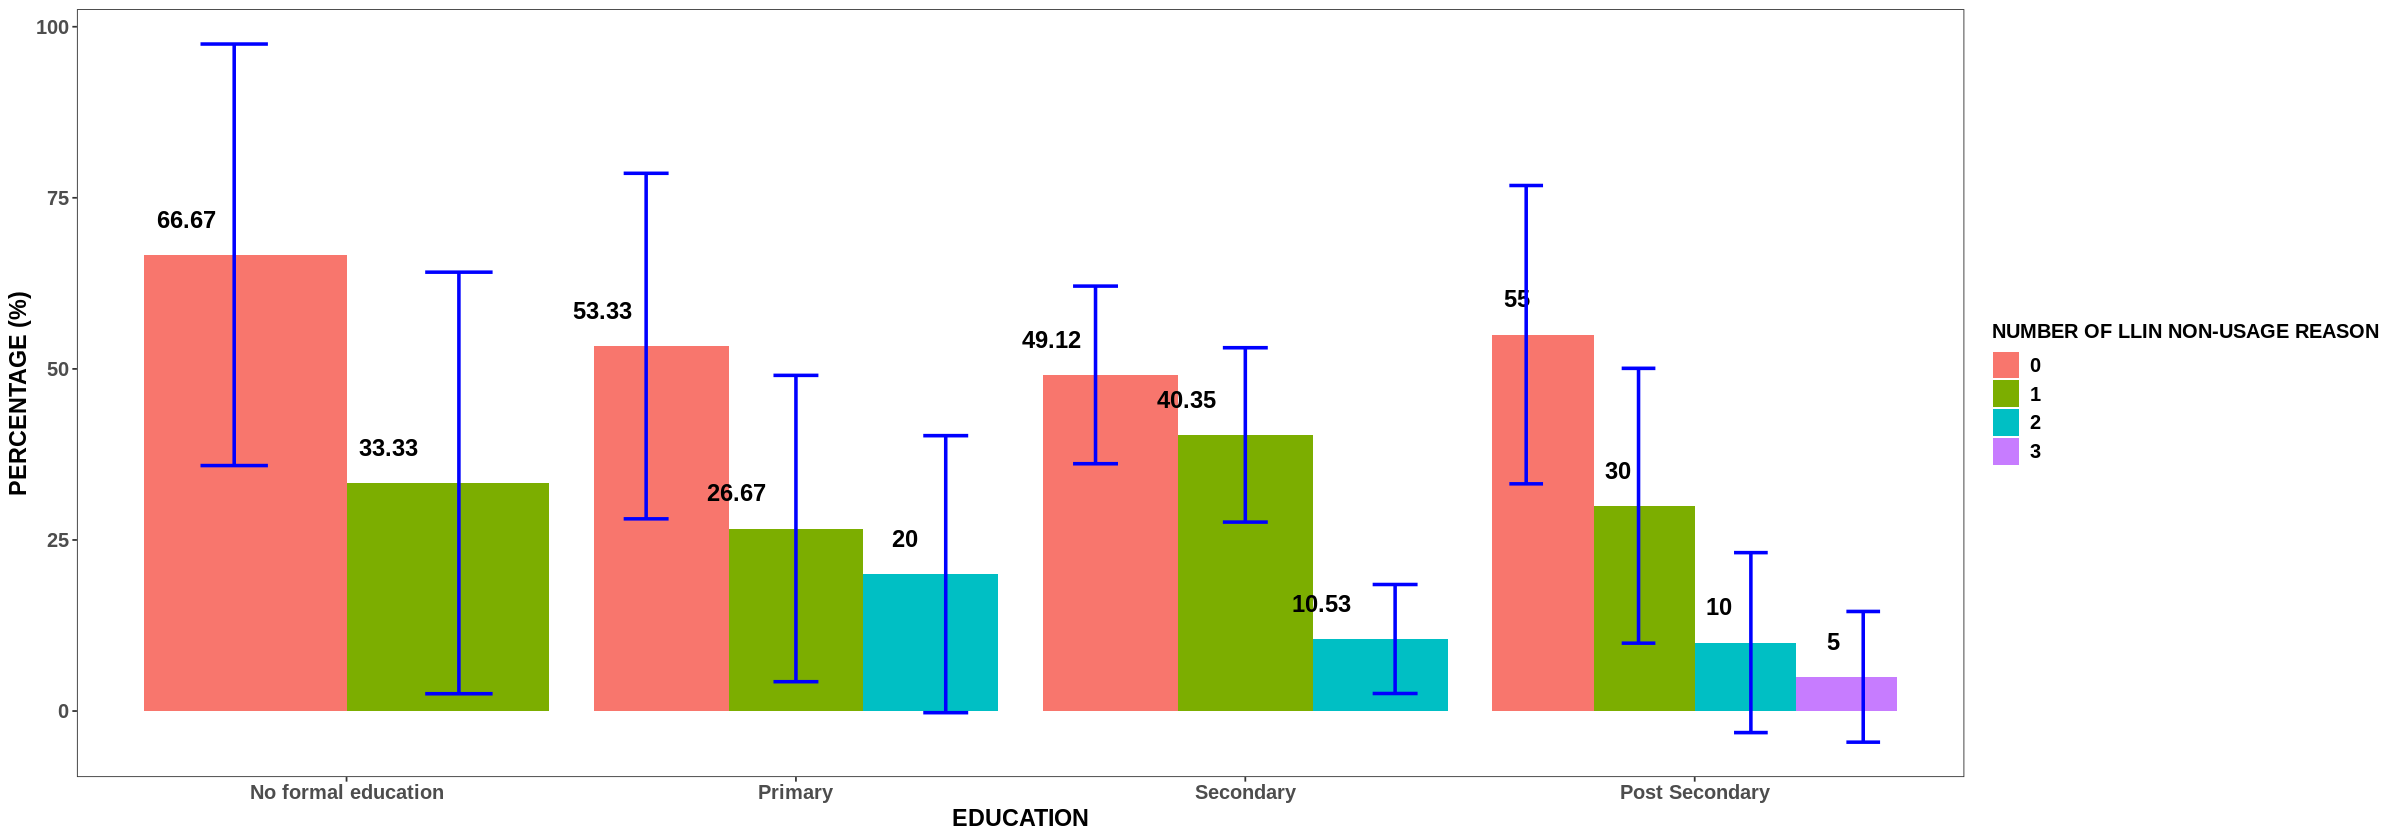



-------------------------------------------


-------------------------------------------
ACCOMODATION

-------------------------------------------


B13                              Freq % Freq    
1 A whole family house              26   25.742574
2 Duplex                             6    5.940594
3 Two/three bedroom flat            16   15.841584
4 Mini flat/self-contain apartment  32   31.683168
5 Room and parlour                  21   20.792079
6 Single room                        0    0.000000
7 Wood & makeshift structure         0    0.000000
8 Total                            101  100.000000

A whole family house Duplex      Two/three bedroom flat
0     14 [ 13.86% ]        2 [ 1.98% ] 7 [ 6.93% ]           
1     10 [ 9.9% ]          3 [ 2.97% ] 4 [ 3.96% ]           
2     1 [ 0.99% ]          1 [ 0.99% ] 5 [ 4.95% ]           
3     1 [ 0.99% ]          0 [ 0% ]    0 [ 0% ]              
Total 26 [ 25.74% ]        6 [ 5.94% ] 16 [ 15.84% ]         
      Mini flat/self-contain apartment Room and parlour Single room
0     19 [ 18.81% ]                    11 [ 10.89% ]    0 [ 0% ]   
1     11 [ 10.89% ]                    8 [ 7.92% ]      0 [ 0% ]   
2     2 [ 1.98% ]                      2 [ 1.98% ]      0 [ 0% ]   
3     0 [ 0% ]                         0 [ 0% ]         0 [ 0% ]   
Total 32 [ 31.68% ]                    21 [ 20.79% ]    0 [ 0% ]   
      Wood & makeshift structure Total        
0     0 [ 0% ]                   53 [ 52.48% ]
1     0 [ 0% ]                   36 [ 35.64% ]
2     0 [ 0% ]                   11 [ 10.89% ]
3     0 [ 0% ]                   1 [ 0.99% ]  
Total 0 [ 0% ]                   101 [ 100% ]

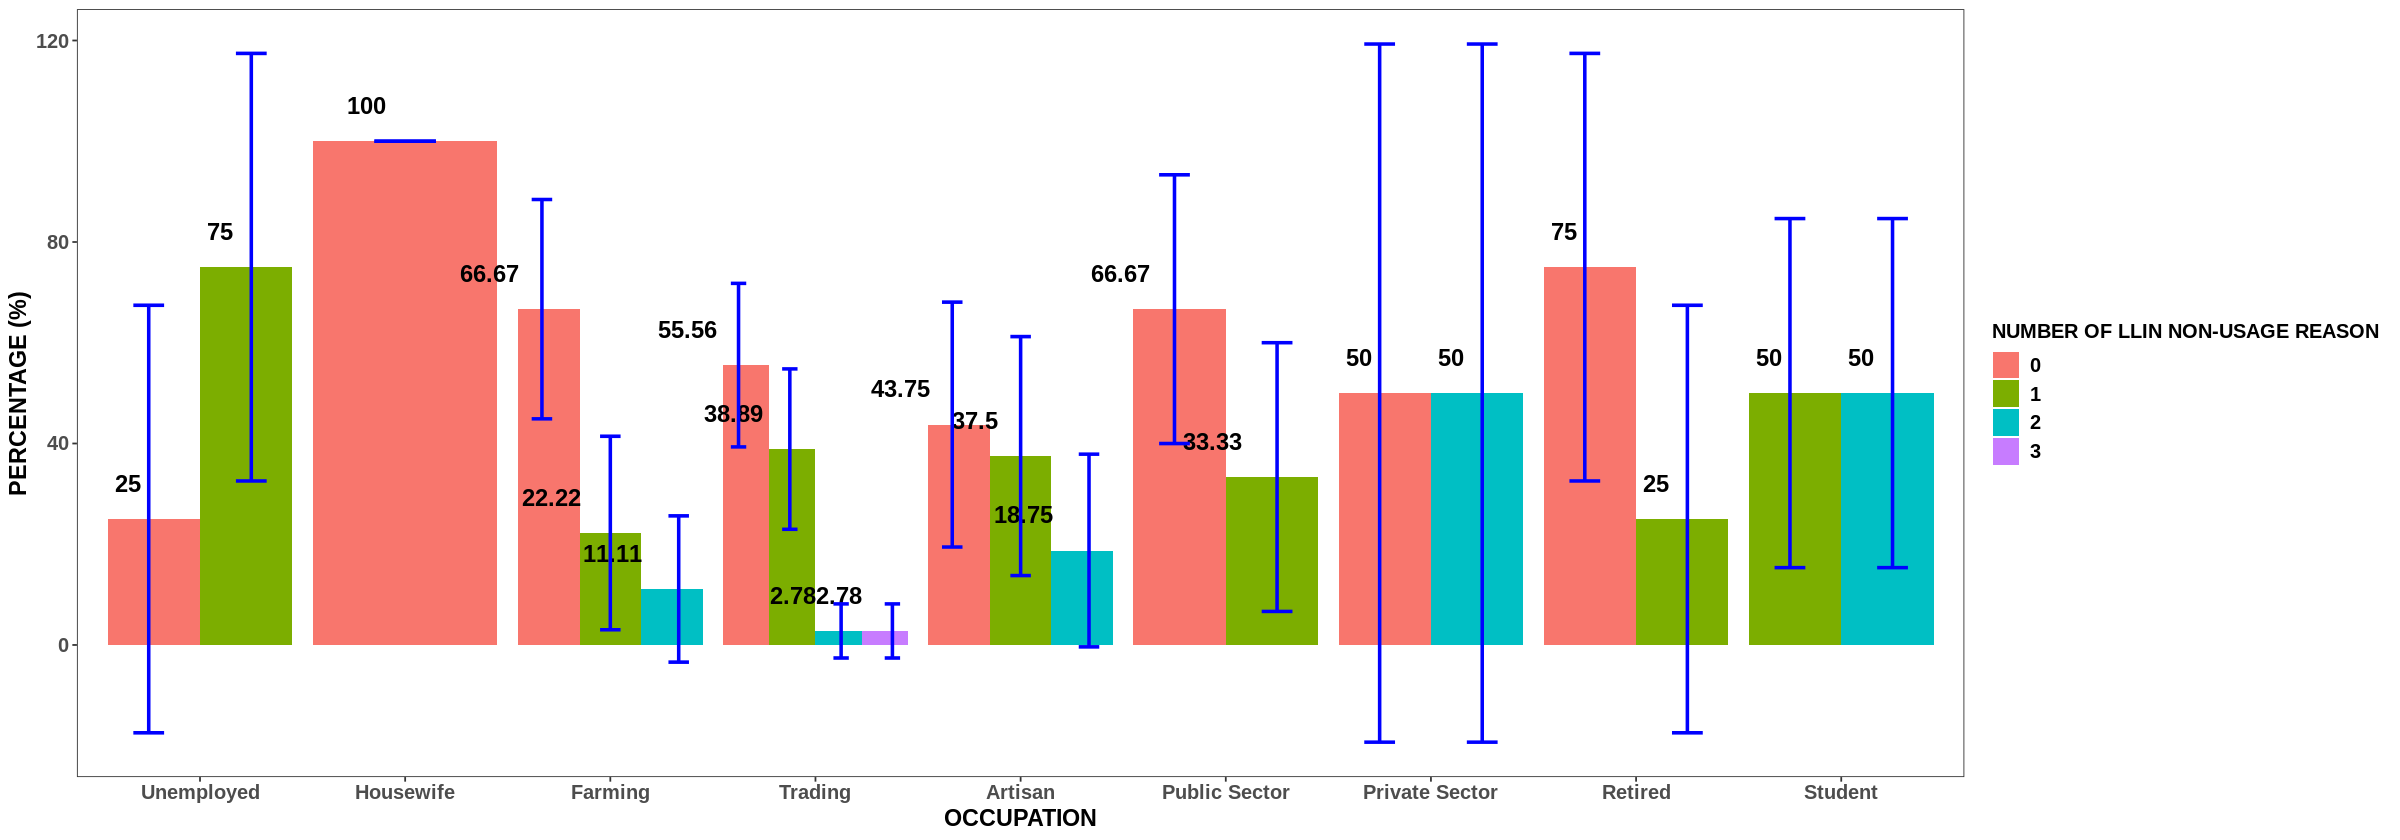



-------------------------------------------


-------------------------------------------
EDUCATION MODIFIED

-------------------------------------------


A5MUT             Freq % Freq   
1 Secondary & Above  77   76.23762
2 Pre Secondary      24   23.76238
3 Total             101  100.00000

Secondary & Above Pre Secondary Total        
0     39 [ 38.61% ]     14 [ 13.86% ] 53 [ 52.48% ]
1     29 [ 28.71% ]     7 [ 6.93% ]   36 [ 35.64% ]
2     8 [ 7.92% ]       3 [ 2.97% ]   11 [ 10.89% ]
3     1 [ 0.99% ]       0 [ 0% ]      1 [ 0.99% ]  
Total 77 [ 76.24% ]     24 [ 23.76% ] 101 [ 100% ]

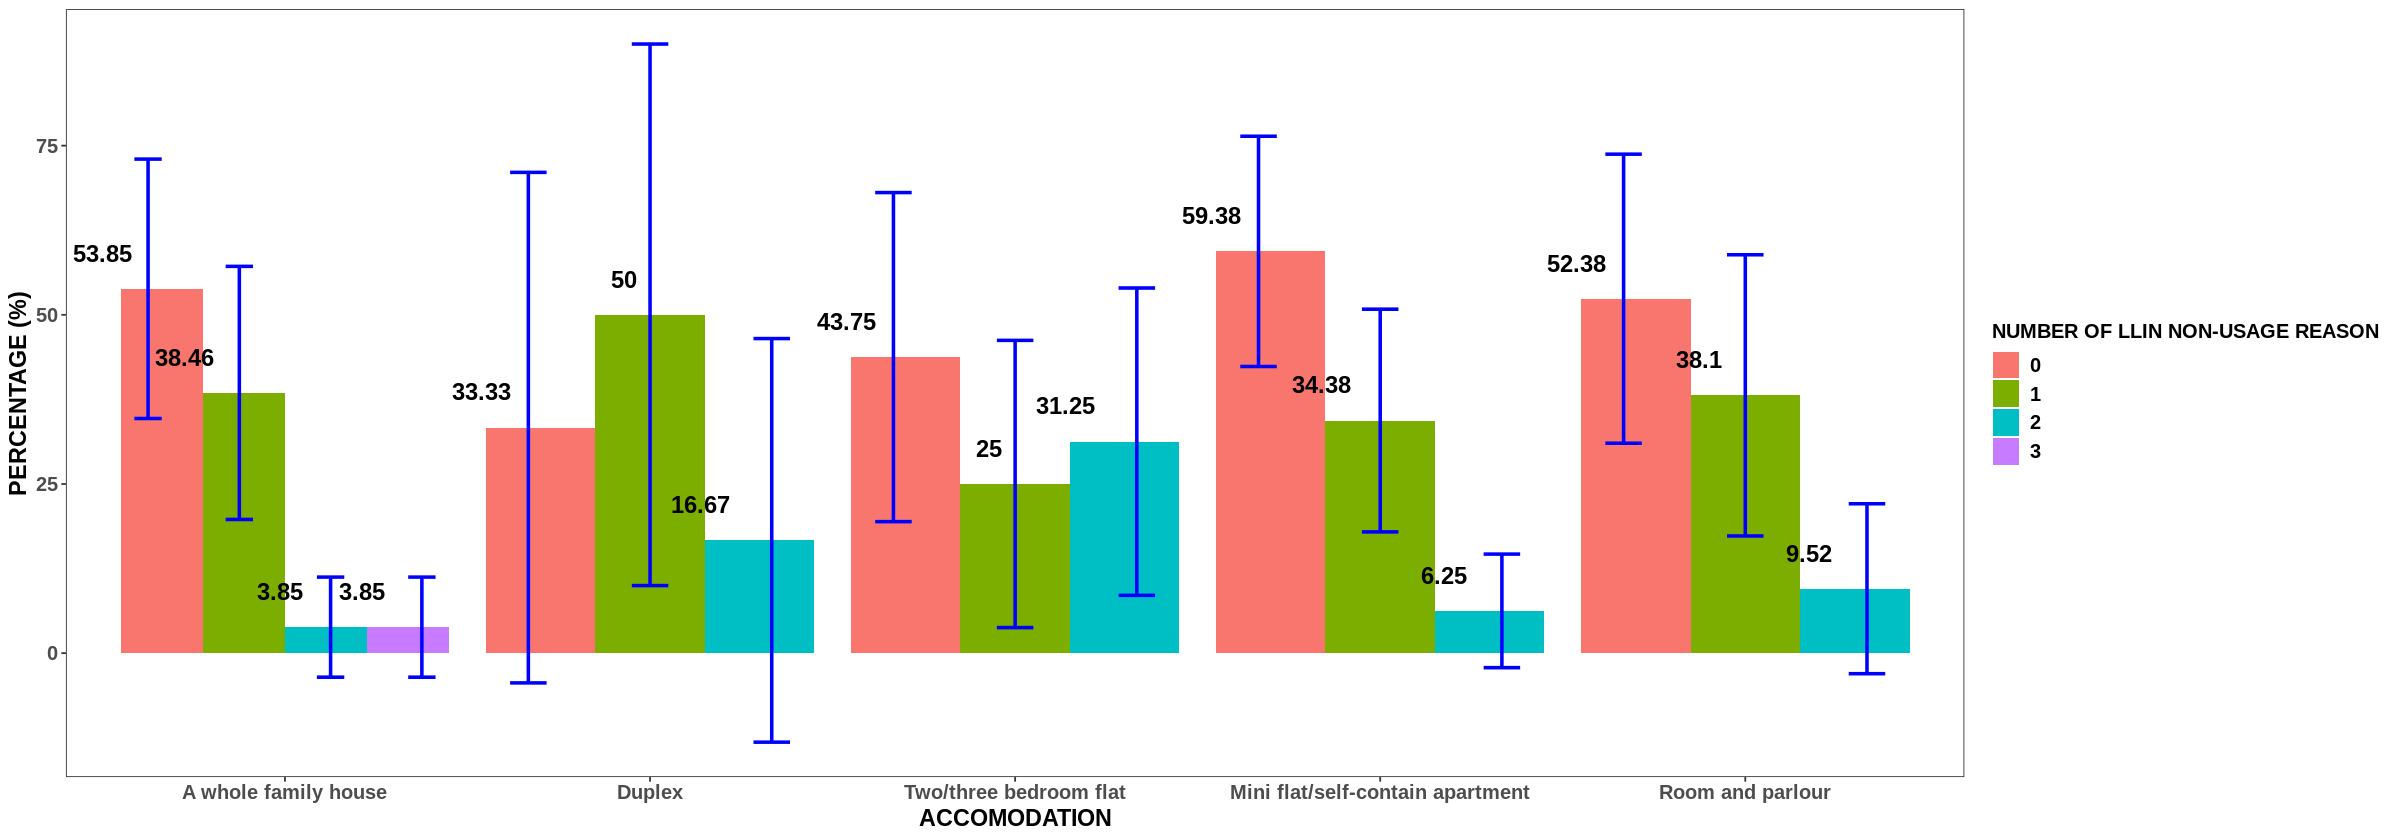



-------------------------------------------


-------------------------------------------
OCCUPATION MODIFIED

-------------------------------------------


A6MUT                  Freq % Freq    
1 Blue Collar             70   69.306931
2 White Collar            18   17.821782
3 Student                  8    7.920792
4 Unemployed & Housewife   5    4.950495
5 Total                  101  100.000000

Blue Collar   White Collar  Student     Unemployed & Housewife
0     39 [ 38.61% ] 12 [ 11.88% ] 0 [ 0% ]    2 [ 1.98% ]           
1     24 [ 23.76% ] 5 [ 4.95% ]   4 [ 3.96% ] 3 [ 2.97% ]           
2     6 [ 5.94% ]   1 [ 0.99% ]   4 [ 3.96% ] 0 [ 0% ]              
3     1 [ 0.99% ]   0 [ 0% ]      0 [ 0% ]    0 [ 0% ]              
Total 70 [ 69.31% ] 18 [ 17.82% ] 8 [ 7.92% ] 5 [ 4.95% ]           
      Total        
0     53 [ 52.48% ]
1     36 [ 35.64% ]
2     11 [ 10.89% ]
3     1 [ 0.99% ]  
Total 101 [ 100% ]

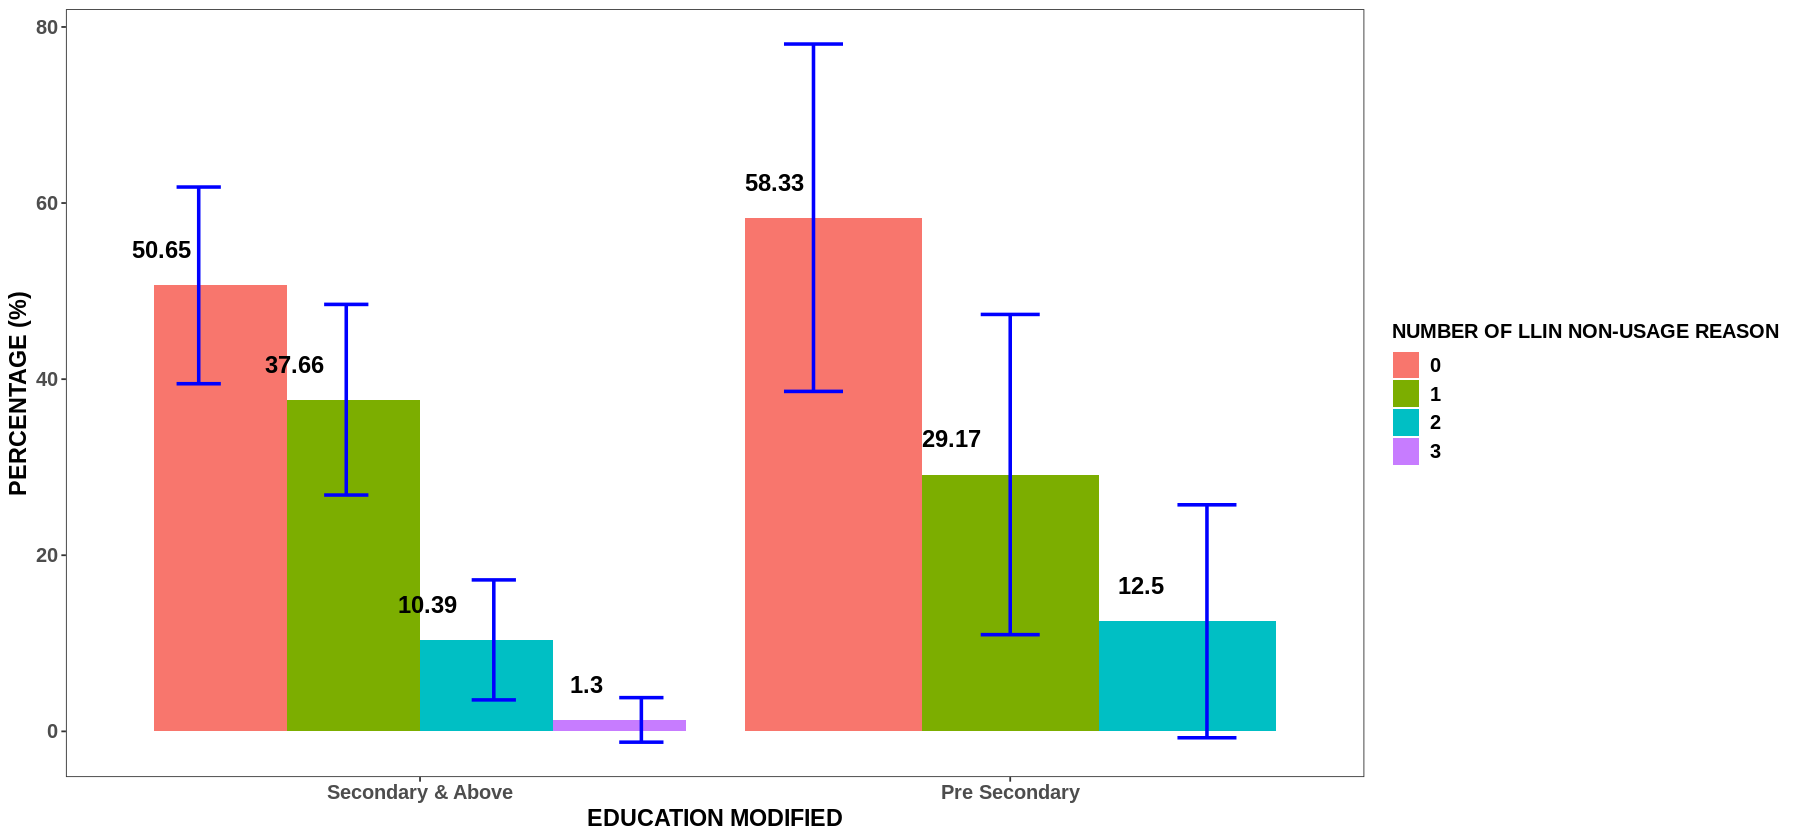



-------------------------------------------


-------------------------------------------
ACCOMODATION MODIFIED

-------------------------------------------


B13MUT       Freq % Freq   
1 Not Spacious  53   52.47525
2 Spacious      48   47.52475
3 Total        101  100.00000

Not Spacious  Spacious      Total        
0     30 [ 29.7% ]  23 [ 22.77% ] 53 [ 52.48% ]
1     19 [ 18.81% ] 17 [ 16.83% ] 36 [ 35.64% ]
2     4 [ 3.96% ]   7 [ 6.93% ]   11 [ 10.89% ]
3     0 [ 0% ]      1 [ 0.99% ]   1 [ 0.99% ]  
Total 53 [ 52.48% ] 48 [ 47.52% ] 101 [ 100% ]

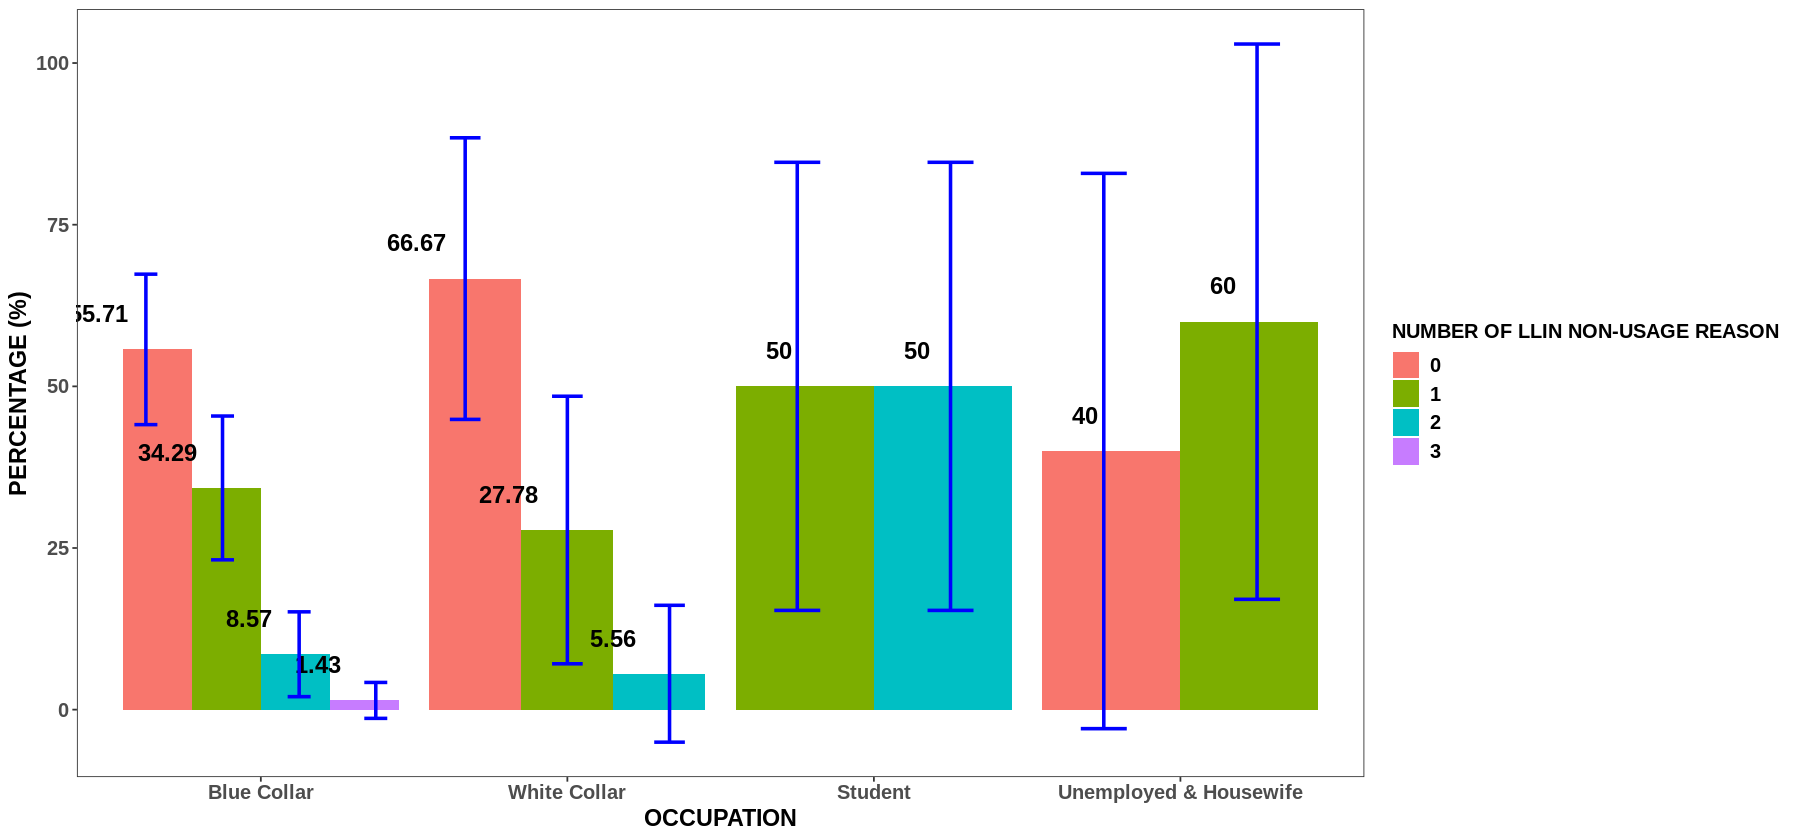

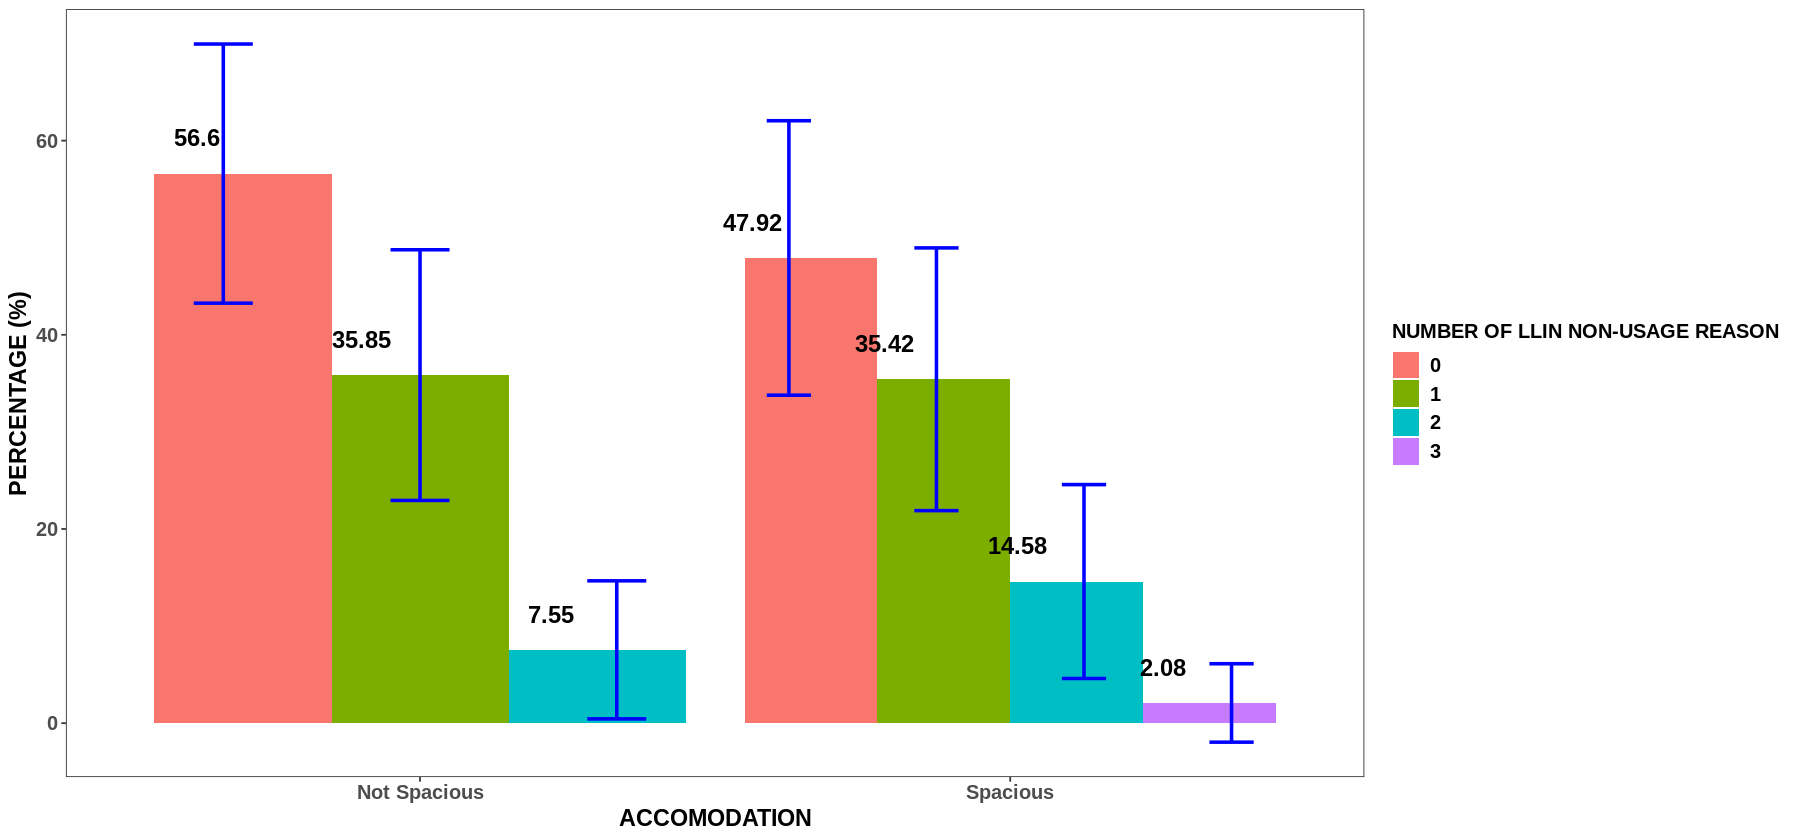

In [ ]:
fig_sizer_fn(12,7)
cat("\n\n-------------------------------------------\n")
cat("\n\n-------------------------------------------\n")

cat("SEX")
cat("\n\n-------------------------------------------\n")
analysis_df = YF_data %>% filter(is.na(LLIN_non_usage_Score) == FALSE) %>% filter(is.na(A1) == FALSE)

analysis_df %$% freq(A1)

cat("\n\n\n")

analysis_df %$% ctable_fn(x = LLIN_non_usage_Score, y = A1)

cat("\n\n\n")

#============================================================

analysis_CI_cat_df = analysis_df %>% select(LLIN_non_usage_Score, A1) %>% group_by(A1, LLIN_non_usage_Score) %>%
  summarise(Count = n(), .groups = 'drop') %>% 

  mutate(OverallPercentage = Count/sum(.$Count) ) %>%
  mutate( OverallPercentage = round(OverallPercentage,4) * 100) %>%
  
  group_by(A1) %>% mutate(WithinGroupSum = sum(Count)) %>%
  group_by(LLIN_non_usage_Score, .add=TRUE) %>%
  mutate(Percentage = Count/WithinGroupSum , Lower_CI = Percentage - 1.96 * sqrt( Percentage * {1 - Percentage} / WithinGroupSum), Upper_CI = Percentage + 1.96 * sqrt( Percentage * {1 - Percentage} / WithinGroupSum)) %>%
  mutate( Percentage = round(Percentage, 4) * 100, Lower_CI  = round(Lower_CI, 4) * 100, Upper_CI = round(Upper_CI,4) * 100)

ggplot(analysis_CI_cat_df, aes(x = factor(A1), y = Percentage, fill = factor(LLIN_non_usage_Score))) +
  geom_bar(position="dodge", stat="identity", width = 0.9) +
   geom_text(aes(label = Percentage), position = position_dodge(0.9), hjust = 1.5, vjust = -1.6, fontface = "bold", size = 5) +
  labs(x = "SEX", y = "PERCENTAGE (%)", fill = "NUMBER OF LLIN NON-USAGE REASON") +  
      geom_errorbar(aes(ymin = Lower_CI, ymax = Upper_CI), width = 0.3 , position = position_dodge(width = 1), color = "blue", size = 1)    +
  theme_minimal(base_size = 18)+
  theme_bw() +
  theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank()) +
  theme(legend.text=element_text(size = 12, face = "bold"), legend.title = element_text(size=12 , face = "bold"), axis.text=element_text(size=12, face="bold"),
        axis.title=element_text(size=14, face="bold"), plot.title = element_text(hjust = 0.5, size = 16, face = "bold"))



cat("\n\n-------------------------------------------\n")
cat("\n\n-------------------------------------------\n")

cat("AGE CONTINUOUS")
cat("\n\n-------------------------------------------\n")

analysis_df = YF_data %>% filter(is.na(LLIN_non_usage_Score) == FALSE) %>% filter(is.na(A2) == FALSE)

cat(paste0("\n\n Number of missing observation is: ", nrow(YF_data) - nrow(analysis_df), " out of ", nrow(YF_data), "\n"))
#=======================================================================

analysis_df = analysis_df %>% select(c(A2, LLIN_non_usage_Score ))
analysis_df = analysis_df[complete.cases(analysis_df),]

analysis_df$A2 = as.numeric(analysis_df$A2)

cat("\n\n")

#=======================================================================

analysis_CI_cont_df1 = analysis_df %>% group_by(LLIN_non_usage_Score) %>%
                       summarise(Count = n(), Mean = mean(A2, na.rm=TRUE), Min = quantile(A2, 0, na.rm=TRUE), Q1 = quantile(A2, 0.25, na.rm=TRUE), 
                       Q2 = quantile(A2, 0.5, na.rm=TRUE),  Q3 = quantile(A2, 0.75, na.rm=TRUE), Max = quantile(A2, 1, na.rm=TRUE),
                       Sd = sd(A2, na.rm=TRUE), .groups = 'drop') %>%
                       mutate( Margin_Error = {Sd/sqrt(Count)} * qt(1-0.05/2, Count - 1)  ) %>% mutate(Mean = round(Mean, 2),  Margin_Error = round(Margin_Error, 2) )
analysis_CI_cont_df1$LLIN_non_usage_Score = as.character(analysis_CI_cont_df1$LLIN_non_usage_Score)

analysis_CI_cont_df2 = analysis_df %>%
                       summarise(LLIN_non_usage_Score =  "Total", Count = n(), Mean = mean(A2, na.rm=TRUE), Min = quantile(A2, 0, na.rm=TRUE), Q1 = quantile(A2, 0.25, na.rm=TRUE), 
                       Q2 = quantile(A2, 0.5, na.rm=TRUE),  Q3 = quantile(A2, 0.75, na.rm=TRUE), Max = quantile(A2, 1, na.rm=TRUE),
                       Sd = sd(A2, na.rm=TRUE), .groups = 'drop') %>%
                       mutate( Margin_Error = {Sd/sqrt(Count)} * qt(1-0.05/2, Count - 1)  ) %>% mutate(Mean = round(Mean, 2),  Margin_Error = round(Margin_Error, 2) )

analysis_CI_cont_df = rbind(analysis_CI_cont_df1, analysis_CI_cont_df2)

analysis_CI_cont_df 

#================================================================


ggplot(analysis_CI_cont_df, aes(x = factor(LLIN_non_usage_Score), y = Mean , fill = factor(LLIN_non_usage_Score))) +
  geom_bar(position="dodge", stat="identity", width = 0.9) +
  labs(x = "AGE CONT (Answers to Protection Approach Questions)", y = "Mean", fill = "NUMBER OF LLIN NON-USAGE REASON") +  
       geom_text(aes(label = Mean), position = position_dodge(0.9), hjust = 1.5, vjust = -1.6, fontface = "bold", size = 5) +
      geom_errorbar(aes(ymin = Mean  - Margin_Error, ymax = Mean + Margin_Error), width = 0.5, position = position_dodge(width = 0.5), color="blue", size=1)    +
  theme_minimal(base_size = 18)+
  theme_bw() +
  theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank()) +
  theme(legend.text=element_text(size = 12, face = "bold"), legend.title = element_text(size=12 , face = "bold"), axis.text=element_text(size=12, face="bold"),
        axis.title=element_text(size=14, face="bold"), plot.title = element_text(hjust = 0.5, size = 16, face = "bold"))






cat("\n\n-------------------------------------------\n")
cat("\n\n-------------------------------------------\n")

cat("AGE CATEGORICAL")
cat("\n\n-------------------------------------------\n")

analysis_df = YF_data %>% filter(is.na(LLIN_non_usage_Score) == FALSE) %>% filter(is.na(AGECAT) == FALSE)

analysis_df %$% freq(AGECAT)

cat("\n\n\n")

analysis_df %$% ctable_fn(x = LLIN_non_usage_Score, y = AGECAT)


#============================================================

analysis_CI_cat_df = analysis_df %>% select(LLIN_non_usage_Score, AGECAT) %>% group_by(AGECAT, LLIN_non_usage_Score) %>%
  summarise(Count = n(), .groups = 'drop') %>% 

  mutate(OverallPercentage = Count/sum(.$Count) ) %>%
  mutate( OverallPercentage = round(OverallPercentage,4) * 100) %>%
  
  group_by(AGECAT) %>% mutate(WithinGroupSum = sum(Count)) %>%
  group_by(LLIN_non_usage_Score, .add=TRUE) %>%
  mutate(Percentage = Count/WithinGroupSum , Lower_CI = Percentage - 1.96 * sqrt( Percentage * {1 - Percentage} / WithinGroupSum), Upper_CI = Percentage + 1.96 * sqrt( Percentage * {1 - Percentage} / WithinGroupSum)) %>%
  mutate( Percentage = round(Percentage, 4) * 100, Lower_CI  = round(Lower_CI, 4) * 100, Upper_CI = round(Upper_CI,4) * 100)
fig_sizer_fn(15, 7)
ggplot(analysis_CI_cat_df, aes(x = factor(AGECAT), y = Percentage, fill = factor(LLIN_non_usage_Score))) +
  geom_bar(position="dodge", stat="identity", width = 0.9) +
   geom_text(aes(label = Percentage), position = position_dodge(0.9), hjust = 1.5, vjust = -1.6, fontface = "bold", size = 5) +
  labs(x = "AGE CATEGORICAL", y = "PERCENTAGE (%)", fill = "NUMBER OF LLIN NON-USAGE REASON") +  
      geom_errorbar(aes(ymin = Lower_CI, ymax = Upper_CI), width = 0.3 , position = position_dodge(width = 1), color = "blue", size = 1)    +
  theme_minimal(base_size = 18)+
  theme_bw() +
  theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank()) +
  theme(legend.text=element_text(size = 12, face = "bold"), legend.title = element_text(size=12 , face = "bold"), axis.text=element_text(size=12, face="bold"),
        axis.title=element_text(size=14, face="bold"), plot.title = element_text(hjust = 0.5, size = 16, face = "bold"))



cat("\n\n-------------------------------------------\n")
cat("\n\n-------------------------------------------\n")

cat("EDUCATION")
cat("\n\n-------------------------------------------\n")

analysis_df = YF_data %>% filter(is.na(LLIN_non_usage_Score) == FALSE) %>% filter(is.na(A5) == FALSE)

analysis_df %$% freq(A5)

cat("\n\n\n")

analysis_df %$% ctable_fn(x = LLIN_non_usage_Score, y = A5)


#============================================================

analysis_CI_cat_df = analysis_df %>% select(LLIN_non_usage_Score, A5) %>% group_by(A5, LLIN_non_usage_Score) %>%
  summarise(Count = n(), .groups = 'drop') %>% 

  mutate(OverallPercentage = Count/sum(.$Count) ) %>%
  mutate( OverallPercentage = round(OverallPercentage,4) * 100) %>%
  
  group_by(A5) %>% mutate(WithinGroupSum = sum(Count)) %>%
  group_by(LLIN_non_usage_Score, .add=TRUE) %>%
  mutate(Percentage = Count/WithinGroupSum , Lower_CI = Percentage - 1.96 * sqrt( Percentage * {1 - Percentage} / WithinGroupSum), Upper_CI = Percentage + 1.96 * sqrt( Percentage * {1 - Percentage} / WithinGroupSum)) %>%
  mutate( Percentage = round(Percentage, 4) * 100, Lower_CI  = round(Lower_CI, 4) * 100, Upper_CI = round(Upper_CI,4) * 100)

fig_sizer_fn(20, 7)

ggplot(analysis_CI_cat_df, aes(x = factor(A5), y = Percentage, fill = factor(LLIN_non_usage_Score))) +
  geom_bar(position="dodge", stat="identity", width = 0.9) +
   geom_text(aes(label = Percentage), position = position_dodge(0.9), hjust = 1.5, vjust = -1.6, fontface = "bold", size = 5) +
  labs(x = "EDUCATION", y = "PERCENTAGE (%)", fill = "NUMBER OF LLIN NON-USAGE REASON") +  
      geom_errorbar(aes(ymin = Lower_CI, ymax = Upper_CI), width = 0.3 , position = position_dodge(width = 1), color = "blue", size = 1)    +
  theme_minimal(base_size = 18)+
  theme_bw() +
  theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank()) +
  theme(legend.text=element_text(size = 12, face = "bold"), legend.title = element_text(size=12 , face = "bold"), axis.text=element_text(size=12, face="bold"),
        axis.title=element_text(size=14, face="bold"), plot.title = element_text(hjust = 0.5, size = 16, face = "bold"))



cat("\n\n-------------------------------------------\n")
cat("\n\n-------------------------------------------\n")

cat("OCCUPATION")
cat("\n\n-------------------------------------------\n")

analysis_df = YF_data %>% filter(is.na(LLIN_non_usage_Score) == FALSE) %>% filter(is.na(A6) == FALSE)

analysis_df %$% freq(A6)

cat("\n\n\n")

analysis_df %$% ctable_fn(x = LLIN_non_usage_Score, y = A6)


#============================================================

analysis_CI_cat_df = analysis_df %>% select(LLIN_non_usage_Score, A6) %>% group_by(A6, LLIN_non_usage_Score) %>%
  summarise(Count = n(), .groups = 'drop') %>% 

  mutate(OverallPercentage = Count/sum(.$Count) ) %>%
  mutate( OverallPercentage = round(OverallPercentage,4) * 100) %>%
  
  group_by(A6) %>% mutate(WithinGroupSum = sum(Count)) %>%
  group_by(LLIN_non_usage_Score, .add=TRUE) %>%
  mutate(Percentage = Count/WithinGroupSum , Lower_CI = Percentage - 1.96 * sqrt( Percentage * {1 - Percentage} / WithinGroupSum), Upper_CI = Percentage + 1.96 * sqrt( Percentage * {1 - Percentage} / WithinGroupSum)) %>%
  mutate( Percentage = round(Percentage, 4) * 100, Lower_CI  = round(Lower_CI, 4) * 100, Upper_CI = round(Upper_CI,4) * 100)

fig_sizer_fn(20, 7)

ggplot(analysis_CI_cat_df, aes(x = factor(A6), y = Percentage, fill = factor(LLIN_non_usage_Score))) +
  geom_bar(position="dodge", stat="identity", width = 0.9) +
   geom_text(aes(label = Percentage), position = position_dodge(0.9), hjust = 1.5, vjust = -1.6, fontface = "bold", size = 5) +
  labs(x = "OCCUPATION", y = "PERCENTAGE (%)", fill = "NUMBER OF LLIN NON-USAGE REASON") +  
      geom_errorbar(aes(ymin = Lower_CI, ymax = Upper_CI), width = 0.3 , position = position_dodge(width = 1), color = "blue", size = 1)    +
  theme_minimal(base_size = 18)+
  theme_bw() +
  theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank()) +
  theme(legend.text=element_text(size = 12, face = "bold"), legend.title = element_text(size=12 , face = "bold"), axis.text=element_text(size=12, face="bold"),
        axis.title=element_text(size=14, face="bold"), plot.title = element_text(hjust = 0.5, size = 16, face = "bold"))




cat("\n\n-------------------------------------------\n")
cat("\n\n-------------------------------------------\n")

cat("ACCOMODATION")
cat("\n\n-------------------------------------------\n")

analysis_df = YF_data %>% filter(is.na(LLIN_non_usage_Score) == FALSE) %>% filter(is.na(B13) == FALSE)

analysis_df %$% freq(B13)

cat("\n\n\n")

analysis_df %$% ctable_fn(x = LLIN_non_usage_Score, y = B13)


#============================================================

analysis_CI_cat_df = analysis_df %>% select(LLIN_non_usage_Score, B13) %>% group_by(B13, LLIN_non_usage_Score) %>%
  summarise(Count = n(), .groups = 'drop') %>% 

  mutate(OverallPercentage = Count/sum(.$Count) ) %>%
  mutate( OverallPercentage = round(OverallPercentage,4) * 100) %>%
  
  group_by(B13) %>% mutate(WithinGroupSum = sum(Count)) %>%
  group_by(LLIN_non_usage_Score, .add=TRUE) %>%
  mutate(Percentage = Count/WithinGroupSum , Lower_CI = Percentage - 1.96 * sqrt( Percentage * {1 - Percentage} / WithinGroupSum), Upper_CI = Percentage + 1.96 * sqrt( Percentage * {1 - Percentage} / WithinGroupSum)) %>%
  mutate( Percentage = round(Percentage, 4) * 100, Lower_CI  = round(Lower_CI, 4) * 100, Upper_CI = round(Upper_CI,4) * 100)

fig_sizer_fn(20, 7)

ggplot(analysis_CI_cat_df, aes(x = factor(B13), y = Percentage, fill = factor(LLIN_non_usage_Score))) +
  geom_bar(position="dodge", stat="identity", width = 0.9) +
   geom_text(aes(label = Percentage), position = position_dodge(0.9), hjust = 1.5, vjust = -1.6, fontface = "bold", size = 5) +
  labs(x = "ACCOMODATION", y = "PERCENTAGE (%)", fill = "NUMBER OF LLIN NON-USAGE REASON") +  
      geom_errorbar(aes(ymin = Lower_CI, ymax = Upper_CI), width = 0.3 , position = position_dodge(width = 1), color = "blue", size = 1)    +
  theme_minimal(base_size = 18)+
  theme_bw() +
  theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank()) +
  theme(legend.text=element_text(size = 12, face = "bold"), legend.title = element_text(size=12 , face = "bold"), axis.text=element_text(size=12, face="bold"),
        axis.title=element_text(size=14, face="bold"), plot.title = element_text(hjust = 0.5, size = 16, face = "bold"))



#====================================================================================================================
#====================================================================================================================
#====================================================================================================================
#====================================================================================================================


fig_sizer_fn()

cat("\n\n-------------------------------------------\n")
cat("\n\n-------------------------------------------\n")

cat("EDUCATION MODIFIED")
cat("\n\n-------------------------------------------\n")

analysis_df = YF_data %>% filter(is.na(LLIN_non_usage_Score) == FALSE) %>% filter(is.na(A5MUT) == FALSE)

analysis_df %$% freq(A5MUT)

cat("\n\n\n")

analysis_df %$% ctable_fn(x = LLIN_non_usage_Score, y = A5MUT)


#============================================================

analysis_CI_cat_df = analysis_df %>% select(LLIN_non_usage_Score, A5MUT) %>% group_by(A5MUT, LLIN_non_usage_Score) %>%
  summarise(Count = n(), .groups = 'drop') %>% 

  mutate(OverallPercentage = Count/sum(.$Count) ) %>%
  mutate( OverallPercentage = round(OverallPercentage,4) * 100) %>%
  
  group_by(A5MUT) %>% mutate(WithinGroupSum = sum(Count)) %>%
  group_by(LLIN_non_usage_Score, .add=TRUE) %>%
  mutate(Percentage = Count/WithinGroupSum , Lower_CI = Percentage - 1.96 * sqrt( Percentage * {1 - Percentage} / WithinGroupSum), Upper_CI = Percentage + 1.96 * sqrt( Percentage * {1 - Percentage} / WithinGroupSum)) %>%
  mutate( Percentage = round(Percentage, 4) * 100, Lower_CI  = round(Lower_CI, 4) * 100, Upper_CI = round(Upper_CI,4) * 100)

fig_sizer_fn(15, 7)

ggplot(analysis_CI_cat_df, aes(x = factor(A5MUT), y = Percentage, fill = factor(LLIN_non_usage_Score))) +
  geom_bar(position="dodge", stat="identity", width = 0.9) +
   geom_text(aes(label = Percentage), position = position_dodge(0.9), hjust = 1.5, vjust = -1.6, fontface = "bold", size = 5) +
  labs(x = "EDUCATION MODIFIED", y = "PERCENTAGE (%)", fill = "NUMBER OF LLIN NON-USAGE REASON") +  
      geom_errorbar(aes(ymin = Lower_CI, ymax = Upper_CI), width = 0.3 , position = position_dodge(width = 1), color = "blue", size = 1)    +
  theme_minimal(base_size = 18)+
  theme_bw() +
  theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank()) +
  theme(legend.text=element_text(size = 12, face = "bold"), legend.title = element_text(size=12 , face = "bold"), axis.text=element_text(size=12, face="bold"),
        axis.title=element_text(size=14, face="bold"), plot.title = element_text(hjust = 0.5, size = 16, face = "bold"))



cat("\n\n-------------------------------------------\n")
cat("\n\n-------------------------------------------\n")

cat("OCCUPATION MODIFIED")
cat("\n\n-------------------------------------------\n")

analysis_df = YF_data %>% filter(is.na(LLIN_non_usage_Score) == FALSE) %>% filter(is.na(A6MUT) == FALSE)

analysis_df %$% freq(A6MUT)

cat("\n\n\n")

analysis_df %$% ctable_fn(x = LLIN_non_usage_Score, y = A6MUT)


#============================================================

analysis_CI_cat_df = analysis_df %>% select(LLIN_non_usage_Score, A6MUT) %>% group_by(A6MUT, LLIN_non_usage_Score) %>%
  summarise(Count = n(), .groups = 'drop') %>% 

  mutate(OverallPercentage = Count/sum(.$Count) ) %>%
  mutate( OverallPercentage = round(OverallPercentage,4) * 100) %>%
  
  group_by(A6MUT) %>% mutate(WithinGroupSum = sum(Count)) %>%
  group_by(LLIN_non_usage_Score, .add=TRUE) %>%
  mutate(Percentage = Count/WithinGroupSum , Lower_CI = Percentage - 1.96 * sqrt( Percentage * {1 - Percentage} / WithinGroupSum), Upper_CI = Percentage + 1.96 * sqrt( Percentage * {1 - Percentage} / WithinGroupSum)) %>%
  mutate( Percentage = round(Percentage, 4) * 100, Lower_CI  = round(Lower_CI, 4) * 100, Upper_CI = round(Upper_CI,4) * 100)

fig_sizer_fn(15, 7)

ggplot(analysis_CI_cat_df, aes(x = factor(A6MUT), y = Percentage, fill = factor(LLIN_non_usage_Score))) +
  geom_bar(position="dodge", stat="identity", width = 0.9) +
   geom_text(aes(label = Percentage), position = position_dodge(0.9), hjust = 1.5, vjust = -1.6, fontface = "bold", size = 5) +
  labs(x = "OCCUPATION", y = "PERCENTAGE (%)", fill = "NUMBER OF LLIN NON-USAGE REASON") +  
      geom_errorbar(aes(ymin = Lower_CI, ymax = Upper_CI), width = 0.3 , position = position_dodge(width = 1), color = "blue", size = 1)    +
  theme_minimal(base_size = 18)+
  theme_bw() +
  theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank()) +
  theme(legend.text=element_text(size = 12, face = "bold"), legend.title = element_text(size=12 , face = "bold"), axis.text=element_text(size=12, face="bold"),
        axis.title=element_text(size=14, face="bold"), plot.title = element_text(hjust = 0.5, size = 16, face = "bold"))




cat("\n\n-------------------------------------------\n")
cat("\n\n-------------------------------------------\n")

cat("ACCOMODATION MODIFIED")
cat("\n\n-------------------------------------------\n")

analysis_df = YF_data %>% filter(is.na(LLIN_non_usage_Score) == FALSE) %>% filter(is.na(B13MUT) == FALSE)

analysis_df %$% freq(B13MUT)

cat("\n\n\n")

analysis_df %$% ctable_fn(x = LLIN_non_usage_Score, y = B13MUT)


#============================================================

analysis_CI_cat_df = analysis_df %>% select(LLIN_non_usage_Score, B13MUT) %>% group_by(B13MUT, LLIN_non_usage_Score) %>%
  summarise(Count = n(), .groups = 'drop') %>% 

  mutate(OverallPercentage = Count/sum(.$Count) ) %>%
  mutate( OverallPercentage = round(OverallPercentage,4) * 100) %>%
  
  group_by(B13MUT) %>% mutate(WithinGroupSum = sum(Count)) %>%
  group_by(LLIN_non_usage_Score, .add=TRUE) %>%
  mutate(Percentage = Count/WithinGroupSum , Lower_CI = Percentage - 1.96 * sqrt( Percentage * {1 - Percentage} / WithinGroupSum), Upper_CI = Percentage + 1.96 * sqrt( Percentage * {1 - Percentage} / WithinGroupSum)) %>%
  mutate( Percentage = round(Percentage, 4) * 100, Lower_CI  = round(Lower_CI, 4) * 100, Upper_CI = round(Upper_CI,4) * 100)

fig_sizer_fn(15, 7)

ggplot(analysis_CI_cat_df, aes(x = factor(B13MUT), y = Percentage, fill = factor(LLIN_non_usage_Score))) +
  geom_bar(position="dodge", stat="identity", width = 0.9) +
   geom_text(aes(label = Percentage), position = position_dodge(0.9), hjust = 1.5, vjust = -1.6, fontface = "bold", size = 5) +
  labs(x = "ACCOMODATION", y = "PERCENTAGE (%)", fill = "NUMBER OF LLIN NON-USAGE REASON") +  
      geom_errorbar(aes(ymin = Lower_CI, ymax = Upper_CI), width = 0.3 , position = position_dodge(width = 1), color = "blue", size = 1)    +
  theme_minimal(base_size = 18)+
  theme_bw() +
  theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank()) +
  theme(legend.text=element_text(size = 12, face = "bold"), legend.title = element_text(size=12 , face = "bold"), axis.text=element_text(size=12, face="bold"),
        axis.title=element_text(size=14, face="bold"), plot.title = element_text(hjust = 0.5, size = 16, face = "bold"))



##### **Number of LLIN in a Household**



-------------------------------------------


-------------------------------------------
SEX

-------------------------------------------


A1     Freq % Freq   
1 Male   20    38.46154
2 Female 32    61.53846
3 Total  52   100.00000

Male          Female        Total        
1     6 [ 11.54% ]  9 [ 17.31% ]  15 [ 28.85% ]
2     10 [ 19.23% ] 19 [ 36.54% ] 29 [ 55.77% ]
3     4 [ 7.69% ]   4 [ 7.69% ]   8 [ 15.38% ] 
Total 20 [ 38.46% ] 32 [ 61.54% ] 52 [ 100% ]






-------------------------------------------


-------------------------------------------
AGE CONTINUOUS

-------------------------------------------


 Number of missing observation is: 49 out of 101




D28   Count Mean  Min Q1    Q2 Q3    Max Sd        Margin_Error
1 1     15    26.07  6  14.00 30 34.50 44  12.400845 6.87        
2 2     29    24.03  5  17.00 23 29.00 48  10.847919 4.13        
3 3      8    30.38 16  27.00 30 33.00 47   8.991067 7.52        
4 Total 52    25.60  5  16.75 25 32.25 48  11.088343 3.09

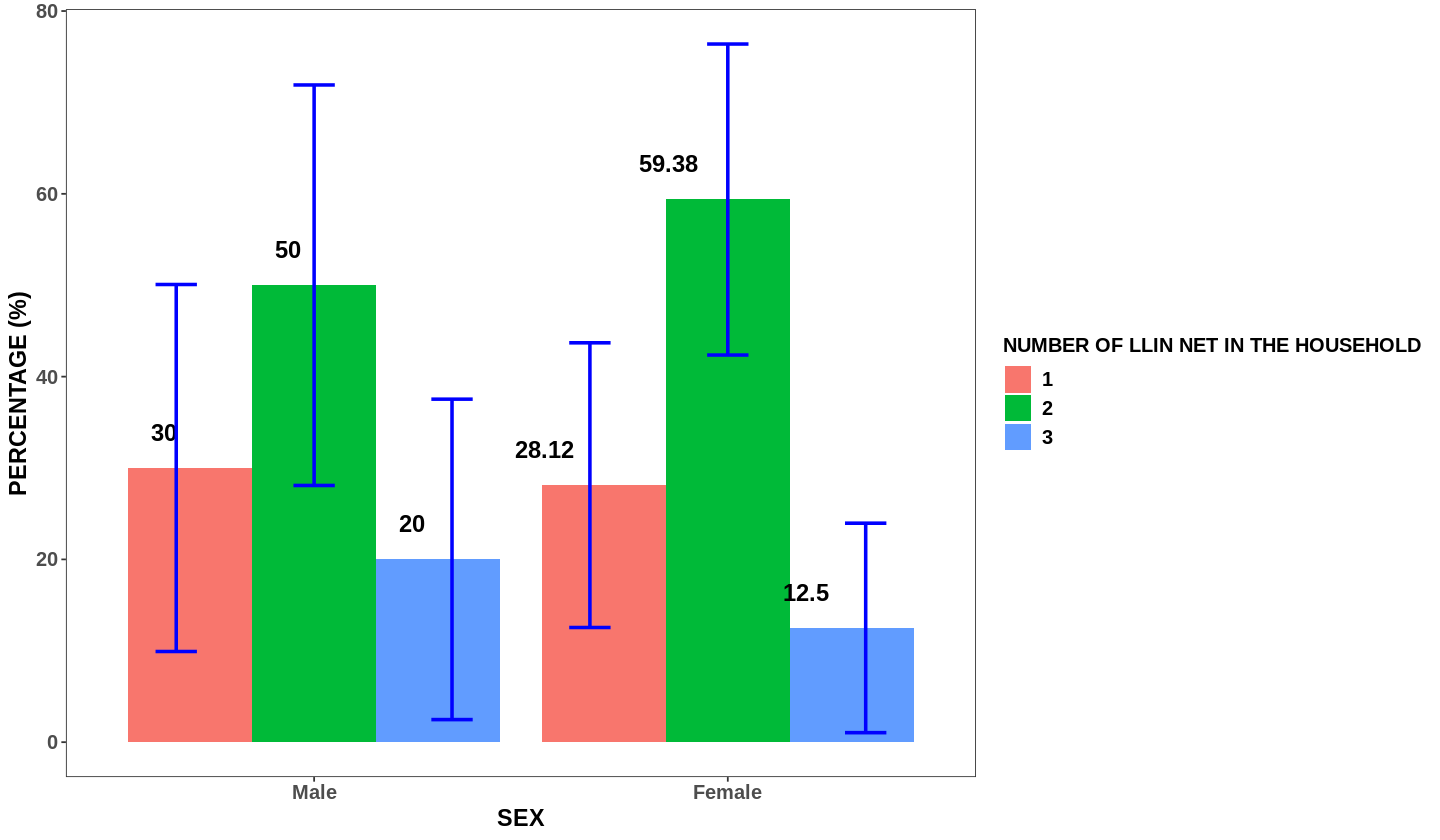



-------------------------------------------


-------------------------------------------
AGE CATEGORICAL

-------------------------------------------


AGECAT     Freq % Freq   
1 18 to 35   13    25.00000
2 35 to 60   32    61.53846
3 60 & above  7    13.46154
4 Total      52   100.00000

18 to 35     35 to 60      60 & above   Total        
1     5 [ 9.62% ]  7 [ 13.46% ]  3 [ 5.77% ]  15 [ 28.85% ]
2     7 [ 13.46% ] 19 [ 36.54% ] 3 [ 5.77% ]  29 [ 55.77% ]
3     1 [ 1.92% ]  6 [ 11.54% ]  1 [ 1.92% ]  8 [ 15.38% ] 
Total 13 [ 25% ]   32 [ 61.54% ] 7 [ 13.46% ] 52 [ 100% ]

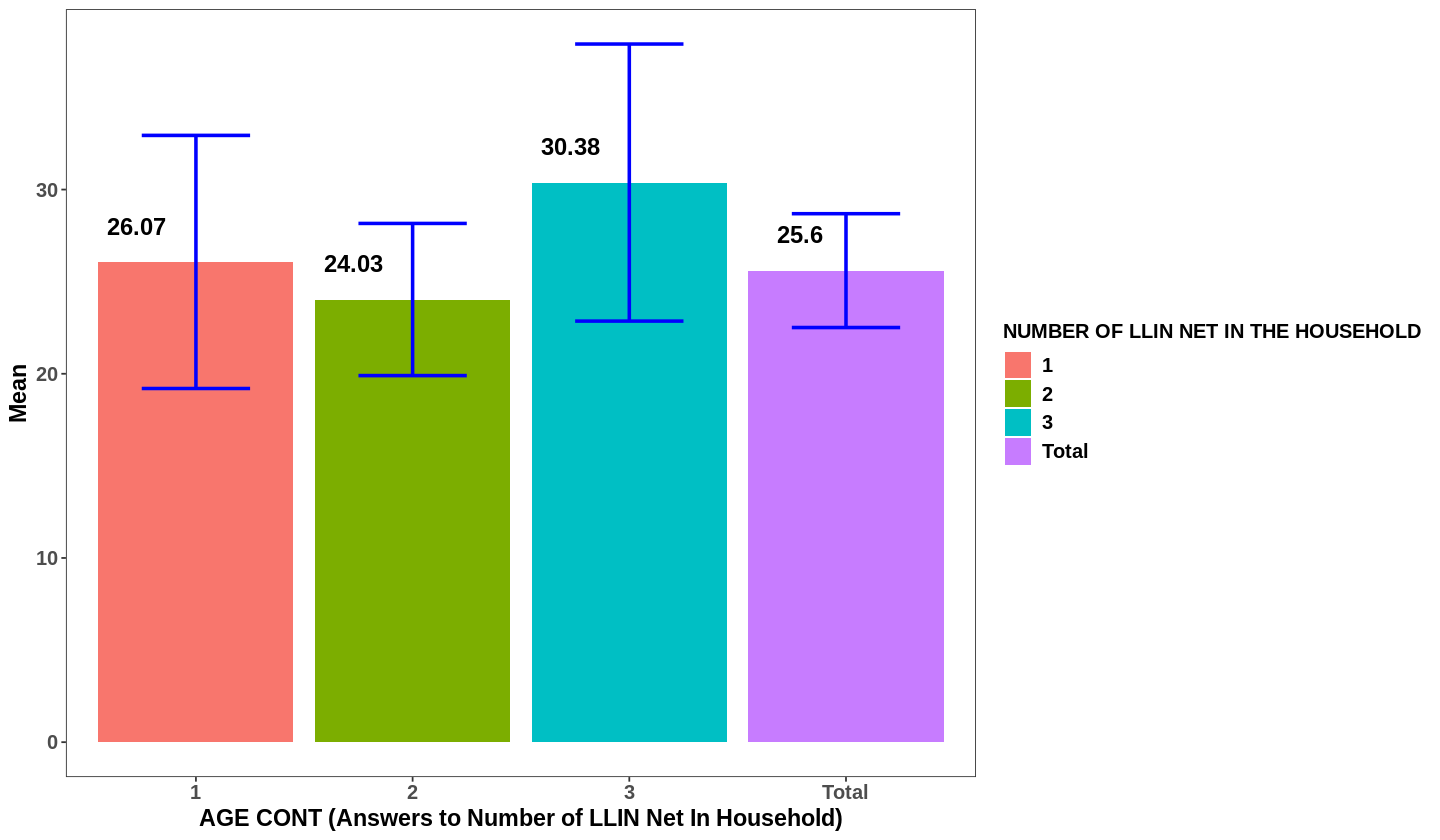



-------------------------------------------


-------------------------------------------
EDUCATION

-------------------------------------------


A5                  Freq % Freq   
1 No formal education  6    11.53846
2 Primary              8    15.38462
3 Secondary           27    51.92308
4 Post Secondary      11    21.15385
5 Total               52   100.00000

No formal education Primary      Secondary     Post Secondary
1     0 [ 0% ]            3 [ 5.77% ]  9 [ 17.31% ]  3 [ 5.77% ]   
2     6 [ 11.54% ]        3 [ 5.77% ]  13 [ 25% ]    7 [ 13.46% ]  
3     0 [ 0% ]            2 [ 3.85% ]  5 [ 9.62% ]   1 [ 1.92% ]   
Total 6 [ 11.54% ]        8 [ 15.38% ] 27 [ 51.92% ] 11 [ 21.15% ] 
      Total        
1     15 [ 28.85% ]
2     29 [ 55.77% ]
3     8 [ 15.38% ] 
Total 52 [ 100% ]

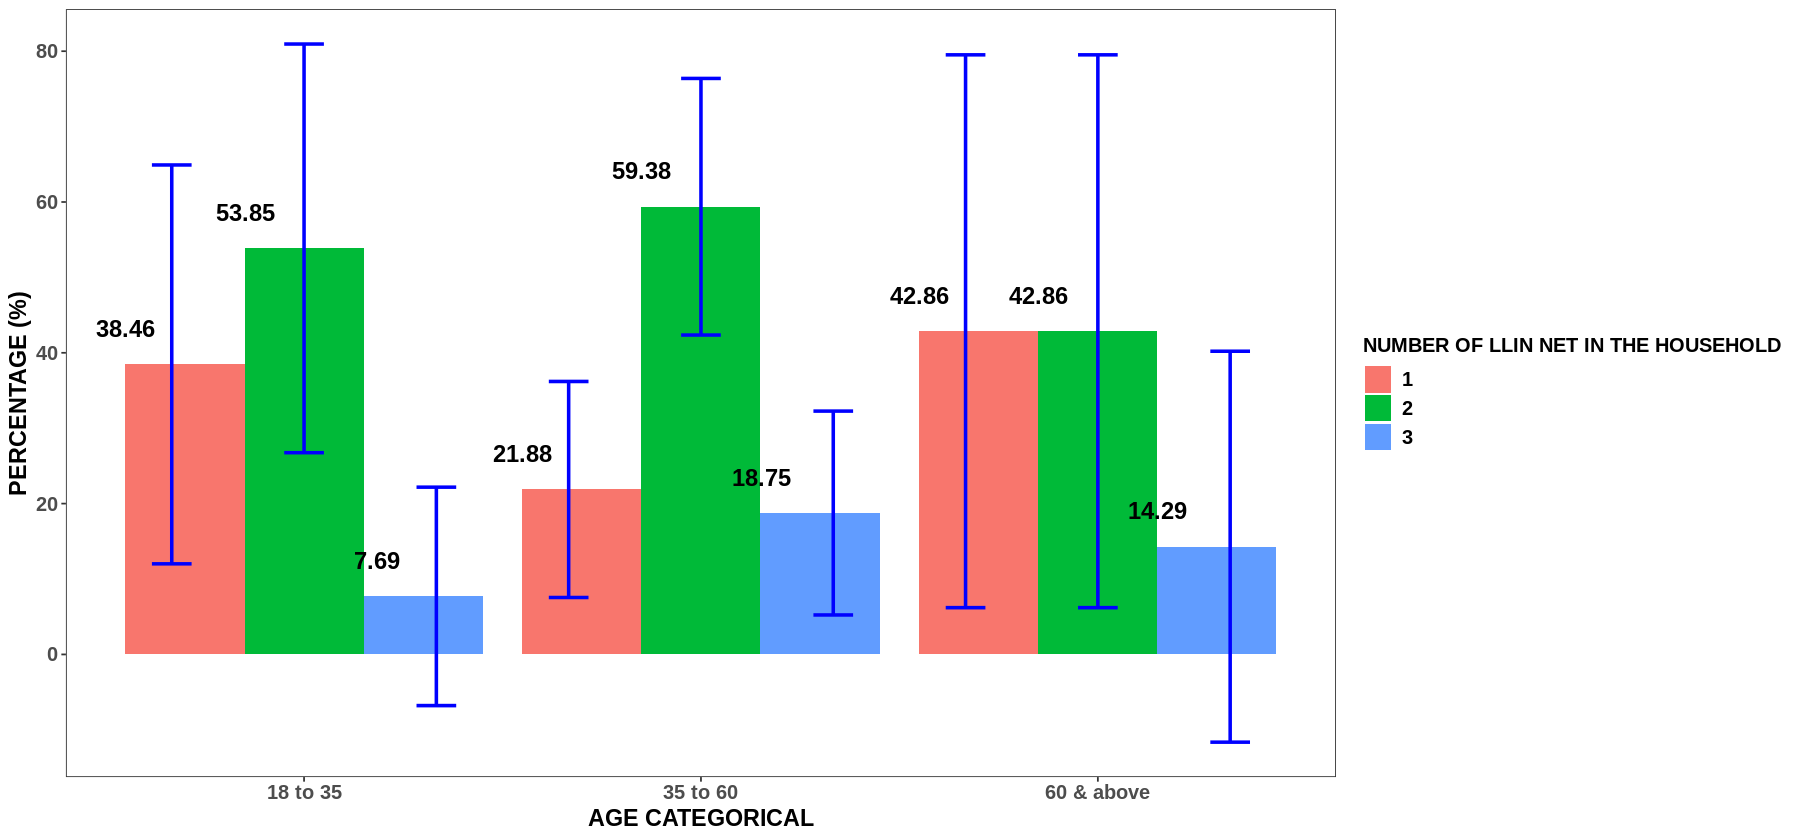



-------------------------------------------


-------------------------------------------
OCCUPATION

-------------------------------------------


A6             Freq % Freq    
1  Unemployed      1     1.923077
2  Housewife       1     1.923077
3  Farming        12    23.076923
4  Trading        20    38.461538
5  Artisan         7    13.461538
6  Public Sector   7    13.461538
7  Private Sector  1     1.923077
8  Retired         3     5.769231
9  Student         0     0.000000
10 Total          52   100.000000

Unemployed  Housewife   Farming       Trading       Artisan     
1     0 [ 0% ]    1 [ 1.92% ] 2 [ 3.85% ]   7 [ 13.46% ]  1 [ 1.92% ] 
2     1 [ 1.92% ] 0 [ 0% ]    6 [ 11.54% ]  10 [ 19.23% ] 6 [ 11.54% ]
3     0 [ 0% ]    0 [ 0% ]    4 [ 7.69% ]   3 [ 5.77% ]   0 [ 0% ]    
Total 1 [ 1.92% ] 1 [ 1.92% ] 12 [ 23.08% ] 20 [ 38.46% ] 7 [ 13.46% ]
      Public Sector Private Sector Retired     Student  Total        
1     3 [ 5.77% ]   0 [ 0% ]       1 [ 1.92% ] 0 [ 0% ] 15 [ 28.85% ]
2     4 [ 7.69% ]   1 [ 1.92% ]    1 [ 1.92% ] 0 [ 0% ] 29 [ 55.77% ]
3     0 [ 0% ]      0 [ 0% ]       1 [ 1.92% ] 0 [ 0% ] 8 [ 15.38% ] 
Total 7 [ 13.46% ]  1 [ 1.92% ]    3 [ 5.77% ] 0 [ 0% ] 52 [ 100% ]

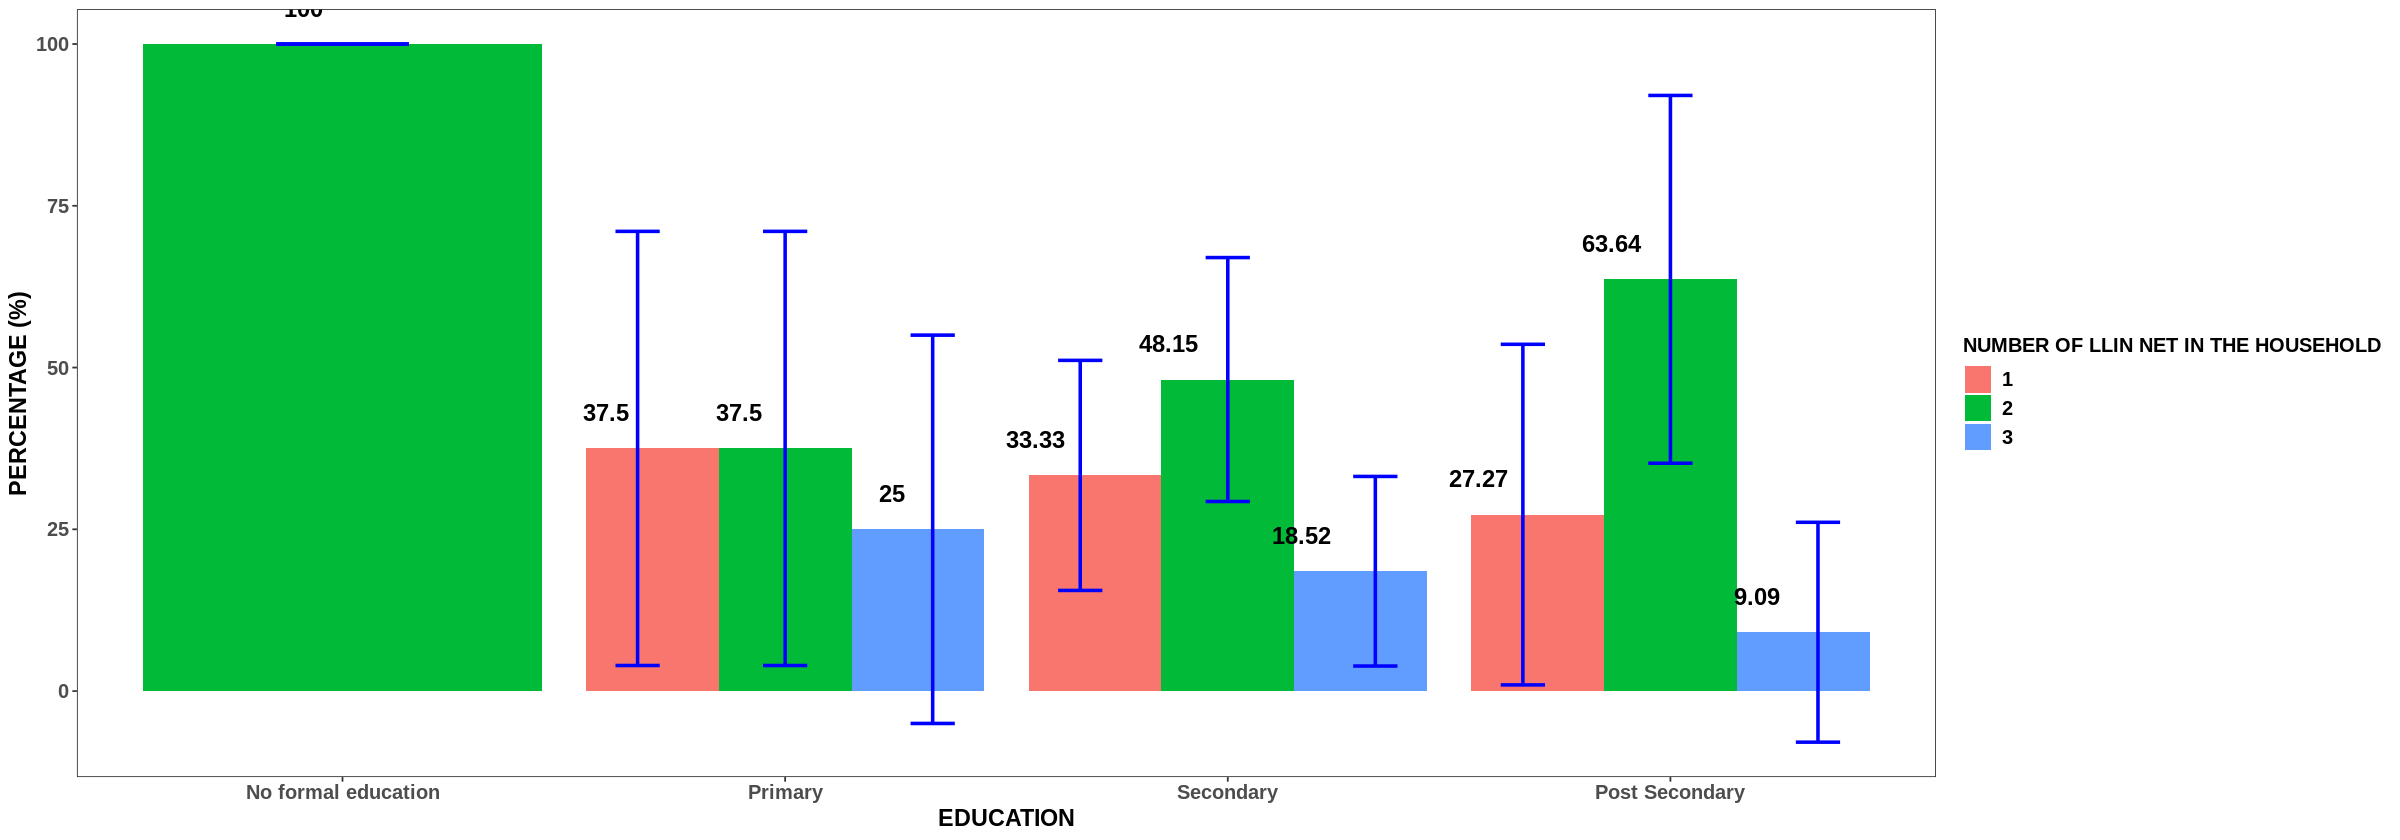



-------------------------------------------


-------------------------------------------
ACCOMODATION

-------------------------------------------


B13                              Freq % Freq    
1 A whole family house             14    26.923077
2 Duplex                            2     3.846154
3 Two/three bedroom flat            6    11.538462
4 Mini flat/self-contain apartment 19    36.538462
5 Room and parlour                 11    21.153846
6 Single room                       0     0.000000
7 Wood & makeshift structure        0     0.000000
8 Total                            52   100.000000

A whole family house Duplex      Two/three bedroom flat
1     5 [ 9.62% ]          1 [ 1.92% ] 1 [ 1.92% ]           
2     5 [ 9.62% ]          1 [ 1.92% ] 4 [ 7.69% ]           
3     4 [ 7.69% ]          0 [ 0% ]    1 [ 1.92% ]           
Total 14 [ 26.92% ]        2 [ 3.85% ] 6 [ 11.54% ]          
      Mini flat/self-contain apartment Room and parlour Single room
1     4 [ 7.69% ]                      4 [ 7.69% ]      0 [ 0% ]   
2     13 [ 25% ]                       6 [ 11.54% ]     0 [ 0% ]   
3     2 [ 3.85% ]                      1 [ 1.92% ]      0 [ 0% ]   
Total 19 [ 36.54% ]                    11 [ 21.15% ]    0 [ 0% ]   
      Wood & makeshift structure Total        
1     0 [ 0% ]                   15 [ 28.85% ]
2     0 [ 0% ]                   29 [ 55.77% ]
3     0 [ 0% ]                   8 [ 15.38% ] 
Total 0 [ 0% ]                   52 [ 100% ]

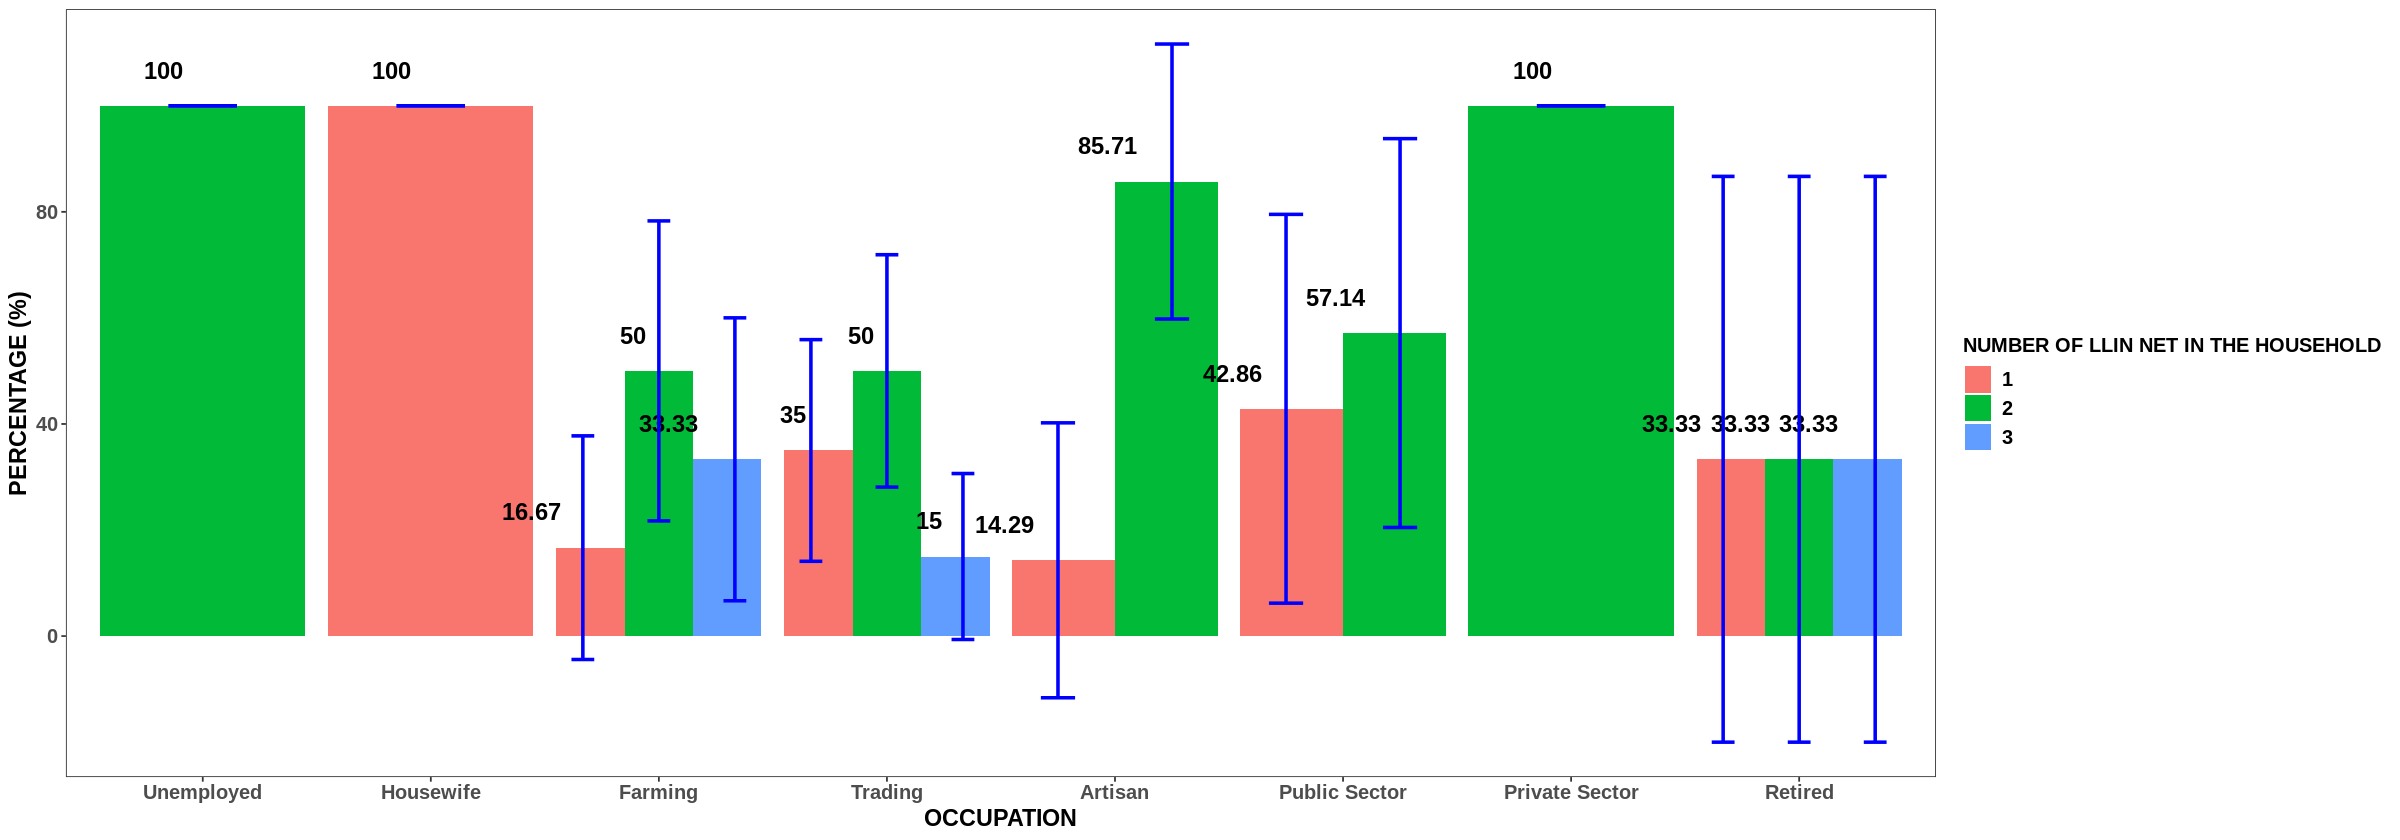



-------------------------------------------


-------------------------------------------
EDUCATION MODIFIED

-------------------------------------------


A5MUT             Freq % Freq   
1 Secondary & Above 38    73.07692
2 Pre Secondary     14    26.92308
3 Total             52   100.00000

Secondary & Above Pre Secondary Total        
1     12 [ 23.08% ]     3 [ 5.77% ]   15 [ 28.85% ]
2     20 [ 38.46% ]     9 [ 17.31% ]  29 [ 55.77% ]
3     6 [ 11.54% ]      2 [ 3.85% ]   8 [ 15.38% ] 
Total 38 [ 73.08% ]     14 [ 26.92% ] 52 [ 100% ]

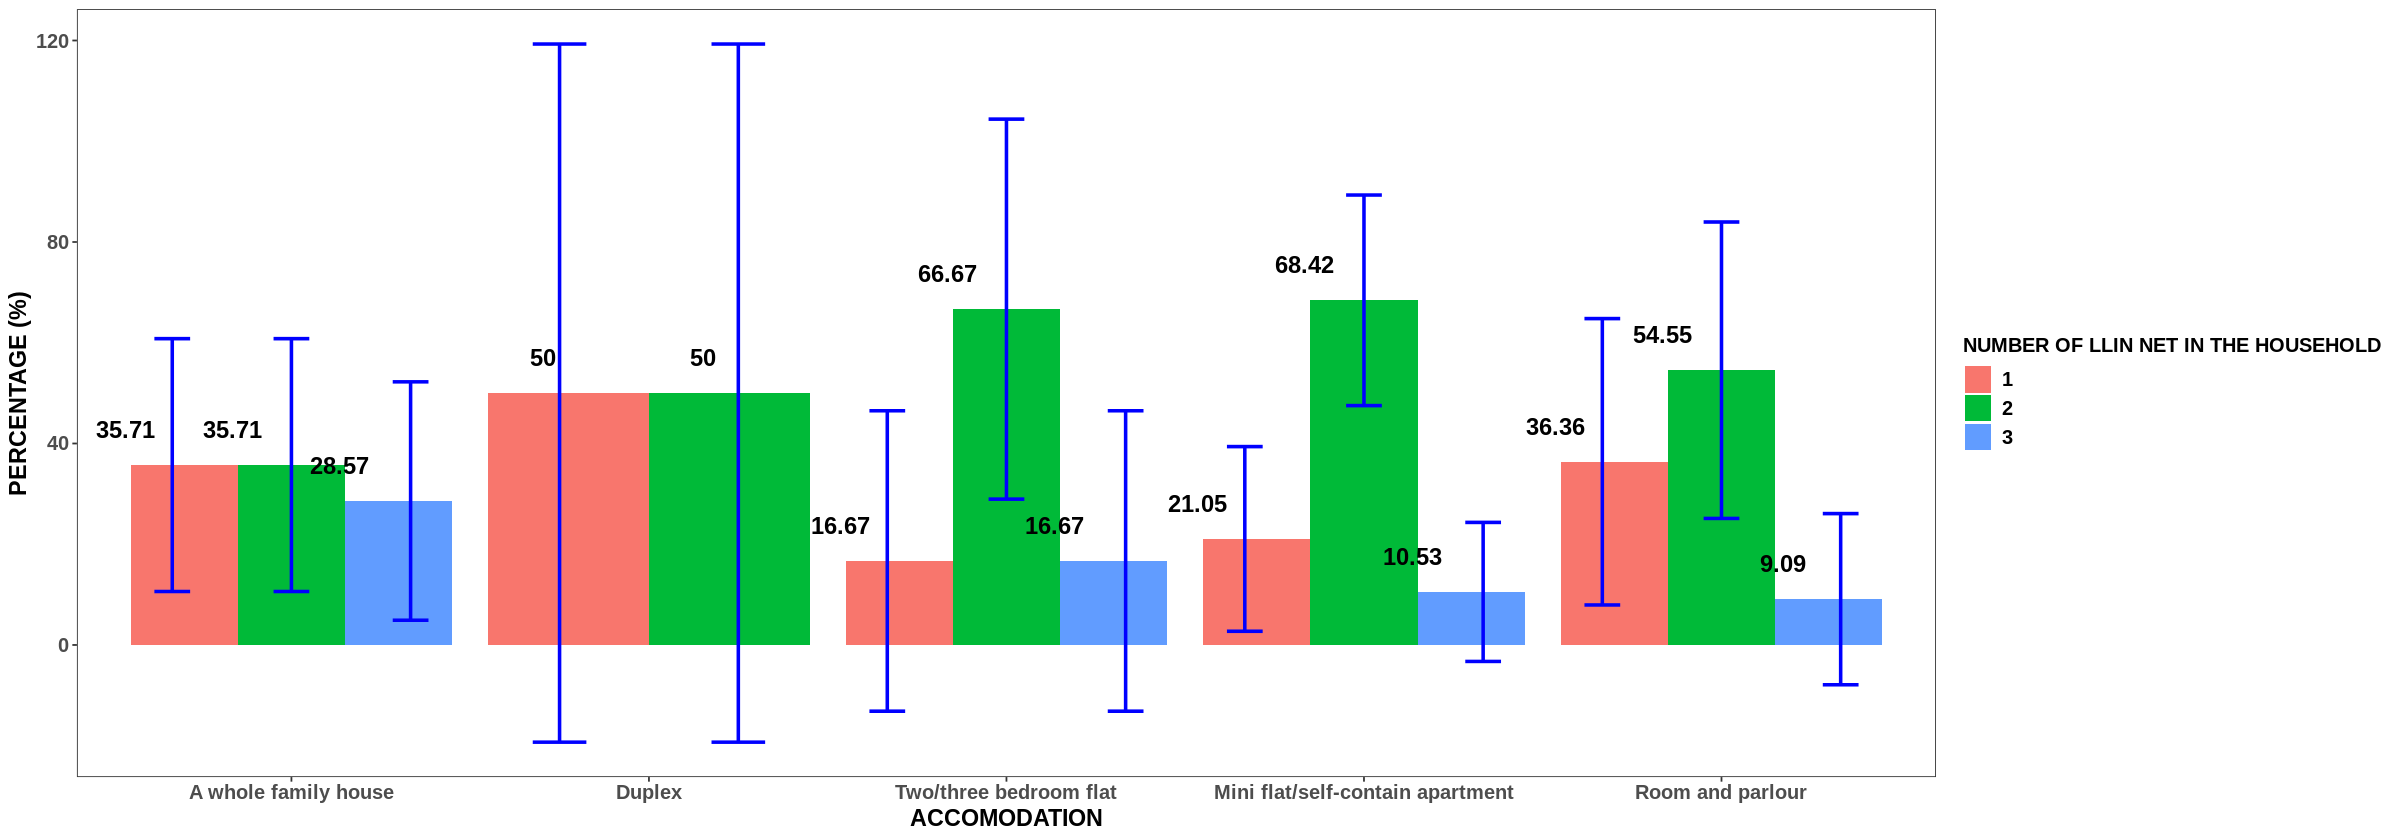



-------------------------------------------


-------------------------------------------
OCCUPATION MODIFIED

-------------------------------------------


A6MUT                  Freq % Freq    
1 Blue Collar            39    75.000000
2 White Collar           11    21.153846
3 Student                 0     0.000000
4 Unemployed & Housewife  2     3.846154
5 Total                  52   100.000000

Blue Collar   White Collar  Student  Unemployed & Housewife Total        
1     10 [ 19.23% ] 4 [ 7.69% ]   0 [ 0% ] 1 [ 1.92% ]            15 [ 28.85% ]
2     22 [ 42.31% ] 6 [ 11.54% ]  0 [ 0% ] 1 [ 1.92% ]            29 [ 55.77% ]
3     7 [ 13.46% ]  1 [ 1.92% ]   0 [ 0% ] 0 [ 0% ]               8 [ 15.38% ] 
Total 39 [ 75% ]    11 [ 21.15% ] 0 [ 0% ] 2 [ 3.85% ]            52 [ 100% ]

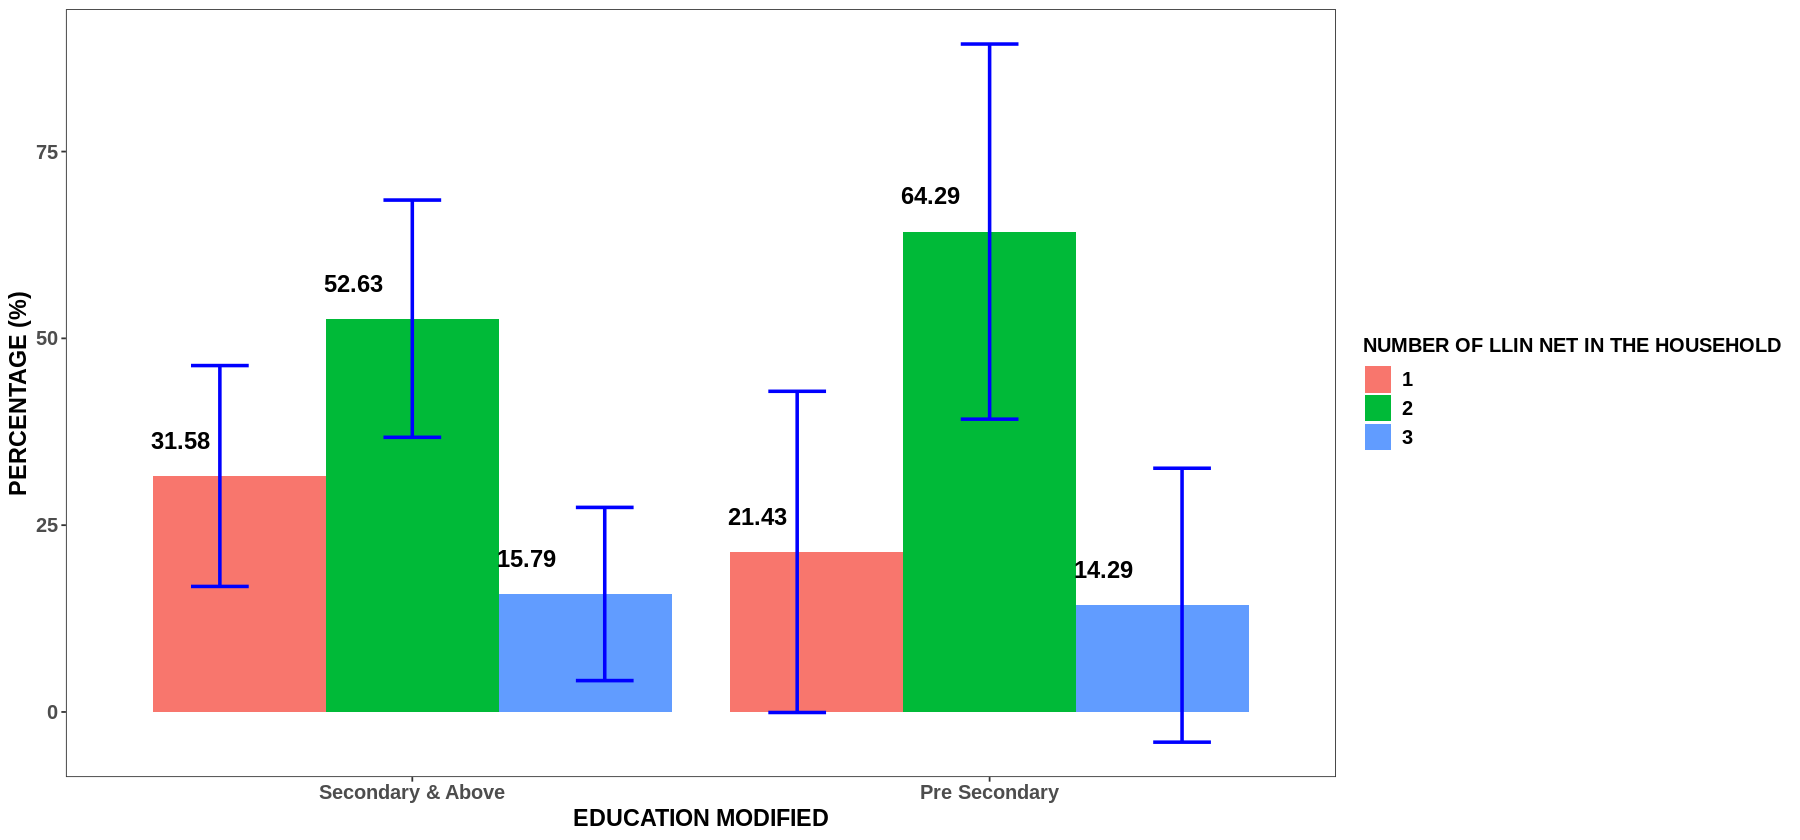



-------------------------------------------


-------------------------------------------
ACCOMODATION MODIFIED

-------------------------------------------


B13MUT       Freq % Freq   
1 Not Spacious 30    57.69231
2 Spacious     22    42.30769
3 Total        52   100.00000

Not Spacious  Spacious      Total        
1     8 [ 15.38% ]  7 [ 13.46% ]  15 [ 28.85% ]
2     19 [ 36.54% ] 10 [ 19.23% ] 29 [ 55.77% ]
3     3 [ 5.77% ]   5 [ 9.62% ]   8 [ 15.38% ] 
Total 30 [ 57.69% ] 22 [ 42.31% ] 52 [ 100% ]

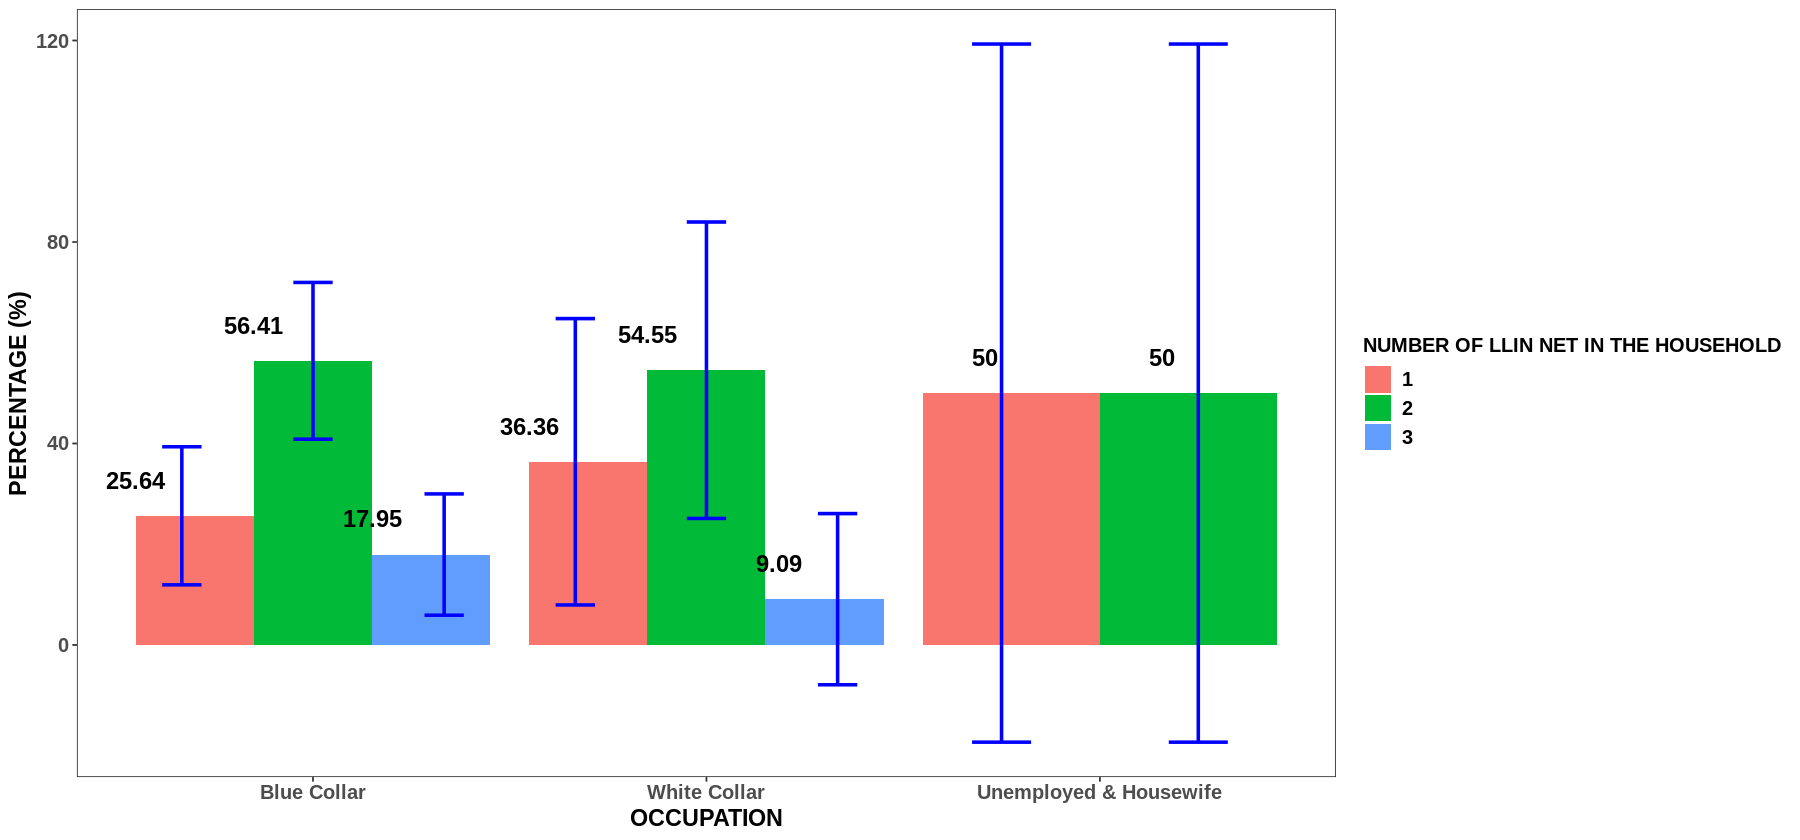

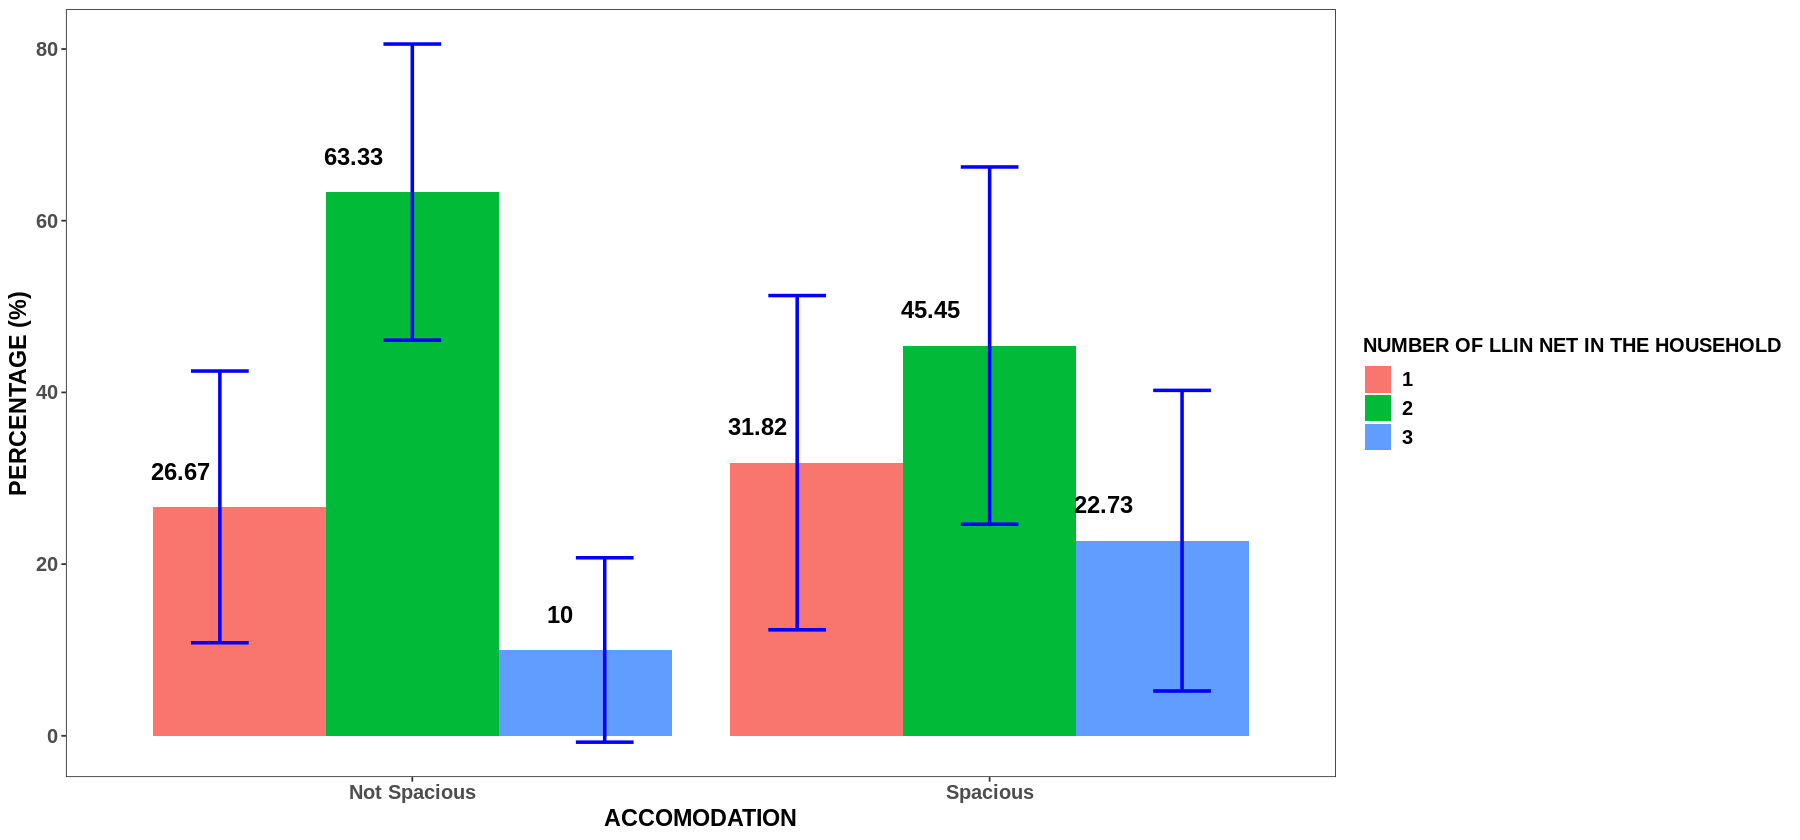

In [ ]:
fig_sizer_fn(12,7)
cat("\n\n-------------------------------------------\n")
cat("\n\n-------------------------------------------\n")

cat("SEX")
cat("\n\n-------------------------------------------\n")
analysis_df = YF_data %>% filter(is.na(D28) == FALSE) %>% filter(is.na(A1) == FALSE)

analysis_df %$% freq(A1)

cat("\n\n\n")

analysis_df %$% ctable_fn(x = D28, y = A1)

cat("\n\n\n")

#============================================================

analysis_CI_cat_df = analysis_df %>% select(D28, A1) %>% group_by(A1, D28) %>%
  summarise(Count = n(), .groups = 'drop') %>% 

  mutate(OverallPercentage = Count/sum(.$Count) ) %>%
  mutate( OverallPercentage = round(OverallPercentage,4) * 100) %>%
  
  group_by(A1) %>% mutate(WithinGroupSum = sum(Count)) %>%
  group_by(D28, .add=TRUE) %>%
  mutate(Percentage = Count/WithinGroupSum , Lower_CI = Percentage - 1.96 * sqrt( Percentage * {1 - Percentage} / WithinGroupSum), Upper_CI = Percentage + 1.96 * sqrt( Percentage * {1 - Percentage} / WithinGroupSum)) %>%
  mutate( Percentage = round(Percentage, 4) * 100, Lower_CI  = round(Lower_CI, 4) * 100, Upper_CI = round(Upper_CI,4) * 100)

ggplot(analysis_CI_cat_df, aes(x = factor(A1), y = Percentage, fill = factor(D28))) +
  geom_bar(position="dodge", stat="identity", width = 0.9) +
   geom_text(aes(label = Percentage), position = position_dodge(0.9), hjust = 1.5, vjust = -1.6, fontface = "bold", size = 5) +
  labs(x = "SEX", y = "PERCENTAGE (%)", fill = "NUMBER OF LLIN NET IN THE HOUSEHOLD") +  
      geom_errorbar(aes(ymin = Lower_CI, ymax = Upper_CI), width = 0.3 , position = position_dodge(width = 1), color = "blue", size = 1)    +
  theme_minimal(base_size = 18)+
  theme_bw() +
  theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank()) +
  theme(legend.text=element_text(size = 12, face = "bold"), legend.title = element_text(size=12 , face = "bold"), axis.text=element_text(size=12, face="bold"),
        axis.title=element_text(size=14, face="bold"), plot.title = element_text(hjust = 0.5, size = 16, face = "bold"))



cat("\n\n-------------------------------------------\n")
cat("\n\n-------------------------------------------\n")

cat("AGE CONTINUOUS")
cat("\n\n-------------------------------------------\n")

analysis_df = YF_data %>% filter(is.na(D28) == FALSE) %>% filter(is.na(A2) == FALSE)

cat(paste0("\n\n Number of missing observation is: ", nrow(YF_data) - nrow(analysis_df), " out of ", nrow(YF_data), "\n"))
#=======================================================================

analysis_df = analysis_df %>% select(c(A2, D28 ))
analysis_df = analysis_df[complete.cases(analysis_df),]

analysis_df$A2 = as.numeric(analysis_df$A2)

cat("\n\n")

#=======================================================================

analysis_CI_cont_df1 = analysis_df %>% group_by(D28) %>%
                       summarise(Count = n(), Mean = mean(A2, na.rm=TRUE), Min = quantile(A2, 0, na.rm=TRUE), Q1 = quantile(A2, 0.25, na.rm=TRUE), 
                       Q2 = quantile(A2, 0.5, na.rm=TRUE),  Q3 = quantile(A2, 0.75, na.rm=TRUE), Max = quantile(A2, 1, na.rm=TRUE),
                       Sd = sd(A2, na.rm=TRUE), .groups = 'drop') %>%
                       mutate( Margin_Error = {Sd/sqrt(Count)} * qt(1-0.05/2, Count - 1)  ) %>% mutate(Mean = round(Mean, 2),  Margin_Error = round(Margin_Error, 2) )
analysis_CI_cont_df1$D28 = as.character(analysis_CI_cont_df1$D28)

analysis_CI_cont_df2 = analysis_df %>%
                       summarise(D28 =  "Total", Count = n(), Mean = mean(A2, na.rm=TRUE), Min = quantile(A2, 0, na.rm=TRUE), Q1 = quantile(A2, 0.25, na.rm=TRUE), 
                       Q2 = quantile(A2, 0.5, na.rm=TRUE),  Q3 = quantile(A2, 0.75, na.rm=TRUE), Max = quantile(A2, 1, na.rm=TRUE),
                       Sd = sd(A2, na.rm=TRUE), .groups = 'drop') %>%
                       mutate( Margin_Error = {Sd/sqrt(Count)} * qt(1-0.05/2, Count - 1)  ) %>% mutate(Mean = round(Mean, 2),  Margin_Error = round(Margin_Error, 2) )

analysis_CI_cont_df = rbind(analysis_CI_cont_df1, analysis_CI_cont_df2)

analysis_CI_cont_df 

#================================================================


ggplot(analysis_CI_cont_df, aes(x = factor(D28), y = Mean , fill = factor(D28))) +
  geom_bar(position="dodge", stat="identity", width = 0.9) +
  labs(x = "AGE CONT (Answers to Number of LLIN Net In Household)", y = "Mean", fill = "NUMBER OF LLIN NET IN THE HOUSEHOLD") +  
       geom_text(aes(label = Mean), position = position_dodge(0.9), hjust = 1.5, vjust = -1.6, fontface = "bold", size = 5) +
      geom_errorbar(aes(ymin = Mean  - Margin_Error, ymax = Mean + Margin_Error), width = 0.5, position = position_dodge(width = 0.5), color="blue", size=1)    +
  theme_minimal(base_size = 18)+
  theme_bw() +
  theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank()) +
  theme(legend.text=element_text(size = 12, face = "bold"), legend.title = element_text(size=12 , face = "bold"), axis.text=element_text(size=12, face="bold"),
        axis.title=element_text(size=14, face="bold"), plot.title = element_text(hjust = 0.5, size = 16, face = "bold"))






cat("\n\n-------------------------------------------\n")
cat("\n\n-------------------------------------------\n")

cat("AGE CATEGORICAL")
cat("\n\n-------------------------------------------\n")

analysis_df = YF_data %>% filter(is.na(D28) == FALSE) %>% filter(is.na(AGECAT) == FALSE)

analysis_df %$% freq(AGECAT)

cat("\n\n\n")

analysis_df %$% ctable_fn(x = D28, y = AGECAT)


#============================================================

analysis_CI_cat_df = analysis_df %>% select(D28, AGECAT) %>% group_by(AGECAT, D28) %>%
  summarise(Count = n(), .groups = 'drop') %>% 

  mutate(OverallPercentage = Count/sum(.$Count) ) %>%
  mutate( OverallPercentage = round(OverallPercentage,4) * 100) %>%
  
  group_by(AGECAT) %>% mutate(WithinGroupSum = sum(Count)) %>%
  group_by(D28, .add=TRUE) %>%
  mutate(Percentage = Count/WithinGroupSum , Lower_CI = Percentage - 1.96 * sqrt( Percentage * {1 - Percentage} / WithinGroupSum), Upper_CI = Percentage + 1.96 * sqrt( Percentage * {1 - Percentage} / WithinGroupSum)) %>%
  mutate( Percentage = round(Percentage, 4) * 100, Lower_CI  = round(Lower_CI, 4) * 100, Upper_CI = round(Upper_CI,4) * 100)
fig_sizer_fn(15, 7)
ggplot(analysis_CI_cat_df, aes(x = factor(AGECAT), y = Percentage, fill = factor(D28))) +
  geom_bar(position="dodge", stat="identity", width = 0.9) +
   geom_text(aes(label = Percentage), position = position_dodge(0.9), hjust = 1.5, vjust = -1.6, fontface = "bold", size = 5) +
  labs(x = "AGE CATEGORICAL", y = "PERCENTAGE (%)", fill = "NUMBER OF LLIN NET IN THE HOUSEHOLD") +  
      geom_errorbar(aes(ymin = Lower_CI, ymax = Upper_CI), width = 0.3 , position = position_dodge(width = 1), color = "blue", size = 1)    +
  theme_minimal(base_size = 18)+
  theme_bw() +
  theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank()) +
  theme(legend.text=element_text(size = 12, face = "bold"), legend.title = element_text(size=12 , face = "bold"), axis.text=element_text(size=12, face="bold"),
        axis.title=element_text(size=14, face="bold"), plot.title = element_text(hjust = 0.5, size = 16, face = "bold"))



cat("\n\n-------------------------------------------\n")
cat("\n\n-------------------------------------------\n")

cat("EDUCATION")
cat("\n\n-------------------------------------------\n")

analysis_df = YF_data %>% filter(is.na(D28) == FALSE) %>% filter(is.na(A5) == FALSE)

analysis_df %$% freq(A5)

cat("\n\n\n")

analysis_df %$% ctable_fn(x = D28, y = A5)


#============================================================

analysis_CI_cat_df = analysis_df %>% select(D28, A5) %>% group_by(A5, D28) %>%
  summarise(Count = n(), .groups = 'drop') %>% 

  mutate(OverallPercentage = Count/sum(.$Count) ) %>%
  mutate( OverallPercentage = round(OverallPercentage,4) * 100) %>%
  
  group_by(A5) %>% mutate(WithinGroupSum = sum(Count)) %>%
  group_by(D28, .add=TRUE) %>%
  mutate(Percentage = Count/WithinGroupSum , Lower_CI = Percentage - 1.96 * sqrt( Percentage * {1 - Percentage} / WithinGroupSum), Upper_CI = Percentage + 1.96 * sqrt( Percentage * {1 - Percentage} / WithinGroupSum)) %>%
  mutate( Percentage = round(Percentage, 4) * 100, Lower_CI  = round(Lower_CI, 4) * 100, Upper_CI = round(Upper_CI,4) * 100)

fig_sizer_fn(20, 7)

ggplot(analysis_CI_cat_df, aes(x = factor(A5), y = Percentage, fill = factor(D28))) +
  geom_bar(position="dodge", stat="identity", width = 0.9) +
   geom_text(aes(label = Percentage), position = position_dodge(0.9), hjust = 1.5, vjust = -1.6, fontface = "bold", size = 5) +
  labs(x = "EDUCATION", y = "PERCENTAGE (%)", fill = "NUMBER OF LLIN NET IN THE HOUSEHOLD") +  
      geom_errorbar(aes(ymin = Lower_CI, ymax = Upper_CI), width = 0.3 , position = position_dodge(width = 1), color = "blue", size = 1)    +
  theme_minimal(base_size = 18)+
  theme_bw() +
  theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank()) +
  theme(legend.text=element_text(size = 12, face = "bold"), legend.title = element_text(size=12 , face = "bold"), axis.text=element_text(size=12, face="bold"),
        axis.title=element_text(size=14, face="bold"), plot.title = element_text(hjust = 0.5, size = 16, face = "bold"))



cat("\n\n-------------------------------------------\n")
cat("\n\n-------------------------------------------\n")

cat("OCCUPATION")
cat("\n\n-------------------------------------------\n")

analysis_df = YF_data %>% filter(is.na(D28) == FALSE) %>% filter(is.na(A6) == FALSE)

analysis_df %$% freq(A6)

cat("\n\n\n")

analysis_df %$% ctable_fn(x = D28, y = A6)


#============================================================

analysis_CI_cat_df = analysis_df %>% select(D28, A6) %>% group_by(A6, D28) %>%
  summarise(Count = n(), .groups = 'drop') %>% 

  mutate(OverallPercentage = Count/sum(.$Count) ) %>%
  mutate( OverallPercentage = round(OverallPercentage,4) * 100) %>%
  
  group_by(A6) %>% mutate(WithinGroupSum = sum(Count)) %>%
  group_by(D28, .add=TRUE) %>%
  mutate(Percentage = Count/WithinGroupSum , Lower_CI = Percentage - 1.96 * sqrt( Percentage * {1 - Percentage} / WithinGroupSum), Upper_CI = Percentage + 1.96 * sqrt( Percentage * {1 - Percentage} / WithinGroupSum)) %>%
  mutate( Percentage = round(Percentage, 4) * 100, Lower_CI  = round(Lower_CI, 4) * 100, Upper_CI = round(Upper_CI,4) * 100)

fig_sizer_fn(20, 7)

ggplot(analysis_CI_cat_df, aes(x = factor(A6), y = Percentage, fill = factor(D28))) +
  geom_bar(position="dodge", stat="identity", width = 0.9) +
   geom_text(aes(label = Percentage), position = position_dodge(0.9), hjust = 1.5, vjust = -1.6, fontface = "bold", size = 5) +
  labs(x = "OCCUPATION", y = "PERCENTAGE (%)", fill = "NUMBER OF LLIN NET IN THE HOUSEHOLD") +  
      geom_errorbar(aes(ymin = Lower_CI, ymax = Upper_CI), width = 0.3 , position = position_dodge(width = 1), color = "blue", size = 1)    +
  theme_minimal(base_size = 18)+
  theme_bw() +
  theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank()) +
  theme(legend.text=element_text(size = 12, face = "bold"), legend.title = element_text(size=12 , face = "bold"), axis.text=element_text(size=12, face="bold"),
        axis.title=element_text(size=14, face="bold"), plot.title = element_text(hjust = 0.5, size = 16, face = "bold"))




cat("\n\n-------------------------------------------\n")
cat("\n\n-------------------------------------------\n")

cat("ACCOMODATION")
cat("\n\n-------------------------------------------\n")

analysis_df = YF_data %>% filter(is.na(D28) == FALSE) %>% filter(is.na(B13) == FALSE)

analysis_df %$% freq(B13)

cat("\n\n\n")

analysis_df %$% ctable_fn(x = D28, y = B13)


#============================================================

analysis_CI_cat_df = analysis_df %>% select(D28, B13) %>% group_by(B13, D28) %>%
  summarise(Count = n(), .groups = 'drop') %>% 

  mutate(OverallPercentage = Count/sum(.$Count) ) %>%
  mutate( OverallPercentage = round(OverallPercentage,4) * 100) %>%
  
  group_by(B13) %>% mutate(WithinGroupSum = sum(Count)) %>%
  group_by(D28, .add=TRUE) %>%
  mutate(Percentage = Count/WithinGroupSum , Lower_CI = Percentage - 1.96 * sqrt( Percentage * {1 - Percentage} / WithinGroupSum), Upper_CI = Percentage + 1.96 * sqrt( Percentage * {1 - Percentage} / WithinGroupSum)) %>%
  mutate( Percentage = round(Percentage, 4) * 100, Lower_CI  = round(Lower_CI, 4) * 100, Upper_CI = round(Upper_CI,4) * 100)

fig_sizer_fn(20, 7)

ggplot(analysis_CI_cat_df, aes(x = factor(B13), y = Percentage, fill = factor(D28))) +
  geom_bar(position="dodge", stat="identity", width = 0.9) +
   geom_text(aes(label = Percentage), position = position_dodge(0.9), hjust = 1.5, vjust = -1.6, fontface = "bold", size = 5) +
  labs(x = "ACCOMODATION", y = "PERCENTAGE (%)", fill = "NUMBER OF LLIN NET IN THE HOUSEHOLD") +  
      geom_errorbar(aes(ymin = Lower_CI, ymax = Upper_CI), width = 0.3 , position = position_dodge(width = 1), color = "blue", size = 1)    +
  theme_minimal(base_size = 18)+
  theme_bw() +
  theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank()) +
  theme(legend.text=element_text(size = 12, face = "bold"), legend.title = element_text(size=12 , face = "bold"), axis.text=element_text(size=12, face="bold"),
        axis.title=element_text(size=14, face="bold"), plot.title = element_text(hjust = 0.5, size = 16, face = "bold"))



#====================================================================================================================
#====================================================================================================================
#====================================================================================================================
#====================================================================================================================


fig_sizer_fn()

cat("\n\n-------------------------------------------\n")
cat("\n\n-------------------------------------------\n")

cat("EDUCATION MODIFIED")
cat("\n\n-------------------------------------------\n")

analysis_df = YF_data %>% filter(is.na(D28) == FALSE) %>% filter(is.na(A5MUT) == FALSE)

analysis_df %$% freq(A5MUT)

cat("\n\n\n")

analysis_df %$% ctable_fn(x = D28, y = A5MUT)


#============================================================

analysis_CI_cat_df = analysis_df %>% select(D28, A5MUT) %>% group_by(A5MUT, D28) %>%
  summarise(Count = n(), .groups = 'drop') %>% 

  mutate(OverallPercentage = Count/sum(.$Count) ) %>%
  mutate( OverallPercentage = round(OverallPercentage,4) * 100) %>%
  
  group_by(A5MUT) %>% mutate(WithinGroupSum = sum(Count)) %>%
  group_by(D28, .add=TRUE) %>%
  mutate(Percentage = Count/WithinGroupSum , Lower_CI = Percentage - 1.96 * sqrt( Percentage * {1 - Percentage} / WithinGroupSum), Upper_CI = Percentage + 1.96 * sqrt( Percentage * {1 - Percentage} / WithinGroupSum)) %>%
  mutate( Percentage = round(Percentage, 4) * 100, Lower_CI  = round(Lower_CI, 4) * 100, Upper_CI = round(Upper_CI,4) * 100)

fig_sizer_fn(15, 7)

ggplot(analysis_CI_cat_df, aes(x = factor(A5MUT), y = Percentage, fill = factor(D28))) +
  geom_bar(position="dodge", stat="identity", width = 0.9) +
   geom_text(aes(label = Percentage), position = position_dodge(0.9), hjust = 1.5, vjust = -1.6, fontface = "bold", size = 5) +
  labs(x = "EDUCATION MODIFIED", y = "PERCENTAGE (%)", fill = "NUMBER OF LLIN NET IN THE HOUSEHOLD") +  
      geom_errorbar(aes(ymin = Lower_CI, ymax = Upper_CI), width = 0.3 , position = position_dodge(width = 1), color = "blue", size = 1)    +
  theme_minimal(base_size = 18)+
  theme_bw() +
  theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank()) +
  theme(legend.text=element_text(size = 12, face = "bold"), legend.title = element_text(size=12 , face = "bold"), axis.text=element_text(size=12, face="bold"),
        axis.title=element_text(size=14, face="bold"), plot.title = element_text(hjust = 0.5, size = 16, face = "bold"))



cat("\n\n-------------------------------------------\n")
cat("\n\n-------------------------------------------\n")

cat("OCCUPATION MODIFIED")
cat("\n\n-------------------------------------------\n")

analysis_df = YF_data %>% filter(is.na(D28) == FALSE) %>% filter(is.na(A6MUT) == FALSE)

analysis_df %$% freq(A6MUT)

cat("\n\n\n")

analysis_df %$% ctable_fn(x = D28, y = A6MUT)


#============================================================

analysis_CI_cat_df = analysis_df %>% select(D28, A6MUT) %>% group_by(A6MUT, D28) %>%
  summarise(Count = n(), .groups = 'drop') %>% 

  mutate(OverallPercentage = Count/sum(.$Count) ) %>%
  mutate( OverallPercentage = round(OverallPercentage,4) * 100) %>%
  
  group_by(A6MUT) %>% mutate(WithinGroupSum = sum(Count)) %>%
  group_by(D28, .add=TRUE) %>%
  mutate(Percentage = Count/WithinGroupSum , Lower_CI = Percentage - 1.96 * sqrt( Percentage * {1 - Percentage} / WithinGroupSum), Upper_CI = Percentage + 1.96 * sqrt( Percentage * {1 - Percentage} / WithinGroupSum)) %>%
  mutate( Percentage = round(Percentage, 4) * 100, Lower_CI  = round(Lower_CI, 4) * 100, Upper_CI = round(Upper_CI,4) * 100)

fig_sizer_fn(15, 7)

ggplot(analysis_CI_cat_df, aes(x = factor(A6MUT), y = Percentage, fill = factor(D28))) +
  geom_bar(position="dodge", stat="identity", width = 0.9) +
   geom_text(aes(label = Percentage), position = position_dodge(0.9), hjust = 1.5, vjust = -1.6, fontface = "bold", size = 5) +
  labs(x = "OCCUPATION", y = "PERCENTAGE (%)", fill = "NUMBER OF LLIN NET IN THE HOUSEHOLD") +  
      geom_errorbar(aes(ymin = Lower_CI, ymax = Upper_CI), width = 0.3 , position = position_dodge(width = 1), color = "blue", size = 1)    +
  theme_minimal(base_size = 18)+
  theme_bw() +
  theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank()) +
  theme(legend.text=element_text(size = 12, face = "bold"), legend.title = element_text(size=12 , face = "bold"), axis.text=element_text(size=12, face="bold"),
        axis.title=element_text(size=14, face="bold"), plot.title = element_text(hjust = 0.5, size = 16, face = "bold"))




cat("\n\n-------------------------------------------\n")
cat("\n\n-------------------------------------------\n")

cat("ACCOMODATION MODIFIED")
cat("\n\n-------------------------------------------\n")

analysis_df = YF_data %>% filter(is.na(D28) == FALSE) %>% filter(is.na(B13MUT) == FALSE)

analysis_df %$% freq(B13MUT)

cat("\n\n\n")

analysis_df %$% ctable_fn(x = D28, y = B13MUT)


#============================================================

analysis_CI_cat_df = analysis_df %>% select(D28, B13MUT) %>% group_by(B13MUT, D28) %>%
  summarise(Count = n(), .groups = 'drop') %>% 

  mutate(OverallPercentage = Count/sum(.$Count) ) %>%
  mutate( OverallPercentage = round(OverallPercentage,4) * 100) %>%
  
  group_by(B13MUT) %>% mutate(WithinGroupSum = sum(Count)) %>%
  group_by(D28, .add=TRUE) %>%
  mutate(Percentage = Count/WithinGroupSum , Lower_CI = Percentage - 1.96 * sqrt( Percentage * {1 - Percentage} / WithinGroupSum), Upper_CI = Percentage + 1.96 * sqrt( Percentage * {1 - Percentage} / WithinGroupSum)) %>%
  mutate( Percentage = round(Percentage, 4) * 100, Lower_CI  = round(Lower_CI, 4) * 100, Upper_CI = round(Upper_CI,4) * 100)

fig_sizer_fn(15, 7)

ggplot(analysis_CI_cat_df, aes(x = factor(B13MUT), y = Percentage, fill = factor(D28))) +
  geom_bar(position="dodge", stat="identity", width = 0.9) +
   geom_text(aes(label = Percentage), position = position_dodge(0.9), hjust = 1.5, vjust = -1.6, fontface = "bold", size = 5) +
  labs(x = "ACCOMODATION", y = "PERCENTAGE (%)", fill = "NUMBER OF LLIN NET IN THE HOUSEHOLD") +  
      geom_errorbar(aes(ymin = Lower_CI, ymax = Upper_CI), width = 0.3 , position = position_dodge(width = 1), color = "blue", size = 1)    +
  theme_minimal(base_size = 18)+
  theme_bw() +
  theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank()) +
  theme(legend.text=element_text(size = 12, face = "bold"), legend.title = element_text(size=12 , face = "bold"), axis.text=element_text(size=12, face="bold"),
        axis.title=element_text(size=14, face="bold"), plot.title = element_text(hjust = 0.5, size = 16, face = "bold"))





-------------------------------------------


-------------------------------------------
SEX

-------------------------------------------


A1     Freq % Freq   
1 Male    42   41.58416
2 Female  59   58.41584
3 Total  101  100.00000

Male          Female        Total        
0     31 [ 30.69% ] 43 [ 42.57% ] 74 [ 73.27% ]
1     11 [ 10.89% ] 11 [ 10.89% ] 22 [ 21.78% ]
2     0 [ 0% ]      5 [ 4.95% ]   5 [ 4.95% ]  
Total 42 [ 41.58% ] 59 [ 58.42% ] 101 [ 100% ]






-------------------------------------------


-------------------------------------------
AGE CONTINUOUS

-------------------------------------------


 Number of missing observation is: 0 out of 101




D35   Count Mean  Min Q1    Q2   Q3    Max Sd        Margin_Error
1 0      74   25.62  1  14.00 28.0 36.00 48  13.373151 3.10        
2 1      22   18.05  2  12.25 19.5 22.75 34   8.363625 3.71        
3 2       5   24.00 17  20.00 23.0 29.00 31   5.916080 7.35        
4 Total 101   23.89  1  14.00 25.0 33.00 48  12.505120 2.47

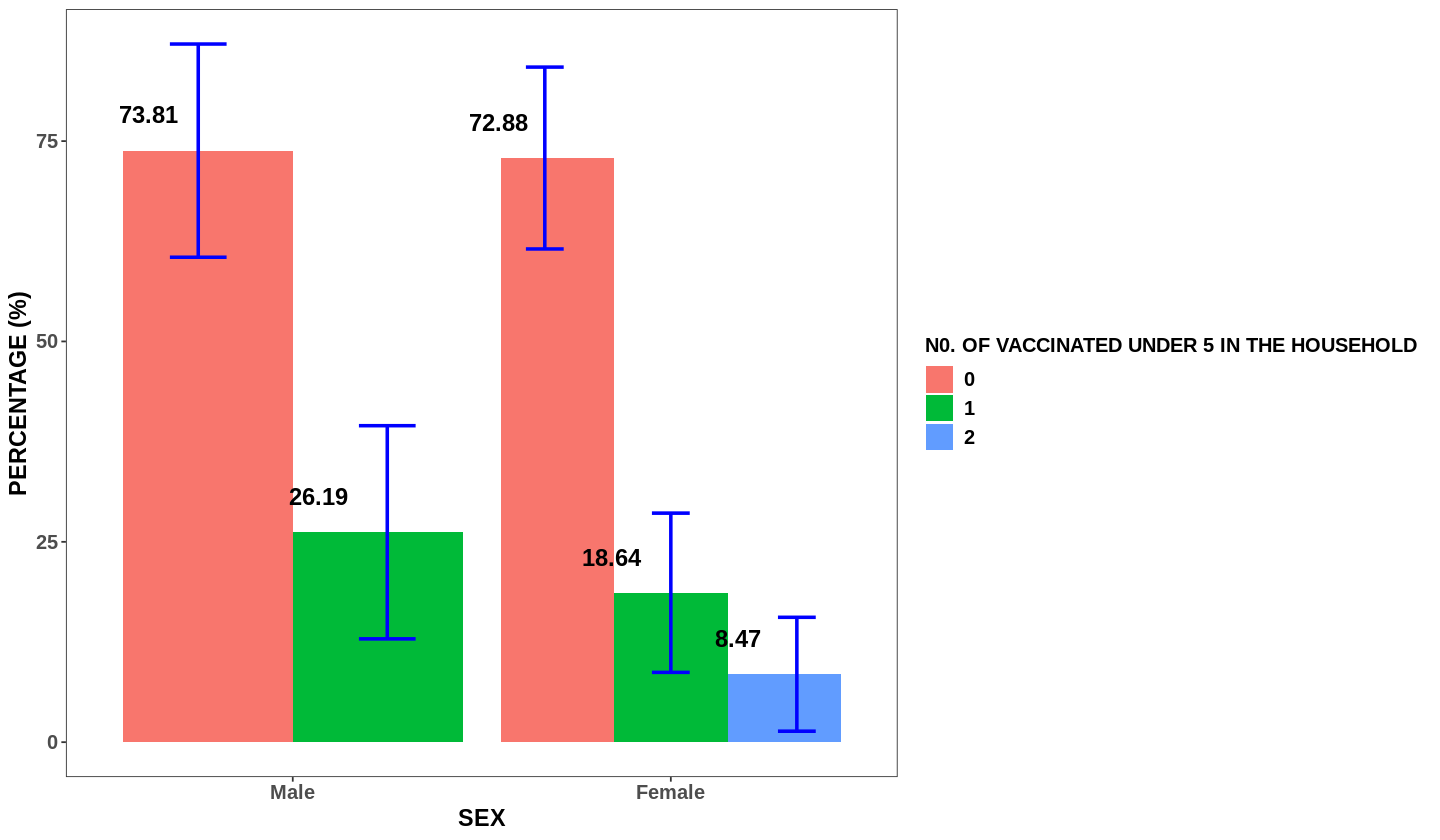



-------------------------------------------


-------------------------------------------
AGE CATEGORICAL

-------------------------------------------


AGECAT     Freq % Freq   
1 18 to 35    31   30.69307
2 35 to 60    57   56.43564
3 60 & above  13   12.87129
4 Total      101  100.00000

18 to 35      35 to 60      60 & above    Total        
0     22 [ 21.78% ] 39 [ 38.61% ] 13 [ 12.87% ] 74 [ 73.27% ]
1     9 [ 8.91% ]   13 [ 12.87% ] 0 [ 0% ]      22 [ 21.78% ]
2     0 [ 0% ]      5 [ 4.95% ]   0 [ 0% ]      5 [ 4.95% ]  
Total 31 [ 30.69% ] 57 [ 56.44% ] 13 [ 12.87% ] 101 [ 100% ]

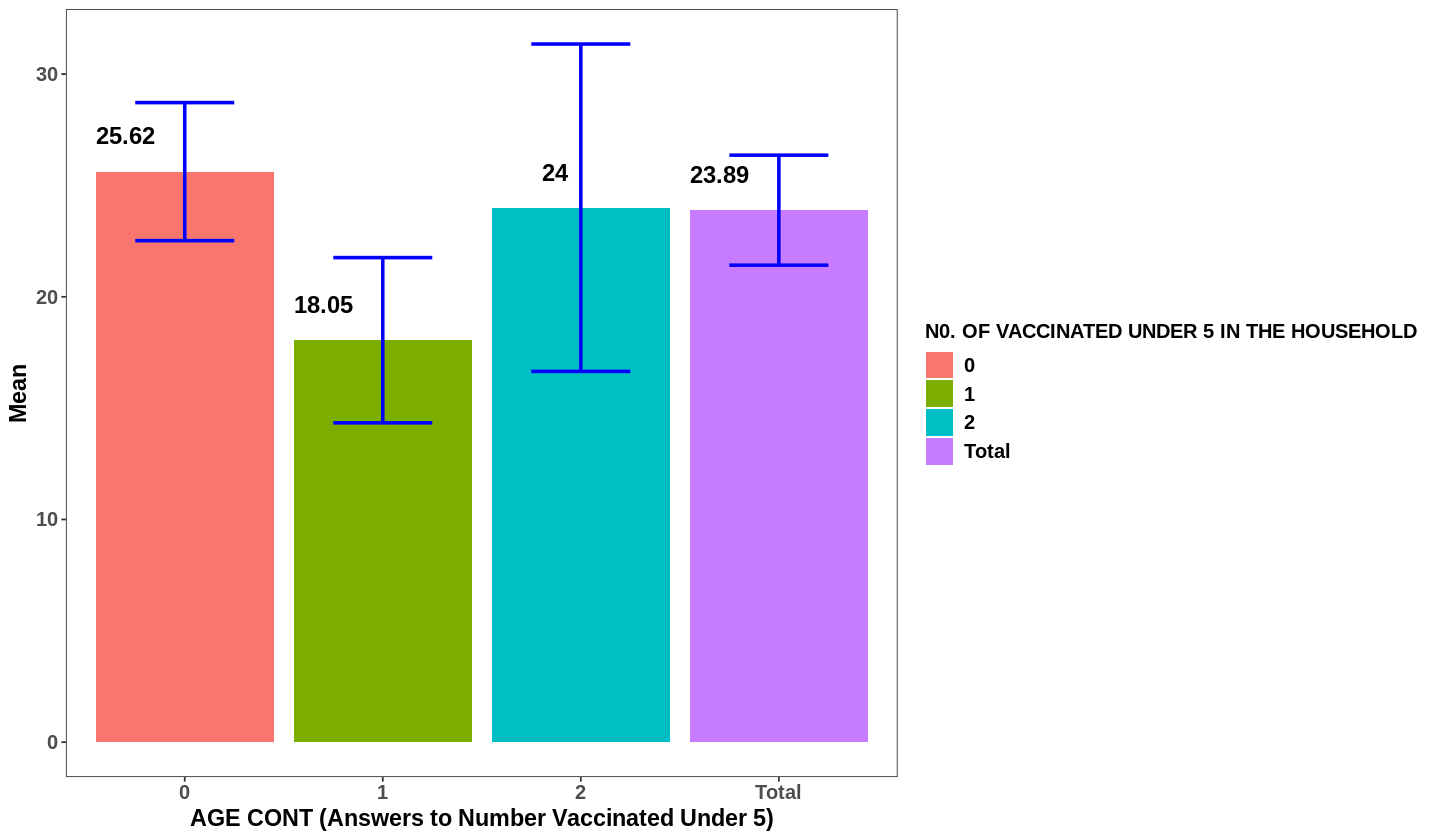



-------------------------------------------


-------------------------------------------
EDUCATION

-------------------------------------------


A5                  Freq % Freq    
1 No formal education   9    8.910891
2 Primary              15   14.851485
3 Secondary            57   56.435644
4 Post Secondary       20   19.801980
5 Total               101  100.000000

No formal education Primary       Secondary     Post Secondary
0     9 [ 8.91% ]         13 [ 12.87% ] 39 [ 38.61% ] 13 [ 12.87% ] 
1     0 [ 0% ]            1 [ 0.99% ]   15 [ 14.85% ] 6 [ 5.94% ]   
2     0 [ 0% ]            1 [ 0.99% ]   3 [ 2.97% ]   1 [ 0.99% ]   
Total 9 [ 8.91% ]         15 [ 14.85% ] 57 [ 56.44% ] 20 [ 19.8% ]  
      Total        
0     74 [ 73.27% ]
1     22 [ 21.78% ]
2     5 [ 4.95% ]  
Total 101 [ 100% ]

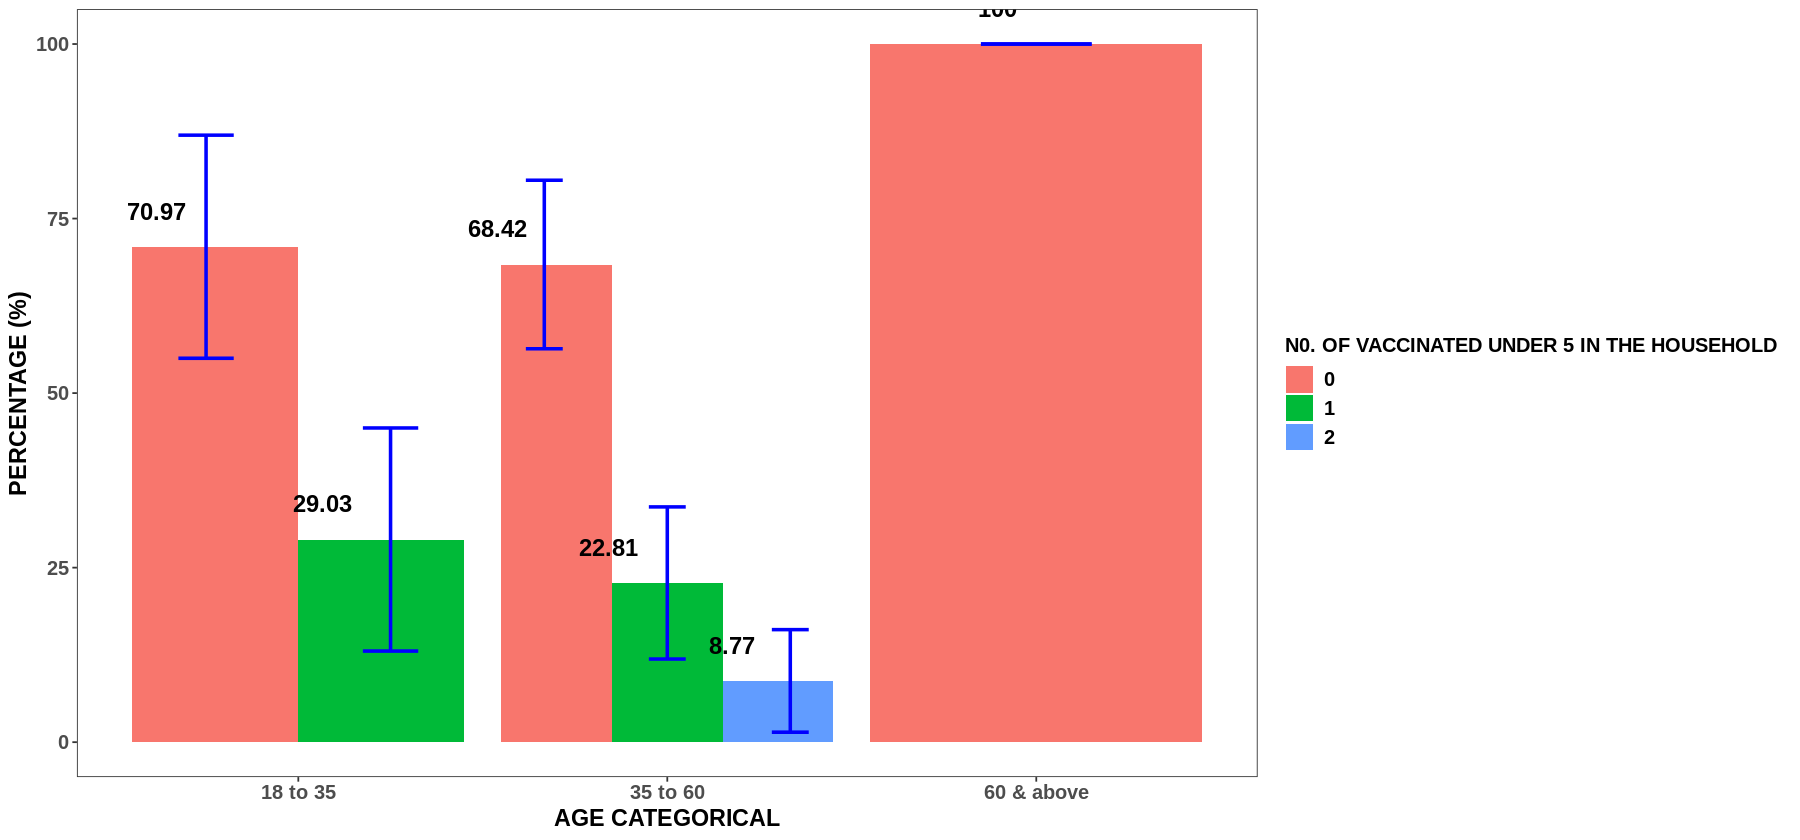



-------------------------------------------


-------------------------------------------
OCCUPATION

-------------------------------------------


A6             Freq % Freq    
1  Unemployed       4    3.960396
2  Housewife        1    0.990099
3  Farming         18   17.821782
4  Trading         36   35.643564
5  Artisan         16   15.841584
6  Public Sector   12   11.881188
7  Private Sector   2    1.980198
8  Retired          4    3.960396
9  Student          8    7.920792
10 Total          101  100.000000

Unemployed  Housewife   Farming       Trading       Artisan      
0     4 [ 3.96% ] 1 [ 0.99% ] 14 [ 13.86% ] 26 [ 25.74% ] 14 [ 13.86% ]
1     0 [ 0% ]    0 [ 0% ]    2 [ 1.98% ]   9 [ 8.91% ]   1 [ 0.99% ]  
2     0 [ 0% ]    0 [ 0% ]    2 [ 1.98% ]   1 [ 0.99% ]   1 [ 0.99% ]  
Total 4 [ 3.96% ] 1 [ 0.99% ] 18 [ 17.82% ] 36 [ 35.64% ] 16 [ 15.84% ]
      Public Sector Private Sector Retired     Student     Total        
0     5 [ 4.95% ]   0 [ 0% ]       4 [ 3.96% ] 6 [ 5.94% ] 74 [ 73.27% ]
1     6 [ 5.94% ]   2 [ 1.98% ]    0 [ 0% ]    2 [ 1.98% ] 22 [ 21.78% ]
2     1 [ 0.99% ]   0 [ 0% ]       0 [ 0% ]    0 [ 0% ]    5 [ 4.95% ]  
Total 12 [ 11.88% ] 2 [ 1.98% ]    4 [ 3.96% ] 8 [ 7.92% ] 101 [ 100% ]

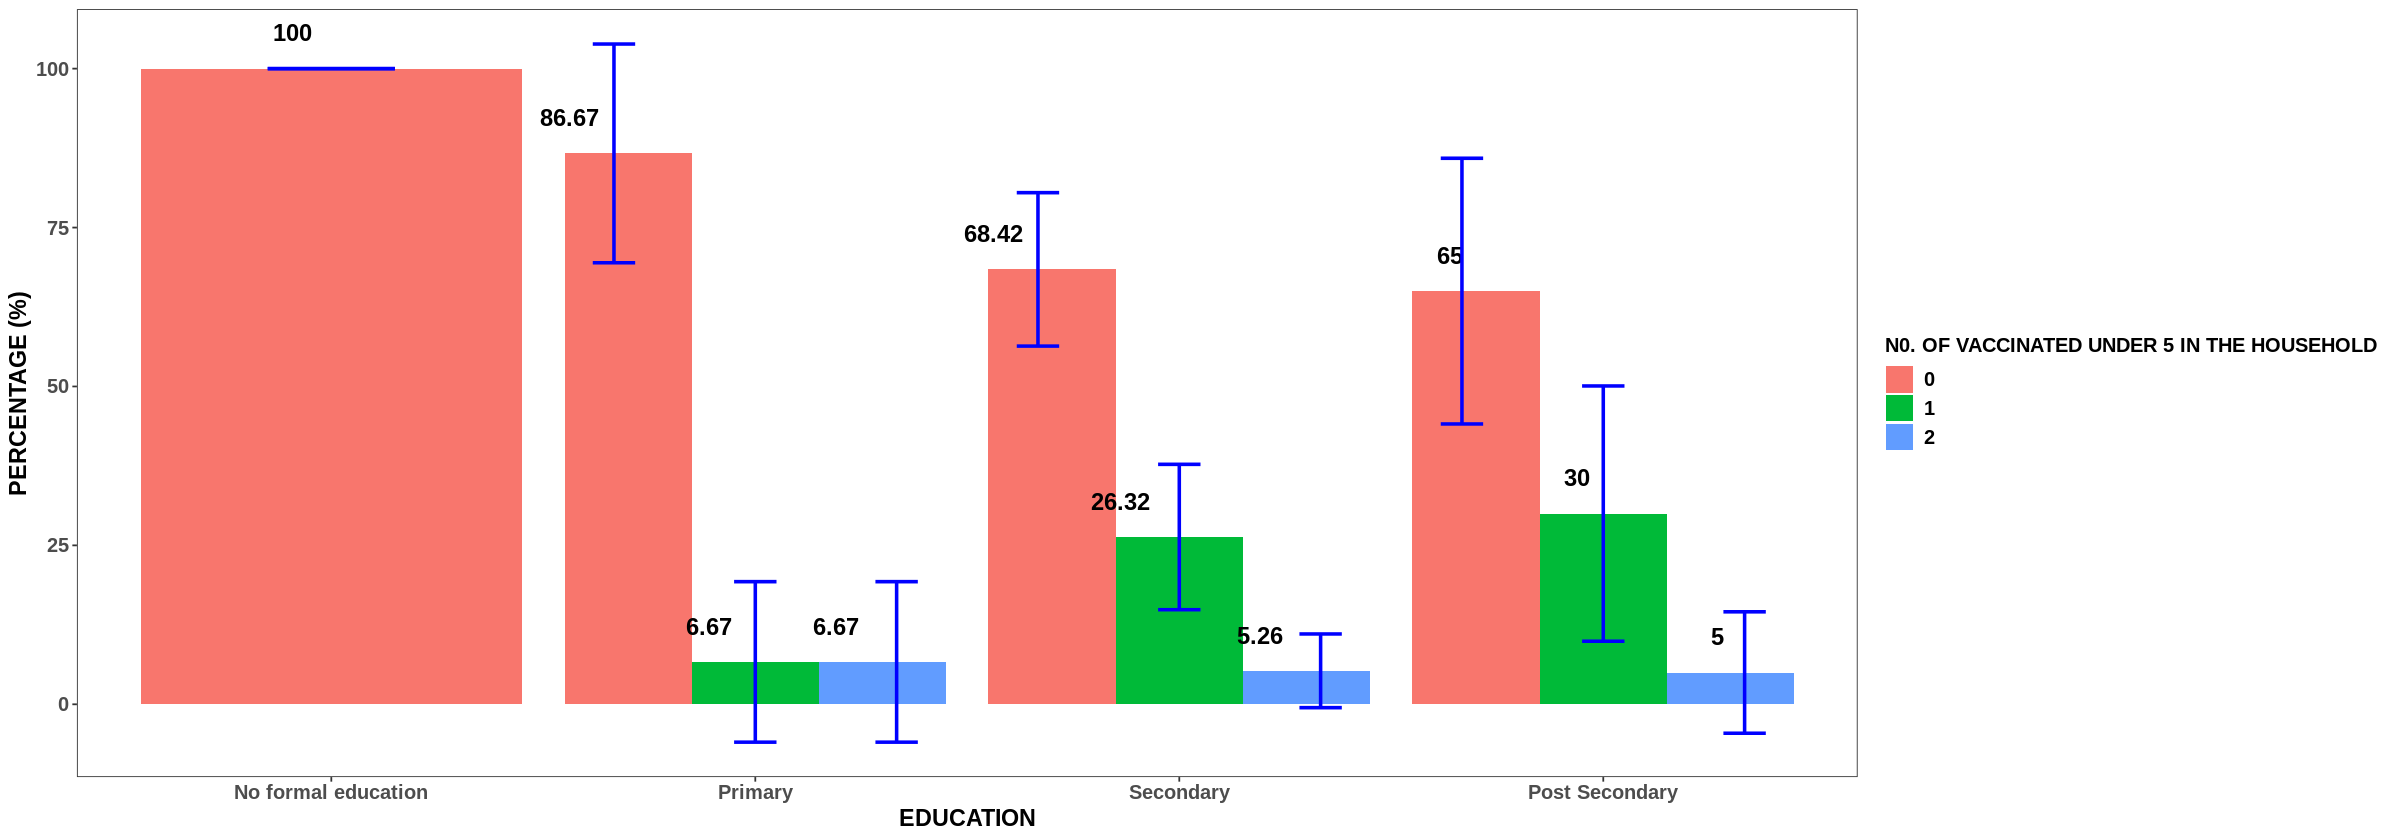



-------------------------------------------


-------------------------------------------
ACCOMODATION

-------------------------------------------


B13                              Freq % Freq    
1 A whole family house              26   25.742574
2 Duplex                             6    5.940594
3 Two/three bedroom flat            16   15.841584
4 Mini flat/self-contain apartment  32   31.683168
5 Room and parlour                  21   20.792079
6 Single room                        0    0.000000
7 Wood & makeshift structure         0    0.000000
8 Total                            101  100.000000

A whole family house Duplex      Two/three bedroom flat
0     24 [ 23.76% ]        4 [ 3.96% ] 9 [ 8.91% ]           
1     0 [ 0% ]             2 [ 1.98% ] 6 [ 5.94% ]           
2     2 [ 1.98% ]          0 [ 0% ]    1 [ 0.99% ]           
Total 26 [ 25.74% ]        6 [ 5.94% ] 16 [ 15.84% ]         
      Mini flat/self-contain apartment Room and parlour Single room
0     22 [ 21.78% ]                    15 [ 14.85% ]    0 [ 0% ]   
1     8 [ 7.92% ]                      6 [ 5.94% ]      0 [ 0% ]   
2     2 [ 1.98% ]                      0 [ 0% ]         0 [ 0% ]   
Total 32 [ 31.68% ]                    21 [ 20.79% ]    0 [ 0% ]   
      Wood & makeshift structure Total        
0     0 [ 0% ]                   74 [ 73.27% ]
1     0 [ 0% ]                   22 [ 21.78% ]
2     0 [ 0% ]                   5 [ 4.95% ]  
Total 0 [ 0% ]                   101 [ 100% ]

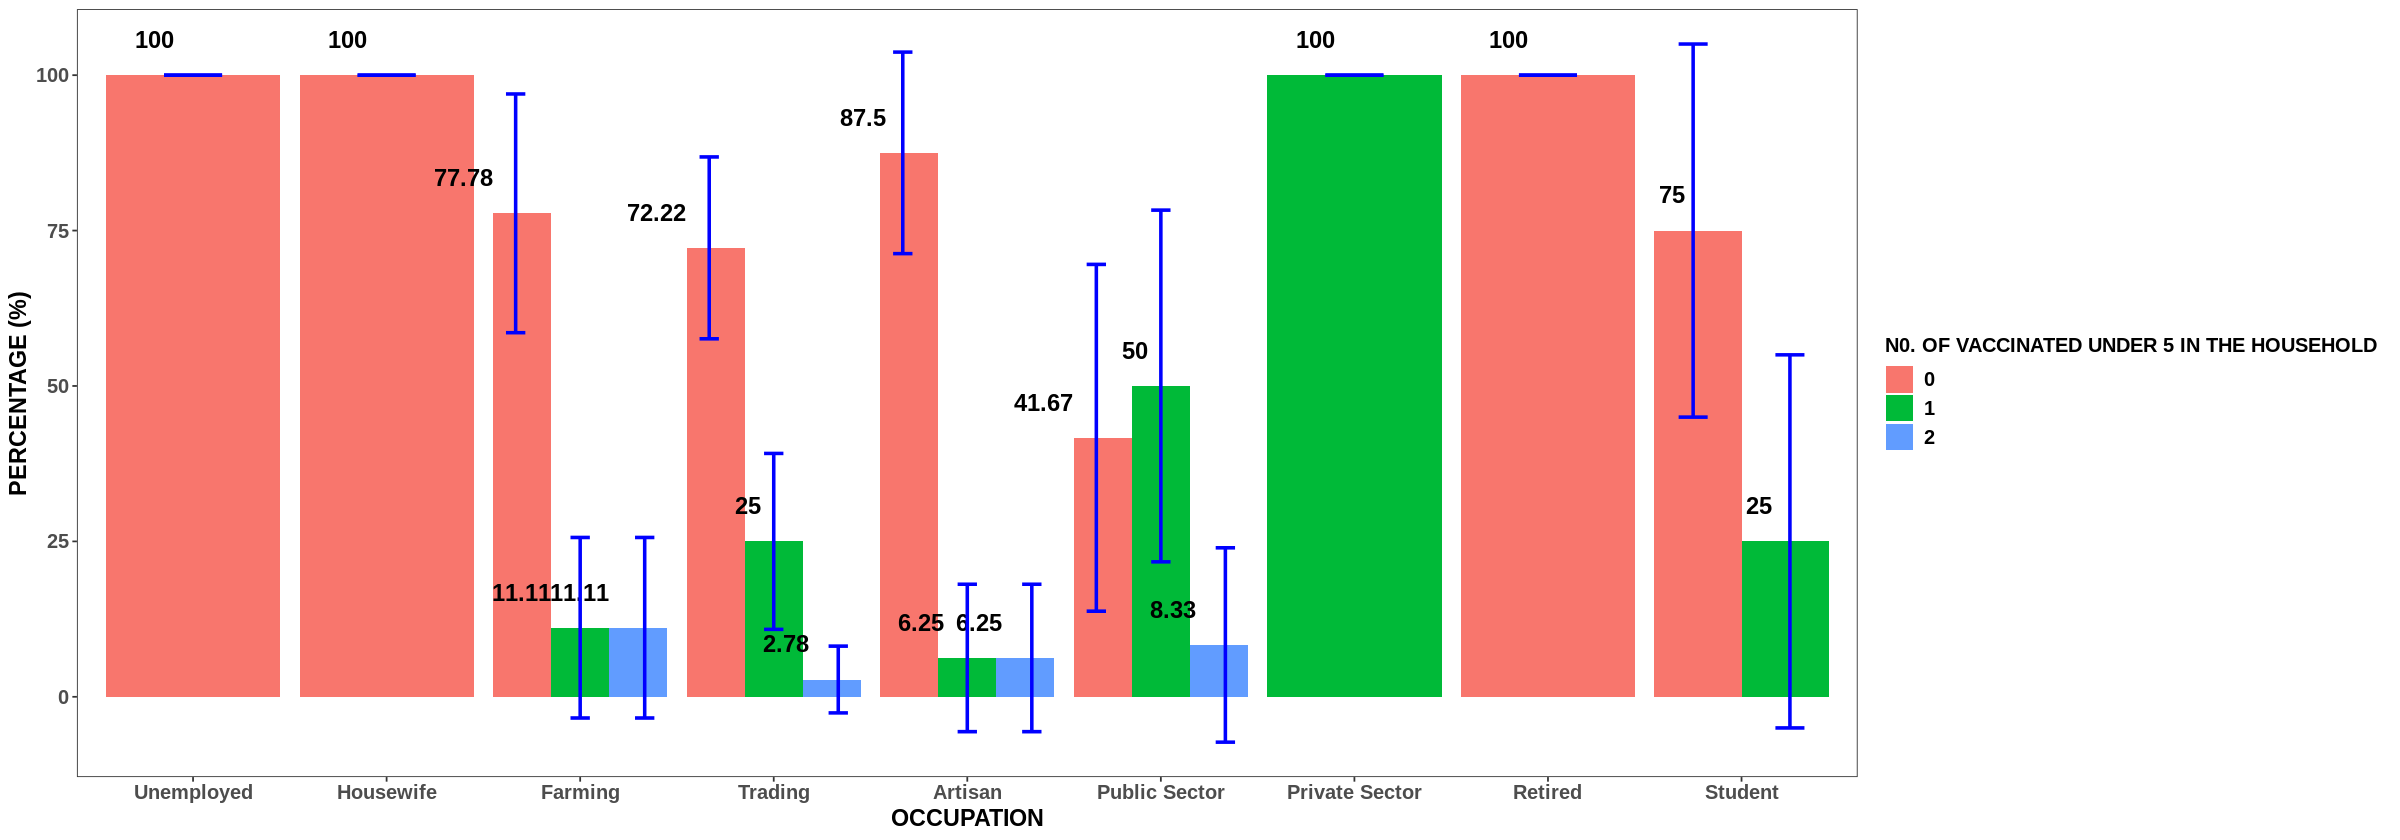



-------------------------------------------


-------------------------------------------
EDUCATION MODIFIED

-------------------------------------------


A5MUT             Freq % Freq   
1 Secondary & Above  77   76.23762
2 Pre Secondary      24   23.76238
3 Total             101  100.00000

Secondary & Above Pre Secondary Total        
0     52 [ 51.49% ]     22 [ 21.78% ] 74 [ 73.27% ]
1     21 [ 20.79% ]     1 [ 0.99% ]   22 [ 21.78% ]
2     4 [ 3.96% ]       1 [ 0.99% ]   5 [ 4.95% ]  
Total 77 [ 76.24% ]     24 [ 23.76% ] 101 [ 100% ]

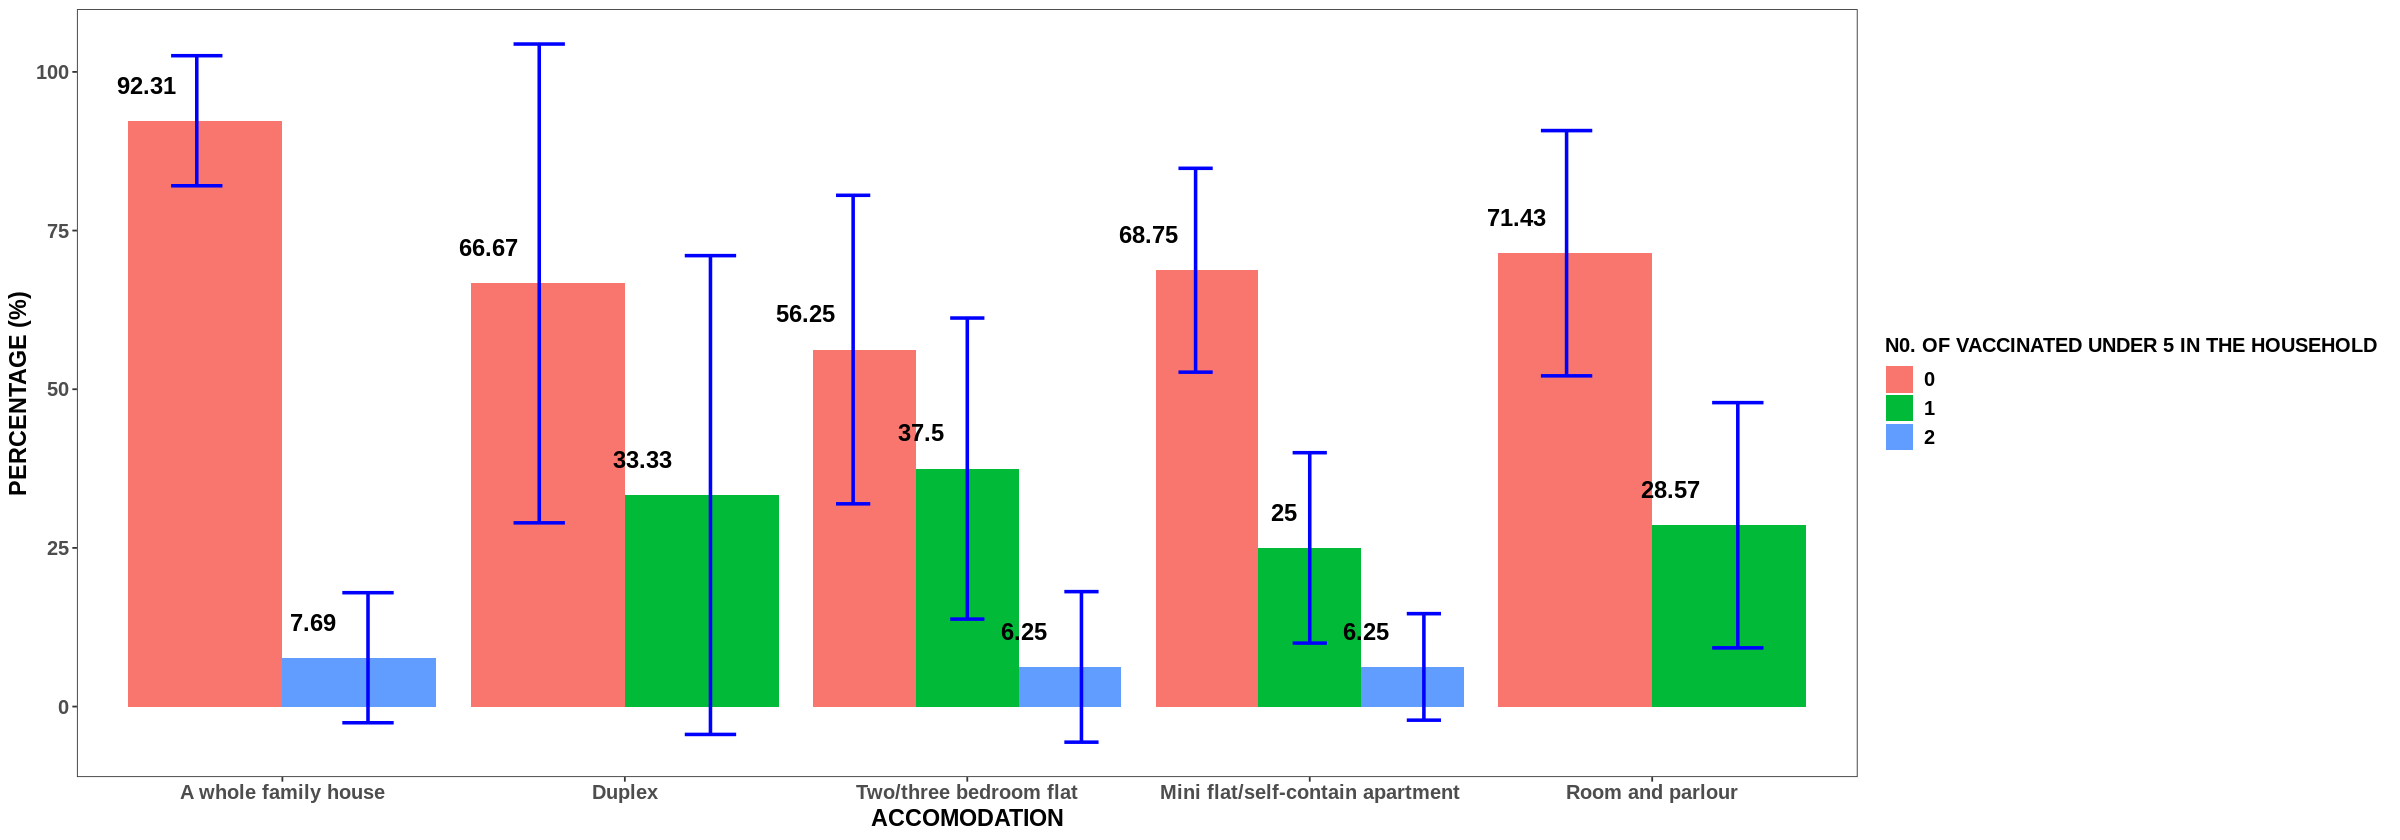



-------------------------------------------


-------------------------------------------
OCCUPATION MODIFIED

-------------------------------------------


A6MUT                  Freq % Freq    
1 Blue Collar             70   69.306931
2 White Collar            18   17.821782
3 Student                  8    7.920792
4 Unemployed & Housewife   5    4.950495
5 Total                  101  100.000000

Blue Collar   White Collar  Student     Unemployed & Housewife
0     54 [ 53.47% ] 9 [ 8.91% ]   6 [ 5.94% ] 5 [ 4.95% ]           
1     12 [ 11.88% ] 8 [ 7.92% ]   2 [ 1.98% ] 0 [ 0% ]              
2     4 [ 3.96% ]   1 [ 0.99% ]   0 [ 0% ]    0 [ 0% ]              
Total 70 [ 69.31% ] 18 [ 17.82% ] 8 [ 7.92% ] 5 [ 4.95% ]           
      Total        
0     74 [ 73.27% ]
1     22 [ 21.78% ]
2     5 [ 4.95% ]  
Total 101 [ 100% ]

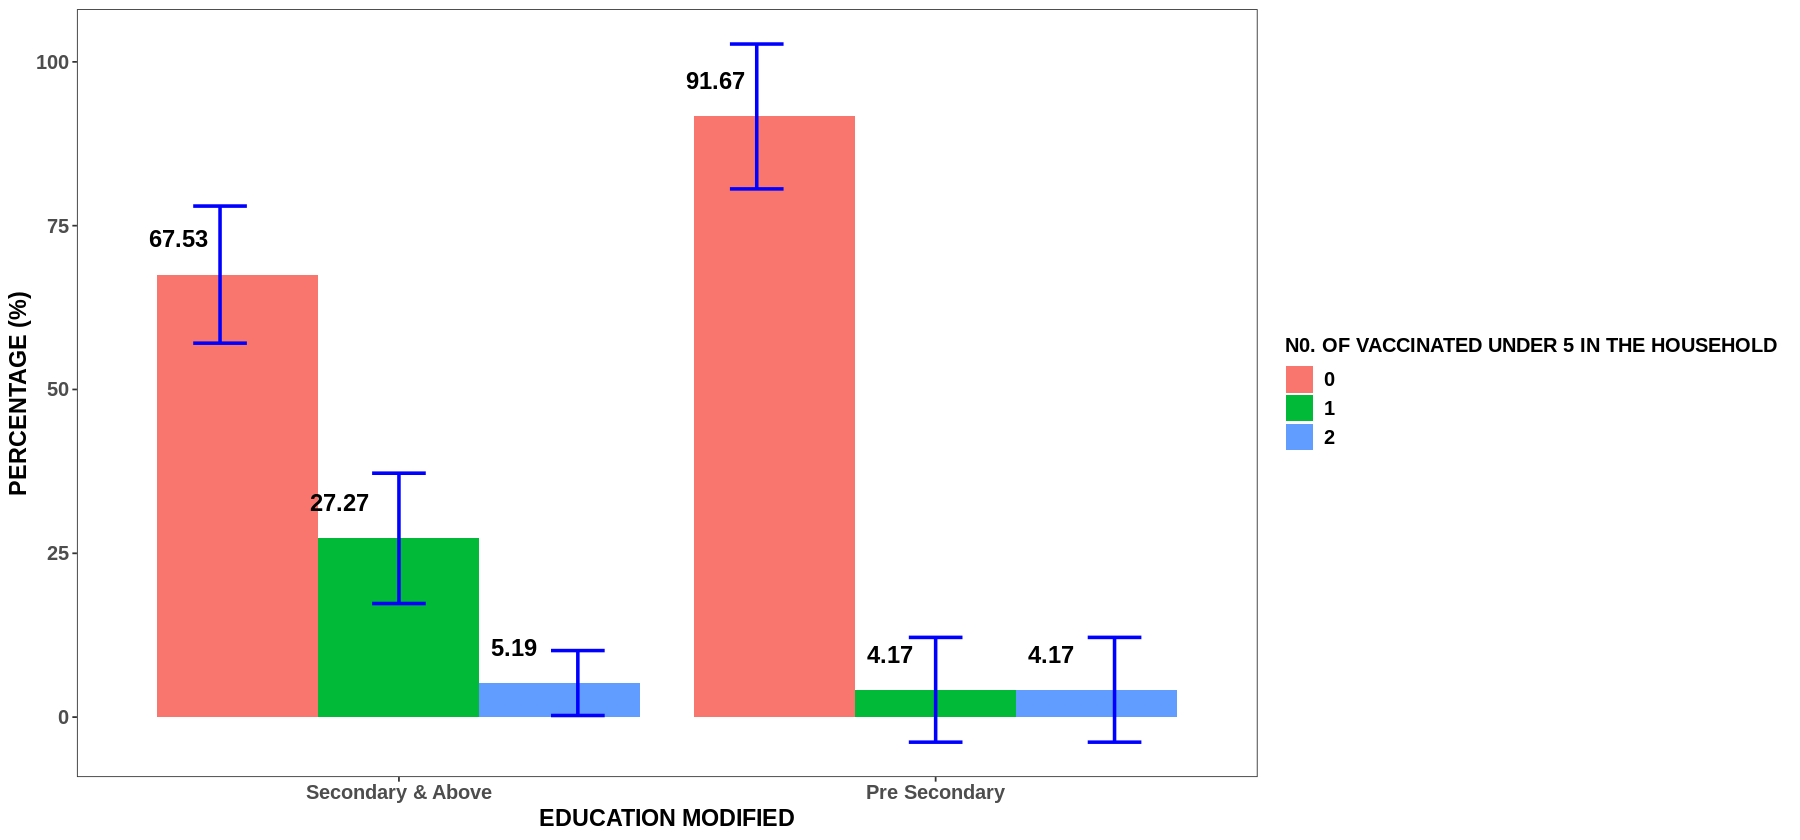



-------------------------------------------


-------------------------------------------
ACCOMODATION MODIFIED

-------------------------------------------


B13MUT       Freq % Freq   
1 Not Spacious  53   52.47525
2 Spacious      48   47.52475
3 Total        101  100.00000

Not Spacious  Spacious      Total        
0     37 [ 36.63% ] 37 [ 36.63% ] 74 [ 73.27% ]
1     14 [ 13.86% ] 8 [ 7.92% ]   22 [ 21.78% ]
2     2 [ 1.98% ]   3 [ 2.97% ]   5 [ 4.95% ]  
Total 53 [ 52.48% ] 48 [ 47.52% ] 101 [ 100% ]

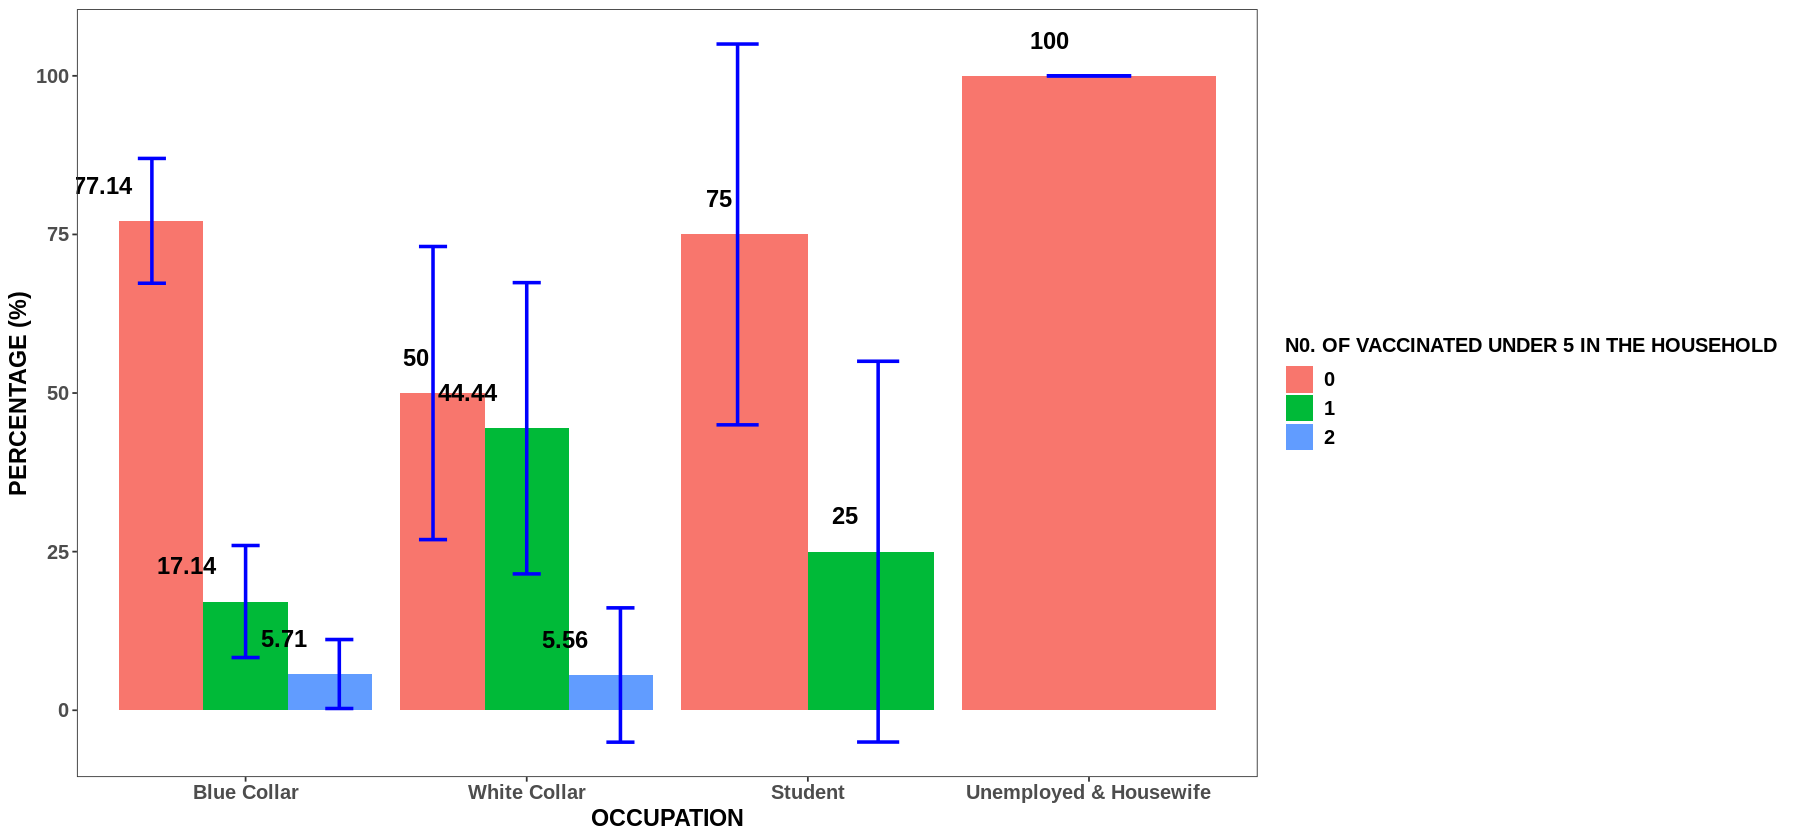

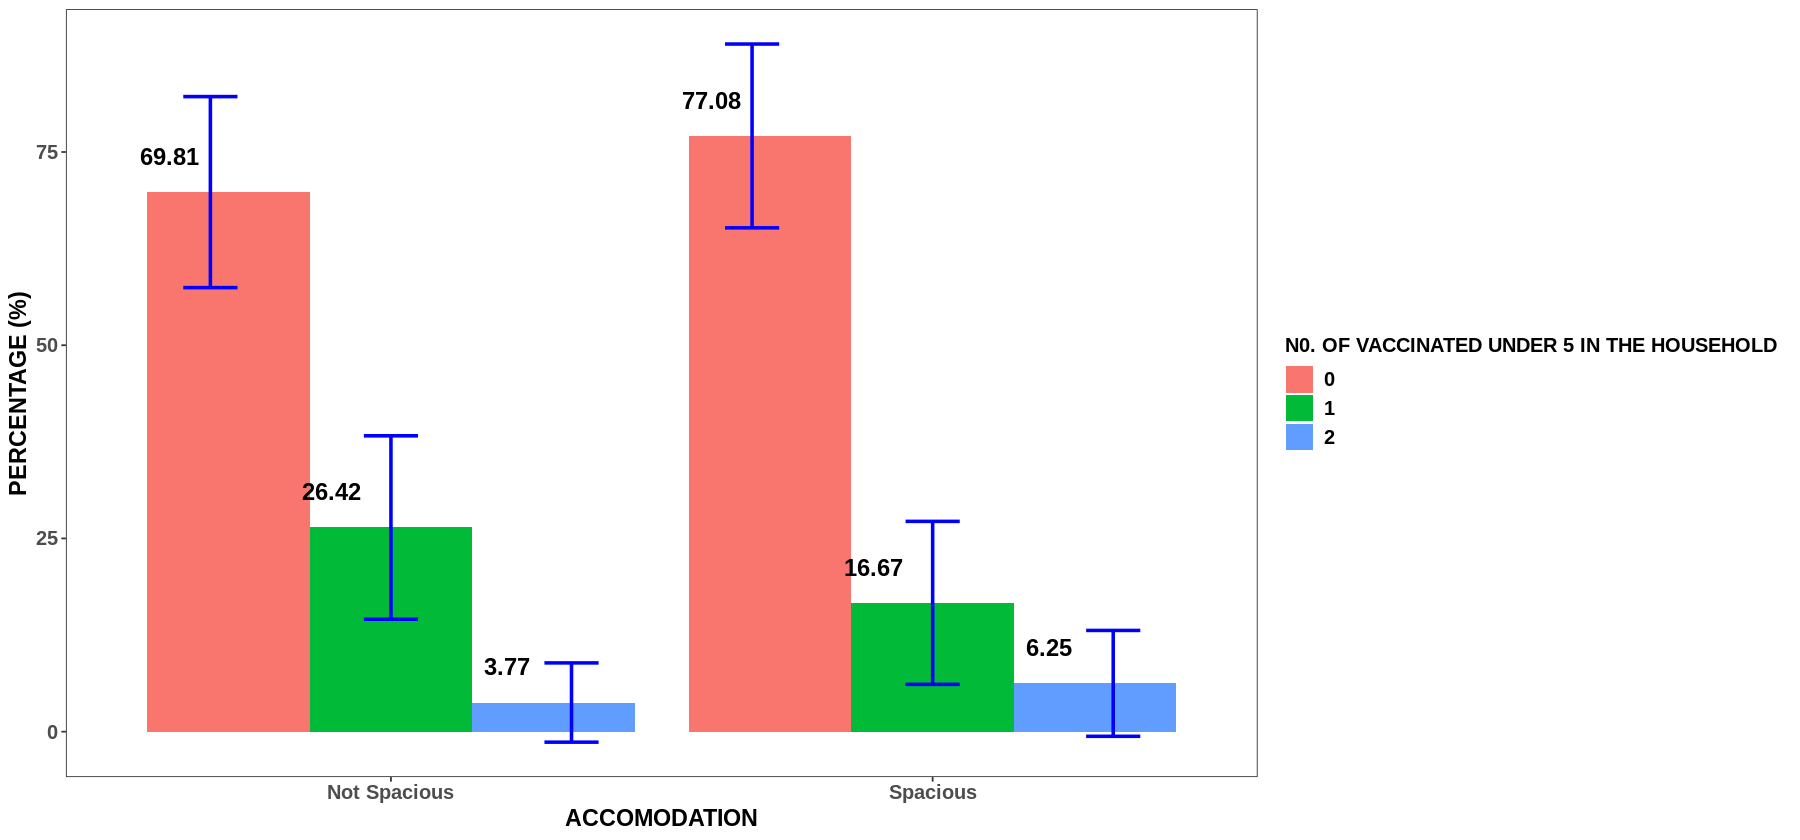

In [ ]:
fig_sizer_fn(12,7)
cat("\n\n-------------------------------------------\n")
cat("\n\n-------------------------------------------\n")

cat("SEX")
cat("\n\n-------------------------------------------\n")
analysis_df = YF_data %>% filter(is.na(D35) == FALSE) %>% filter(is.na(A1) == FALSE)

analysis_df %$% freq(A1)

cat("\n\n\n")

analysis_df %$% ctable_fn(x = D35, y = A1)

cat("\n\n\n")

#============================================================

analysis_CI_cat_df = analysis_df %>% select(D35, A1) %>% group_by(A1, D35) %>%
  summarise(Count = n(), .groups = 'drop') %>% 

  mutate(OverallPercentage = Count/sum(.$Count) ) %>%
  mutate( OverallPercentage = round(OverallPercentage,4) * 100) %>%
  
  group_by(A1) %>% mutate(WithinGroupSum = sum(Count)) %>%
  group_by(D35, .add=TRUE) %>%
  mutate(Percentage = Count/WithinGroupSum , Lower_CI = Percentage - 1.96 * sqrt( Percentage * {1 - Percentage} / WithinGroupSum), Upper_CI = Percentage + 1.96 * sqrt( Percentage * {1 - Percentage} / WithinGroupSum)) %>%
  mutate( Percentage = round(Percentage, 4) * 100, Lower_CI  = round(Lower_CI, 4) * 100, Upper_CI = round(Upper_CI,4) * 100)

ggplot(analysis_CI_cat_df, aes(x = factor(A1), y = Percentage, fill = factor(D35))) +
  geom_bar(position="dodge", stat="identity", width = 0.9) +
   geom_text(aes(label = Percentage), position = position_dodge(0.9), hjust = 1.5, vjust = -1.6, fontface = "bold", size = 5) +
  labs(x = "SEX", y = "PERCENTAGE (%)", fill = "N0. OF VACCINATED UNDER 5 IN THE HOUSEHOLD") +  
      geom_errorbar(aes(ymin = Lower_CI, ymax = Upper_CI), width = 0.3 , position = position_dodge(width = 1), color = "blue", size = 1)    +
  theme_minimal(base_size = 18)+
  theme_bw() +
  theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank()) +
  theme(legend.text=element_text(size = 12, face = "bold"), legend.title = element_text(size=12 , face = "bold"), axis.text=element_text(size=12, face="bold"),
        axis.title=element_text(size=14, face="bold"), plot.title = element_text(hjust = 0.5, size = 16, face = "bold"))



cat("\n\n-------------------------------------------\n")
cat("\n\n-------------------------------------------\n")

cat("AGE CONTINUOUS")
cat("\n\n-------------------------------------------\n")

analysis_df = YF_data %>% filter(is.na(D35) == FALSE) %>% filter(is.na(A2) == FALSE)

cat(paste0("\n\n Number of missing observation is: ", nrow(YF_data) - nrow(analysis_df), " out of ", nrow(YF_data), "\n"))
#=======================================================================

analysis_df = analysis_df %>% select(c(A2, D35 ))
analysis_df = analysis_df[complete.cases(analysis_df),]

analysis_df$A2 = as.numeric(analysis_df$A2)

cat("\n\n")

#=======================================================================

analysis_CI_cont_df1 = analysis_df %>% group_by(D35) %>%
                       summarise(Count = n(), Mean = mean(A2, na.rm=TRUE), Min = quantile(A2, 0, na.rm=TRUE), Q1 = quantile(A2, 0.25, na.rm=TRUE), 
                       Q2 = quantile(A2, 0.5, na.rm=TRUE),  Q3 = quantile(A2, 0.75, na.rm=TRUE), Max = quantile(A2, 1, na.rm=TRUE),
                       Sd = sd(A2, na.rm=TRUE), .groups = 'drop') %>%
                       mutate( Margin_Error = {Sd/sqrt(Count)} * qt(1-0.05/2, Count - 1)  ) %>% mutate(Mean = round(Mean, 2),  Margin_Error = round(Margin_Error, 2) )
analysis_CI_cont_df1$D35 = as.character(analysis_CI_cont_df1$D35)

analysis_CI_cont_df2 = analysis_df %>%
                       summarise(D35 =  "Total", Count = n(), Mean = mean(A2, na.rm=TRUE), Min = quantile(A2, 0, na.rm=TRUE), Q1 = quantile(A2, 0.25, na.rm=TRUE), 
                       Q2 = quantile(A2, 0.5, na.rm=TRUE),  Q3 = quantile(A2, 0.75, na.rm=TRUE), Max = quantile(A2, 1, na.rm=TRUE),
                       Sd = sd(A2, na.rm=TRUE), .groups = 'drop') %>%
                       mutate( Margin_Error = {Sd/sqrt(Count)} * qt(1-0.05/2, Count - 1)  ) %>% mutate(Mean = round(Mean, 2),  Margin_Error = round(Margin_Error, 2) )

analysis_CI_cont_df = rbind(analysis_CI_cont_df1, analysis_CI_cont_df2)

analysis_CI_cont_df 

#================================================================


ggplot(analysis_CI_cont_df, aes(x = factor(D35), y = Mean , fill = factor(D35))) +
  geom_bar(position="dodge", stat="identity", width = 0.9) +
  labs(x = "AGE CONT (Answers to Number Vaccinated Under 5)", y = "Mean", fill = "N0. OF VACCINATED UNDER 5 IN THE HOUSEHOLD") +  
       geom_text(aes(label = Mean), position = position_dodge(0.9), hjust = 1.5, vjust = -1.6, fontface = "bold", size = 5) +
      geom_errorbar(aes(ymin = Mean  - Margin_Error, ymax = Mean + Margin_Error), width = 0.5, position = position_dodge(width = 0.5), color="blue", size=1)    +
  theme_minimal(base_size = 18)+
  theme_bw() +
  theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank()) +
  theme(legend.text=element_text(size = 12, face = "bold"), legend.title = element_text(size=12 , face = "bold"), axis.text=element_text(size=12, face="bold"),
        axis.title=element_text(size=14, face="bold"), plot.title = element_text(hjust = 0.5, size = 16, face = "bold"))






cat("\n\n-------------------------------------------\n")
cat("\n\n-------------------------------------------\n")

cat("AGE CATEGORICAL")
cat("\n\n-------------------------------------------\n")

analysis_df = YF_data %>% filter(is.na(D35) == FALSE) %>% filter(is.na(AGECAT) == FALSE)

analysis_df %$% freq(AGECAT)

cat("\n\n\n")

analysis_df %$% ctable_fn(x = D35, y = AGECAT)


#============================================================

analysis_CI_cat_df = analysis_df %>% select(D35, AGECAT) %>% group_by(AGECAT, D35) %>%
  summarise(Count = n(), .groups = 'drop') %>% 

  mutate(OverallPercentage = Count/sum(.$Count) ) %>%
  mutate( OverallPercentage = round(OverallPercentage,4) * 100) %>%
  
  group_by(AGECAT) %>% mutate(WithinGroupSum = sum(Count)) %>%
  group_by(D35, .add=TRUE) %>%
  mutate(Percentage = Count/WithinGroupSum , Lower_CI = Percentage - 1.96 * sqrt( Percentage * {1 - Percentage} / WithinGroupSum), Upper_CI = Percentage + 1.96 * sqrt( Percentage * {1 - Percentage} / WithinGroupSum)) %>%
  mutate( Percentage = round(Percentage, 4) * 100, Lower_CI  = round(Lower_CI, 4) * 100, Upper_CI = round(Upper_CI,4) * 100)
fig_sizer_fn(15, 7)
ggplot(analysis_CI_cat_df, aes(x = factor(AGECAT), y = Percentage, fill = factor(D35))) +
  geom_bar(position="dodge", stat="identity", width = 0.9) +
   geom_text(aes(label = Percentage), position = position_dodge(0.9), hjust = 1.5, vjust = -1.6, fontface = "bold", size = 5) +
  labs(x = "AGE CATEGORICAL", y = "PERCENTAGE (%)", fill = "N0. OF VACCINATED UNDER 5 IN THE HOUSEHOLD") +  
      geom_errorbar(aes(ymin = Lower_CI, ymax = Upper_CI), width = 0.3 , position = position_dodge(width = 1), color = "blue", size = 1)    +
  theme_minimal(base_size = 18)+
  theme_bw() +
  theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank()) +
  theme(legend.text=element_text(size = 12, face = "bold"), legend.title = element_text(size=12 , face = "bold"), axis.text=element_text(size=12, face="bold"),
        axis.title=element_text(size=14, face="bold"), plot.title = element_text(hjust = 0.5, size = 16, face = "bold"))



cat("\n\n-------------------------------------------\n")
cat("\n\n-------------------------------------------\n")

cat("EDUCATION")
cat("\n\n-------------------------------------------\n")

analysis_df = YF_data %>% filter(is.na(D35) == FALSE) %>% filter(is.na(A5) == FALSE)

analysis_df %$% freq(A5)

cat("\n\n\n")

analysis_df %$% ctable_fn(x = D35, y = A5)


#============================================================

analysis_CI_cat_df = analysis_df %>% select(D35, A5) %>% group_by(A5, D35) %>%
  summarise(Count = n(), .groups = 'drop') %>% 

  mutate(OverallPercentage = Count/sum(.$Count) ) %>%
  mutate( OverallPercentage = round(OverallPercentage,4) * 100) %>%
  
  group_by(A5) %>% mutate(WithinGroupSum = sum(Count)) %>%
  group_by(D35, .add=TRUE) %>%
  mutate(Percentage = Count/WithinGroupSum , Lower_CI = Percentage - 1.96 * sqrt( Percentage * {1 - Percentage} / WithinGroupSum), Upper_CI = Percentage + 1.96 * sqrt( Percentage * {1 - Percentage} / WithinGroupSum)) %>%
  mutate( Percentage = round(Percentage, 4) * 100, Lower_CI  = round(Lower_CI, 4) * 100, Upper_CI = round(Upper_CI,4) * 100)

fig_sizer_fn(20, 7)

ggplot(analysis_CI_cat_df, aes(x = factor(A5), y = Percentage, fill = factor(D35))) +
  geom_bar(position="dodge", stat="identity", width = 0.9) +
   geom_text(aes(label = Percentage), position = position_dodge(0.9), hjust = 1.5, vjust = -1.6, fontface = "bold", size = 5) +
  labs(x = "EDUCATION", y = "PERCENTAGE (%)", fill = "N0. OF VACCINATED UNDER 5 IN THE HOUSEHOLD") +  
      geom_errorbar(aes(ymin = Lower_CI, ymax = Upper_CI), width = 0.3 , position = position_dodge(width = 1), color = "blue", size = 1)    +
  theme_minimal(base_size = 18)+
  theme_bw() +
  theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank()) +
  theme(legend.text=element_text(size = 12, face = "bold"), legend.title = element_text(size=12 , face = "bold"), axis.text=element_text(size=12, face="bold"),
        axis.title=element_text(size=14, face="bold"), plot.title = element_text(hjust = 0.5, size = 16, face = "bold"))



cat("\n\n-------------------------------------------\n")
cat("\n\n-------------------------------------------\n")

cat("OCCUPATION")
cat("\n\n-------------------------------------------\n")

analysis_df = YF_data %>% filter(is.na(D35) == FALSE) %>% filter(is.na(A6) == FALSE)

analysis_df %$% freq(A6)

cat("\n\n\n")

analysis_df %$% ctable_fn(x = D35, y = A6)


#============================================================

analysis_CI_cat_df = analysis_df %>% select(D35, A6) %>% group_by(A6, D35) %>%
  summarise(Count = n(), .groups = 'drop') %>% 

  mutate(OverallPercentage = Count/sum(.$Count) ) %>%
  mutate( OverallPercentage = round(OverallPercentage,4) * 100) %>%
  
  group_by(A6) %>% mutate(WithinGroupSum = sum(Count)) %>%
  group_by(D35, .add=TRUE) %>%
  mutate(Percentage = Count/WithinGroupSum , Lower_CI = Percentage - 1.96 * sqrt( Percentage * {1 - Percentage} / WithinGroupSum), Upper_CI = Percentage + 1.96 * sqrt( Percentage * {1 - Percentage} / WithinGroupSum)) %>%
  mutate( Percentage = round(Percentage, 4) * 100, Lower_CI  = round(Lower_CI, 4) * 100, Upper_CI = round(Upper_CI,4) * 100)

fig_sizer_fn(20, 7)

ggplot(analysis_CI_cat_df, aes(x = factor(A6), y = Percentage, fill = factor(D35))) +
  geom_bar(position="dodge", stat="identity", width = 0.9) +
   geom_text(aes(label = Percentage), position = position_dodge(0.9), hjust = 1.5, vjust = -1.6, fontface = "bold", size = 5) +
  labs(x = "OCCUPATION", y = "PERCENTAGE (%)", fill = "N0. OF VACCINATED UNDER 5 IN THE HOUSEHOLD") +  
      geom_errorbar(aes(ymin = Lower_CI, ymax = Upper_CI), width = 0.3 , position = position_dodge(width = 1), color = "blue", size = 1)    +
  theme_minimal(base_size = 18)+
  theme_bw() +
  theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank()) +
  theme(legend.text=element_text(size = 12, face = "bold"), legend.title = element_text(size=12 , face = "bold"), axis.text=element_text(size=12, face="bold"),
        axis.title=element_text(size=14, face="bold"), plot.title = element_text(hjust = 0.5, size = 16, face = "bold"))




cat("\n\n-------------------------------------------\n")
cat("\n\n-------------------------------------------\n")

cat("ACCOMODATION")
cat("\n\n-------------------------------------------\n")

analysis_df = YF_data %>% filter(is.na(D35) == FALSE) %>% filter(is.na(B13) == FALSE)

analysis_df %$% freq(B13)

cat("\n\n\n")

analysis_df %$% ctable_fn(x = D35, y = B13)


#============================================================

analysis_CI_cat_df = analysis_df %>% select(D35, B13) %>% group_by(B13, D35) %>%
  summarise(Count = n(), .groups = 'drop') %>% 

  mutate(OverallPercentage = Count/sum(.$Count) ) %>%
  mutate( OverallPercentage = round(OverallPercentage,4) * 100) %>%
  
  group_by(B13) %>% mutate(WithinGroupSum = sum(Count)) %>%
  group_by(D35, .add=TRUE) %>%
  mutate(Percentage = Count/WithinGroupSum , Lower_CI = Percentage - 1.96 * sqrt( Percentage * {1 - Percentage} / WithinGroupSum), Upper_CI = Percentage + 1.96 * sqrt( Percentage * {1 - Percentage} / WithinGroupSum)) %>%
  mutate( Percentage = round(Percentage, 4) * 100, Lower_CI  = round(Lower_CI, 4) * 100, Upper_CI = round(Upper_CI,4) * 100)

fig_sizer_fn(20, 7)

ggplot(analysis_CI_cat_df, aes(x = factor(B13), y = Percentage, fill = factor(D35))) +
  geom_bar(position="dodge", stat="identity", width = 0.9) +
   geom_text(aes(label = Percentage), position = position_dodge(0.9), hjust = 1.5, vjust = -1.6, fontface = "bold", size = 5) +
  labs(x = "ACCOMODATION", y = "PERCENTAGE (%)", fill = "N0. OF VACCINATED UNDER 5 IN THE HOUSEHOLD") +  
      geom_errorbar(aes(ymin = Lower_CI, ymax = Upper_CI), width = 0.3 , position = position_dodge(width = 1), color = "blue", size = 1)    +
  theme_minimal(base_size = 18)+
  theme_bw() +
  theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank()) +
  theme(legend.text=element_text(size = 12, face = "bold"), legend.title = element_text(size=12 , face = "bold"), axis.text=element_text(size=12, face="bold"),
        axis.title=element_text(size=14, face="bold"), plot.title = element_text(hjust = 0.5, size = 16, face = "bold"))



#====================================================================================================================
#====================================================================================================================
#====================================================================================================================
#====================================================================================================================


fig_sizer_fn()

cat("\n\n-------------------------------------------\n")
cat("\n\n-------------------------------------------\n")

cat("EDUCATION MODIFIED")
cat("\n\n-------------------------------------------\n")

analysis_df = YF_data %>% filter(is.na(D35) == FALSE) %>% filter(is.na(A5MUT) == FALSE)

analysis_df %$% freq(A5MUT)

cat("\n\n\n")

analysis_df %$% ctable_fn(x = D35, y = A5MUT)


#============================================================

analysis_CI_cat_df = analysis_df %>% select(D35, A5MUT) %>% group_by(A5MUT, D35) %>%
  summarise(Count = n(), .groups = 'drop') %>% 

  mutate(OverallPercentage = Count/sum(.$Count) ) %>%
  mutate( OverallPercentage = round(OverallPercentage,4) * 100) %>%
  
  group_by(A5MUT) %>% mutate(WithinGroupSum = sum(Count)) %>%
  group_by(D35, .add=TRUE) %>%
  mutate(Percentage = Count/WithinGroupSum , Lower_CI = Percentage - 1.96 * sqrt( Percentage * {1 - Percentage} / WithinGroupSum), Upper_CI = Percentage + 1.96 * sqrt( Percentage * {1 - Percentage} / WithinGroupSum)) %>%
  mutate( Percentage = round(Percentage, 4) * 100, Lower_CI  = round(Lower_CI, 4) * 100, Upper_CI = round(Upper_CI,4) * 100)

fig_sizer_fn(15, 7)

ggplot(analysis_CI_cat_df, aes(x = factor(A5MUT), y = Percentage, fill = factor(D35))) +
  geom_bar(position="dodge", stat="identity", width = 0.9) +
   geom_text(aes(label = Percentage), position = position_dodge(0.9), hjust = 1.5, vjust = -1.6, fontface = "bold", size = 5) +
  labs(x = "EDUCATION MODIFIED", y = "PERCENTAGE (%)", fill = "N0. OF VACCINATED UNDER 5 IN THE HOUSEHOLD") +  
      geom_errorbar(aes(ymin = Lower_CI, ymax = Upper_CI), width = 0.3 , position = position_dodge(width = 1), color = "blue", size = 1)    +
  theme_minimal(base_size = 18)+
  theme_bw() +
  theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank()) +
  theme(legend.text=element_text(size = 12, face = "bold"), legend.title = element_text(size=12 , face = "bold"), axis.text=element_text(size=12, face="bold"),
        axis.title=element_text(size=14, face="bold"), plot.title = element_text(hjust = 0.5, size = 16, face = "bold"))



cat("\n\n-------------------------------------------\n")
cat("\n\n-------------------------------------------\n")

cat("OCCUPATION MODIFIED")
cat("\n\n-------------------------------------------\n")

analysis_df = YF_data %>% filter(is.na(D35) == FALSE) %>% filter(is.na(A6MUT) == FALSE)

analysis_df %$% freq(A6MUT)

cat("\n\n\n")

analysis_df %$% ctable_fn(x = D35, y = A6MUT)


#============================================================

analysis_CI_cat_df = analysis_df %>% select(D35, A6MUT) %>% group_by(A6MUT, D35) %>%
  summarise(Count = n(), .groups = 'drop') %>% 

  mutate(OverallPercentage = Count/sum(.$Count) ) %>%
  mutate( OverallPercentage = round(OverallPercentage,4) * 100) %>%
  
  group_by(A6MUT) %>% mutate(WithinGroupSum = sum(Count)) %>%
  group_by(D35, .add=TRUE) %>%
  mutate(Percentage = Count/WithinGroupSum , Lower_CI = Percentage - 1.96 * sqrt( Percentage * {1 - Percentage} / WithinGroupSum), Upper_CI = Percentage + 1.96 * sqrt( Percentage * {1 - Percentage} / WithinGroupSum)) %>%
  mutate( Percentage = round(Percentage, 4) * 100, Lower_CI  = round(Lower_CI, 4) * 100, Upper_CI = round(Upper_CI,4) * 100)

fig_sizer_fn(15, 7)

ggplot(analysis_CI_cat_df, aes(x = factor(A6MUT), y = Percentage, fill = factor(D35))) +
  geom_bar(position="dodge", stat="identity", width = 0.9) +
   geom_text(aes(label = Percentage), position = position_dodge(0.9), hjust = 1.5, vjust = -1.6, fontface = "bold", size = 5) +
  labs(x = "OCCUPATION", y = "PERCENTAGE (%)", fill = "N0. OF VACCINATED UNDER 5 IN THE HOUSEHOLD") +  
      geom_errorbar(aes(ymin = Lower_CI, ymax = Upper_CI), width = 0.3 , position = position_dodge(width = 1), color = "blue", size = 1)    +
  theme_minimal(base_size = 18)+
  theme_bw() +
  theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank()) +
  theme(legend.text=element_text(size = 12, face = "bold"), legend.title = element_text(size=12 , face = "bold"), axis.text=element_text(size=12, face="bold"),
        axis.title=element_text(size=14, face="bold"), plot.title = element_text(hjust = 0.5, size = 16, face = "bold"))




cat("\n\n-------------------------------------------\n")
cat("\n\n-------------------------------------------\n")

cat("ACCOMODATION MODIFIED")
cat("\n\n-------------------------------------------\n")

analysis_df = YF_data %>% filter(is.na(D35) == FALSE) %>% filter(is.na(B13MUT) == FALSE)

analysis_df %$% freq(B13MUT)

cat("\n\n\n")

analysis_df %$% ctable_fn(x = D35, y = B13MUT)


#============================================================

analysis_CI_cat_df = analysis_df %>% select(D35, B13MUT) %>% group_by(B13MUT, D35) %>%
  summarise(Count = n(), .groups = 'drop') %>% 

  mutate(OverallPercentage = Count/sum(.$Count) ) %>%
  mutate( OverallPercentage = round(OverallPercentage,4) * 100) %>%
  
  group_by(B13MUT) %>% mutate(WithinGroupSum = sum(Count)) %>%
  group_by(D35, .add=TRUE) %>%
  mutate(Percentage = Count/WithinGroupSum , Lower_CI = Percentage - 1.96 * sqrt( Percentage * {1 - Percentage} / WithinGroupSum), Upper_CI = Percentage + 1.96 * sqrt( Percentage * {1 - Percentage} / WithinGroupSum)) %>%
  mutate( Percentage = round(Percentage, 4) * 100, Lower_CI  = round(Lower_CI, 4) * 100, Upper_CI = round(Upper_CI,4) * 100)

fig_sizer_fn(15, 7)

ggplot(analysis_CI_cat_df, aes(x = factor(B13MUT), y = Percentage, fill = factor(D35))) +
  geom_bar(position="dodge", stat="identity", width = 0.9) +
   geom_text(aes(label = Percentage), position = position_dodge(0.9), hjust = 1.5, vjust = -1.6, fontface = "bold", size = 5) +
  labs(x = "ACCOMODATION", y = "PERCENTAGE (%)", fill = "N0. OF VACCINATED UNDER 5 IN THE HOUSEHOLD") +  
      geom_errorbar(aes(ymin = Lower_CI, ymax = Upper_CI), width = 0.3 , position = position_dodge(width = 1), color = "blue", size = 1)    +
  theme_minimal(base_size = 18)+
  theme_bw() +
  theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank()) +
  theme(legend.text=element_text(size = 12, face = "bold"), legend.title = element_text(size=12 , face = "bold"), axis.text=element_text(size=12, face="bold"),
        axis.title=element_text(size=14, face="bold"), plot.title = element_text(hjust = 0.5, size = 16, face = "bold"))

